# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.475857044302096 -2.467672892743712
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            #break
            print('Won!')
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints4/model2.ckpt')

Episode:0 meanR:8.0000 gloss:-0.0367 dloss:0.6619 dlossR:0.6619 dlossQ:0.6923
Episode:1 meanR:9.0000 gloss:-0.0500 dloss:0.6556 dlossR:0.6556 dlossQ:0.6920
Episode:2 meanR:9.3333 gloss:-0.0931 dloss:0.6285 dlossR:0.6285 dlossQ:0.6896
Episode:3 meanR:9.5000 gloss:-0.1461 dloss:0.5836 dlossR:0.5836 dlossQ:0.6826
Episode:4 meanR:9.6000 gloss:-0.1845 dloss:0.5634 dlossR:0.5634 dlossQ:0.6782
Episode:5 meanR:10.6667 gloss:-0.1701 dloss:0.5826 dlossR:0.5826 dlossQ:0.6799
Episode:6 meanR:21.2857 gloss:-0.1018 dloss:0.6472 dlossR:0.6472 dlossQ:0.6904
Episode:7 meanR:26.1250 gloss:-0.1194 dloss:0.6308 dlossR:0.6308 dlossQ:0.6893
Episode:8 meanR:37.4444 gloss:-0.1201 dloss:0.6541 dlossR:0.6541 dlossQ:0.6893
Episode:9 meanR:39.7000 gloss:-0.1444 dloss:0.6183 dlossR:0.6183 dlossQ:0.6875
Episode:10 meanR:43.2727 gloss:-0.1517 dloss:0.6232 dlossR:0.6232 dlossQ:0.6870
Episode:11 meanR:44.9167 gloss:-0.1701 dloss:0.6075 dlossR:0.6075 dlossQ:0.6853
Episode:12 meanR:44.1538 gloss:-0.2052 dloss:0.5756 dlo

Episode:107 meanR:38.9100 gloss:-1.7049 dloss:0.1605 dlossR:0.1605 dlossQ:0.2703
Episode:108 meanR:37.7500 gloss:-1.8227 dloss:0.1335 dlossR:0.1335 dlossQ:0.2408
Episode:109 meanR:37.2800 gloss:-1.9217 dloss:0.1349 dlossR:0.1349 dlossQ:0.2210
Episode:110 meanR:36.5900 gloss:-2.0267 dloss:0.1144 dlossR:0.1144 dlossQ:0.1988
Episode:111 meanR:36.0800 gloss:-2.1126 dloss:0.1259 dlossR:0.1259 dlossQ:0.1877
Episode:112 meanR:35.8400 gloss:-2.1178 dloss:0.1187 dlossR:0.1187 dlossQ:0.1864
Episode:113 meanR:35.3800 gloss:-2.0345 dloss:0.1183 dlossR:0.1183 dlossQ:0.1989
Episode:114 meanR:34.8600 gloss:-1.9974 dloss:0.1308 dlossR:0.1308 dlossQ:0.2074
Episode:115 meanR:34.7600 gloss:-1.9137 dloss:0.1721 dlossR:0.1721 dlossQ:0.2237
Episode:116 meanR:34.5700 gloss:-1.9155 dloss:0.1722 dlossR:0.1722 dlossQ:0.2239
Episode:117 meanR:34.4400 gloss:-1.9387 dloss:0.1991 dlossR:0.1991 dlossQ:0.2173
Episode:118 meanR:34.7900 gloss:-1.8579 dloss:0.3731 dlossR:0.3731 dlossQ:0.2356
Episode:119 meanR:34.7200 gl

Episode:211 meanR:29.3600 gloss:-1.7192 dloss:0.1663 dlossR:0.1663 dlossQ:0.2731
Episode:212 meanR:29.4000 gloss:-1.8130 dloss:0.1517 dlossR:0.1517 dlossQ:0.2504
Episode:213 meanR:29.4200 gloss:-1.9117 dloss:0.1375 dlossR:0.1375 dlossQ:0.2291
Episode:214 meanR:29.4300 gloss:-1.9843 dloss:0.1400 dlossR:0.1400 dlossQ:0.2140
Episode:215 meanR:29.3500 gloss:-2.0632 dloss:0.1279 dlossR:0.1279 dlossQ:0.2005
Episode:216 meanR:29.2500 gloss:-2.3390 dloss:0.1130 dlossR:0.1130 dlossQ:0.1610
Episode:217 meanR:29.1400 gloss:-1.9393 dloss:0.1420 dlossR:0.1420 dlossQ:0.2248
Episode:218 meanR:29.0000 gloss:-1.8078 dloss:0.2984 dlossR:0.2984 dlossQ:0.2540
Episode:219 meanR:29.4400 gloss:-1.6856 dloss:0.3824 dlossR:0.3824 dlossQ:0.2821
Episode:220 meanR:29.3700 gloss:-1.8736 dloss:0.1590 dlossR:0.1590 dlossQ:0.2368
Episode:221 meanR:29.2900 gloss:-1.9570 dloss:0.1295 dlossR:0.1295 dlossQ:0.2192
Episode:222 meanR:29.1600 gloss:-1.9894 dloss:0.1336 dlossR:0.1336 dlossQ:0.2111
Episode:223 meanR:29.0800 gl

Episode:315 meanR:44.8400 gloss:-1.4357 dloss:0.3552 dlossR:0.3552 dlossQ:0.3503
Episode:316 meanR:45.1300 gloss:-1.4161 dloss:0.2813 dlossR:0.2813 dlossQ:0.3562
Episode:317 meanR:45.5900 gloss:-1.5031 dloss:0.3689 dlossR:0.3689 dlossQ:0.3296
Episode:318 meanR:45.4500 gloss:-1.4801 dloss:0.2358 dlossR:0.2358 dlossQ:0.3372
Episode:319 meanR:45.2300 gloss:-1.5469 dloss:0.2763 dlossR:0.2763 dlossQ:0.3171
Episode:320 meanR:45.3800 gloss:-1.5128 dloss:0.2466 dlossR:0.2466 dlossQ:0.3268
Episode:321 meanR:45.4500 gloss:-1.5719 dloss:0.1850 dlossR:0.1850 dlossQ:0.3106
Episode:322 meanR:45.6200 gloss:-1.5896 dloss:0.2340 dlossR:0.2340 dlossQ:0.3052
Episode:323 meanR:45.7600 gloss:-1.6091 dloss:0.2240 dlossR:0.2240 dlossQ:0.3002
Episode:324 meanR:45.8700 gloss:-1.6118 dloss:0.2054 dlossR:0.2054 dlossQ:0.2999
Episode:325 meanR:45.9300 gloss:-1.6129 dloss:0.1780 dlossR:0.1780 dlossQ:0.2998
Episode:326 meanR:45.9600 gloss:-1.7396 dloss:0.1554 dlossR:0.1554 dlossQ:0.2671
Episode:327 meanR:46.0300 gl

Episode:421 meanR:28.9800 gloss:-2.1580 dloss:0.1163 dlossR:0.1163 dlossQ:0.1805
Episode:422 meanR:28.8000 gloss:-2.0822 dloss:0.1247 dlossR:0.1247 dlossQ:0.1948
Episode:423 meanR:28.6300 gloss:-2.1203 dloss:0.1172 dlossR:0.1172 dlossQ:0.1875
Episode:424 meanR:28.5300 gloss:-2.1286 dloss:0.1347 dlossR:0.1347 dlossQ:0.1861
Episode:425 meanR:28.6400 gloss:-2.4831 dloss:0.2518 dlossR:0.2518 dlossQ:0.1636
Episode:426 meanR:28.5900 gloss:-2.8266 dloss:0.1124 dlossR:0.1124 dlossQ:0.1129
Episode:427 meanR:28.5300 gloss:-2.3723 dloss:0.1137 dlossR:0.1137 dlossQ:0.1493
Episode:428 meanR:28.4600 gloss:-2.4073 dloss:0.1077 dlossR:0.1077 dlossQ:0.1458
Episode:429 meanR:28.4800 gloss:-2.1993 dloss:0.1290 dlossR:0.1290 dlossQ:0.1775
Episode:430 meanR:28.4900 gloss:-2.3526 dloss:0.1315 dlossR:0.1315 dlossQ:0.1470
Episode:431 meanR:28.6500 gloss:-2.0739 dloss:0.2129 dlossR:0.2129 dlossQ:0.1967
Episode:432 meanR:28.8600 gloss:-1.9093 dloss:0.2563 dlossR:0.2563 dlossQ:0.2307
Episode:433 meanR:28.9500 gl

Episode:525 meanR:43.9200 gloss:-1.3185 dloss:0.6276 dlossR:0.6276 dlossQ:0.3868
Episode:526 meanR:44.4800 gloss:-1.3128 dloss:0.3918 dlossR:0.3918 dlossQ:0.3888
Episode:527 meanR:44.8300 gloss:-1.3349 dloss:0.3143 dlossR:0.3143 dlossQ:0.3818
Episode:528 meanR:45.0100 gloss:-1.3931 dloss:0.2396 dlossR:0.2396 dlossQ:0.3647
Episode:529 meanR:45.2300 gloss:-1.3239 dloss:0.2731 dlossR:0.2731 dlossQ:0.3862
Episode:530 meanR:45.4200 gloss:-1.3522 dloss:0.2630 dlossR:0.2630 dlossQ:0.3781
Episode:531 meanR:45.4100 gloss:-1.3803 dloss:0.2333 dlossR:0.2333 dlossQ:0.3708
Episode:532 meanR:45.3000 gloss:-1.3825 dloss:0.2253 dlossR:0.2253 dlossQ:0.3700
Episode:533 meanR:45.3800 gloss:-1.3641 dloss:0.2553 dlossR:0.2553 dlossQ:0.3777
Episode:534 meanR:45.2700 gloss:-1.4631 dloss:0.2145 dlossR:0.2145 dlossQ:0.3485
Episode:535 meanR:45.0000 gloss:-1.5169 dloss:0.1928 dlossR:0.1928 dlossQ:0.3328
Episode:536 meanR:44.3500 gloss:-1.6100 dloss:0.1801 dlossR:0.1801 dlossQ:0.3061
Episode:537 meanR:44.3900 gl

Episode:633 meanR:55.3900 gloss:-0.9903 dloss:1.6480 dlossR:1.6480 dlossQ:0.4926
Episode:634 meanR:60.1600 gloss:-1.2192 dloss:1.9200 dlossR:1.9200 dlossQ:0.4185
Episode:635 meanR:63.0300 gloss:-0.8421 dloss:1.0202 dlossR:1.0202 dlossQ:0.5349
Episode:636 meanR:64.0000 gloss:-0.8525 dloss:0.5625 dlossR:0.5625 dlossQ:0.5293
Episode:637 meanR:64.4800 gloss:-0.9665 dloss:0.4416 dlossR:0.4416 dlossQ:0.4983
Episode:638 meanR:64.6400 gloss:-1.1806 dloss:0.3141 dlossR:0.3141 dlossQ:0.4328
Episode:639 meanR:65.1400 gloss:-0.9377 dloss:0.4403 dlossR:0.4403 dlossQ:0.5068
Episode:640 meanR:65.3200 gloss:-1.2532 dloss:0.2931 dlossR:0.2931 dlossQ:0.4095
Episode:641 meanR:65.4500 gloss:-1.1477 dloss:0.2820 dlossR:0.2820 dlossQ:0.4432
Episode:642 meanR:65.5400 gloss:-1.2786 dloss:0.2528 dlossR:0.2528 dlossQ:0.4027
Episode:643 meanR:65.6800 gloss:-1.3182 dloss:0.2703 dlossR:0.2703 dlossQ:0.3902
Episode:644 meanR:65.8100 gloss:-1.1847 dloss:0.2748 dlossR:0.2748 dlossQ:0.4317
Episode:645 meanR:66.4000 gl

Episode:735 meanR:54.2700 gloss:-1.5670 dloss:0.2914 dlossR:0.2914 dlossQ:0.3187
Episode:736 meanR:53.5700 gloss:-1.7543 dloss:0.3067 dlossR:0.3067 dlossQ:0.2688
Episode:737 meanR:53.1200 gloss:-1.7157 dloss:0.2321 dlossR:0.2321 dlossQ:0.2789
Episode:738 meanR:53.0000 gloss:-1.6899 dloss:0.2336 dlossR:0.2336 dlossQ:0.2862
Episode:739 meanR:52.5500 gloss:-1.6475 dloss:0.2262 dlossR:0.2262 dlossQ:0.2978
Episode:740 meanR:52.4100 gloss:-1.7947 dloss:0.2012 dlossR:0.2012 dlossQ:0.2609
Episode:741 meanR:52.3800 gloss:-1.6617 dloss:0.2273 dlossR:0.2273 dlossQ:0.2950
Episode:742 meanR:52.3100 gloss:-1.6772 dloss:0.1890 dlossR:0.1890 dlossQ:0.2911
Episode:743 meanR:52.2200 gloss:-1.6836 dloss:0.2081 dlossR:0.2081 dlossQ:0.2901
Episode:744 meanR:52.1600 gloss:-1.6755 dloss:0.2078 dlossR:0.2078 dlossQ:0.2920
Episode:745 meanR:51.7000 gloss:-2.2486 dloss:0.2497 dlossR:0.2497 dlossQ:0.1821
Episode:746 meanR:51.4700 gloss:-1.8062 dloss:0.2442 dlossR:0.2442 dlossQ:0.2601
Episode:747 meanR:51.4500 gl

Episode:837 meanR:48.3400 gloss:-0.9660 dloss:0.4969 dlossR:0.4969 dlossQ:0.4915
Episode:838 meanR:49.5900 gloss:-0.6104 dloss:0.6622 dlossR:0.6622 dlossQ:0.5840
Episode:839 meanR:51.4800 gloss:-0.6070 dloss:0.7678 dlossR:0.7678 dlossQ:0.5870
Episode:840 meanR:52.8500 gloss:-0.9372 dloss:0.6805 dlossR:0.6805 dlossQ:0.5085
Episode:841 meanR:55.2500 gloss:-1.0034 dloss:1.0011 dlossR:1.0011 dlossQ:0.4885
Episode:842 meanR:55.4000 gloss:-1.3960 dloss:0.2728 dlossR:0.2728 dlossQ:0.3683
Episode:843 meanR:55.9000 gloss:-1.2983 dloss:0.4283 dlossR:0.4283 dlossQ:0.3985
Episode:844 meanR:56.8300 gloss:-1.0496 dloss:0.5655 dlossR:0.5655 dlossQ:0.4747
Episode:845 meanR:57.9800 gloss:-1.0521 dloss:0.6482 dlossR:0.6482 dlossQ:0.4739
Episode:846 meanR:59.5000 gloss:-1.1196 dloss:0.7896 dlossR:0.7896 dlossQ:0.4513
Episode:847 meanR:60.0700 gloss:-0.9649 dloss:0.4920 dlossR:0.4920 dlossQ:0.4999
Episode:848 meanR:60.2500 gloss:-1.4262 dloss:0.2685 dlossR:0.2685 dlossQ:0.3642
Episode:849 meanR:60.4500 gl

Episode:939 meanR:64.6300 gloss:-1.5392 dloss:0.2756 dlossR:0.2756 dlossQ:0.3247
Episode:940 meanR:63.3900 gloss:-1.8994 dloss:0.2700 dlossR:0.2700 dlossQ:0.2361
Episode:941 meanR:61.7100 gloss:-0.7169 dloss:0.5651 dlossR:0.5651 dlossQ:0.5551
Episode:942 meanR:61.4700 gloss:-2.0826 dloss:0.1320 dlossR:0.1320 dlossQ:0.2084
Episode:943 meanR:61.5400 gloss:-1.5313 dloss:0.4677 dlossR:0.4677 dlossQ:0.3287
Episode:944 meanR:61.9600 gloss:-1.2693 dloss:0.7440 dlossR:0.7440 dlossQ:0.4064
Episode:945 meanR:60.6000 gloss:-2.1227 dloss:0.1256 dlossR:0.1256 dlossQ:0.2042
Episode:946 meanR:62.7200 gloss:-0.7708 dloss:1.1906 dlossR:1.1906 dlossQ:0.5538
Episode:947 meanR:63.8400 gloss:-0.5971 dloss:0.7445 dlossR:0.7445 dlossQ:0.5898
Episode:948 meanR:64.9400 gloss:-0.5670 dloss:0.6447 dlossR:0.6447 dlossQ:0.5925
Episode:949 meanR:65.6400 gloss:-0.8719 dloss:0.5606 dlossR:0.5606 dlossQ:0.5093
Episode:950 meanR:65.1600 gloss:-1.7532 dloss:0.1779 dlossR:0.1779 dlossQ:0.2683
Episode:951 meanR:64.4200 gl

Episode:1045 meanR:47.8900 gloss:-1.7978 dloss:0.2162 dlossR:0.2162 dlossQ:0.2681
Episode:1046 meanR:44.9500 gloss:-1.3718 dloss:0.5483 dlossR:0.5483 dlossQ:0.3749
Episode:1047 meanR:45.3300 gloss:-1.1557 dloss:1.0006 dlossR:1.0006 dlossQ:0.4398
Episode:1048 meanR:45.6800 gloss:-1.5840 dloss:0.9161 dlossR:0.9161 dlossQ:0.3156
Episode:1049 meanR:45.2900 gloss:-1.6954 dloss:0.3972 dlossR:0.3972 dlossQ:0.2881
Episode:1050 meanR:45.5800 gloss:-1.6573 dloss:0.3283 dlossR:0.3283 dlossQ:0.3053
Episode:1051 meanR:46.2100 gloss:-1.4831 dloss:0.4592 dlossR:0.4592 dlossQ:0.3493
Episode:1052 meanR:48.0700 gloss:-1.4427 dloss:0.9394 dlossR:0.9394 dlossQ:0.3546
Episode:1053 meanR:48.8400 gloss:-1.6224 dloss:0.5011 dlossR:0.5011 dlossQ:0.3061
Episode:1054 meanR:51.3000 gloss:-1.4790 dloss:1.2178 dlossR:1.2178 dlossQ:0.3482
Episode:1055 meanR:53.6000 gloss:-0.8009 dloss:1.0098 dlossR:1.0098 dlossQ:0.5456
Episode:1056 meanR:51.9600 gloss:-2.2194 dloss:0.1349 dlossR:0.1349 dlossQ:0.1865
Episode:1057 mea

Episode:1147 meanR:78.3100 gloss:-0.3351 dloss:0.6171 dlossR:0.6171 dlossQ:0.6523
Episode:1148 meanR:76.8700 gloss:-1.5373 dloss:0.2701 dlossR:0.2701 dlossQ:0.3374
Episode:1149 meanR:76.3800 gloss:-1.7306 dloss:0.1686 dlossR:0.1686 dlossQ:0.2844
Episode:1150 meanR:76.3100 gloss:-0.9498 dloss:0.3494 dlossR:0.3494 dlossQ:0.5075
Episode:1151 meanR:76.4200 gloss:-1.3566 dloss:0.4960 dlossR:0.4960 dlossQ:0.3823
Episode:1152 meanR:75.3400 gloss:-1.1903 dloss:0.4858 dlossR:0.4858 dlossQ:0.4354
Episode:1153 meanR:74.8100 gloss:-1.2289 dloss:0.2830 dlossR:0.2830 dlossQ:0.4209
Episode:1154 meanR:72.3700 gloss:-1.6249 dloss:0.1617 dlossR:0.1617 dlossQ:0.3048
Episode:1155 meanR:69.3800 gloss:-1.6771 dloss:0.1603 dlossR:0.1603 dlossQ:0.2905
Episode:1156 meanR:69.4000 gloss:-1.5546 dloss:0.1732 dlossR:0.1732 dlossQ:0.3238
Episode:1157 meanR:69.3200 gloss:-1.4312 dloss:0.2358 dlossR:0.2358 dlossQ:0.3601
Episode:1158 meanR:69.7300 gloss:-1.2855 dloss:0.4779 dlossR:0.4779 dlossQ:0.4062
Episode:1159 mea

Episode:1248 meanR:77.9800 gloss:-0.7888 dloss:1.0835 dlossR:1.0835 dlossQ:0.5531
Episode:1249 meanR:79.3200 gloss:-1.1228 dloss:0.6682 dlossR:0.6682 dlossQ:0.4501
Episode:1250 meanR:80.3700 gloss:-1.2951 dloss:0.6913 dlossR:0.6913 dlossQ:0.3956
Episode:1251 meanR:80.4700 gloss:-1.4539 dloss:0.5366 dlossR:0.5366 dlossQ:0.3479
Episode:1252 meanR:80.0700 gloss:-1.5628 dloss:0.3184 dlossR:0.3184 dlossQ:0.3197
Episode:1253 meanR:80.0300 gloss:-1.6918 dloss:0.2330 dlossR:0.2330 dlossQ:0.2890
Episode:1254 meanR:80.0200 gloss:-2.4358 dloss:0.1363 dlossR:0.1363 dlossQ:0.1652
Episode:1255 meanR:80.5800 gloss:-1.2633 dloss:0.4040 dlossR:0.4040 dlossQ:0.4069
Episode:1256 meanR:81.0000 gloss:-1.2975 dloss:0.3581 dlossR:0.3581 dlossQ:0.3979
Episode:1257 meanR:81.1900 gloss:-1.2671 dloss:0.3186 dlossR:0.3186 dlossQ:0.4092
Episode:1258 meanR:80.5500 gloss:-1.4629 dloss:0.2126 dlossR:0.2126 dlossQ:0.3512
Episode:1259 meanR:80.0800 gloss:-1.2694 dloss:0.2895 dlossR:0.2895 dlossQ:0.4105
Episode:1260 mea

Episode:1351 meanR:53.5800 gloss:-1.0277 dloss:0.6126 dlossR:0.6126 dlossQ:0.4841
Episode:1352 meanR:53.5900 gloss:-1.4906 dloss:0.3396 dlossR:0.3396 dlossQ:0.3586
Episode:1353 meanR:54.0400 gloss:-1.3274 dloss:0.4236 dlossR:0.4236 dlossQ:0.3887
Episode:1354 meanR:54.0200 gloss:-2.5995 dloss:0.1232 dlossR:0.1232 dlossQ:0.1470
Episode:1355 meanR:53.4100 gloss:-2.1669 dloss:0.1146 dlossR:0.1146 dlossQ:0.1976
Episode:1356 meanR:53.2500 gloss:-1.5543 dloss:0.2840 dlossR:0.2840 dlossQ:0.3219
Episode:1357 meanR:55.3700 gloss:-0.7549 dloss:0.8705 dlossR:0.8705 dlossQ:0.5601
Episode:1358 meanR:57.0000 gloss:-0.5687 dloss:0.7002 dlossR:0.7002 dlossQ:0.5997
Episode:1359 meanR:59.2800 gloss:-0.5787 dloss:0.8652 dlossR:0.8652 dlossQ:0.5785
Episode:1360 meanR:60.7000 gloss:-1.1997 dloss:0.7389 dlossR:0.7389 dlossQ:0.4226
Episode:1361 meanR:61.5300 gloss:-1.0286 dloss:0.5392 dlossR:0.5392 dlossQ:0.4748
Episode:1362 meanR:62.1300 gloss:-1.3030 dloss:0.4638 dlossR:0.4638 dlossQ:0.3949
Episode:1363 mea

Episode:1451 meanR:59.2200 gloss:-0.5550 dloss:0.8781 dlossR:0.8781 dlossQ:0.5914
Episode:1452 meanR:61.0700 gloss:-0.4533 dloss:0.7673 dlossR:0.7673 dlossQ:0.6154
Episode:1453 meanR:61.8100 gloss:-0.5580 dloss:0.6414 dlossR:0.6414 dlossQ:0.5973
Episode:1454 meanR:62.7700 gloss:-0.9140 dloss:0.5300 dlossR:0.5300 dlossQ:0.5127
Episode:1455 meanR:63.4900 gloss:-1.0027 dloss:0.4486 dlossR:0.4486 dlossQ:0.4885
Episode:1456 meanR:63.8200 gloss:-0.8549 dloss:0.4426 dlossR:0.4426 dlossQ:0.5333
Episode:1457 meanR:62.3700 gloss:-0.9156 dloss:0.5399 dlossR:0.5399 dlossQ:0.5145
Episode:1458 meanR:61.0600 gloss:-1.3738 dloss:0.3559 dlossR:0.3559 dlossQ:0.3828
Episode:1459 meanR:59.9700 gloss:-0.3362 dloss:0.6580 dlossR:0.6580 dlossQ:0.6429
Episode:1460 meanR:61.0600 gloss:-0.5009 dloss:0.8330 dlossR:0.8330 dlossQ:0.5983
Episode:1461 meanR:61.3000 gloss:-1.4742 dloss:0.6655 dlossR:0.6655 dlossQ:0.3473
Episode:1462 meanR:61.7100 gloss:-1.3280 dloss:0.6263 dlossR:0.6263 dlossQ:0.3900
Episode:1463 mea

Episode:1555 meanR:173.1900 gloss:-1.0754 dloss:0.6060 dlossR:0.6060 dlossQ:0.4651
Episode:1556 meanR:173.0200 gloss:-1.9781 dloss:0.3859 dlossR:0.3859 dlossQ:0.2314
Episode:1557 meanR:172.0800 gloss:-1.9684 dloss:0.1718 dlossR:0.1718 dlossQ:0.2327
Episode:1558 meanR:171.9900 gloss:-1.7607 dloss:0.3148 dlossR:0.3148 dlossQ:0.2772
Episode:1559 meanR:171.7000 gloss:-1.6079 dloss:0.6900 dlossR:0.6900 dlossQ:0.3113
Episode:1560 meanR:169.5900 gloss:-1.9957 dloss:0.3748 dlossR:0.3748 dlossQ:0.2158
Episode:1561 meanR:171.2100 gloss:-0.5132 dloss:0.8980 dlossR:0.8980 dlossQ:0.5843
Episode:1562 meanR:170.3300 gloss:-1.6156 dloss:0.2722 dlossR:0.2722 dlossQ:0.3091
Episode:1563 meanR:167.5000 gloss:-2.3134 dloss:0.1240 dlossR:0.1240 dlossQ:0.1623
Episode:1564 meanR:165.0000 gloss:-0.8912 dloss:0.9226 dlossR:0.9226 dlossQ:0.5160
Episode:1565 meanR:164.3100 gloss:-1.9108 dloss:0.7101 dlossR:0.7101 dlossQ:0.2407
Episode:1566 meanR:163.4000 gloss:-1.6881 dloss:0.3031 dlossR:0.3031 dlossQ:0.3005
Epis

Episode:1654 meanR:75.3200 gloss:-1.0861 dloss:0.3582 dlossR:0.3582 dlossQ:0.4660
Episode:1655 meanR:74.2200 gloss:-1.3054 dloss:0.2107 dlossR:0.2107 dlossQ:0.3963
Episode:1656 meanR:75.9700 gloss:-1.3248 dloss:1.0310 dlossR:1.0310 dlossQ:0.3929
Episode:1657 meanR:77.1800 gloss:-1.1041 dloss:0.6431 dlossR:0.6431 dlossQ:0.4627
Episode:1658 meanR:77.4100 gloss:-0.9934 dloss:0.4283 dlossR:0.4283 dlossQ:0.4967
Episode:1659 meanR:76.5600 gloss:-1.1211 dloss:0.3432 dlossR:0.3432 dlossQ:0.4612
Episode:1660 meanR:76.4100 gloss:-1.1519 dloss:0.3285 dlossR:0.3285 dlossQ:0.4494
Episode:1661 meanR:73.6600 gloss:-1.2519 dloss:0.2186 dlossR:0.2186 dlossQ:0.4112
Episode:1662 meanR:73.4000 gloss:-1.4159 dloss:0.1835 dlossR:0.1835 dlossQ:0.3629
Episode:1663 meanR:73.4300 gloss:-1.2355 dloss:0.2205 dlossR:0.2205 dlossQ:0.4166
Episode:1664 meanR:71.2400 gloss:-1.1149 dloss:0.2859 dlossR:0.2859 dlossQ:0.4547
Episode:1665 meanR:70.5900 gloss:-1.2769 dloss:0.3438 dlossR:0.3438 dlossQ:0.4043
Episode:1666 mea

Episode:1759 meanR:79.6600 gloss:-1.0712 dloss:0.5807 dlossR:0.5807 dlossQ:0.4684
Episode:1760 meanR:80.5900 gloss:-1.5871 dloss:0.7248 dlossR:0.7248 dlossQ:0.3287
Episode:1761 meanR:81.1300 gloss:-1.3916 dloss:0.4200 dlossR:0.4200 dlossQ:0.3811
Episode:1762 meanR:81.4100 gloss:-1.3874 dloss:0.2892 dlossR:0.2892 dlossQ:0.3737
Episode:1763 meanR:81.5600 gloss:-1.3196 dloss:0.2624 dlossR:0.2624 dlossQ:0.3975
Episode:1764 meanR:81.4200 gloss:-1.6506 dloss:0.1807 dlossR:0.1807 dlossQ:0.3021
Episode:1765 meanR:81.0600 gloss:-1.6707 dloss:0.1704 dlossR:0.1704 dlossQ:0.2962
Episode:1766 meanR:80.5800 gloss:-1.7419 dloss:0.1645 dlossR:0.1645 dlossQ:0.2776
Episode:1767 meanR:80.1300 gloss:-1.6652 dloss:0.1794 dlossR:0.1794 dlossQ:0.2984
Episode:1768 meanR:79.9200 gloss:-1.6424 dloss:0.2804 dlossR:0.2804 dlossQ:0.3339
Episode:1769 meanR:79.7600 gloss:-1.7481 dloss:0.2483 dlossR:0.2483 dlossQ:0.3149
Episode:1770 meanR:79.4000 gloss:-2.1553 dloss:0.1233 dlossR:0.1233 dlossQ:0.1928
Episode:1771 mea

Episode:1860 meanR:90.4500 gloss:-0.5325 dloss:0.6647 dlossR:0.6647 dlossQ:0.6197
Episode:1861 meanR:90.7100 gloss:-0.6453 dloss:0.5161 dlossR:0.5161 dlossQ:0.5925
Episode:1862 meanR:90.8500 gloss:-0.5295 dloss:0.4699 dlossR:0.4699 dlossQ:0.6223
Episode:1863 meanR:91.0100 gloss:-0.5586 dloss:0.4501 dlossR:0.4501 dlossQ:0.6152
Episode:1864 meanR:91.3600 gloss:-0.4929 dloss:0.4814 dlossR:0.4814 dlossQ:0.6300
Episode:1865 meanR:91.6400 gloss:-0.5581 dloss:0.4462 dlossR:0.4462 dlossQ:0.6151
Episode:1866 meanR:91.8900 gloss:-0.4845 dloss:0.4732 dlossR:0.4732 dlossQ:0.6282
Episode:1867 meanR:92.2300 gloss:-0.5417 dloss:0.4656 dlossR:0.4656 dlossQ:0.6182
Episode:1868 meanR:92.5600 gloss:-0.5342 dloss:0.4911 dlossR:0.4911 dlossQ:0.6204
Episode:1869 meanR:94.3100 gloss:-0.5254 dloss:0.6938 dlossR:0.6938 dlossQ:0.6246
Episode:1870 meanR:95.2800 gloss:-0.3761 dloss:0.5761 dlossR:0.5761 dlossQ:0.6572
Episode:1871 meanR:99.7100 gloss:-0.5319 dloss:1.0791 dlossR:1.0791 dlossQ:0.6235
Episode:1872 mea

Episode:1961 meanR:96.5900 gloss:-1.1976 dloss:0.2520 dlossR:0.2520 dlossQ:0.4311
Episode:1962 meanR:96.8000 gloss:-1.0076 dloss:0.4338 dlossR:0.4338 dlossQ:0.4906
Episode:1963 meanR:96.8900 gloss:-1.1432 dloss:0.3650 dlossR:0.3650 dlossQ:0.4475
Episode:1964 meanR:97.1600 gloss:-1.0498 dloss:0.4448 dlossR:0.4448 dlossQ:0.4753
Episode:1965 meanR:101.7300 gloss:-0.1787 dloss:0.8506 dlossR:0.8506 dlossQ:0.6697
Episode:1966 meanR:102.4000 gloss:-0.8044 dloss:0.5267 dlossR:0.5267 dlossQ:0.5533
Episode:1967 meanR:101.9900 gloss:-2.0505 dloss:0.1591 dlossR:0.1591 dlossQ:0.2489
Episode:1968 meanR:101.7900 gloss:-1.2991 dloss:0.3321 dlossR:0.3321 dlossQ:0.4015
Episode:1969 meanR:99.8900 gloss:-1.5320 dloss:0.1733 dlossR:0.1733 dlossQ:0.3314
Episode:1970 meanR:98.9300 gloss:-1.5966 dloss:0.1710 dlossR:0.1710 dlossQ:0.3168
Episode:1971 meanR:94.5400 gloss:-1.5111 dloss:0.1924 dlossR:0.1924 dlossQ:0.3422
Episode:1972 meanR:93.4200 gloss:-1.4631 dloss:0.2016 dlossR:0.2016 dlossQ:0.3528
Episode:1973

Episode:2064 meanR:73.2300 gloss:-0.4529 dloss:0.6367 dlossR:0.6367 dlossQ:0.6203
Episode:2065 meanR:69.8600 gloss:-0.1896 dloss:0.6865 dlossR:0.6865 dlossQ:0.6623
Episode:2066 meanR:72.6200 gloss:-0.0179 dloss:0.7439 dlossR:0.7439 dlossQ:0.6592
Episode:2067 meanR:74.9500 gloss:-0.1403 dloss:0.7185 dlossR:0.7185 dlossQ:0.6711
Episode:2068 meanR:76.7000 gloss:-0.1673 dloss:0.7172 dlossR:0.7172 dlossQ:0.6629
Episode:2069 meanR:80.0300 gloss:0.0197 dloss:0.7125 dlossR:0.7125 dlossQ:0.6725
Episode:2070 meanR:83.6600 gloss:0.0040 dloss:0.7238 dlossR:0.7238 dlossQ:0.6664
Episode:2071 meanR:87.7000 gloss:0.0231 dloss:0.7109 dlossR:0.7109 dlossQ:0.6687
Episode:2072 meanR:91.6100 gloss:0.1117 dloss:0.6566 dlossR:0.6566 dlossQ:0.6811
Episode:2073 meanR:94.0300 gloss:0.0052 dloss:0.7091 dlossR:0.7091 dlossQ:0.6804
Episode:2074 meanR:97.8000 gloss:0.0562 dloss:0.6949 dlossR:0.6949 dlossQ:0.6705
Episode:2075 meanR:101.3600 gloss:0.0490 dloss:0.7036 dlossR:0.7036 dlossQ:0.6670
Episode:2076 meanR:103

Episode:2171 meanR:147.3000 gloss:-1.2965 dloss:0.5607 dlossR:0.5607 dlossQ:0.3980
Episode:2172 meanR:143.8700 gloss:-1.6444 dloss:0.4020 dlossR:0.4020 dlossQ:0.3006
Episode:2173 meanR:141.7200 gloss:-1.6997 dloss:0.3107 dlossR:0.3107 dlossQ:0.2902
Episode:2174 meanR:137.8700 gloss:-1.6719 dloss:0.1790 dlossR:0.1790 dlossQ:0.2935
Episode:2175 meanR:134.1200 gloss:-1.7195 dloss:0.1671 dlossR:0.1671 dlossQ:0.2824
Episode:2176 meanR:131.2100 gloss:-1.7473 dloss:0.1557 dlossR:0.1557 dlossQ:0.2748
Episode:2177 meanR:128.3300 gloss:-1.7928 dloss:0.1481 dlossR:0.1481 dlossQ:0.2648
Episode:2178 meanR:124.6000 gloss:-1.8054 dloss:0.1571 dlossR:0.1571 dlossQ:0.2625
Episode:2179 meanR:121.4800 gloss:-1.8089 dloss:0.1480 dlossR:0.1480 dlossQ:0.2616
Episode:2180 meanR:118.5300 gloss:-1.8084 dloss:0.1590 dlossR:0.1590 dlossQ:0.2586
Episode:2181 meanR:116.3400 gloss:-2.1639 dloss:0.2276 dlossR:0.2276 dlossQ:0.2448
Episode:2182 meanR:113.4200 gloss:-2.0206 dloss:0.2167 dlossR:0.2167 dlossQ:0.2776
Epis

Episode:2276 meanR:62.2700 gloss:-0.9758 dloss:0.5881 dlossR:0.5881 dlossQ:0.4998
Episode:2277 meanR:62.2800 gloss:-2.0552 dloss:0.1413 dlossR:0.1413 dlossQ:0.2101
Episode:2278 meanR:62.4400 gloss:-1.2896 dloss:0.2846 dlossR:0.2846 dlossQ:0.4162
Episode:2279 meanR:64.7500 gloss:-0.5512 dloss:0.7825 dlossR:0.7825 dlossQ:0.6071
Episode:2280 meanR:65.1200 gloss:-1.3912 dloss:0.3413 dlossR:0.3413 dlossQ:0.3695
Episode:2281 meanR:65.3800 gloss:-1.3632 dloss:0.3350 dlossR:0.3350 dlossQ:0.3814
Episode:2282 meanR:65.6400 gloss:-1.2744 dloss:0.3292 dlossR:0.3292 dlossQ:0.4085
Episode:2283 meanR:65.7800 gloss:-1.4839 dloss:0.2614 dlossR:0.2614 dlossQ:0.3451
Episode:2284 meanR:65.9500 gloss:-1.3854 dloss:0.2903 dlossR:0.2903 dlossQ:0.3745
Episode:2285 meanR:66.2400 gloss:-1.5914 dloss:0.2867 dlossR:0.2867 dlossQ:0.3140
Episode:2286 meanR:66.4800 gloss:-1.6421 dloss:0.2830 dlossR:0.2830 dlossQ:0.3143
Episode:2287 meanR:66.7900 gloss:-1.4885 dloss:0.3323 dlossR:0.3323 dlossQ:0.3578
Episode:2288 mea

Episode:2376 meanR:103.4200 gloss:-0.3691 dloss:0.7890 dlossR:0.7890 dlossQ:0.6438
Episode:2377 meanR:108.2900 gloss:-0.6061 dloss:1.2341 dlossR:1.2341 dlossQ:0.6027
Episode:2378 meanR:109.9900 gloss:-0.7847 dloss:0.7391 dlossR:0.7391 dlossQ:0.5559
Episode:2379 meanR:108.0400 gloss:-0.6684 dloss:0.4276 dlossR:0.4276 dlossQ:0.5879
Episode:2380 meanR:109.5300 gloss:-0.8427 dloss:0.7537 dlossR:0.7537 dlossQ:0.5403
Episode:2381 meanR:109.2500 gloss:-1.0654 dloss:0.2786 dlossR:0.2786 dlossQ:0.4721
Episode:2382 meanR:109.1200 gloss:-0.9290 dloss:0.3319 dlossR:0.3319 dlossQ:0.5131
Episode:2383 meanR:109.0800 gloss:-0.7904 dloss:0.3557 dlossR:0.3557 dlossQ:0.5545
Episode:2384 meanR:109.0700 gloss:-0.8615 dloss:0.3537 dlossR:0.3537 dlossQ:0.5338
Episode:2385 meanR:108.9900 gloss:-0.8973 dloss:0.3339 dlossR:0.3339 dlossQ:0.5237
Episode:2386 meanR:108.9900 gloss:-1.0090 dloss:0.3253 dlossR:0.3253 dlossQ:0.4877
Episode:2387 meanR:108.6700 gloss:-1.0858 dloss:0.2591 dlossR:0.2591 dlossQ:0.4635
Epis

Episode:2486 meanR:132.0700 gloss:-1.2665 dloss:0.2303 dlossR:0.2303 dlossQ:0.4151
Episode:2487 meanR:132.6200 gloss:-1.0073 dloss:0.4286 dlossR:0.4286 dlossQ:0.4954
Episode:2488 meanR:133.2300 gloss:-1.1503 dloss:0.4507 dlossR:0.4507 dlossQ:0.4555
Episode:2489 meanR:134.6600 gloss:-1.2158 dloss:0.7258 dlossR:0.7258 dlossQ:0.4311
Episode:2490 meanR:136.6000 gloss:-1.6038 dloss:1.0605 dlossR:1.0605 dlossQ:0.3351
Episode:2491 meanR:137.9300 gloss:-1.5390 dloss:0.7802 dlossR:0.7802 dlossQ:0.3550
Episode:2492 meanR:139.2600 gloss:-1.2072 dloss:0.6831 dlossR:0.6831 dlossQ:0.4336
Episode:2493 meanR:140.5100 gloss:-1.1407 dloss:0.6525 dlossR:0.6525 dlossQ:0.4605
Episode:2494 meanR:141.6400 gloss:-1.0311 dloss:0.6012 dlossR:0.6012 dlossQ:0.4838
Episode:2495 meanR:142.5600 gloss:-0.9497 dloss:0.5769 dlossR:0.5769 dlossQ:0.5120
Episode:2496 meanR:143.1300 gloss:-0.8318 dloss:0.4887 dlossR:0.4887 dlossQ:0.5435
Episode:2497 meanR:143.9400 gloss:-0.6624 dloss:0.5181 dlossR:0.5181 dlossQ:0.5885
Epis

Episode:2590 meanR:55.5100 gloss:-1.7724 dloss:0.2577 dlossR:0.2577 dlossQ:0.2768
Episode:2591 meanR:54.4200 gloss:-1.7194 dloss:0.2805 dlossR:0.2805 dlossQ:0.3036
Episode:2592 meanR:53.4400 gloss:-1.5687 dloss:0.3180 dlossR:0.3180 dlossQ:0.3329
Episode:2593 meanR:53.6000 gloss:-1.1339 dloss:0.6785 dlossR:0.6785 dlossQ:0.4487
Episode:2594 meanR:53.0500 gloss:-1.4148 dloss:0.4431 dlossR:0.4431 dlossQ:0.3795
Episode:2595 meanR:52.3100 gloss:-1.5382 dloss:0.3254 dlossR:0.3254 dlossQ:0.3527
Episode:2596 meanR:51.7200 gloss:-1.7250 dloss:0.2409 dlossR:0.2409 dlossQ:0.3103
Episode:2597 meanR:51.2300 gloss:-1.5460 dloss:0.3216 dlossR:0.3216 dlossQ:0.3544
Episode:2598 meanR:52.6400 gloss:-1.6733 dloss:0.9236 dlossR:0.9236 dlossQ:0.3039
Episode:2599 meanR:52.5500 gloss:-2.2602 dloss:0.1709 dlossR:0.1709 dlossQ:0.1858
Episode:2600 meanR:52.4300 gloss:-2.2918 dloss:0.1429 dlossR:0.1429 dlossQ:0.1780
Episode:2601 meanR:52.3700 gloss:-2.6512 dloss:0.1502 dlossR:0.1502 dlossQ:0.1293
Episode:2602 mea

Episode:2690 meanR:83.4500 gloss:-1.5676 dloss:0.1870 dlossR:0.1870 dlossQ:0.3249
Episode:2691 meanR:83.2300 gloss:-1.4930 dloss:0.2016 dlossR:0.2016 dlossQ:0.3486
Episode:2692 meanR:82.9100 gloss:-1.6443 dloss:0.1800 dlossR:0.1800 dlossQ:0.3062
Episode:2693 meanR:81.5200 gloss:-1.5726 dloss:0.1811 dlossR:0.1811 dlossQ:0.3234
Episode:2694 meanR:80.9200 gloss:-1.7676 dloss:0.1682 dlossR:0.1682 dlossQ:0.2773
Episode:2695 meanR:80.9900 gloss:-1.1128 dloss:0.3625 dlossR:0.3625 dlossQ:0.4628
Episode:2696 meanR:83.7700 gloss:-0.6005 dloss:0.8989 dlossR:0.8989 dlossQ:0.5980
Episode:2697 meanR:84.7200 gloss:-1.1249 dloss:0.6504 dlossR:0.6504 dlossQ:0.4614
Episode:2698 meanR:83.5200 gloss:-1.3402 dloss:0.3535 dlossR:0.3535 dlossQ:0.3988
Episode:2699 meanR:84.0500 gloss:-1.4109 dloss:0.4402 dlossR:0.4402 dlossQ:0.3834
Episode:2700 meanR:84.0200 gloss:-1.9791 dloss:0.1509 dlossR:0.1509 dlossQ:0.2397
Episode:2701 meanR:83.9800 gloss:-2.0150 dloss:0.1499 dlossR:0.1499 dlossQ:0.2306
Episode:2702 mea

Episode:2790 meanR:94.0600 gloss:-0.7172 dloss:0.5213 dlossR:0.5213 dlossQ:0.5772
Episode:2791 meanR:94.5400 gloss:-1.1551 dloss:0.3976 dlossR:0.3976 dlossQ:0.4495
Episode:2792 meanR:94.9900 gloss:-1.3242 dloss:0.3813 dlossR:0.3813 dlossQ:0.4016
Episode:2793 meanR:95.3800 gloss:-1.1478 dloss:0.3642 dlossR:0.3642 dlossQ:0.4517
Episode:2794 meanR:95.9600 gloss:-1.1641 dloss:0.4267 dlossR:0.4267 dlossQ:0.4454
Episode:2795 meanR:96.1600 gloss:-1.1214 dloss:0.4262 dlossR:0.4262 dlossQ:0.4567
Episode:2796 meanR:95.2400 gloss:-0.5068 dloss:0.7349 dlossR:0.7349 dlossQ:0.6129
Episode:2797 meanR:96.2800 gloss:-0.5624 dloss:0.7890 dlossR:0.7890 dlossQ:0.6032
Episode:2798 meanR:97.7300 gloss:-0.4781 dloss:0.7024 dlossR:0.7024 dlossQ:0.6239
Episode:2799 meanR:99.3600 gloss:-0.4147 dloss:0.7354 dlossR:0.7354 dlossQ:0.6414
Episode:2800 meanR:101.7000 gloss:-0.5681 dloss:0.7976 dlossR:0.7976 dlossQ:0.6006
Episode:2801 meanR:102.6500 gloss:-0.9599 dloss:0.5306 dlossR:0.5306 dlossQ:0.5104
Episode:2802 m

Episode:2900 meanR:60.4500 gloss:-1.5566 dloss:0.2572 dlossR:0.2572 dlossQ:0.3325
Episode:2901 meanR:59.8100 gloss:-1.3769 dloss:0.3095 dlossR:0.3095 dlossQ:0.3829
Episode:2902 meanR:58.7600 gloss:-1.2447 dloss:0.5589 dlossR:0.5589 dlossQ:0.4163
Episode:2903 meanR:57.0900 gloss:-1.2324 dloss:0.3618 dlossR:0.3618 dlossQ:0.4327
Episode:2904 meanR:55.2800 gloss:-1.5740 dloss:0.2246 dlossR:0.2246 dlossQ:0.3411
Episode:2905 meanR:54.7600 gloss:-1.6751 dloss:0.2106 dlossR:0.2106 dlossQ:0.3087
Episode:2906 meanR:55.1100 gloss:-1.3296 dloss:0.4352 dlossR:0.4352 dlossQ:0.3904
Episode:2907 meanR:55.4100 gloss:-1.6245 dloss:0.2977 dlossR:0.2977 dlossQ:0.3245
Episode:2908 meanR:55.4300 gloss:-2.3420 dloss:0.1398 dlossR:0.1398 dlossQ:0.1692
Episode:2909 meanR:55.3400 gloss:-2.2022 dloss:0.1466 dlossR:0.1466 dlossQ:0.1954
Episode:2910 meanR:55.0100 gloss:-1.5029 dloss:0.3828 dlossR:0.3828 dlossQ:0.3545
Episode:2911 meanR:54.3400 gloss:-1.2692 dloss:0.5518 dlossR:0.5518 dlossQ:0.4119
Episode:2912 mea

Episode:3003 meanR:44.9100 gloss:-1.4521 dloss:0.3915 dlossR:0.3915 dlossQ:0.3516
Episode:3004 meanR:45.4000 gloss:-1.3610 dloss:0.4118 dlossR:0.4118 dlossQ:0.3773
Episode:3005 meanR:46.0400 gloss:-1.2522 dloss:0.4667 dlossR:0.4667 dlossQ:0.4119
Episode:3006 meanR:46.8100 gloss:-1.3268 dloss:0.7254 dlossR:0.7254 dlossQ:0.3859
Episode:3007 meanR:49.6100 gloss:-1.2483 dloss:1.3039 dlossR:1.3039 dlossQ:0.4104
Episode:3008 meanR:50.1800 gloss:-1.3546 dloss:0.4110 dlossR:0.4110 dlossQ:0.3798
Episode:3009 meanR:50.9900 gloss:-1.3286 dloss:0.5023 dlossR:0.5023 dlossQ:0.3884
Episode:3010 meanR:51.6200 gloss:-1.3255 dloss:0.6091 dlossR:0.6091 dlossQ:0.3900
Episode:3011 meanR:51.4900 gloss:-1.3126 dloss:0.5014 dlossR:0.5014 dlossQ:0.3945
Episode:3012 meanR:52.0700 gloss:-1.3731 dloss:0.4985 dlossR:0.4985 dlossQ:0.3751
Episode:3013 meanR:52.3100 gloss:-1.3624 dloss:0.3072 dlossR:0.3072 dlossQ:0.3809
Episode:3014 meanR:52.6000 gloss:-1.3708 dloss:0.3137 dlossR:0.3137 dlossQ:0.3768
Episode:3015 mea

Episode:3105 meanR:90.8200 gloss:-0.8357 dloss:0.5507 dlossR:0.5507 dlossQ:0.5452
Episode:3106 meanR:90.2400 gloss:-0.7701 dloss:0.5056 dlossR:0.5056 dlossQ:0.5655
Episode:3107 meanR:90.3700 gloss:-0.7629 dloss:1.0367 dlossR:1.0367 dlossQ:0.5603
Episode:3108 meanR:92.0700 gloss:-0.7515 dloss:0.8254 dlossR:0.8254 dlossQ:0.5694
Episode:3109 meanR:93.3000 gloss:-0.7952 dloss:0.7886 dlossR:0.7886 dlossQ:0.5583
Episode:3110 meanR:92.5300 gloss:-1.0665 dloss:0.3832 dlossR:0.3832 dlossQ:0.4908
Episode:3111 meanR:91.7100 gloss:-1.6027 dloss:0.1790 dlossR:0.1790 dlossQ:0.3201
Episode:3112 meanR:91.1300 gloss:-1.1632 dloss:0.3279 dlossR:0.3279 dlossQ:0.4606
Episode:3113 meanR:91.7600 gloss:-0.9177 dloss:0.5321 dlossR:0.5321 dlossQ:0.5219
Episode:3114 meanR:92.9400 gloss:-0.8431 dloss:0.6668 dlossR:0.6668 dlossQ:0.5415
Episode:3115 meanR:94.1200 gloss:-0.8723 dloss:0.5915 dlossR:0.5915 dlossQ:0.5317
Episode:3116 meanR:94.7200 gloss:-0.8811 dloss:0.4669 dlossR:0.4669 dlossQ:0.5277
Episode:3117 mea

Episode:3206 meanR:126.8800 gloss:-1.6827 dloss:0.2257 dlossR:0.2257 dlossQ:0.2959
Episode:3207 meanR:123.8400 gloss:-1.6400 dloss:0.2353 dlossR:0.2353 dlossQ:0.3047
Episode:3208 meanR:121.7600 gloss:-1.5553 dloss:0.2615 dlossR:0.2615 dlossQ:0.3319
Episode:3209 meanR:119.8000 gloss:-1.7974 dloss:0.1931 dlossR:0.1931 dlossQ:0.2660
Episode:3210 meanR:119.6600 gloss:-1.6268 dloss:0.2523 dlossR:0.2523 dlossQ:0.3119
Episode:3211 meanR:120.0700 gloss:-1.5936 dloss:0.3504 dlossR:0.3504 dlossQ:0.3173
Episode:3212 meanR:120.3000 gloss:-1.4928 dloss:0.3686 dlossR:0.3686 dlossQ:0.3474
Episode:3213 meanR:119.8200 gloss:-1.5006 dloss:0.3739 dlossR:0.3739 dlossQ:0.3451
Episode:3214 meanR:118.9300 gloss:-1.2494 dloss:0.4358 dlossR:0.4358 dlossQ:0.4202
Episode:3215 meanR:119.3200 gloss:-1.0616 dloss:0.7311 dlossR:0.7311 dlossQ:0.4749
Episode:3216 meanR:122.4300 gloss:-0.5911 dloss:1.0471 dlossR:1.0471 dlossQ:0.6020
Episode:3217 meanR:120.6600 gloss:-0.4883 dloss:0.6456 dlossR:0.6456 dlossQ:0.6333
Epis

Episode:3307 meanR:76.1600 gloss:-1.5680 dloss:0.3796 dlossR:0.3796 dlossQ:0.3305
Episode:3308 meanR:78.0700 gloss:-1.0783 dloss:0.9094 dlossR:0.9094 dlossQ:0.4690
Episode:3309 meanR:79.2900 gloss:-1.1024 dloss:0.6675 dlossR:0.6675 dlossQ:0.4618
Episode:3310 meanR:79.1000 gloss:-2.3543 dloss:0.1391 dlossR:0.1391 dlossQ:0.1771
Episode:3311 meanR:78.8900 gloss:-1.7323 dloss:0.2510 dlossR:0.2510 dlossQ:0.2850
Episode:3312 meanR:78.6100 gloss:-1.7475 dloss:0.2415 dlossR:0.2415 dlossQ:0.2890
Episode:3313 meanR:78.2700 gloss:-1.6734 dloss:0.2207 dlossR:0.2207 dlossQ:0.3042
Episode:3314 meanR:77.6300 gloss:-2.1119 dloss:0.1412 dlossR:0.1412 dlossQ:0.2177
Episode:3315 meanR:76.1500 gloss:-1.7256 dloss:0.2248 dlossR:0.2248 dlossQ:0.3088
Episode:3316 meanR:72.3000 gloss:-2.3033 dloss:0.1266 dlossR:0.1266 dlossQ:0.1869
Episode:3317 meanR:70.9700 gloss:-1.4637 dloss:0.2593 dlossR:0.2593 dlossQ:0.3522
Episode:3318 meanR:69.6000 gloss:-2.4381 dloss:0.1375 dlossR:0.1375 dlossQ:0.1726
Episode:3319 mea

Episode:3409 meanR:123.8000 gloss:-0.2361 dloss:0.7081 dlossR:0.7081 dlossQ:0.6740
Episode:3410 meanR:124.0700 gloss:-0.8274 dloss:0.3854 dlossR:0.3854 dlossQ:0.5419
Episode:3411 meanR:124.2500 gloss:-0.7713 dloss:0.4198 dlossR:0.4198 dlossQ:0.5555
Episode:3412 meanR:124.0900 gloss:-1.2630 dloss:0.2356 dlossR:0.2356 dlossQ:0.4122
Episode:3413 meanR:124.0000 gloss:-1.1019 dloss:0.2643 dlossR:0.2643 dlossQ:0.4616
Episode:3414 meanR:124.0600 gloss:-1.1348 dloss:0.2719 dlossR:0.2719 dlossQ:0.4510
Episode:3415 meanR:124.0000 gloss:-1.1227 dloss:0.2768 dlossR:0.2768 dlossQ:0.4560
Episode:3416 meanR:124.3800 gloss:-0.7646 dloss:0.4110 dlossR:0.4110 dlossQ:0.5579
Episode:3417 meanR:124.4900 gloss:-0.7836 dloss:0.3986 dlossR:0.3986 dlossQ:0.5553
Episode:3418 meanR:124.8800 gloss:-0.9254 dloss:0.3906 dlossR:0.3906 dlossQ:0.5180
Episode:3419 meanR:126.2300 gloss:-0.3499 dloss:0.6395 dlossR:0.6395 dlossQ:0.6513
Episode:3420 meanR:127.9300 gloss:-0.2225 dloss:0.6901 dlossR:0.6901 dlossQ:0.6727
Epis

Episode:3509 meanR:93.7600 gloss:-1.3458 dloss:0.3809 dlossR:0.3809 dlossQ:0.4015
Episode:3510 meanR:93.8300 gloss:-1.2441 dloss:0.3418 dlossR:0.3418 dlossQ:0.4289
Episode:3511 meanR:93.9100 gloss:-1.2812 dloss:0.3726 dlossR:0.3726 dlossQ:0.4098
Episode:3512 meanR:94.2000 gloss:-1.3159 dloss:0.3204 dlossR:0.3204 dlossQ:0.4040
Episode:3513 meanR:94.4600 gloss:-1.3444 dloss:0.3114 dlossR:0.3114 dlossQ:0.3930
Episode:3514 meanR:94.6900 gloss:-1.4712 dloss:0.2963 dlossR:0.2963 dlossQ:0.3586
Episode:3515 meanR:94.8900 gloss:-1.5269 dloss:0.2869 dlossR:0.2869 dlossQ:0.3446
Episode:3516 meanR:94.8600 gloss:-1.3382 dloss:0.3269 dlossR:0.3269 dlossQ:0.3973
Episode:3517 meanR:95.1400 gloss:-1.2529 dloss:0.4164 dlossR:0.4164 dlossQ:0.4163
Episode:3518 meanR:96.0500 gloss:-0.6123 dloss:0.6178 dlossR:0.6178 dlossQ:0.5940
Episode:3519 meanR:96.3700 gloss:-0.5122 dloss:0.6756 dlossR:0.6756 dlossQ:0.6195
Episode:3520 meanR:96.4100 gloss:-0.4301 dloss:0.7115 dlossR:0.7115 dlossQ:0.6380
Episode:3521 mea

Episode:3610 meanR:73.2700 gloss:-0.6512 dloss:0.6958 dlossR:0.6958 dlossQ:0.5851
Episode:3611 meanR:75.6500 gloss:-0.3397 dloss:0.7816 dlossR:0.7816 dlossQ:0.6555
Episode:3612 meanR:76.2000 gloss:-1.2245 dloss:0.5161 dlossR:0.5161 dlossQ:0.4266
Episode:3613 meanR:76.2500 gloss:-1.7240 dloss:0.3153 dlossR:0.3153 dlossQ:0.2791
Episode:3614 meanR:76.1200 gloss:-1.9975 dloss:0.2176 dlossR:0.2176 dlossQ:0.2205
Episode:3615 meanR:75.8800 gloss:-2.3111 dloss:0.1623 dlossR:0.1623 dlossQ:0.2025
Episode:3616 meanR:75.7900 gloss:-1.7922 dloss:0.2660 dlossR:0.2660 dlossQ:0.2673
Episode:3617 meanR:75.4000 gloss:-1.6777 dloss:0.2508 dlossR:0.2508 dlossQ:0.2967
Episode:3618 meanR:74.7200 gloss:-1.3444 dloss:0.4223 dlossR:0.4223 dlossQ:0.3835
Episode:3619 meanR:74.9400 gloss:-1.0170 dloss:0.8077 dlossR:0.8077 dlossQ:0.4861
Episode:3620 meanR:75.4600 gloss:-0.5889 dloss:0.8347 dlossR:0.8347 dlossQ:0.5966
Episode:3621 meanR:74.3000 gloss:-0.8140 dloss:0.6262 dlossR:0.6262 dlossQ:0.5441
Episode:3622 mea

Episode:3712 meanR:79.1300 gloss:-1.7212 dloss:0.2488 dlossR:0.2488 dlossQ:0.2931
Episode:3713 meanR:78.9000 gloss:-1.8026 dloss:0.2060 dlossR:0.2060 dlossQ:0.2714
Episode:3714 meanR:78.8200 gloss:-1.8713 dloss:0.1792 dlossR:0.1792 dlossQ:0.2553
Episode:3715 meanR:78.8500 gloss:-1.9907 dloss:0.1655 dlossR:0.1655 dlossQ:0.2291
Episode:3716 meanR:78.6800 gloss:-1.9401 dloss:0.1835 dlossR:0.1835 dlossQ:0.2506
Episode:3717 meanR:78.5400 gloss:-1.9626 dloss:0.1751 dlossR:0.1751 dlossQ:0.2391
Episode:3718 meanR:77.9600 gloss:-1.8390 dloss:0.1727 dlossR:0.1727 dlossQ:0.2646
Episode:3719 meanR:76.3200 gloss:-1.5539 dloss:0.2927 dlossR:0.2927 dlossQ:0.3420
Episode:3720 meanR:74.6900 gloss:-1.2774 dloss:0.5439 dlossR:0.5439 dlossQ:0.4073
Episode:3721 meanR:73.3900 gloss:-2.2497 dloss:0.1497 dlossR:0.1497 dlossQ:0.1850
Episode:3722 meanR:72.5800 gloss:-2.1709 dloss:0.1629 dlossR:0.1629 dlossQ:0.2047
Episode:3723 meanR:71.9000 gloss:-2.3133 dloss:0.1571 dlossR:0.1571 dlossQ:0.1813
Episode:3724 mea

Episode:3812 meanR:68.8600 gloss:-0.9406 dloss:0.9766 dlossR:0.9766 dlossQ:0.5107
Episode:3813 meanR:69.1300 gloss:-1.2383 dloss:0.3435 dlossR:0.3435 dlossQ:0.4192
Episode:3814 meanR:69.4100 gloss:-1.3735 dloss:0.3242 dlossR:0.3242 dlossQ:0.3817
Episode:3815 meanR:69.6400 gloss:-1.4995 dloss:0.2880 dlossR:0.2880 dlossQ:0.3433
Episode:3816 meanR:69.8800 gloss:-1.4110 dloss:0.3109 dlossR:0.3109 dlossQ:0.3744
Episode:3817 meanR:70.1000 gloss:-1.5210 dloss:0.2933 dlossR:0.2933 dlossQ:0.3388
Episode:3818 meanR:70.2700 gloss:-1.5310 dloss:0.2598 dlossR:0.2598 dlossQ:0.3384
Episode:3819 meanR:70.6000 gloss:-1.3847 dloss:0.4274 dlossR:0.4274 dlossQ:0.3761
Episode:3820 meanR:69.9000 gloss:-1.5070 dloss:0.2671 dlossR:0.2671 dlossQ:0.3466
Episode:3821 meanR:70.4700 gloss:-1.2784 dloss:0.4245 dlossR:0.4245 dlossQ:0.4076
Episode:3822 meanR:70.6700 gloss:-1.4258 dloss:0.2789 dlossR:0.2789 dlossQ:0.3669
Episode:3823 meanR:71.2800 gloss:-1.3224 dloss:0.4414 dlossR:0.4414 dlossQ:0.3934
Episode:3824 mea

Episode:3913 meanR:98.1100 gloss:-0.4607 dloss:0.6651 dlossR:0.6651 dlossQ:0.6193
Episode:3914 meanR:98.7100 gloss:-0.4567 dloss:0.5695 dlossR:0.5695 dlossQ:0.6345
Episode:3915 meanR:99.6600 gloss:-0.5691 dloss:0.6242 dlossR:0.6242 dlossQ:0.5910
Episode:3916 meanR:100.1600 gloss:-0.5810 dloss:0.5289 dlossR:0.5289 dlossQ:0.6064
Episode:3917 meanR:100.7900 gloss:-0.7399 dloss:0.5450 dlossR:0.5450 dlossQ:0.5587
Episode:3918 meanR:101.1200 gloss:-0.9031 dloss:0.4337 dlossR:0.4337 dlossQ:0.5143
Episode:3919 meanR:100.9800 gloss:-1.0964 dloss:0.3849 dlossR:0.3849 dlossQ:0.4601
Episode:3920 meanR:100.9300 gloss:-1.3722 dloss:0.2566 dlossR:0.2566 dlossQ:0.3816
Episode:3921 meanR:100.4300 gloss:-1.2924 dloss:0.2455 dlossR:0.2455 dlossQ:0.4058
Episode:3922 meanR:100.2200 gloss:-1.5210 dloss:0.1945 dlossR:0.1945 dlossQ:0.3398
Episode:3923 meanR:99.5900 gloss:-1.6341 dloss:0.1830 dlossR:0.1830 dlossQ:0.3147
Episode:3924 meanR:99.0400 gloss:-1.8904 dloss:0.1492 dlossR:0.1492 dlossQ:0.2497
Episode:3

Episode:4013 meanR:125.8900 gloss:-0.1852 dloss:0.7579 dlossR:0.7579 dlossQ:0.6790
Episode:4014 meanR:126.3100 gloss:-0.5311 dloss:0.6155 dlossR:0.6155 dlossQ:0.6230
Episode:4015 meanR:125.3800 gloss:-1.0860 dloss:0.3390 dlossR:0.3390 dlossQ:0.4762
Episode:4016 meanR:124.6600 gloss:-1.0569 dloss:0.2856 dlossR:0.2856 dlossQ:0.4853
Episode:4017 meanR:123.8000 gloss:-1.4610 dloss:0.2332 dlossR:0.2332 dlossQ:0.3692
Episode:4018 meanR:123.3100 gloss:-1.4263 dloss:0.2393 dlossR:0.2393 dlossQ:0.3801
Episode:4019 meanR:122.8800 gloss:-1.2355 dloss:0.2527 dlossR:0.2527 dlossQ:0.4368
Episode:4020 meanR:122.9200 gloss:-1.1302 dloss:0.3114 dlossR:0.3114 dlossQ:0.4659
Episode:4021 meanR:123.1000 gloss:-0.9788 dloss:0.3459 dlossR:0.3459 dlossQ:0.5069
Episode:4022 meanR:124.1900 gloss:-0.8073 dloss:0.5718 dlossR:0.5718 dlossQ:0.5486
Episode:4023 meanR:129.0700 gloss:-0.2332 dloss:0.8830 dlossR:0.8830 dlossQ:0.6767
Episode:4024 meanR:130.5700 gloss:-0.1655 dloss:0.6969 dlossR:0.6969 dlossQ:0.6516
Epis

Episode:4113 meanR:79.9400 gloss:-0.5991 dloss:0.6442 dlossR:0.6442 dlossQ:0.6029
Episode:4114 meanR:79.7200 gloss:-0.8513 dloss:0.5740 dlossR:0.5740 dlossQ:0.5364
Episode:4115 meanR:80.4400 gloss:-1.0704 dloss:0.5559 dlossR:0.5559 dlossQ:0.4694
Episode:4116 meanR:81.2200 gloss:-1.2378 dloss:0.5150 dlossR:0.5150 dlossQ:0.4175
Episode:4117 meanR:81.9200 gloss:-1.4084 dloss:0.4870 dlossR:0.4870 dlossQ:0.3676
Episode:4118 meanR:81.9100 gloss:-1.8532 dloss:0.1817 dlossR:0.1817 dlossQ:0.2666
Episode:4119 meanR:81.9200 gloss:-2.0174 dloss:0.1725 dlossR:0.1725 dlossQ:0.2343
Episode:4120 meanR:81.7300 gloss:-1.9953 dloss:0.1598 dlossR:0.1598 dlossQ:0.2340
Episode:4121 meanR:81.8800 gloss:-1.3606 dloss:0.3557 dlossR:0.3557 dlossQ:0.3830
Episode:4122 meanR:81.5300 gloss:-0.9885 dloss:0.4785 dlossR:0.4785 dlossQ:0.4946
Episode:4123 meanR:77.9700 gloss:-0.4421 dloss:0.6234 dlossR:0.6234 dlossQ:0.6380
Episode:4124 meanR:79.0800 gloss:-0.3507 dloss:0.7664 dlossR:0.7664 dlossQ:0.6540
Episode:4125 mea

Episode:4213 meanR:108.0100 gloss:-0.2894 dloss:0.8811 dlossR:0.8811 dlossQ:0.6301
Episode:4214 meanR:108.6000 gloss:-0.5448 dloss:0.6768 dlossR:0.6768 dlossQ:0.6177
Episode:4215 meanR:109.1200 gloss:-0.5546 dloss:0.6458 dlossR:0.6458 dlossQ:0.6158
Episode:4216 meanR:110.1600 gloss:-0.3380 dloss:0.7114 dlossR:0.7114 dlossQ:0.6360
Episode:4217 meanR:110.3800 gloss:-0.5632 dloss:0.5641 dlossR:0.5641 dlossQ:0.6068
Episode:4218 meanR:110.9000 gloss:-0.8065 dloss:0.4456 dlossR:0.4456 dlossQ:0.5496
Episode:4219 meanR:111.2900 gloss:-0.8764 dloss:0.4080 dlossR:0.4080 dlossQ:0.5287
Episode:4220 meanR:111.8600 gloss:-0.8003 dloss:0.4568 dlossR:0.4568 dlossQ:0.5519
Episode:4221 meanR:112.2700 gloss:-0.6462 dloss:0.5284 dlossR:0.5284 dlossQ:0.5895
Episode:4222 meanR:111.9300 gloss:-0.8692 dloss:0.4089 dlossR:0.4089 dlossQ:0.5317
Episode:4223 meanR:111.2900 gloss:-0.7289 dloss:0.4861 dlossR:0.4861 dlossQ:0.5698
Episode:4224 meanR:109.2300 gloss:-0.7385 dloss:0.4589 dlossR:0.4589 dlossQ:0.5654
Epis

Episode:4316 meanR:65.7900 gloss:-1.4393 dloss:0.3985 dlossR:0.3985 dlossQ:0.3660
Episode:4317 meanR:64.8200 gloss:-2.4323 dloss:0.1378 dlossR:0.1378 dlossQ:0.1610
Episode:4318 meanR:64.4400 gloss:-1.9311 dloss:0.2385 dlossR:0.2385 dlossQ:0.2475
Episode:4319 meanR:64.0200 gloss:-2.1030 dloss:0.1590 dlossR:0.1590 dlossQ:0.2194
Episode:4320 meanR:63.4100 gloss:-2.3885 dloss:0.1279 dlossR:0.1279 dlossQ:0.1813
Episode:4321 meanR:62.5800 gloss:-2.7673 dloss:0.1416 dlossR:0.1416 dlossQ:0.1332
Episode:4322 meanR:63.1800 gloss:-1.7775 dloss:0.6726 dlossR:0.6726 dlossQ:0.2803
Episode:4323 meanR:62.7200 gloss:-1.9345 dloss:0.2580 dlossR:0.2580 dlossQ:0.2339
Episode:4324 meanR:62.4000 gloss:-1.9311 dloss:0.2588 dlossR:0.2588 dlossQ:0.2353
Episode:4325 meanR:61.4900 gloss:-1.8381 dloss:0.2582 dlossR:0.2582 dlossQ:0.2564
Episode:4326 meanR:60.7300 gloss:-1.6523 dloss:0.3136 dlossR:0.3136 dlossQ:0.3088
Episode:4327 meanR:60.0200 gloss:-1.6697 dloss:0.3179 dlossR:0.3179 dlossQ:0.2984
Episode:4328 mea

Episode:4422 meanR:102.3400 gloss:-1.9925 dloss:0.1712 dlossR:0.1712 dlossQ:0.2354
Episode:4423 meanR:102.2100 gloss:-1.8030 dloss:0.2178 dlossR:0.2178 dlossQ:0.2860
Episode:4424 meanR:102.0100 gloss:-2.0782 dloss:0.1515 dlossR:0.1515 dlossQ:0.2112
Episode:4425 meanR:101.8800 gloss:-1.7984 dloss:0.2189 dlossR:0.2189 dlossQ:0.2913
Episode:4426 meanR:101.6100 gloss:-1.9242 dloss:0.1768 dlossR:0.1768 dlossQ:0.2465
Episode:4427 meanR:101.4100 gloss:-1.6922 dloss:0.2432 dlossR:0.2432 dlossQ:0.3112
Episode:4428 meanR:101.1300 gloss:-1.8264 dloss:0.2348 dlossR:0.2348 dlossQ:0.2721
Episode:4429 meanR:100.4200 gloss:-1.5783 dloss:0.3058 dlossR:0.3058 dlossQ:0.3355
Episode:4430 meanR:99.6900 gloss:-1.3739 dloss:0.4296 dlossR:0.4296 dlossQ:0.3923
Episode:4431 meanR:101.3100 gloss:0.0653 dloss:0.7980 dlossR:0.7980 dlossQ:0.6074
Episode:4432 meanR:105.8200 gloss:-0.2877 dloss:0.9385 dlossR:0.9385 dlossQ:0.6694
Episode:4433 meanR:106.5400 gloss:-0.7086 dloss:0.5187 dlossR:0.5187 dlossQ:0.5789
Episod

Episode:4522 meanR:109.9600 gloss:-0.1421 dloss:0.7079 dlossR:0.7079 dlossQ:0.6771
Episode:4523 meanR:114.0400 gloss:-0.0187 dloss:0.7121 dlossR:0.7121 dlossQ:0.6870
Episode:4524 meanR:118.9000 gloss:-0.1051 dloss:0.7919 dlossR:0.7919 dlossQ:0.6796
Episode:4525 meanR:122.6400 gloss:-0.0425 dloss:0.7239 dlossR:0.7239 dlossQ:0.6829
Episode:4526 meanR:125.6100 gloss:0.5741 dloss:0.8190 dlossR:0.8190 dlossQ:0.5262
Episode:4527 meanR:127.9600 gloss:0.6133 dloss:0.9431 dlossR:0.9431 dlossQ:0.5000
Episode:4528 meanR:128.6500 gloss:-0.6622 dloss:0.5362 dlossR:0.5362 dlossQ:0.5821
Episode:4529 meanR:129.4200 gloss:-0.7018 dloss:0.6041 dlossR:0.6041 dlossQ:0.5539
Episode:4530 meanR:129.5100 gloss:-1.0606 dloss:0.4861 dlossR:0.4861 dlossQ:0.4624
Episode:4531 meanR:127.5600 gloss:-1.8836 dloss:0.3446 dlossR:0.3446 dlossQ:0.2491
Episode:4532 meanR:122.7000 gloss:-1.9166 dloss:0.1905 dlossR:0.1905 dlossQ:0.2671
Episode:4533 meanR:121.8100 gloss:-2.0504 dloss:0.1781 dlossR:0.1781 dlossQ:0.2408
Episod

Episode:4623 meanR:129.8300 gloss:-0.0112 dloss:0.7066 dlossR:0.7066 dlossQ:0.6911
Episode:4624 meanR:126.3600 gloss:-0.8784 dloss:0.6626 dlossR:0.6626 dlossQ:0.5230
Episode:4625 meanR:122.7300 gloss:-1.8549 dloss:0.2566 dlossR:0.2566 dlossQ:0.2644
Episode:4626 meanR:119.7300 gloss:-1.9824 dloss:0.1733 dlossR:0.1733 dlossQ:0.2399
Episode:4627 meanR:117.2900 gloss:-1.9850 dloss:0.1982 dlossR:0.1982 dlossQ:0.2520
Episode:4628 meanR:116.4700 gloss:-2.1559 dloss:0.1642 dlossR:0.1642 dlossQ:0.2122
Episode:4629 meanR:115.4300 gloss:-2.3861 dloss:0.1566 dlossR:0.1566 dlossQ:0.1747
Episode:4630 meanR:114.8100 gloss:-2.3485 dloss:0.1660 dlossR:0.1660 dlossQ:0.1886
Episode:4631 meanR:114.4400 gloss:-2.2483 dloss:0.1749 dlossR:0.1749 dlossQ:0.2117
Episode:4632 meanR:114.4400 gloss:-2.2924 dloss:0.1628 dlossR:0.1628 dlossQ:0.1923
Episode:4633 meanR:114.5000 gloss:-1.9774 dloss:0.1906 dlossR:0.1906 dlossQ:0.2476
Episode:4634 meanR:114.6100 gloss:-1.9745 dloss:0.2024 dlossR:0.2024 dlossQ:0.2423
Epis

Episode:4723 meanR:77.9000 gloss:-0.4550 dloss:0.6139 dlossR:0.6139 dlossQ:0.6369
Episode:4724 meanR:81.3700 gloss:-0.1421 dloss:0.8211 dlossR:0.8211 dlossQ:0.6720
Episode:4725 meanR:82.5300 gloss:-0.2188 dloss:0.6649 dlossR:0.6649 dlossQ:0.6626
Episode:4726 meanR:84.9800 gloss:-0.4289 dloss:0.7641 dlossR:0.7641 dlossQ:0.6421
Episode:4727 meanR:85.6400 gloss:-0.8571 dloss:0.4832 dlossR:0.4832 dlossQ:0.5416
Episode:4728 meanR:86.1700 gloss:-1.0203 dloss:0.4286 dlossR:0.4286 dlossQ:0.4979
Episode:4729 meanR:86.9600 gloss:-0.7211 dloss:0.5146 dlossR:0.5146 dlossQ:0.5765
Episode:4730 meanR:88.5000 gloss:-0.4660 dloss:0.6548 dlossR:0.6548 dlossQ:0.6342
Episode:4731 meanR:91.5900 gloss:-0.3652 dloss:0.8175 dlossR:0.8175 dlossQ:0.6540
Episode:4732 meanR:96.4500 gloss:-0.0847 dloss:0.7685 dlossR:0.7685 dlossQ:0.6898
Episode:4733 meanR:101.2700 gloss:-0.1206 dloss:0.8072 dlossR:0.8072 dlossQ:0.6732
Episode:4734 meanR:104.3500 gloss:-0.0823 dloss:0.7278 dlossR:0.7278 dlossQ:0.6796
Episode:4735 m

Episode:4829 meanR:116.9100 gloss:-1.6362 dloss:0.3441 dlossR:0.3441 dlossQ:0.3146
Episode:4830 meanR:115.9700 gloss:-1.0690 dloss:0.4364 dlossR:0.4364 dlossQ:0.4682
Episode:4831 meanR:113.8200 gloss:-0.9072 dloss:0.5338 dlossR:0.5338 dlossQ:0.5195
Episode:4832 meanR:113.3600 gloss:-0.5980 dloss:1.1387 dlossR:1.1387 dlossQ:0.6110
Episode:4833 meanR:110.6100 gloss:0.0364 dloss:0.7069 dlossR:0.7069 dlossQ:0.6848
Episode:4834 meanR:109.6700 gloss:-0.0375 dloss:0.7043 dlossR:0.7043 dlossQ:0.6847
Episode:4835 meanR:108.6200 gloss:-0.1298 dloss:0.6827 dlossR:0.6827 dlossQ:0.6787
Episode:4836 meanR:108.0700 gloss:-0.2238 dloss:0.6841 dlossR:0.6841 dlossQ:0.6689
Episode:4837 meanR:107.8600 gloss:-0.0928 dloss:0.6964 dlossR:0.6964 dlossQ:0.6806
Episode:4838 meanR:109.7400 gloss:-0.1944 dloss:0.7634 dlossR:0.7634 dlossQ:0.6683
Episode:4839 meanR:112.6600 gloss:-0.1557 dloss:0.7646 dlossR:0.7646 dlossQ:0.6723
Episode:4840 meanR:115.4500 gloss:-0.0485 dloss:0.7314 dlossR:0.7314 dlossQ:0.6788
Episo

Episode:4929 meanR:248.9800 gloss:0.1594 dloss:0.6753 dlossR:0.6753 dlossQ:0.6848
Episode:4930 meanR:251.5800 gloss:0.1554 dloss:0.6657 dlossR:0.6657 dlossQ:0.6839
Episode:4931 meanR:253.6200 gloss:0.2004 dloss:0.6715 dlossR:0.6715 dlossQ:0.6808
Episode:4932 meanR:252.3800 gloss:0.1810 dloss:0.6647 dlossR:0.6647 dlossQ:0.6810
Episode:4933 meanR:253.0300 gloss:0.2424 dloss:0.6819 dlossR:0.6819 dlossQ:0.6771
Episode:4934 meanR:253.6900 gloss:0.2545 dloss:0.6753 dlossR:0.6753 dlossQ:0.6745
Episode:4935 meanR:255.4100 gloss:0.2327 dloss:0.6504 dlossR:0.6504 dlossQ:0.6740
Episode:4936 meanR:257.7900 gloss:-0.3334 dloss:0.8962 dlossR:0.8962 dlossQ:0.6647
Episode:4937 meanR:259.2500 gloss:0.2959 dloss:0.6398 dlossR:0.6398 dlossQ:0.6668
Episode:4938 meanR:259.3800 gloss:0.3593 dloss:0.6441 dlossR:0.6441 dlossQ:0.6586
Episode:4939 meanR:260.2400 gloss:0.3787 dloss:0.5317 dlossR:0.5317 dlossQ:0.6543
Episode:4940 meanR:260.9900 gloss:0.3896 dloss:0.5314 dlossR:0.5314 dlossQ:0.6515
Episode:4941 me

Episode:5029 meanR:140.4700 gloss:-0.8213 dloss:0.4835 dlossR:0.4835 dlossQ:0.5453
Episode:5030 meanR:137.6100 gloss:-1.1483 dloss:0.3484 dlossR:0.3484 dlossQ:0.4444
Episode:5031 meanR:134.9200 gloss:-1.3687 dloss:0.3276 dlossR:0.3276 dlossQ:0.3960
Episode:5032 meanR:131.8600 gloss:-1.6656 dloss:0.2166 dlossR:0.2166 dlossQ:0.2983
Episode:5033 meanR:129.2300 gloss:-1.5677 dloss:0.2525 dlossR:0.2525 dlossQ:0.3365
Episode:5034 meanR:126.4300 gloss:-1.7144 dloss:0.2139 dlossR:0.2139 dlossQ:0.2929
Episode:5035 meanR:123.1500 gloss:-1.8571 dloss:0.1735 dlossR:0.1735 dlossQ:0.2537
Episode:5036 meanR:119.0200 gloss:-1.7321 dloss:0.1662 dlossR:0.1662 dlossQ:0.2840
Episode:5037 meanR:115.7900 gloss:-1.8050 dloss:0.2106 dlossR:0.2106 dlossQ:0.2701
Episode:5038 meanR:112.7100 gloss:-1.6975 dloss:0.2144 dlossR:0.2144 dlossQ:0.2913
Episode:5039 meanR:108.9900 gloss:-1.1987 dloss:0.4260 dlossR:0.4260 dlossQ:0.4466
Episode:5040 meanR:106.3600 gloss:-0.7727 dloss:0.6683 dlossR:0.6683 dlossQ:0.5624
Epis

Episode:5128 meanR:134.9000 gloss:-0.1270 dloss:0.7739 dlossR:0.7739 dlossQ:0.6755
Episode:5129 meanR:137.1200 gloss:-0.2300 dloss:0.7672 dlossR:0.7672 dlossQ:0.6665
Episode:5130 meanR:138.8000 gloss:-0.2374 dloss:0.6977 dlossR:0.6977 dlossQ:0.6689
Episode:5131 meanR:140.3600 gloss:-0.4578 dloss:0.7146 dlossR:0.7146 dlossQ:0.6185
Episode:5132 meanR:140.5700 gloss:-1.5791 dloss:0.3307 dlossR:0.3307 dlossQ:0.3411
Episode:5133 meanR:140.5700 gloss:-1.6713 dloss:0.2606 dlossR:0.2606 dlossQ:0.3325
Episode:5134 meanR:140.7900 gloss:-1.6718 dloss:0.3149 dlossR:0.3149 dlossQ:0.3067
Episode:5135 meanR:140.7600 gloss:-2.2734 dloss:0.1741 dlossR:0.1741 dlossQ:0.2143
Episode:5136 meanR:140.7200 gloss:-2.6207 dloss:0.1492 dlossR:0.1492 dlossQ:0.1707
Episode:5137 meanR:142.5400 gloss:-0.4684 dloss:0.7325 dlossR:0.7325 dlossQ:0.6120
Episode:5138 meanR:143.1900 gloss:-0.8614 dloss:0.4956 dlossR:0.4956 dlossQ:0.5359
Episode:5139 meanR:142.6900 gloss:-2.1914 dloss:0.2008 dlossR:0.2008 dlossQ:0.2329
Epis

Episode:5229 meanR:144.6200 gloss:-1.2494 dloss:0.4621 dlossR:0.4621 dlossQ:0.4163
Episode:5230 meanR:144.0100 gloss:-0.7765 dloss:0.6749 dlossR:0.6749 dlossQ:0.5438
Episode:5231 meanR:142.4800 gloss:-1.5588 dloss:0.3111 dlossR:0.3111 dlossQ:0.3319
Episode:5232 meanR:142.5300 gloss:-1.4343 dloss:0.3355 dlossR:0.3355 dlossQ:0.3610
Episode:5233 meanR:142.7100 gloss:-1.4271 dloss:0.3194 dlossR:0.3194 dlossQ:0.3660
Episode:5234 meanR:142.9400 gloss:-1.1378 dloss:0.4299 dlossR:0.4299 dlossQ:0.4474
Episode:5235 meanR:142.9000 gloss:-2.5039 dloss:0.1536 dlossR:0.1536 dlossQ:0.1892
Episode:5236 meanR:143.2700 gloss:-1.8317 dloss:0.3453 dlossR:0.3453 dlossQ:0.2967
Episode:5237 meanR:141.3100 gloss:-3.0756 dloss:0.1227 dlossR:0.1227 dlossQ:0.1316
Episode:5238 meanR:141.7700 gloss:-0.7033 dloss:0.6098 dlossR:0.6098 dlossQ:0.5662
Episode:5239 meanR:141.7300 gloss:-2.4003 dloss:0.1595 dlossR:0.1595 dlossQ:0.2058
Episode:5240 meanR:141.4800 gloss:-2.3279 dloss:0.1550 dlossR:0.1550 dlossQ:0.2027
Epis

Episode:5334 meanR:76.4700 gloss:-1.9415 dloss:0.2110 dlossR:0.2110 dlossQ:0.2423
Episode:5335 meanR:76.8800 gloss:-1.7388 dloss:0.3417 dlossR:0.3417 dlossQ:0.2841
Episode:5336 meanR:77.1800 gloss:-1.2782 dloss:0.4303 dlossR:0.4303 dlossQ:0.4037
Episode:5337 meanR:78.0900 gloss:-1.0109 dloss:0.5035 dlossR:0.5035 dlossQ:0.4877
Episode:5338 meanR:78.8500 gloss:-0.4563 dloss:0.7250 dlossR:0.7250 dlossQ:0.6228
Episode:5339 meanR:83.7600 gloss:-0.0985 dloss:0.7980 dlossR:0.7980 dlossQ:0.6721
Episode:5340 meanR:86.9300 gloss:-0.2632 dloss:0.8457 dlossR:0.8457 dlossQ:0.6145
Episode:5341 meanR:89.3100 gloss:-0.2871 dloss:0.7532 dlossR:0.7532 dlossQ:0.6416
Episode:5342 meanR:89.7900 gloss:-1.0128 dloss:0.4298 dlossR:0.4298 dlossQ:0.4896
Episode:5343 meanR:89.2700 gloss:-1.1424 dloss:0.3833 dlossR:0.3833 dlossQ:0.4503
Episode:5344 meanR:88.3100 gloss:-1.1260 dloss:0.3211 dlossR:0.3211 dlossQ:0.4501
Episode:5345 meanR:86.9900 gloss:-1.1974 dloss:0.3458 dlossR:0.3458 dlossQ:0.4328
Episode:5346 mea

Episode:5434 meanR:212.4300 gloss:-0.3145 dloss:0.6865 dlossR:0.6865 dlossQ:0.6650
Episode:5435 meanR:214.1400 gloss:-0.2690 dloss:0.6939 dlossR:0.6939 dlossQ:0.6717
Episode:5436 meanR:215.5800 gloss:-0.2698 dloss:0.6946 dlossR:0.6946 dlossQ:0.6705
Episode:5437 meanR:216.9300 gloss:-0.2924 dloss:0.7065 dlossR:0.7065 dlossQ:0.6684
Episode:5438 meanR:216.9500 gloss:-0.2463 dloss:0.6878 dlossR:0.6878 dlossQ:0.6741
Episode:5439 meanR:213.8200 gloss:-0.2793 dloss:0.6676 dlossR:0.6676 dlossQ:0.6696
Episode:5440 meanR:211.7500 gloss:-0.4632 dloss:0.5759 dlossR:0.5759 dlossQ:0.6391
Episode:5441 meanR:210.0300 gloss:-0.6379 dloss:0.4867 dlossR:0.4867 dlossQ:0.5958
Episode:5442 meanR:210.1600 gloss:-0.6025 dloss:0.5177 dlossR:0.5177 dlossQ:0.6006
Episode:5443 meanR:210.2800 gloss:-0.6903 dloss:0.4865 dlossR:0.4865 dlossQ:0.5734
Episode:5444 meanR:210.6600 gloss:-0.6642 dloss:0.5078 dlossR:0.5078 dlossQ:0.5781
Episode:5445 meanR:211.0400 gloss:-0.5855 dloss:0.5177 dlossR:0.5177 dlossQ:0.6060
Epis

Episode:5534 meanR:273.7400 gloss:-0.8482 dloss:0.3942 dlossR:0.3942 dlossQ:0.5416
Episode:5535 meanR:271.7800 gloss:-0.9089 dloss:0.3441 dlossR:0.3441 dlossQ:0.5265
Episode:5536 meanR:269.8600 gloss:-0.7864 dloss:0.3940 dlossR:0.3940 dlossQ:0.5556
Episode:5537 meanR:267.8400 gloss:-0.9531 dloss:0.3636 dlossR:0.3636 dlossQ:0.5134
Episode:5538 meanR:266.1100 gloss:-0.9060 dloss:0.3947 dlossR:0.3947 dlossQ:0.5274
Episode:5539 meanR:264.7000 gloss:-0.8873 dloss:0.3870 dlossR:0.3870 dlossQ:0.5301
Episode:5540 meanR:266.6000 gloss:0.1740 dloss:0.7195 dlossR:0.7195 dlossQ:0.6458
Episode:5541 meanR:266.8600 gloss:-0.8695 dloss:0.5371 dlossR:0.5371 dlossQ:0.5335
Episode:5542 meanR:266.5600 gloss:-2.0390 dloss:0.4040 dlossR:0.4040 dlossQ:0.2241
Episode:5543 meanR:266.1600 gloss:-1.6420 dloss:0.3063 dlossR:0.3063 dlossQ:0.3396
Episode:5544 meanR:265.5200 gloss:-2.0833 dloss:0.1720 dlossR:0.1720 dlossQ:0.2189
Episode:5545 meanR:264.8500 gloss:-1.6696 dloss:0.2568 dlossR:0.2568 dlossQ:0.3293
Episo

Episode:5637 meanR:162.8800 gloss:-1.8525 dloss:0.3434 dlossR:0.3434 dlossQ:0.2881
Episode:5638 meanR:163.2100 gloss:-1.6128 dloss:0.4459 dlossR:0.4459 dlossQ:0.3216
Episode:5639 meanR:164.5000 gloss:-0.2738 dloss:0.7159 dlossR:0.7159 dlossQ:0.6291
Episode:5640 meanR:164.2100 gloss:0.3482 dloss:0.7347 dlossR:0.7347 dlossQ:0.6310
Episode:5641 meanR:165.7900 gloss:-0.6075 dloss:0.8193 dlossR:0.8193 dlossQ:0.6031
Episode:5642 meanR:166.8200 gloss:-0.9599 dloss:0.6932 dlossR:0.6932 dlossQ:0.5041
Episode:5643 meanR:167.7400 gloss:-1.2509 dloss:0.6339 dlossR:0.6339 dlossQ:0.4237
Episode:5644 meanR:168.3000 gloss:-1.5756 dloss:0.4362 dlossR:0.4362 dlossQ:0.3202
Episode:5645 meanR:168.7000 gloss:-2.2366 dloss:0.4297 dlossR:0.4297 dlossQ:0.1716
Episode:5646 meanR:168.7300 gloss:-2.2718 dloss:0.1849 dlossR:0.1849 dlossQ:0.1851
Episode:5647 meanR:168.6900 gloss:-2.3887 dloss:0.1442 dlossR:0.1442 dlossQ:0.1716
Episode:5648 meanR:168.7300 gloss:-2.3996 dloss:0.1836 dlossR:0.1836 dlossQ:0.1849
Episo

Episode:5738 meanR:216.7000 gloss:0.2693 dloss:0.7361 dlossR:0.7361 dlossQ:0.6595
Episode:5739 meanR:216.9600 gloss:0.3149 dloss:0.7804 dlossR:0.7804 dlossQ:0.6534
Episode:5740 meanR:216.0100 gloss:0.2009 dloss:0.7547 dlossR:0.7547 dlossQ:0.6711
Episode:5741 meanR:214.9700 gloss:0.0745 dloss:0.7245 dlossR:0.7245 dlossQ:0.6827
Episode:5742 meanR:215.1300 gloss:0.0640 dloss:0.7210 dlossR:0.7210 dlossQ:0.6810
Episode:5743 meanR:215.1400 gloss:-0.1084 dloss:0.6692 dlossR:0.6692 dlossQ:0.6820
Episode:5744 meanR:215.4900 gloss:-0.4312 dloss:0.5808 dlossR:0.5808 dlossQ:0.6369
Episode:5745 meanR:215.8600 gloss:-0.4305 dloss:0.5748 dlossR:0.5748 dlossQ:0.6321
Episode:5746 meanR:216.5000 gloss:-0.5101 dloss:0.5458 dlossR:0.5458 dlossQ:0.6125
Episode:5747 meanR:217.0000 gloss:-0.8161 dloss:0.4310 dlossR:0.4310 dlossQ:0.5440
Episode:5748 meanR:217.4200 gloss:-0.8572 dloss:0.4222 dlossR:0.4222 dlossQ:0.5296
Episode:5749 meanR:217.8000 gloss:-0.8547 dloss:0.4458 dlossR:0.4458 dlossQ:0.5166
Episode:5

Episode:5841 meanR:98.1700 gloss:-1.5438 dloss:0.2560 dlossR:0.2560 dlossQ:0.3447
Episode:5842 meanR:96.8300 gloss:-1.1714 dloss:0.3869 dlossR:0.3869 dlossQ:0.4513
Episode:5843 meanR:96.2800 gloss:-0.9700 dloss:0.4659 dlossR:0.4659 dlossQ:0.4961
Episode:5844 meanR:96.8400 gloss:-0.4295 dloss:0.6488 dlossR:0.6488 dlossQ:0.6441
Episode:5845 meanR:97.6500 gloss:-0.3131 dloss:0.6620 dlossR:0.6620 dlossQ:0.6669
Episode:5846 meanR:101.8200 gloss:-0.1156 dloss:0.7854 dlossR:0.7854 dlossQ:0.7040
Episode:5847 meanR:103.6900 gloss:0.1302 dloss:0.7097 dlossR:0.7097 dlossQ:0.6788
Episode:5848 meanR:104.6900 gloss:-0.0987 dloss:0.6766 dlossR:0.6766 dlossQ:0.6852
Episode:5849 meanR:105.2800 gloss:-0.5015 dloss:0.5646 dlossR:0.5646 dlossQ:0.6295
Episode:5850 meanR:106.1100 gloss:-0.7331 dloss:0.5056 dlossR:0.5056 dlossQ:0.5721
Episode:5851 meanR:104.4100 gloss:-0.9273 dloss:0.4027 dlossR:0.4027 dlossQ:0.5133
Episode:5852 meanR:103.4300 gloss:-0.9587 dloss:0.3630 dlossR:0.3630 dlossQ:0.5033
Episode:58

Episode:5942 meanR:119.9200 gloss:-0.5275 dloss:0.6375 dlossR:0.6375 dlossQ:0.6237
Episode:5943 meanR:123.3900 gloss:-0.1604 dloss:0.7925 dlossR:0.7925 dlossQ:0.6777
Episode:5944 meanR:125.6600 gloss:-0.1512 dloss:0.7668 dlossR:0.7668 dlossQ:0.6880
Episode:5945 meanR:127.5800 gloss:0.3571 dloss:0.6107 dlossR:0.6107 dlossQ:0.6546
Episode:5946 meanR:126.4300 gloss:0.2639 dloss:0.6183 dlossR:0.6183 dlossQ:0.6681
Episode:5947 meanR:127.4900 gloss:0.1765 dloss:0.6557 dlossR:0.6557 dlossQ:0.6804
Episode:5948 meanR:128.8200 gloss:0.1963 dloss:0.6896 dlossR:0.6896 dlossQ:0.6770
Episode:5949 meanR:130.5500 gloss:0.2048 dloss:0.6950 dlossR:0.6950 dlossQ:0.6752
Episode:5950 meanR:132.7900 gloss:0.1490 dloss:0.6787 dlossR:0.6787 dlossQ:0.6828
Episode:5951 meanR:134.8800 gloss:0.2069 dloss:0.6987 dlossR:0.6987 dlossQ:0.6773
Episode:5952 meanR:137.0400 gloss:0.1941 dloss:0.7054 dlossR:0.7054 dlossQ:0.6767
Episode:5953 meanR:139.3500 gloss:0.2242 dloss:0.7013 dlossR:0.7013 dlossQ:0.6733
Episode:5954 

Episode:6045 meanR:124.6600 gloss:-1.9671 dloss:0.3008 dlossR:0.3008 dlossQ:0.2472
Episode:6046 meanR:121.2400 gloss:-1.5493 dloss:0.3115 dlossR:0.3115 dlossQ:0.3366
Episode:6047 meanR:118.5700 gloss:-1.0665 dloss:0.4770 dlossR:0.4770 dlossQ:0.4743
Episode:6048 meanR:117.1600 gloss:-0.3921 dloss:0.6347 dlossR:0.6347 dlossQ:0.6464
Episode:6049 meanR:117.1200 gloss:-0.1718 dloss:0.7288 dlossR:0.7288 dlossQ:0.6802
Episode:6050 meanR:116.9100 gloss:-0.6013 dloss:0.8736 dlossR:0.8736 dlossQ:0.6146
Episode:6051 meanR:115.2300 gloss:-0.8730 dloss:0.5240 dlossR:0.5240 dlossQ:0.5366
Episode:6052 meanR:113.2900 gloss:-1.0822 dloss:0.4171 dlossR:0.4171 dlossQ:0.4702
Episode:6053 meanR:111.7700 gloss:-0.8389 dloss:0.5671 dlossR:0.5671 dlossQ:0.5477
Episode:6054 meanR:110.1500 gloss:-0.7200 dloss:0.5810 dlossR:0.5810 dlossQ:0.5763
Episode:6055 meanR:112.2000 gloss:-0.2793 dloss:0.9341 dlossR:0.9341 dlossQ:0.6703
Episode:6056 meanR:111.7200 gloss:-0.0611 dloss:0.7095 dlossR:0.7095 dlossQ:0.6870
Epis

Episode:6151 meanR:136.4400 gloss:-0.1145 dloss:0.6931 dlossR:0.6931 dlossQ:0.6765
Episode:6152 meanR:140.7600 gloss:0.1075 dloss:0.6370 dlossR:0.6370 dlossQ:0.6882
Episode:6153 meanR:141.1400 gloss:-0.3538 dloss:0.6443 dlossR:0.6443 dlossQ:0.6600
Episode:6154 meanR:140.6600 gloss:-1.0482 dloss:0.4599 dlossR:0.4599 dlossQ:0.4836
Episode:6155 meanR:136.1900 gloss:-1.5143 dloss:0.3880 dlossR:0.3880 dlossQ:0.3506
Episode:6156 meanR:133.5900 gloss:-2.3816 dloss:0.2328 dlossR:0.2328 dlossQ:0.2245
Episode:6157 meanR:131.5100 gloss:-1.9305 dloss:0.2974 dlossR:0.2974 dlossQ:0.2369
Episode:6158 meanR:130.2300 gloss:-2.0439 dloss:0.1681 dlossR:0.1681 dlossQ:0.2285
Episode:6159 meanR:128.4400 gloss:-2.2153 dloss:0.1716 dlossR:0.1716 dlossQ:0.2224
Episode:6160 meanR:131.3400 gloss:0.0220 dloss:0.6899 dlossR:0.6899 dlossQ:0.6957
Episode:6161 meanR:130.5400 gloss:-1.1386 dloss:0.3546 dlossR:0.3546 dlossQ:0.4959
Episode:6162 meanR:129.7100 gloss:-1.5263 dloss:0.3099 dlossR:0.3099 dlossQ:0.4188
Episod

Episode:6253 meanR:113.6600 gloss:-0.9661 dloss:0.5503 dlossR:0.5503 dlossQ:0.5061
Episode:6254 meanR:114.3500 gloss:-0.6906 dloss:0.6341 dlossR:0.6341 dlossQ:0.5849
Episode:6255 meanR:115.4400 gloss:-0.5267 dloss:0.6449 dlossR:0.6449 dlossQ:0.6248
Episode:6256 meanR:118.3800 gloss:-0.2356 dloss:0.7622 dlossR:0.7622 dlossQ:0.6723
Episode:6257 meanR:120.5400 gloss:0.2465 dloss:0.7263 dlossR:0.7263 dlossQ:0.6650
Episode:6258 meanR:122.7400 gloss:0.2167 dloss:0.7321 dlossR:0.7321 dlossQ:0.6710
Episode:6259 meanR:122.7400 gloss:-2.1511 dloss:0.2213 dlossR:0.2213 dlossQ:0.2799
Episode:6260 meanR:118.7900 gloss:-2.2868 dloss:0.2471 dlossR:0.2471 dlossQ:0.2427
Episode:6261 meanR:118.5900 gloss:-2.7192 dloss:0.1807 dlossR:0.1807 dlossQ:0.1957
Episode:6262 meanR:118.6800 gloss:-2.0209 dloss:0.2379 dlossR:0.2379 dlossQ:0.2290
Episode:6263 meanR:117.8500 gloss:-0.5943 dloss:0.7039 dlossR:0.7039 dlossQ:0.5953
Episode:6264 meanR:117.0500 gloss:-0.0232 dloss:0.6982 dlossR:0.6982 dlossQ:0.6846
Episod

Episode:6352 meanR:139.1700 gloss:-0.3428 dloss:0.6516 dlossR:0.6516 dlossQ:0.6612
Episode:6353 meanR:139.4700 gloss:-0.3800 dloss:0.6182 dlossR:0.6182 dlossQ:0.6538
Episode:6354 meanR:139.4500 gloss:-0.5257 dloss:0.6217 dlossR:0.6217 dlossQ:0.6240
Episode:6355 meanR:139.4300 gloss:-0.5703 dloss:0.6429 dlossR:0.6429 dlossQ:0.6121
Episode:6356 meanR:137.4700 gloss:-0.7357 dloss:0.5445 dlossR:0.5445 dlossQ:0.5734
Episode:6357 meanR:135.6800 gloss:-1.0258 dloss:0.4430 dlossR:0.4430 dlossQ:0.4880
Episode:6358 meanR:133.9500 gloss:-1.4746 dloss:0.3779 dlossR:0.3779 dlossQ:0.3545
Episode:6359 meanR:134.2000 gloss:-1.5099 dloss:0.2971 dlossR:0.2971 dlossQ:0.3639
Episode:6360 meanR:134.4400 gloss:-1.5753 dloss:0.3006 dlossR:0.3006 dlossQ:0.3493
Episode:6361 meanR:135.5200 gloss:-0.6690 dloss:0.5655 dlossR:0.5655 dlossQ:0.5868
Episode:6362 meanR:137.6300 gloss:-0.3677 dloss:0.7227 dlossR:0.7227 dlossQ:0.6585
Episode:6363 meanR:138.2600 gloss:-0.0356 dloss:0.7066 dlossR:0.7066 dlossQ:0.6823
Epis

Episode:6452 meanR:132.7100 gloss:-1.1472 dloss:0.4661 dlossR:0.4661 dlossQ:0.4495
Episode:6453 meanR:131.7600 gloss:-1.7345 dloss:0.3090 dlossR:0.3090 dlossQ:0.2840
Episode:6454 meanR:130.7100 gloss:-1.7184 dloss:0.3187 dlossR:0.3187 dlossQ:0.3037
Episode:6455 meanR:129.5300 gloss:-1.7070 dloss:0.2997 dlossR:0.2997 dlossQ:0.2891
Episode:6456 meanR:129.5400 gloss:-1.0308 dloss:0.5489 dlossR:0.5489 dlossQ:0.4837
Episode:6457 meanR:130.1700 gloss:-0.7290 dloss:0.6015 dlossR:0.6015 dlossQ:0.5731
Episode:6458 meanR:131.8900 gloss:-0.3772 dloss:0.7169 dlossR:0.7169 dlossQ:0.6560
Episode:6459 meanR:136.5400 gloss:0.1778 dloss:0.5941 dlossR:0.5941 dlossQ:0.6790
Episode:6460 meanR:141.1800 gloss:-0.1073 dloss:0.7922 dlossR:0.7922 dlossQ:0.6933
Episode:6461 meanR:143.4600 gloss:0.1049 dloss:0.6814 dlossR:0.6814 dlossQ:0.6813
Episode:6462 meanR:144.4100 gloss:0.0604 dloss:0.7014 dlossR:0.7014 dlossQ:0.6798
Episode:6463 meanR:145.2900 gloss:0.1052 dloss:0.6810 dlossR:0.6810 dlossQ:0.6869
Episode:

Episode:6557 meanR:197.5500 gloss:-0.5594 dloss:0.6263 dlossR:0.6263 dlossQ:0.6124
Episode:6558 meanR:197.4800 gloss:-0.2556 dloss:0.6960 dlossR:0.6960 dlossQ:0.6739
Episode:6559 meanR:195.8100 gloss:-0.1776 dloss:0.7534 dlossR:0.7534 dlossQ:0.6874
Episode:6560 meanR:192.9000 gloss:-0.4760 dloss:0.7034 dlossR:0.7034 dlossQ:0.6400
Episode:6561 meanR:190.6300 gloss:-0.8070 dloss:0.5588 dlossR:0.5588 dlossQ:0.5551
Episode:6562 meanR:188.2300 gloss:-1.0375 dloss:0.4900 dlossR:0.4900 dlossQ:0.4865
Episode:6563 meanR:185.6400 gloss:-1.1453 dloss:0.4423 dlossR:0.4423 dlossQ:0.4599
Episode:6564 meanR:183.9100 gloss:-0.7602 dloss:0.6232 dlossR:0.6232 dlossQ:0.5713
Episode:6565 meanR:182.2300 gloss:-0.4892 dloss:0.5852 dlossR:0.5852 dlossQ:0.6271
Episode:6566 meanR:181.9600 gloss:-0.1838 dloss:0.7120 dlossR:0.7120 dlossQ:0.6829
Episode:6567 meanR:182.8300 gloss:-0.0196 dloss:0.7100 dlossR:0.7100 dlossQ:0.6890
Episode:6568 meanR:184.6300 gloss:-0.0415 dloss:0.7388 dlossR:0.7388 dlossQ:0.6984
Epis

Episode:6657 meanR:145.9800 gloss:-0.2865 dloss:0.6876 dlossR:0.6876 dlossQ:0.6621
Episode:6658 meanR:145.4600 gloss:-0.2009 dloss:0.6733 dlossR:0.6733 dlossQ:0.6762
Episode:6659 meanR:144.7400 gloss:-0.1037 dloss:0.7100 dlossR:0.7100 dlossQ:0.6920
Episode:6660 meanR:144.4700 gloss:-0.3682 dloss:0.6867 dlossR:0.6867 dlossQ:0.6464
Episode:6661 meanR:144.4500 gloss:-0.5587 dloss:0.5822 dlossR:0.5822 dlossQ:0.6146
Episode:6662 meanR:146.0300 gloss:-0.3737 dloss:0.7601 dlossR:0.7601 dlossQ:0.6504
Episode:6663 meanR:147.0500 gloss:-0.1156 dloss:0.6795 dlossR:0.6795 dlossQ:0.6885
Episode:6664 meanR:148.8900 gloss:-0.2900 dloss:0.8038 dlossR:0.8038 dlossQ:0.6675
Episode:6665 meanR:150.3900 gloss:-0.2092 dloss:0.7274 dlossR:0.7274 dlossQ:0.6806
Episode:6666 meanR:149.4300 gloss:-0.3436 dloss:0.6426 dlossR:0.6426 dlossQ:0.6571
Episode:6667 meanR:148.2700 gloss:-0.3930 dloss:0.6863 dlossR:0.6863 dlossQ:0.6555
Episode:6668 meanR:144.5300 gloss:-0.5805 dloss:0.5829 dlossR:0.5829 dlossQ:0.6145
Epis

Episode:6758 meanR:126.8100 gloss:-1.4890 dloss:0.3110 dlossR:0.3110 dlossQ:0.3466
Episode:6759 meanR:125.6200 gloss:-0.7687 dloss:0.6110 dlossR:0.6110 dlossQ:0.5633
Episode:6760 meanR:127.3600 gloss:-0.1373 dloss:0.7556 dlossR:0.7556 dlossQ:0.6801
Episode:6761 meanR:131.2000 gloss:-0.1055 dloss:0.7863 dlossR:0.7863 dlossQ:0.6931
Episode:6762 meanR:130.6700 gloss:0.0905 dloss:0.7755 dlossR:0.7755 dlossQ:0.6412
Episode:6763 meanR:130.0000 gloss:-0.5551 dloss:0.6108 dlossR:0.6108 dlossQ:0.5790
Episode:6764 meanR:127.2700 gloss:-1.6937 dloss:0.3945 dlossR:0.3945 dlossQ:0.2963
Episode:6765 meanR:124.7400 gloss:-2.0983 dloss:0.2273 dlossR:0.2273 dlossQ:0.2400
Episode:6766 meanR:123.3400 gloss:-2.2621 dloss:0.1887 dlossR:0.1887 dlossQ:0.2235
Episode:6767 meanR:121.4500 gloss:-2.5324 dloss:0.2240 dlossR:0.2240 dlossQ:0.2278
Episode:6768 meanR:122.1600 gloss:-0.0162 dloss:0.7289 dlossR:0.7289 dlossQ:0.6704
Episode:6769 meanR:121.4000 gloss:-2.9328 dloss:0.1693 dlossR:0.1693 dlossQ:0.1765
Episo

Episode:6860 meanR:129.4000 gloss:-1.1733 dloss:0.4139 dlossR:0.4139 dlossQ:0.4369
Episode:6861 meanR:125.8800 gloss:-0.7836 dloss:0.6294 dlossR:0.6294 dlossQ:0.5548
Episode:6862 meanR:125.3700 gloss:-0.5781 dloss:0.6251 dlossR:0.6251 dlossQ:0.6026
Episode:6863 meanR:127.0000 gloss:-0.3568 dloss:0.7626 dlossR:0.7626 dlossQ:0.6544
Episode:6864 meanR:128.4800 gloss:-0.3184 dloss:0.6918 dlossR:0.6918 dlossQ:0.6596
Episode:6865 meanR:130.6900 gloss:-0.3574 dloss:0.7258 dlossR:0.7258 dlossQ:0.6540
Episode:6866 meanR:133.9600 gloss:-0.3026 dloss:0.8074 dlossR:0.8074 dlossQ:0.6653
Episode:6867 meanR:135.9200 gloss:-0.4311 dloss:0.7079 dlossR:0.7079 dlossQ:0.6329
Episode:6868 meanR:135.6600 gloss:-0.5572 dloss:0.6835 dlossR:0.6835 dlossQ:0.5958
Episode:6869 meanR:136.9000 gloss:-0.7610 dloss:0.6286 dlossR:0.6286 dlossQ:0.5408
Episode:6870 meanR:135.7500 gloss:-1.4045 dloss:0.3181 dlossR:0.3181 dlossQ:0.3729
Episode:6871 meanR:136.0900 gloss:-1.6658 dloss:0.3582 dlossR:0.3582 dlossQ:0.3105
Epis

Episode:6959 meanR:124.3100 gloss:-2.0629 dloss:0.1743 dlossR:0.1743 dlossQ:0.2194
Episode:6960 meanR:123.7800 gloss:-2.1864 dloss:0.1853 dlossR:0.1853 dlossQ:0.2229
Episode:6961 meanR:122.4100 gloss:-2.2182 dloss:0.1698 dlossR:0.1698 dlossQ:0.2087
Episode:6962 meanR:121.0700 gloss:-2.2411 dloss:0.1713 dlossR:0.1713 dlossQ:0.2025
Episode:6963 meanR:118.5400 gloss:-1.8970 dloss:0.2185 dlossR:0.2185 dlossQ:0.2656
Episode:6964 meanR:117.2900 gloss:-1.6306 dloss:0.4991 dlossR:0.4991 dlossQ:0.3111
Episode:6965 meanR:115.9900 gloss:-0.8216 dloss:0.5316 dlossR:0.5316 dlossQ:0.5402
Episode:6966 meanR:114.4300 gloss:-0.3463 dloss:0.6749 dlossR:0.6749 dlossQ:0.6526
Episode:6967 meanR:117.3700 gloss:-0.0693 dloss:0.7496 dlossR:0.7496 dlossQ:0.7040
Episode:6968 meanR:120.6600 gloss:-0.0852 dloss:0.7635 dlossR:0.7635 dlossQ:0.7049
Episode:6969 meanR:121.5400 gloss:-0.3491 dloss:0.7086 dlossR:0.7086 dlossQ:0.6559
Episode:6970 meanR:122.9300 gloss:-0.4769 dloss:0.6700 dlossR:0.6700 dlossQ:0.6306
Epis

Episode:7058 meanR:136.9900 gloss:-0.6157 dloss:0.5395 dlossR:0.5395 dlossQ:0.6016
Episode:7059 meanR:137.9400 gloss:-0.8360 dloss:0.5419 dlossR:0.5419 dlossQ:0.5436
Episode:7060 meanR:138.5700 gloss:-1.0097 dloss:0.4383 dlossR:0.4383 dlossQ:0.4884
Episode:7061 meanR:139.0600 gloss:-1.4185 dloss:0.3909 dlossR:0.3909 dlossQ:0.3713
Episode:7062 meanR:139.1500 gloss:-1.7671 dloss:0.2477 dlossR:0.2477 dlossQ:0.3050
Episode:7063 meanR:139.5900 gloss:-1.2793 dloss:0.4009 dlossR:0.4009 dlossQ:0.4087
Episode:7064 meanR:139.6100 gloss:-0.8865 dloss:0.4670 dlossR:0.4670 dlossQ:0.5278
Episode:7065 meanR:139.8000 gloss:-0.4363 dloss:0.5902 dlossR:0.5902 dlossQ:0.6430
Episode:7066 meanR:140.3800 gloss:-0.2112 dloss:0.7062 dlossR:0.7062 dlossQ:0.6815
Episode:7067 meanR:137.7000 gloss:-0.0710 dloss:0.6988 dlossR:0.6988 dlossQ:0.6860
Episode:7068 meanR:137.7000 gloss:-0.0073 dloss:0.7012 dlossR:0.7012 dlossQ:0.6970
Episode:7069 meanR:138.3700 gloss:-0.1485 dloss:0.7241 dlossR:0.7241 dlossQ:0.6827
Epis

Episode:7158 meanR:135.0400 gloss:-0.4594 dloss:0.9882 dlossR:0.9882 dlossQ:0.6420
Episode:7159 meanR:134.6900 gloss:-1.2628 dloss:0.4382 dlossR:0.4382 dlossQ:0.4124
Episode:7160 meanR:134.0400 gloss:-2.2486 dloss:0.1358 dlossR:0.1358 dlossQ:0.1958
Episode:7161 meanR:135.4100 gloss:-0.6213 dloss:0.7126 dlossR:0.7126 dlossQ:0.5950
Episode:7162 meanR:136.3700 gloss:-0.7737 dloss:0.5534 dlossR:0.5534 dlossQ:0.5602
Episode:7163 meanR:135.8800 gloss:-2.0273 dloss:0.1826 dlossR:0.1826 dlossQ:0.2400
Episode:7164 meanR:135.2900 gloss:-1.8383 dloss:0.2082 dlossR:0.2082 dlossQ:0.2521
Episode:7165 meanR:134.8400 gloss:-1.4206 dloss:0.4620 dlossR:0.4620 dlossQ:0.3656
Episode:7166 meanR:133.2200 gloss:-1.1848 dloss:0.4560 dlossR:0.4560 dlossQ:0.4341
Episode:7167 meanR:131.4900 gloss:-1.5508 dloss:0.3824 dlossR:0.3824 dlossQ:0.3287
Episode:7168 meanR:126.7500 gloss:-1.8746 dloss:0.2286 dlossR:0.2286 dlossQ:0.2583
Episode:7169 meanR:124.1400 gloss:-1.8514 dloss:0.2346 dlossR:0.2346 dlossQ:0.2614
Epis

Episode:7258 meanR:128.7500 gloss:-0.2745 dloss:0.8383 dlossR:0.8383 dlossQ:0.6739
Episode:7259 meanR:130.1000 gloss:-0.2465 dloss:0.6872 dlossR:0.6872 dlossQ:0.6756
Episode:7260 meanR:135.0100 gloss:0.0180 dloss:0.6879 dlossR:0.6879 dlossQ:0.6892
Episode:7261 meanR:138.0400 gloss:0.1289 dloss:0.6158 dlossR:0.6158 dlossQ:0.6819
Episode:7262 meanR:141.8200 gloss:0.3981 dloss:0.4692 dlossR:0.4692 dlossQ:0.6453
Episode:7263 meanR:146.6700 gloss:0.3031 dloss:0.5078 dlossR:0.5078 dlossQ:0.6659
Episode:7264 meanR:151.4200 gloss:0.4560 dloss:0.4320 dlossR:0.4320 dlossQ:0.6338
Episode:7265 meanR:155.5600 gloss:0.4876 dloss:0.4229 dlossR:0.4229 dlossQ:0.6292
Episode:7266 meanR:158.6000 gloss:0.6105 dloss:0.5617 dlossR:0.5617 dlossQ:0.5988
Episode:7267 meanR:163.0100 gloss:0.5771 dloss:0.3740 dlossR:0.3740 dlossQ:0.6084
Episode:7268 meanR:167.7500 gloss:0.7567 dloss:0.2986 dlossR:0.2986 dlossQ:0.5617
Episode:7269 meanR:171.4300 gloss:0.8823 dloss:0.5313 dlossR:0.5313 dlossQ:0.5223
Episode:7270 m

Episode:7361 meanR:161.0500 gloss:-1.8095 dloss:0.2612 dlossR:0.2612 dlossQ:0.2804
Episode:7362 meanR:156.6400 gloss:-1.2210 dloss:0.3904 dlossR:0.3904 dlossQ:0.4312
Episode:7363 meanR:153.0800 gloss:-0.2998 dloss:0.6421 dlossR:0.6421 dlossQ:0.6627
Episode:7364 meanR:151.5800 gloss:0.4192 dloss:0.6308 dlossR:0.6308 dlossQ:0.6474
Episode:7365 meanR:149.6000 gloss:0.0053 dloss:0.7045 dlossR:0.7045 dlossQ:0.6910
Episode:7366 meanR:146.7700 gloss:-0.8430 dloss:0.5168 dlossR:0.5168 dlossQ:0.5368
Episode:7367 meanR:141.9800 gloss:-1.6694 dloss:0.2507 dlossR:0.2507 dlossQ:0.3157
Episode:7368 meanR:137.1200 gloss:-1.8485 dloss:0.1988 dlossR:0.1988 dlossQ:0.2736
Episode:7369 meanR:133.6700 gloss:-1.5368 dloss:0.3402 dlossR:0.3402 dlossQ:0.3431
Episode:7370 meanR:130.3500 gloss:-0.5496 dloss:0.6533 dlossR:0.6533 dlossQ:0.6235
Episode:7371 meanR:130.4000 gloss:-0.0427 dloss:0.7064 dlossR:0.7064 dlossQ:0.6932
Episode:7372 meanR:132.7400 gloss:0.3764 dloss:0.4690 dlossR:0.4690 dlossQ:0.6622
Episode

Episode:7460 meanR:146.4300 gloss:-1.2731 dloss:0.3759 dlossR:0.3759 dlossQ:0.4245
Episode:7461 meanR:146.9900 gloss:-0.8801 dloss:0.4700 dlossR:0.4700 dlossQ:0.5364
Episode:7462 meanR:147.5800 gloss:-0.5110 dloss:0.5698 dlossR:0.5698 dlossQ:0.6231
Episode:7463 meanR:150.4700 gloss:0.1306 dloss:0.6359 dlossR:0.6359 dlossQ:0.6938
Episode:7464 meanR:149.3300 gloss:-0.0465 dloss:0.7001 dlossR:0.7001 dlossQ:0.6896
Episode:7465 meanR:147.8300 gloss:-0.4299 dloss:0.6226 dlossR:0.6226 dlossQ:0.6427
Episode:7466 meanR:147.9400 gloss:-0.7515 dloss:0.5451 dlossR:0.5451 dlossQ:0.5632
Episode:7467 meanR:148.7500 gloss:-1.0685 dloss:0.5237 dlossR:0.5237 dlossQ:0.4765
Episode:7468 meanR:149.0500 gloss:-1.4653 dloss:0.3478 dlossR:0.3478 dlossQ:0.3762
Episode:7469 meanR:148.8000 gloss:-1.6493 dloss:0.2235 dlossR:0.2235 dlossQ:0.3055
Episode:7470 meanR:147.3100 gloss:-1.7462 dloss:0.2044 dlossR:0.2044 dlossQ:0.2872
Episode:7471 meanR:144.7700 gloss:-1.7081 dloss:0.2363 dlossR:0.2363 dlossQ:0.3159
Episo

Episode:7563 meanR:201.0100 gloss:-0.2627 dloss:0.7816 dlossR:0.7816 dlossQ:0.6661
Episode:7564 meanR:199.1800 gloss:-1.4411 dloss:0.3480 dlossR:0.3480 dlossQ:0.3548
Episode:7565 meanR:198.0800 gloss:-1.8170 dloss:0.2889 dlossR:0.2889 dlossQ:0.2768
Episode:7566 meanR:197.1500 gloss:-2.2444 dloss:0.1981 dlossR:0.1981 dlossQ:0.1953
Episode:7567 meanR:196.3000 gloss:-2.2430 dloss:0.1964 dlossR:0.1964 dlossQ:0.2059
Episode:7568 meanR:196.0200 gloss:-2.2258 dloss:0.2055 dlossR:0.2055 dlossQ:0.2115
Episode:7569 meanR:195.9300 gloss:-2.2148 dloss:0.2094 dlossR:0.2094 dlossQ:0.2232
Episode:7570 meanR:195.9000 gloss:-2.2290 dloss:0.2198 dlossR:0.2198 dlossQ:0.2181
Episode:7571 meanR:195.8400 gloss:-2.1834 dloss:0.1862 dlossR:0.1862 dlossQ:0.2152
Episode:7572 meanR:195.6900 gloss:-2.6162 dloss:0.1398 dlossR:0.1398 dlossQ:0.1518
Episode:7573 meanR:195.6800 gloss:-1.6946 dloss:0.3254 dlossR:0.3254 dlossQ:0.3325
Episode:7574 meanR:199.4200 gloss:0.0007 dloss:0.7026 dlossR:0.7026 dlossQ:0.6925
Episo

Episode:7664 meanR:121.6100 gloss:-0.8724 dloss:0.5731 dlossR:0.5731 dlossQ:0.5231
Episode:7665 meanR:122.5800 gloss:-0.6285 dloss:0.5991 dlossR:0.5991 dlossQ:0.5917
Episode:7666 meanR:124.2600 gloss:-0.4952 dloss:0.6757 dlossR:0.6757 dlossQ:0.6298
Episode:7667 meanR:126.1000 gloss:-0.3948 dloss:0.6874 dlossR:0.6874 dlossQ:0.6482
Episode:7668 meanR:127.9800 gloss:-0.3502 dloss:0.6911 dlossR:0.6911 dlossQ:0.6543
Episode:7669 meanR:130.3400 gloss:-0.2685 dloss:0.7229 dlossR:0.7229 dlossQ:0.6697
Episode:7670 meanR:132.2800 gloss:-0.3427 dloss:0.6953 dlossR:0.6953 dlossQ:0.6572
Episode:7671 meanR:134.6100 gloss:-0.1590 dloss:0.7056 dlossR:0.7056 dlossQ:0.6855
Episode:7672 meanR:137.9100 gloss:-0.1255 dloss:0.7376 dlossR:0.7376 dlossQ:0.6896
Episode:7673 meanR:139.3700 gloss:-0.2153 dloss:0.6899 dlossR:0.6899 dlossQ:0.6656
Episode:7674 meanR:137.8200 gloss:-0.2742 dloss:0.7923 dlossR:0.7923 dlossQ:0.6751
Episode:7675 meanR:139.4700 gloss:-0.1161 dloss:0.7007 dlossR:0.7007 dlossQ:0.6826
Epis

Episode:7763 meanR:140.5900 gloss:-0.6575 dloss:1.1145 dlossR:1.1145 dlossQ:0.5984
Episode:7764 meanR:140.3500 gloss:-0.7404 dloss:0.5150 dlossR:0.5150 dlossQ:0.5703
Episode:7765 meanR:139.1300 gloss:-1.5211 dloss:0.1686 dlossR:0.1686 dlossQ:0.3298
Episode:7766 meanR:137.3500 gloss:-1.7139 dloss:0.1787 dlossR:0.1787 dlossQ:0.2999
Episode:7767 meanR:136.1000 gloss:-0.9480 dloss:0.4428 dlossR:0.4428 dlossQ:0.5054
Episode:7768 meanR:134.1500 gloss:-2.1717 dloss:0.1279 dlossR:0.1279 dlossQ:0.2041
Episode:7769 meanR:133.9900 gloss:-0.5050 dloss:0.7413 dlossR:0.7413 dlossQ:0.6309
Episode:7770 meanR:131.9900 gloss:-1.8839 dloss:0.1377 dlossR:0.1377 dlossQ:0.2440
Episode:7771 meanR:129.6000 gloss:-2.0412 dloss:0.1707 dlossR:0.1707 dlossQ:0.2395
Episode:7772 meanR:126.3600 gloss:-1.8519 dloss:0.1858 dlossR:0.1858 dlossQ:0.2551
Episode:7773 meanR:124.8600 gloss:-1.5740 dloss:0.2646 dlossR:0.2646 dlossQ:0.3137
Episode:7774 meanR:125.4200 gloss:-0.2121 dloss:0.8702 dlossR:0.8702 dlossQ:0.6243
Epis

Episode:7863 meanR:102.7300 gloss:-0.0927 dloss:0.7624 dlossR:0.7624 dlossQ:0.6882
Episode:7864 meanR:103.4100 gloss:-0.6166 dloss:0.6620 dlossR:0.6620 dlossQ:0.5975
Episode:7865 meanR:103.7800 gloss:-1.6279 dloss:0.3213 dlossR:0.3213 dlossQ:0.3012
Episode:7866 meanR:103.9700 gloss:-2.1665 dloss:0.2460 dlossR:0.2460 dlossQ:0.2092
Episode:7867 meanR:103.3400 gloss:-2.6614 dloss:0.1579 dlossR:0.1579 dlossQ:0.1434
Episode:7868 meanR:103.3900 gloss:-2.5256 dloss:0.1797 dlossR:0.1797 dlossQ:0.1773
Episode:7869 meanR:101.2100 gloss:-2.2899 dloss:0.1955 dlossR:0.1955 dlossQ:0.1975
Episode:7870 meanR:101.7300 gloss:-1.1849 dloss:0.3844 dlossR:0.3844 dlossQ:0.4310
Episode:7871 meanR:105.5200 gloss:-0.0338 dloss:0.7188 dlossR:0.7188 dlossQ:0.6925
Episode:7872 meanR:107.2600 gloss:-0.4335 dloss:0.6789 dlossR:0.6789 dlossQ:0.6441
Episode:7873 meanR:107.1000 gloss:-1.7123 dloss:0.1924 dlossR:0.1924 dlossQ:0.2894
Episode:7874 meanR:103.3200 gloss:-1.8026 dloss:0.2400 dlossR:0.2400 dlossQ:0.2943
Epis

Episode:7962 meanR:166.6100 gloss:0.4476 dloss:0.7006 dlossR:0.7006 dlossQ:0.6227
Episode:7963 meanR:167.0200 gloss:0.5363 dloss:0.4358 dlossR:0.4358 dlossQ:0.6093
Episode:7964 meanR:167.5400 gloss:0.3705 dloss:0.8114 dlossR:0.8114 dlossQ:0.6222
Episode:7965 meanR:169.4300 gloss:0.4136 dloss:0.7846 dlossR:0.7846 dlossQ:0.6252
Episode:7966 meanR:172.1700 gloss:0.4600 dloss:0.7053 dlossR:0.7053 dlossQ:0.6195
Episode:7967 meanR:175.8900 gloss:0.4967 dloss:0.5811 dlossR:0.5811 dlossQ:0.6207
Episode:7968 meanR:178.5800 gloss:0.4609 dloss:0.7315 dlossR:0.7315 dlossQ:0.6190
Episode:7969 meanR:180.6700 gloss:0.1348 dloss:0.7220 dlossR:0.7220 dlossQ:0.6826
Episode:7970 meanR:182.0900 gloss:0.4090 dloss:0.8272 dlossR:0.8272 dlossQ:0.6215
Episode:7971 meanR:180.0700 gloss:0.1241 dloss:0.7312 dlossR:0.7312 dlossQ:0.6836
Episode:7972 meanR:179.3600 gloss:-0.1346 dloss:0.6545 dlossR:0.6545 dlossQ:0.6861
Episode:7973 meanR:181.1100 gloss:0.0441 dloss:0.7154 dlossR:0.7154 dlossQ:0.6858
Episode:7974 me

Episode:8066 meanR:142.9000 gloss:-1.7575 dloss:0.2341 dlossR:0.2341 dlossQ:0.2771
Episode:8067 meanR:140.3100 gloss:-0.7499 dloss:0.5722 dlossR:0.5722 dlossQ:0.5700
Episode:8068 meanR:140.3600 gloss:0.0588 dloss:0.7005 dlossR:0.7005 dlossQ:0.6911
Episode:8069 meanR:139.1600 gloss:-0.9496 dloss:0.5573 dlossR:0.5573 dlossQ:0.5235
Episode:8070 meanR:137.3400 gloss:-1.8966 dloss:0.2391 dlossR:0.2391 dlossQ:0.2960
Episode:8071 meanR:137.2600 gloss:-0.6396 dloss:0.6817 dlossR:0.6817 dlossQ:0.6039
Episode:8072 meanR:137.9100 gloss:-0.3746 dloss:0.6673 dlossR:0.6673 dlossQ:0.6601
Episode:8073 meanR:136.8300 gloss:-1.1016 dloss:0.4740 dlossR:0.4740 dlossQ:0.4634
Episode:8074 meanR:135.1800 gloss:-1.7991 dloss:0.2361 dlossR:0.2361 dlossQ:0.2762
Episode:8075 meanR:134.1900 gloss:-1.5567 dloss:0.2701 dlossR:0.2701 dlossQ:0.3357
Episode:8076 meanR:134.1400 gloss:-0.7525 dloss:0.5949 dlossR:0.5949 dlossQ:0.5661
Episode:8077 meanR:136.6100 gloss:-0.1785 dloss:0.7617 dlossR:0.7617 dlossQ:0.6866
Episo

Episode:8167 meanR:160.7900 gloss:-0.0143 dloss:0.7130 dlossR:0.7130 dlossQ:0.6787
Episode:8168 meanR:162.9100 gloss:-0.0329 dloss:0.7200 dlossR:0.7200 dlossQ:0.6949
Episode:8169 meanR:164.1900 gloss:-0.3050 dloss:0.7086 dlossR:0.7086 dlossQ:0.6680
Episode:8170 meanR:165.4500 gloss:-0.7790 dloss:0.6351 dlossR:0.6351 dlossQ:0.5494
Episode:8171 meanR:164.4500 gloss:-1.2659 dloss:0.4483 dlossR:0.4483 dlossQ:0.4062
Episode:8172 meanR:163.0300 gloss:-1.7987 dloss:0.3028 dlossR:0.3028 dlossQ:0.2590
Episode:8173 meanR:162.3900 gloss:-1.9661 dloss:0.2092 dlossR:0.2092 dlossQ:0.2321
Episode:8174 meanR:162.2900 gloss:-2.0031 dloss:0.2175 dlossR:0.2175 dlossQ:0.2441
Episode:8175 meanR:162.0900 gloss:-2.1764 dloss:0.1855 dlossR:0.1855 dlossQ:0.2121
Episode:8176 meanR:160.8800 gloss:-2.0222 dloss:0.1951 dlossR:0.1951 dlossQ:0.2491
Episode:8177 meanR:157.5000 gloss:-2.1880 dloss:0.1775 dlossR:0.1775 dlossQ:0.2141
Episode:8178 meanR:156.1100 gloss:-2.0580 dloss:0.2117 dlossR:0.2117 dlossQ:0.2334
Epis

Episode:8273 meanR:136.1700 gloss:-1.1764 dloss:0.5505 dlossR:0.5505 dlossQ:0.4276
Episode:8274 meanR:137.3400 gloss:-1.0224 dloss:0.6888 dlossR:0.6888 dlossQ:0.4680
Episode:8275 meanR:138.5400 gloss:-0.8403 dloss:0.6743 dlossR:0.6743 dlossQ:0.5035
Episode:8276 meanR:139.7200 gloss:-0.5842 dloss:0.6809 dlossR:0.6809 dlossQ:0.5502
Episode:8277 meanR:141.1000 gloss:-0.6516 dloss:0.6941 dlossR:0.6941 dlossQ:0.5482
Episode:8278 meanR:142.4100 gloss:-0.6018 dloss:0.7182 dlossR:0.7182 dlossQ:0.5379
Episode:8279 meanR:143.1600 gloss:-1.2051 dloss:0.6463 dlossR:0.6463 dlossQ:0.4163
Episode:8280 meanR:142.9600 gloss:-1.5453 dloss:0.3895 dlossR:0.3895 dlossQ:0.3442
Episode:8281 meanR:141.1900 gloss:-1.5550 dloss:0.2899 dlossR:0.2899 dlossQ:0.3284
Episode:8282 meanR:136.5000 gloss:-1.5530 dloss:0.2807 dlossR:0.2807 dlossQ:0.3575
Episode:8283 meanR:133.1700 gloss:-1.6935 dloss:0.2522 dlossR:0.2522 dlossQ:0.3006
Episode:8284 meanR:132.8700 gloss:-1.4695 dloss:0.3278 dlossR:0.3278 dlossQ:0.3666
Epis

Episode:8376 meanR:168.1300 gloss:-1.3368 dloss:0.4069 dlossR:0.4069 dlossQ:0.3921
Episode:8377 meanR:171.6300 gloss:0.0407 dloss:0.6915 dlossR:0.6915 dlossQ:0.7226
Episode:8378 meanR:172.7600 gloss:-0.1764 dloss:0.7436 dlossR:0.7436 dlossQ:0.6788
Episode:8379 meanR:171.9500 gloss:-1.3205 dloss:0.2783 dlossR:0.2783 dlossQ:0.3884
Episode:8380 meanR:171.5400 gloss:-1.9004 dloss:0.2119 dlossR:0.2119 dlossQ:0.2638
Episode:8381 meanR:171.3100 gloss:-2.1076 dloss:0.2087 dlossR:0.2087 dlossQ:0.2454
Episode:8382 meanR:171.1700 gloss:-1.9201 dloss:0.2080 dlossR:0.2080 dlossQ:0.2753
Episode:8383 meanR:171.1100 gloss:-1.6411 dloss:0.2494 dlossR:0.2494 dlossQ:0.3250
Episode:8384 meanR:172.1900 gloss:-0.3949 dloss:0.8337 dlossR:0.8337 dlossQ:0.4959
Episode:8385 meanR:173.4000 gloss:-0.4493 dloss:0.6446 dlossR:0.6446 dlossQ:0.6358
Episode:8386 meanR:174.9600 gloss:-0.0881 dloss:0.7256 dlossR:0.7256 dlossQ:0.6861
Episode:8387 meanR:175.6900 gloss:-0.0706 dloss:0.7435 dlossR:0.7435 dlossQ:0.6867
Episo

Episode:8480 meanR:150.3000 gloss:-0.3571 dloss:0.7229 dlossR:0.7229 dlossQ:0.6523
Episode:8481 meanR:151.9700 gloss:0.0290 dloss:0.7335 dlossR:0.7335 dlossQ:0.6704
Episode:8482 meanR:152.1100 gloss:-1.3419 dloss:0.2591 dlossR:0.2591 dlossQ:0.3835
Episode:8483 meanR:152.0900 gloss:-1.7551 dloss:0.2177 dlossR:0.2177 dlossQ:0.2945
Episode:8484 meanR:150.7700 gloss:-2.1281 dloss:0.1605 dlossR:0.1605 dlossQ:0.2116
Episode:8485 meanR:149.3400 gloss:-2.0237 dloss:0.2373 dlossR:0.2373 dlossQ:0.2553
Episode:8486 meanR:146.3200 gloss:-1.9883 dloss:0.1481 dlossR:0.1481 dlossQ:0.2271
Episode:8487 meanR:142.7100 gloss:-1.3947 dloss:0.2496 dlossR:0.2496 dlossQ:0.3700
Episode:8488 meanR:138.8900 gloss:-1.0388 dloss:0.4463 dlossR:0.4463 dlossQ:0.4800
Episode:8489 meanR:139.2000 gloss:-0.0408 dloss:0.7115 dlossR:0.7115 dlossQ:0.6862
Episode:8490 meanR:139.4700 gloss:-0.0011 dloss:0.7108 dlossR:0.7108 dlossQ:0.6913
Episode:8491 meanR:142.6400 gloss:0.3209 dloss:0.5603 dlossR:0.5603 dlossQ:0.6589
Episod

Episode:8580 meanR:232.2900 gloss:-0.2875 dloss:0.6901 dlossR:0.6901 dlossQ:0.6604
Episode:8581 meanR:231.6900 gloss:-0.5407 dloss:0.5881 dlossR:0.5881 dlossQ:0.6110
Episode:8582 meanR:232.5800 gloss:-0.5573 dloss:0.6055 dlossR:0.6055 dlossQ:0.5956
Episode:8583 meanR:232.9600 gloss:-0.9883 dloss:0.3825 dlossR:0.3825 dlossQ:0.4927
Episode:8584 meanR:234.9800 gloss:0.0668 dloss:0.8089 dlossR:0.8089 dlossQ:0.6041
Episode:8585 meanR:235.3100 gloss:-1.0523 dloss:0.3772 dlossR:0.3772 dlossQ:0.4757
Episode:8586 meanR:235.6900 gloss:-1.0007 dloss:0.4175 dlossR:0.4175 dlossQ:0.4747
Episode:8587 meanR:235.9500 gloss:-0.9395 dloss:0.4490 dlossR:0.4490 dlossQ:0.4922
Episode:8588 meanR:236.0600 gloss:-0.6133 dloss:0.6042 dlossR:0.6042 dlossQ:0.5456
Episode:8589 meanR:234.7400 gloss:-0.4554 dloss:0.6266 dlossR:0.6266 dlossQ:0.6106
Episode:8590 meanR:234.7400 gloss:0.5921 dloss:0.3570 dlossR:0.3570 dlossQ:0.6124
Episode:8591 meanR:234.5900 gloss:0.7160 dloss:0.4412 dlossR:0.4412 dlossQ:0.5742
Episode

Episode:8682 meanR:93.3200 gloss:-1.8123 dloss:0.3440 dlossR:0.3440 dlossQ:0.2576
Episode:8683 meanR:94.3600 gloss:-0.8752 dloss:0.6692 dlossR:0.6692 dlossQ:0.5274
Episode:8684 meanR:94.2000 gloss:-0.5617 dloss:0.7061 dlossR:0.7061 dlossQ:0.6091
Episode:8685 meanR:97.7500 gloss:-0.0461 dloss:0.7375 dlossR:0.7375 dlossQ:0.6801
Episode:8686 meanR:99.8900 gloss:-0.7297 dloss:0.8636 dlossR:0.8636 dlossQ:0.5719
Episode:8687 meanR:100.4800 gloss:-1.0251 dloss:0.5518 dlossR:0.5518 dlossQ:0.4814
Episode:8688 meanR:100.2200 gloss:-1.3296 dloss:0.3974 dlossR:0.3974 dlossQ:0.3889
Episode:8689 meanR:99.4400 gloss:-1.5974 dloss:0.2878 dlossR:0.2878 dlossQ:0.3072
Episode:8690 meanR:94.6300 gloss:-1.9316 dloss:0.1738 dlossR:0.1738 dlossQ:0.2297
Episode:8691 meanR:90.4200 gloss:-1.8390 dloss:0.2050 dlossR:0.2050 dlossQ:0.2691
Episode:8692 meanR:87.5300 gloss:-2.1476 dloss:0.1519 dlossR:0.1519 dlossQ:0.2089
Episode:8693 meanR:84.8000 gloss:-1.9107 dloss:0.1699 dlossR:0.1699 dlossQ:0.2481
Episode:8694 m

Episode:8784 meanR:109.6400 gloss:-1.2112 dloss:0.3203 dlossR:0.3203 dlossQ:0.4236
Episode:8785 meanR:106.2400 gloss:-1.1045 dloss:0.3877 dlossR:0.3877 dlossQ:0.4560
Episode:8786 meanR:105.1100 gloss:-0.7748 dloss:0.6328 dlossR:0.6328 dlossQ:0.5659
Episode:8787 meanR:105.1200 gloss:-0.7046 dloss:0.5592 dlossR:0.5592 dlossQ:0.5754
Episode:8788 meanR:106.1100 gloss:-0.6773 dloss:0.6481 dlossR:0.6481 dlossQ:0.5924
Episode:8789 meanR:107.1200 gloss:-0.5713 dloss:0.6164 dlossR:0.6164 dlossQ:0.6033
Episode:8790 meanR:108.1500 gloss:-0.6565 dloss:0.5672 dlossR:0.5672 dlossQ:0.5909
Episode:8791 meanR:110.6800 gloss:-0.2603 dloss:0.7369 dlossR:0.7369 dlossQ:0.6704
Episode:8792 meanR:114.7200 gloss:-0.1208 dloss:0.7819 dlossR:0.7819 dlossQ:0.6757
Episode:8793 meanR:115.8100 gloss:-0.6078 dloss:0.5708 dlossR:0.5708 dlossQ:0.6049
Episode:8794 meanR:117.3600 gloss:-0.5599 dloss:0.6489 dlossR:0.6489 dlossQ:0.6187
Episode:8795 meanR:118.0700 gloss:-0.6187 dloss:0.5630 dlossR:0.5630 dlossQ:0.5996
Epis

Episode:8884 meanR:111.7800 gloss:0.0812 dloss:0.6565 dlossR:0.6565 dlossQ:0.6851
Episode:8885 meanR:113.2500 gloss:-0.0492 dloss:0.7029 dlossR:0.7029 dlossQ:0.6826
Episode:8886 meanR:113.7600 gloss:-0.2374 dloss:0.6813 dlossR:0.6813 dlossQ:0.6781
Episode:8887 meanR:115.6200 gloss:0.1108 dloss:0.6899 dlossR:0.6899 dlossQ:0.6848
Episode:8888 meanR:118.1800 gloss:0.2874 dloss:0.5881 dlossR:0.5881 dlossQ:0.6629
Episode:8889 meanR:120.5100 gloss:0.3104 dloss:0.6296 dlossR:0.6296 dlossQ:0.6511
Episode:8890 meanR:122.8300 gloss:0.3152 dloss:0.6377 dlossR:0.6377 dlossQ:0.6594
Episode:8891 meanR:121.7800 gloss:0.1342 dloss:0.7470 dlossR:0.7470 dlossQ:0.6747
Episode:8892 meanR:122.6300 gloss:0.6351 dloss:0.3374 dlossR:0.3374 dlossQ:0.6007
Episode:8893 meanR:125.6200 gloss:0.8931 dloss:0.4544 dlossR:0.4544 dlossQ:0.5206
Episode:8894 meanR:128.3600 gloss:0.9572 dloss:0.3846 dlossR:0.3846 dlossQ:0.5021
Episode:8895 meanR:132.2000 gloss:0.9252 dloss:0.2438 dlossR:0.2438 dlossQ:0.5106
Episode:8896 m

Episode:8984 meanR:209.8300 gloss:-0.3334 dloss:0.6541 dlossR:0.6541 dlossQ:0.6289
Episode:8985 meanR:208.9500 gloss:-0.4162 dloss:0.6259 dlossR:0.6259 dlossQ:0.6208
Episode:8986 meanR:207.7400 gloss:-0.8327 dloss:0.5074 dlossR:0.5074 dlossQ:0.5204
Episode:8987 meanR:205.3900 gloss:-0.9198 dloss:0.4469 dlossR:0.4469 dlossQ:0.5002
Episode:8988 meanR:201.7200 gloss:-1.2806 dloss:0.3494 dlossR:0.3494 dlossQ:0.4010
Episode:8989 meanR:198.4700 gloss:-1.7142 dloss:0.3400 dlossR:0.3400 dlossQ:0.2798
Episode:8990 meanR:195.0700 gloss:-1.6593 dloss:0.3074 dlossR:0.3074 dlossQ:0.3144
Episode:8991 meanR:193.5200 gloss:-1.9087 dloss:0.2457 dlossR:0.2457 dlossQ:0.2999
Episode:8992 meanR:188.6000 gloss:-1.7349 dloss:0.1811 dlossR:0.1811 dlossQ:0.3065
Episode:8993 meanR:186.1300 gloss:0.1503 dloss:0.7420 dlossR:0.7420 dlossQ:0.6813
Episode:8994 meanR:181.7800 gloss:-2.3443 dloss:0.2398 dlossR:0.2398 dlossQ:0.2522
Episode:8995 meanR:176.8800 gloss:-2.0431 dloss:0.2913 dlossR:0.2913 dlossQ:0.2898
Episo

Episode:9084 meanR:161.1600 gloss:0.4143 dloss:0.6526 dlossR:0.6526 dlossQ:0.6363
Episode:9085 meanR:163.0200 gloss:0.4468 dloss:0.6842 dlossR:0.6842 dlossQ:0.6343
Episode:9086 meanR:166.1800 gloss:0.5427 dloss:0.5484 dlossR:0.5484 dlossQ:0.6140
Episode:9087 meanR:168.2300 gloss:0.3438 dloss:0.7131 dlossR:0.7131 dlossQ:0.6608
Episode:9088 meanR:172.7000 gloss:0.7759 dloss:0.2859 dlossR:0.2859 dlossQ:0.5592
Episode:9089 meanR:176.3300 gloss:0.6050 dloss:0.5100 dlossR:0.5100 dlossQ:0.6010
Episode:9090 meanR:179.1300 gloss:0.5504 dloss:0.7170 dlossR:0.7170 dlossQ:0.6101
Episode:9091 meanR:182.5800 gloss:0.6019 dloss:0.6183 dlossR:0.6183 dlossQ:0.5987
Episode:9092 meanR:185.5900 gloss:0.4808 dloss:0.6974 dlossR:0.6974 dlossQ:0.6163
Episode:9093 meanR:187.3400 gloss:0.6469 dloss:0.6216 dlossR:0.6216 dlossQ:0.5890
Episode:9094 meanR:192.2500 gloss:0.6867 dloss:0.3162 dlossR:0.3162 dlossQ:0.5856
Episode:9095 meanR:194.3700 gloss:0.3496 dloss:0.7622 dlossR:0.7622 dlossQ:0.6626
Episode:9096 mea

Episode:9188 meanR:186.5400 gloss:-2.2848 dloss:0.4998 dlossR:0.4998 dlossQ:0.1705
Episode:9189 meanR:182.9700 gloss:-2.4021 dloss:0.4320 dlossR:0.4320 dlossQ:0.1499
Episode:9190 meanR:180.1900 gloss:-2.0971 dloss:0.2592 dlossR:0.2592 dlossQ:0.2413
Episode:9191 meanR:176.7500 gloss:-2.2533 dloss:0.3148 dlossR:0.3148 dlossQ:0.2687
Episode:9192 meanR:173.7600 gloss:-2.3032 dloss:0.2332 dlossR:0.2332 dlossQ:0.2360
Episode:9193 meanR:170.3700 gloss:-2.3472 dloss:0.2341 dlossR:0.2341 dlossQ:0.2213
Episode:9194 meanR:165.5600 gloss:-1.9681 dloss:0.2439 dlossR:0.2439 dlossQ:0.2508
Episode:9195 meanR:163.6800 gloss:-1.8646 dloss:0.2607 dlossR:0.2607 dlossQ:0.2479
Episode:9196 meanR:161.7000 gloss:-1.2977 dloss:0.4388 dlossR:0.4388 dlossQ:0.4056
Episode:9197 meanR:160.9300 gloss:-0.4962 dloss:0.6957 dlossR:0.6957 dlossQ:0.6276
Episode:9198 meanR:158.8800 gloss:0.1653 dloss:0.7208 dlossR:0.7208 dlossQ:0.6657
Episode:9199 meanR:158.0200 gloss:0.1160 dloss:0.7059 dlossR:0.7059 dlossQ:0.6841
Episod

Episode:9288 meanR:229.5400 gloss:0.9401 dloss:0.4323 dlossR:0.4323 dlossQ:0.5032
Episode:9289 meanR:231.3600 gloss:0.6963 dloss:0.8705 dlossR:0.8705 dlossQ:0.5702
Episode:9290 meanR:233.5200 gloss:0.5298 dloss:0.8147 dlossR:0.8147 dlossQ:0.6137
Episode:9291 meanR:238.4200 gloss:0.8881 dloss:0.2553 dlossR:0.2553 dlossQ:0.5217
Episode:9292 meanR:242.1200 gloss:0.7420 dloss:0.5963 dlossR:0.5963 dlossQ:0.5410
Episode:9293 meanR:247.0000 gloss:0.8861 dloss:0.2498 dlossR:0.2498 dlossQ:0.5266
Episode:9294 meanR:248.7500 gloss:0.2639 dloss:0.7873 dlossR:0.7873 dlossQ:0.6502
Episode:9295 meanR:251.7600 gloss:0.7974 dloss:0.7416 dlossR:0.7416 dlossQ:0.5087
Episode:9296 meanR:252.3100 gloss:-0.4989 dloss:0.5867 dlossR:0.5867 dlossQ:0.6269
Episode:9297 meanR:252.4500 gloss:0.0808 dloss:0.7487 dlossR:0.7487 dlossQ:0.6547
Episode:9298 meanR:251.4700 gloss:-0.1501 dloss:0.7197 dlossR:0.7197 dlossQ:0.6401
Episode:9299 meanR:251.0700 gloss:0.2309 dloss:0.8272 dlossR:0.8272 dlossQ:0.5948
Episode:9300 m

Episode:9388 meanR:116.1200 gloss:-0.2773 dloss:0.7257 dlossR:0.7257 dlossQ:0.6421
Episode:9389 meanR:115.9800 gloss:-0.2629 dloss:0.7287 dlossR:0.7287 dlossQ:0.6460
Episode:9390 meanR:115.7600 gloss:-0.2578 dloss:0.7256 dlossR:0.7256 dlossQ:0.6418
Episode:9391 meanR:112.5100 gloss:-0.1159 dloss:0.7097 dlossR:0.7097 dlossQ:0.6554
Episode:9392 meanR:110.6800 gloss:-0.1487 dloss:0.7092 dlossR:0.7092 dlossQ:0.6602
Episode:9393 meanR:107.5600 gloss:-0.1356 dloss:0.7040 dlossR:0.7040 dlossQ:0.6629
Episode:9394 meanR:108.1000 gloss:-0.1968 dloss:0.7341 dlossR:0.7341 dlossQ:0.6604
Episode:9395 meanR:106.6600 gloss:-0.2424 dloss:0.6797 dlossR:0.6797 dlossQ:0.6742
Episode:9396 meanR:108.1500 gloss:-0.0960 dloss:0.7158 dlossR:0.7158 dlossQ:0.6896
Episode:9397 meanR:110.9200 gloss:0.0999 dloss:0.6412 dlossR:0.6412 dlossQ:0.6854
Episode:9398 meanR:111.5100 gloss:-0.2106 dloss:0.7029 dlossR:0.7029 dlossQ:0.6834
Episode:9399 meanR:112.7700 gloss:0.0442 dloss:0.6998 dlossR:0.6998 dlossQ:0.6877
Episod

Episode:9488 meanR:189.3800 gloss:-0.5238 dloss:0.6261 dlossR:0.6261 dlossQ:0.6211
Episode:9489 meanR:188.2700 gloss:-0.8272 dloss:0.5727 dlossR:0.5727 dlossQ:0.5587
Episode:9490 meanR:186.4200 gloss:-1.6137 dloss:0.2531 dlossR:0.2531 dlossQ:0.3514
Episode:9491 meanR:186.7000 gloss:-0.2895 dloss:0.7104 dlossR:0.7104 dlossQ:0.6606
Episode:9492 meanR:187.2800 gloss:-0.2292 dloss:0.7297 dlossR:0.7297 dlossQ:0.6790
Episode:9493 meanR:185.8200 gloss:-1.5291 dloss:0.3268 dlossR:0.3268 dlossQ:0.3719
Episode:9494 meanR:186.8600 gloss:-0.0735 dloss:0.7451 dlossR:0.7451 dlossQ:0.6818
Episode:9495 meanR:187.0200 gloss:-0.3604 dloss:0.7112 dlossR:0.7112 dlossQ:0.6538
Episode:9496 meanR:185.0800 gloss:-1.1240 dloss:0.4698 dlossR:0.4698 dlossQ:0.4723
Episode:9497 meanR:180.5900 gloss:-1.4105 dloss:0.3078 dlossR:0.3078 dlossQ:0.3929
Episode:9498 meanR:179.4400 gloss:-0.7222 dloss:0.5607 dlossR:0.5607 dlossQ:0.5756
Episode:9499 meanR:178.8600 gloss:-0.0063 dloss:0.7133 dlossR:0.7133 dlossQ:0.6849
Epis

Episode:9589 meanR:163.5300 gloss:-0.3001 dloss:0.6422 dlossR:0.6422 dlossQ:0.6615
Episode:9590 meanR:165.0100 gloss:-0.1419 dloss:0.6816 dlossR:0.6816 dlossQ:0.6812
Episode:9591 meanR:164.8600 gloss:-0.1632 dloss:0.6865 dlossR:0.6865 dlossQ:0.6800
Episode:9592 meanR:164.0500 gloss:-0.1846 dloss:0.6818 dlossR:0.6818 dlossQ:0.6701
Episode:9593 meanR:165.7100 gloss:-0.2825 dloss:0.6958 dlossR:0.6958 dlossQ:0.6717
Episode:9594 meanR:164.2500 gloss:-0.3911 dloss:0.6969 dlossR:0.6969 dlossQ:0.6567
Episode:9595 meanR:163.6000 gloss:-0.6631 dloss:0.6108 dlossR:0.6108 dlossQ:0.5903
Episode:9596 meanR:164.0800 gloss:-0.8653 dloss:0.5835 dlossR:0.5835 dlossQ:0.5345
Episode:9597 meanR:164.6200 gloss:-1.0968 dloss:0.4976 dlossR:0.4976 dlossQ:0.4645
Episode:9598 meanR:164.3200 gloss:-1.3452 dloss:0.4797 dlossR:0.4797 dlossQ:0.3916
Episode:9599 meanR:162.0400 gloss:-1.7840 dloss:0.3976 dlossR:0.3976 dlossQ:0.2722
Episode:9600 meanR:160.6900 gloss:-2.0332 dloss:0.1568 dlossR:0.1568 dlossQ:0.2466
Epis

Episode:9688 meanR:160.5800 gloss:0.4934 dloss:0.4743 dlossR:0.4743 dlossQ:0.6287
Episode:9689 meanR:161.7300 gloss:0.1987 dloss:0.7032 dlossR:0.7032 dlossQ:0.6813
Episode:9690 meanR:165.0000 gloss:0.7539 dloss:0.3007 dlossR:0.3007 dlossQ:0.5622
Episode:9691 meanR:167.4800 gloss:0.7647 dloss:0.4461 dlossR:0.4461 dlossQ:0.5526
Episode:9692 meanR:169.0600 gloss:0.7180 dloss:0.6804 dlossR:0.6804 dlossQ:0.5585
Episode:9693 meanR:171.9800 gloss:0.8582 dloss:0.2561 dlossR:0.2561 dlossQ:0.5351
Episode:9694 meanR:172.1000 gloss:0.6407 dloss:0.9087 dlossR:0.9087 dlossQ:0.5610
Episode:9695 meanR:175.6800 gloss:0.9700 dloss:0.2234 dlossR:0.2234 dlossQ:0.4988
Episode:9696 meanR:178.5600 gloss:0.8242 dloss:0.4904 dlossR:0.4904 dlossQ:0.5261
Episode:9697 meanR:182.6600 gloss:1.2518 dloss:0.1593 dlossR:0.1593 dlossQ:0.4071
Episode:9698 meanR:183.6100 gloss:0.2996 dloss:0.8034 dlossR:0.8034 dlossQ:0.6541
Episode:9699 meanR:184.9000 gloss:0.2744 dloss:0.7821 dlossR:0.7821 dlossQ:0.6628
Episode:9700 mea

Episode:9789 meanR:225.3500 gloss:-0.9677 dloss:0.5618 dlossR:0.5618 dlossQ:0.4978
Episode:9790 meanR:221.4100 gloss:-0.6957 dloss:0.5448 dlossR:0.5448 dlossQ:0.5757
Episode:9791 meanR:221.5700 gloss:0.6284 dloss:0.4950 dlossR:0.4950 dlossQ:0.5533
Episode:9792 meanR:218.6800 gloss:-0.7838 dloss:0.3860 dlossR:0.3860 dlossQ:0.5549
Episode:9793 meanR:214.0100 gloss:-1.1392 dloss:0.3077 dlossR:0.3077 dlossQ:0.4480
Episode:9794 meanR:211.9600 gloss:-1.1525 dloss:0.2395 dlossR:0.2395 dlossQ:0.4409
Episode:9795 meanR:207.0500 gloss:-1.3673 dloss:0.2098 dlossR:0.2098 dlossQ:0.3815
Episode:9796 meanR:203.4100 gloss:-0.8827 dloss:0.4323 dlossR:0.4323 dlossQ:0.5107
Episode:9797 meanR:203.4100 gloss:0.3862 dloss:0.4639 dlossR:0.4639 dlossQ:0.6671
Episode:9798 meanR:201.9400 gloss:-1.6370 dloss:0.2878 dlossR:0.2878 dlossQ:0.3601
Episode:9799 meanR:200.7000 gloss:-1.4509 dloss:0.4243 dlossR:0.4243 dlossQ:0.3954
Episode:9800 meanR:200.3300 gloss:-0.7902 dloss:0.5486 dlossR:0.5486 dlossQ:0.5540
Episod

Episode:9889 meanR:240.1000 gloss:1.0193 dloss:0.4491 dlossR:0.4491 dlossQ:0.4456
Episode:9890 meanR:243.8000 gloss:1.1121 dloss:0.3192 dlossR:0.3192 dlossQ:0.4311
Episode:9891 meanR:244.2800 gloss:1.2138 dloss:0.1978 dlossR:0.1978 dlossQ:0.4139
Episode:9892 meanR:247.4700 gloss:0.9827 dloss:0.6919 dlossR:0.6919 dlossQ:0.4681
Episode:9893 meanR:252.1400 gloss:1.4978 dloss:0.1113 dlossR:0.1113 dlossQ:0.3338
Episode:9894 meanR:257.0100 gloss:1.4763 dloss:0.1207 dlossR:0.1207 dlossQ:0.3419
Episode:9895 meanR:261.9200 gloss:1.4746 dloss:0.1375 dlossR:0.1375 dlossQ:0.3382
Episode:9896 meanR:266.3900 gloss:1.3548 dloss:0.1532 dlossR:0.1532 dlossQ:0.3775
Episode:9897 meanR:266.3900 gloss:1.5156 dloss:0.1069 dlossR:0.1069 dlossQ:0.3276
Episode:9898 meanR:271.0700 gloss:1.7091 dloss:0.0818 dlossR:0.0818 dlossQ:0.2749
Episode:9899 meanR:275.4200 gloss:1.7276 dloss:0.0819 dlossR:0.0819 dlossQ:0.2720
Episode:9900 meanR:279.3100 gloss:1.5393 dloss:0.1145 dlossR:0.1145 dlossQ:0.3238
Episode:9901 mea

Episode:9990 meanR:206.8600 gloss:-0.3797 dloss:0.6493 dlossR:0.6493 dlossQ:0.6603
Episode:9991 meanR:203.4600 gloss:-0.2993 dloss:0.6600 dlossR:0.6600 dlossQ:0.6588
Episode:9992 meanR:201.4000 gloss:-0.3595 dloss:0.6432 dlossR:0.6432 dlossQ:0.6589
Episode:9993 meanR:197.8800 gloss:-0.4550 dloss:0.6228 dlossR:0.6228 dlossQ:0.6437
Episode:9994 meanR:194.6000 gloss:-0.4386 dloss:0.6519 dlossR:0.6519 dlossQ:0.6475
Episode:9995 meanR:191.5600 gloss:-0.4096 dloss:0.6826 dlossR:0.6826 dlossQ:0.6614
Episode:9996 meanR:188.0800 gloss:-0.6069 dloss:0.6266 dlossR:0.6266 dlossQ:0.6129
Episode:9997 meanR:184.5900 gloss:-0.5741 dloss:0.6247 dlossR:0.6247 dlossQ:0.6197
Episode:9998 meanR:181.2900 gloss:-0.5634 dloss:0.6562 dlossR:0.6562 dlossQ:0.6276
Episode:9999 meanR:178.0100 gloss:-0.5250 dloss:0.6596 dlossR:0.6596 dlossQ:0.6350
Episode:10000 meanR:174.9200 gloss:-0.5150 dloss:0.6845 dlossR:0.6845 dlossQ:0.6402
Episode:10001 meanR:171.6600 gloss:-0.4874 dloss:0.6588 dlossR:0.6588 dlossQ:0.6347
Ep

Episode:10089 meanR:177.6900 gloss:-0.8185 dloss:0.5766 dlossR:0.5766 dlossQ:0.5484
Episode:10090 meanR:176.4100 gloss:-1.3984 dloss:0.3124 dlossR:0.3124 dlossQ:0.4068
Episode:10091 meanR:175.1800 gloss:-1.4164 dloss:0.3181 dlossR:0.3181 dlossQ:0.4183
Episode:10092 meanR:174.2600 gloss:-1.1396 dloss:0.4168 dlossR:0.4168 dlossQ:0.4567
Episode:10093 meanR:174.6100 gloss:-0.5035 dloss:0.6756 dlossR:0.6756 dlossQ:0.6246
Episode:10094 meanR:173.5500 gloss:-1.3160 dloss:0.4063 dlossR:0.4063 dlossQ:0.3932
Episode:10095 meanR:171.6800 gloss:-2.5944 dloss:0.1888 dlossR:0.1888 dlossQ:0.2038
Episode:10096 meanR:171.2900 gloss:-0.8254 dloss:0.5622 dlossR:0.5622 dlossQ:0.5301
Episode:10097 meanR:169.9600 gloss:-1.8676 dloss:0.2474 dlossR:0.2474 dlossQ:0.2958
Episode:10098 meanR:168.3700 gloss:-2.5720 dloss:0.2397 dlossR:0.2397 dlossQ:0.2104
Episode:10099 meanR:166.7500 gloss:-2.8044 dloss:0.1408 dlossR:0.1408 dlossQ:0.1416
Episode:10100 meanR:165.2000 gloss:-1.5445 dloss:0.2686 dlossR:0.2686 dlossQ

Episode:10192 meanR:113.7800 gloss:-1.3653 dloss:0.3325 dlossR:0.3325 dlossQ:0.4162
Episode:10193 meanR:113.1300 gloss:-0.6958 dloss:0.5793 dlossR:0.5793 dlossQ:0.5677
Episode:10194 meanR:116.2600 gloss:0.7330 dloss:0.5738 dlossR:0.5738 dlossQ:0.5646
Episode:10195 meanR:116.9300 gloss:-0.6648 dloss:0.4773 dlossR:0.4773 dlossQ:0.5932
Episode:10196 meanR:116.2500 gloss:-1.1882 dloss:0.3525 dlossR:0.3525 dlossQ:0.4657
Episode:10197 meanR:116.2900 gloss:-1.6268 dloss:0.2618 dlossR:0.2618 dlossQ:0.3335
Episode:10198 meanR:116.3200 gloss:-1.8357 dloss:0.2639 dlossR:0.2639 dlossQ:0.2935
Episode:10199 meanR:116.4400 gloss:-1.7994 dloss:0.2124 dlossR:0.2124 dlossQ:0.2894
Episode:10200 meanR:116.4200 gloss:-1.2676 dloss:0.3191 dlossR:0.3191 dlossQ:0.4329
Episode:10201 meanR:116.1700 gloss:-0.7566 dloss:0.4616 dlossR:0.4616 dlossQ:0.5660
Episode:10202 meanR:114.2300 gloss:-0.1175 dloss:0.6799 dlossR:0.6799 dlossQ:0.6859
Episode:10203 meanR:115.7900 gloss:0.6094 dloss:0.7457 dlossR:0.7457 dlossQ:0

Episode:10291 meanR:185.1400 gloss:-0.6339 dloss:0.6233 dlossR:0.6233 dlossQ:0.6073
Episode:10292 meanR:187.5200 gloss:-0.1655 dloss:0.7430 dlossR:0.7430 dlossQ:0.6678
Episode:10293 meanR:189.0900 gloss:-0.0009 dloss:0.7182 dlossR:0.7182 dlossQ:0.6779
Episode:10294 meanR:190.3000 gloss:0.2877 dloss:0.5235 dlossR:0.5235 dlossQ:0.6754
Episode:10295 meanR:194.5400 gloss:0.4149 dloss:0.4459 dlossR:0.4459 dlossQ:0.6547
Episode:10296 meanR:199.0900 gloss:0.6121 dloss:0.3539 dlossR:0.3539 dlossQ:0.6132
Episode:10297 meanR:203.8700 gloss:0.6264 dloss:0.3519 dlossR:0.3519 dlossQ:0.5971
Episode:10298 meanR:206.2400 gloss:0.1871 dloss:0.7338 dlossR:0.7338 dlossQ:0.6592
Episode:10299 meanR:208.0900 gloss:0.0593 dloss:0.7270 dlossR:0.7270 dlossQ:0.6737
Episode:10300 meanR:209.3700 gloss:-0.1489 dloss:0.7073 dlossR:0.7073 dlossQ:0.6524
Episode:10301 meanR:208.7000 gloss:-0.9434 dloss:0.4754 dlossR:0.4754 dlossQ:0.4981
Episode:10302 meanR:210.9600 gloss:0.4879 dloss:0.5938 dlossR:0.5938 dlossQ:0.6209

Episode:10389 meanR:146.6600 gloss:0.4383 dloss:0.5649 dlossR:0.5649 dlossQ:0.6445
Episode:10390 meanR:147.2400 gloss:-0.3108 dloss:0.6521 dlossR:0.6521 dlossQ:0.6590
Episode:10391 meanR:147.7100 gloss:-0.2638 dloss:0.6809 dlossR:0.6809 dlossQ:0.6652
Episode:10392 meanR:146.4200 gloss:-0.6677 dloss:0.6164 dlossR:0.6164 dlossQ:0.5925
Episode:10393 meanR:144.4900 gloss:-0.8726 dloss:0.4696 dlossR:0.4696 dlossQ:0.5353
Episode:10394 meanR:140.2000 gloss:-1.1585 dloss:0.4181 dlossR:0.4181 dlossQ:0.4519
Episode:10395 meanR:135.7200 gloss:-1.2584 dloss:0.3562 dlossR:0.3562 dlossQ:0.4237
Episode:10396 meanR:131.2900 gloss:-1.1199 dloss:0.3942 dlossR:0.3942 dlossQ:0.4567
Episode:10397 meanR:127.0800 gloss:-1.1296 dloss:0.4499 dlossR:0.4499 dlossQ:0.4649
Episode:10398 meanR:125.4300 gloss:-0.8066 dloss:0.4790 dlossR:0.4790 dlossQ:0.5512
Episode:10399 meanR:125.0500 gloss:-0.5379 dloss:0.6559 dlossR:0.6559 dlossQ:0.6214
Episode:10400 meanR:125.3000 gloss:-0.1609 dloss:0.7669 dlossR:0.7669 dlossQ:

Episode:10488 meanR:148.0200 gloss:-0.9751 dloss:0.5663 dlossR:0.5663 dlossQ:0.4872
Episode:10489 meanR:144.5200 gloss:-1.4502 dloss:0.3303 dlossR:0.3303 dlossQ:0.3555
Episode:10490 meanR:143.2500 gloss:-1.6819 dloss:0.2766 dlossR:0.2766 dlossQ:0.2980
Episode:10491 meanR:141.6200 gloss:-1.7795 dloss:0.2367 dlossR:0.2367 dlossQ:0.2692
Episode:10492 meanR:140.5300 gloss:-1.5190 dloss:0.2925 dlossR:0.2925 dlossQ:0.3470
Episode:10493 meanR:140.4900 gloss:-1.2182 dloss:0.4531 dlossR:0.4531 dlossQ:0.4365
Episode:10494 meanR:140.7700 gloss:-0.9530 dloss:0.5091 dlossR:0.5091 dlossQ:0.5084
Episode:10495 meanR:141.9500 gloss:-0.4915 dloss:0.6486 dlossR:0.6486 dlossQ:0.6337
Episode:10496 meanR:144.7500 gloss:-0.0386 dloss:0.7187 dlossR:0.7187 dlossQ:0.6928
Episode:10497 meanR:146.4400 gloss:-0.2500 dloss:0.7242 dlossR:0.7242 dlossQ:0.6754
Episode:10498 meanR:147.4200 gloss:-0.4698 dloss:0.6763 dlossR:0.6763 dlossQ:0.6366
Episode:10499 meanR:146.9800 gloss:-0.6025 dloss:0.5873 dlossR:0.5873 dlossQ

Episode:10588 meanR:160.6300 gloss:-1.4938 dloss:0.2642 dlossR:0.2642 dlossQ:0.3445
Episode:10589 meanR:160.3900 gloss:-1.7368 dloss:0.2576 dlossR:0.2576 dlossQ:0.2926
Episode:10590 meanR:160.1900 gloss:-1.7252 dloss:0.2775 dlossR:0.2775 dlossQ:0.3008
Episode:10591 meanR:159.9800 gloss:-2.0027 dloss:0.1402 dlossR:0.1402 dlossQ:0.2304
Episode:10592 meanR:159.7900 gloss:-1.8807 dloss:0.2741 dlossR:0.2741 dlossQ:0.2709
Episode:10593 meanR:159.4000 gloss:-1.4816 dloss:0.3219 dlossR:0.3219 dlossQ:0.3566
Episode:10594 meanR:158.9900 gloss:-1.1815 dloss:0.3657 dlossR:0.3657 dlossQ:0.4304
Episode:10595 meanR:158.7200 gloss:-0.7587 dloss:0.6246 dlossR:0.6246 dlossQ:0.5579
Episode:10596 meanR:157.3600 gloss:-0.3393 dloss:0.6853 dlossR:0.6853 dlossQ:0.6617
Episode:10597 meanR:159.2700 gloss:0.5439 dloss:0.4892 dlossR:0.4892 dlossQ:0.6115
Episode:10598 meanR:160.3200 gloss:0.4699 dloss:0.7268 dlossR:0.7268 dlossQ:0.6156
Episode:10599 meanR:164.0700 gloss:0.9884 dloss:0.2332 dlossR:0.2332 dlossQ:0.

Episode:10687 meanR:185.7300 gloss:-0.1566 dloss:0.7414 dlossR:0.7414 dlossQ:0.6633
Episode:10688 meanR:187.0700 gloss:-0.2352 dloss:0.6857 dlossR:0.6857 dlossQ:0.6483
Episode:10689 meanR:188.4400 gloss:-0.2524 dloss:0.6868 dlossR:0.6868 dlossQ:0.6405
Episode:10690 meanR:189.2800 gloss:-0.6561 dloss:0.5208 dlossR:0.5208 dlossQ:0.5912
Episode:10691 meanR:190.2100 gloss:-0.6747 dloss:0.5228 dlossR:0.5228 dlossQ:0.5862
Episode:10692 meanR:191.0500 gloss:-0.7444 dloss:0.5145 dlossR:0.5145 dlossQ:0.5667
Episode:10693 meanR:192.0400 gloss:-0.6759 dloss:0.5983 dlossR:0.5983 dlossQ:0.5852
Episode:10694 meanR:192.6500 gloss:-0.6932 dloss:0.5709 dlossR:0.5709 dlossQ:0.5730
Episode:10695 meanR:193.4300 gloss:-0.2242 dloss:0.7454 dlossR:0.7454 dlossQ:0.6360
Episode:10696 meanR:193.3100 gloss:-0.3267 dloss:0.7199 dlossR:0.7199 dlossQ:0.6220
Episode:10697 meanR:190.2500 gloss:-0.7894 dloss:0.6006 dlossR:0.6006 dlossQ:0.5538
Episode:10698 meanR:188.2800 gloss:-0.7470 dloss:0.5006 dlossR:0.5006 dlossQ

Episode:10789 meanR:144.4700 gloss:-1.4645 dloss:0.2593 dlossR:0.2593 dlossQ:0.3453
Episode:10790 meanR:143.9700 gloss:-1.3428 dloss:0.3995 dlossR:0.3995 dlossQ:0.4096
Episode:10791 meanR:143.5800 gloss:-1.1457 dloss:0.4363 dlossR:0.4363 dlossQ:0.4505
Episode:10792 meanR:143.4900 gloss:-0.7159 dloss:0.5460 dlossR:0.5460 dlossQ:0.5442
Episode:10793 meanR:143.0400 gloss:-0.5607 dloss:0.5193 dlossR:0.5193 dlossQ:0.6179
Episode:10794 meanR:144.0400 gloss:-0.1276 dloss:0.7126 dlossR:0.7126 dlossQ:0.6761
Episode:10795 meanR:144.4100 gloss:0.5557 dloss:0.7840 dlossR:0.7840 dlossQ:0.6013
Episode:10796 meanR:144.0800 gloss:-0.1525 dloss:0.6748 dlossR:0.6748 dlossQ:0.6765
Episode:10797 meanR:145.8200 gloss:0.4864 dloss:0.7151 dlossR:0.7151 dlossQ:0.6052
Episode:10798 meanR:147.0700 gloss:0.0479 dloss:0.7180 dlossR:0.7180 dlossQ:0.6834
Episode:10799 meanR:148.3300 gloss:-0.0670 dloss:0.7070 dlossR:0.7070 dlossQ:0.6866
Episode:10800 meanR:151.9900 gloss:0.4227 dloss:0.4511 dlossR:0.4511 dlossQ:0.6

Episode:10889 meanR:225.6400 gloss:-0.7443 dloss:0.5104 dlossR:0.5104 dlossQ:0.5641
Episode:10890 meanR:226.0700 gloss:-1.0497 dloss:0.4934 dlossR:0.4934 dlossQ:0.4808
Episode:10891 meanR:226.2100 gloss:-1.3011 dloss:0.4612 dlossR:0.4612 dlossQ:0.4013
Episode:10892 meanR:225.4700 gloss:-1.4910 dloss:0.3233 dlossR:0.3233 dlossQ:0.3558
Episode:10893 meanR:224.6500 gloss:-2.0375 dloss:0.2740 dlossR:0.2740 dlossQ:0.2700
Episode:10894 meanR:223.1400 gloss:-2.0271 dloss:0.4823 dlossR:0.4823 dlossQ:0.2198
Episode:10895 meanR:221.5900 gloss:-1.4446 dloss:0.5627 dlossR:0.5627 dlossQ:0.3616
Episode:10896 meanR:220.9300 gloss:-1.3271 dloss:0.4862 dlossR:0.4862 dlossQ:0.3858
Episode:10897 meanR:218.9700 gloss:-1.1319 dloss:0.5705 dlossR:0.5705 dlossQ:0.4519
Episode:10898 meanR:218.1700 gloss:-1.0281 dloss:0.6390 dlossR:0.6390 dlossQ:0.4840
Episode:10899 meanR:217.1400 gloss:-1.1891 dloss:0.6184 dlossR:0.6184 dlossQ:0.4407
Episode:10900 meanR:213.2900 gloss:-1.1499 dloss:0.5773 dlossR:0.5773 dlossQ

Episode:10988 meanR:129.6600 gloss:0.0290 dloss:0.7908 dlossR:0.7908 dlossQ:0.6187
Episode:10989 meanR:131.7500 gloss:0.1730 dloss:0.7850 dlossR:0.7850 dlossQ:0.6000
Episode:10990 meanR:133.9400 gloss:0.1961 dloss:0.7350 dlossR:0.7350 dlossQ:0.6359
Episode:10991 meanR:137.3700 gloss:0.2415 dloss:0.6780 dlossR:0.6780 dlossQ:0.6202
Episode:10992 meanR:140.9000 gloss:0.2681 dloss:0.6995 dlossR:0.6995 dlossQ:0.6182
Episode:10993 meanR:145.7900 gloss:0.9248 dloss:0.2686 dlossR:0.2686 dlossQ:0.5083
Episode:10994 meanR:149.9700 gloss:0.5898 dloss:0.4580 dlossR:0.4580 dlossQ:0.5680
Episode:10995 meanR:153.9400 gloss:0.9299 dloss:0.2544 dlossR:0.2544 dlossQ:0.5084
Episode:10996 meanR:158.0400 gloss:0.6714 dloss:0.3285 dlossR:0.3285 dlossQ:0.5946
Episode:10997 meanR:160.7700 gloss:0.0365 dloss:0.7027 dlossR:0.7027 dlossQ:0.6792
Episode:10998 meanR:162.1200 gloss:-0.1696 dloss:0.7400 dlossR:0.7400 dlossQ:0.6660
Episode:10999 meanR:162.0900 gloss:-0.6278 dloss:0.5792 dlossR:0.5792 dlossQ:0.5930
Ep

Episode:11087 meanR:253.0300 gloss:-1.1187 dloss:0.3178 dlossR:0.3178 dlossQ:0.4564
Episode:11088 meanR:251.1500 gloss:-1.2992 dloss:0.3224 dlossR:0.3224 dlossQ:0.4244
Episode:11089 meanR:248.6700 gloss:-1.0422 dloss:0.4016 dlossR:0.4016 dlossQ:0.4903
Episode:11090 meanR:246.1900 gloss:-1.0975 dloss:0.3916 dlossR:0.3916 dlossQ:0.4606
Episode:11091 meanR:242.9700 gloss:-0.9688 dloss:0.5039 dlossR:0.5039 dlossQ:0.5000
Episode:11092 meanR:241.1200 gloss:-0.8582 dloss:0.7259 dlossR:0.7259 dlossQ:0.5317
Episode:11093 meanR:238.6500 gloss:-0.6661 dloss:0.8150 dlossR:0.8150 dlossQ:0.5919
Episode:11094 meanR:237.1300 gloss:-0.4705 dloss:0.8784 dlossR:0.8784 dlossQ:0.6337
Episode:11095 meanR:235.4800 gloss:-0.4229 dloss:0.8558 dlossR:0.8558 dlossQ:0.6449
Episode:11096 meanR:235.4800 gloss:-0.0396 dloss:0.7501 dlossR:0.7501 dlossQ:0.7091
Episode:11097 meanR:234.2600 gloss:-0.2730 dloss:0.7356 dlossR:0.7356 dlossQ:0.6649
Episode:11098 meanR:236.5400 gloss:-0.0204 dloss:0.7298 dlossR:0.7298 dlossQ

Episode:11185 meanR:165.0300 gloss:-0.1710 dloss:0.7613 dlossR:0.7613 dlossQ:0.6890
Episode:11186 meanR:164.6700 gloss:-2.7799 dloss:0.1581 dlossR:0.1581 dlossQ:0.1738
Episode:11187 meanR:168.5000 gloss:-0.0575 dloss:0.7489 dlossR:0.7489 dlossQ:0.6984
Episode:11188 meanR:171.9500 gloss:0.0912 dloss:0.6971 dlossR:0.6971 dlossQ:0.6747
Episode:11189 meanR:171.9400 gloss:-1.5981 dloss:0.3590 dlossR:0.3590 dlossQ:0.3122
Episode:11190 meanR:171.6800 gloss:-1.8879 dloss:0.3030 dlossR:0.3030 dlossQ:0.2485
Episode:11191 meanR:170.9600 gloss:-2.0871 dloss:0.2443 dlossR:0.2443 dlossQ:0.2117
Episode:11192 meanR:169.3200 gloss:-2.0778 dloss:0.2042 dlossR:0.2042 dlossQ:0.2117
Episode:11193 meanR:166.9300 gloss:-2.1846 dloss:0.1718 dlossR:0.1718 dlossQ:0.2132
Episode:11194 meanR:163.7000 gloss:-2.3165 dloss:0.1892 dlossR:0.1892 dlossQ:0.2207
Episode:11195 meanR:160.4600 gloss:-2.3719 dloss:0.2243 dlossR:0.2243 dlossQ:0.2178
Episode:11196 meanR:155.6000 gloss:-2.2989 dloss:0.2180 dlossR:0.2180 dlossQ:

Episode:11283 meanR:191.0800 gloss:-0.0582 dloss:0.7216 dlossR:0.7216 dlossQ:0.6697
Episode:11284 meanR:195.1300 gloss:0.5062 dloss:0.5151 dlossR:0.5151 dlossQ:0.5747
Episode:11285 meanR:193.1000 gloss:-0.8220 dloss:0.5014 dlossR:0.5014 dlossQ:0.5471
Episode:11286 meanR:193.9700 gloss:-0.6087 dloss:0.5591 dlossR:0.5591 dlossQ:0.5942
Episode:11287 meanR:193.1200 gloss:0.5580 dloss:0.6854 dlossR:0.6854 dlossQ:0.5899
Episode:11288 meanR:194.2500 gloss:0.9537 dloss:0.2433 dlossR:0.2433 dlossQ:0.5011
Episode:11289 meanR:198.7000 gloss:1.0256 dloss:0.2124 dlossR:0.2124 dlossQ:0.4846
Episode:11290 meanR:201.6400 gloss:0.5232 dloss:0.7000 dlossR:0.7000 dlossQ:0.5910
Episode:11291 meanR:205.1700 gloss:0.5740 dloss:0.6267 dlossR:0.6267 dlossQ:0.5783
Episode:11292 meanR:209.9500 gloss:0.9127 dloss:0.2467 dlossR:0.2467 dlossQ:0.5209
Episode:11293 meanR:212.4400 gloss:0.7359 dloss:0.8618 dlossR:0.8618 dlossQ:0.5397
Episode:11294 meanR:215.0900 gloss:0.7036 dloss:0.8264 dlossR:0.8264 dlossQ:0.5484
E

Episode:11386 meanR:238.6400 gloss:-1.0390 dloss:0.3273 dlossR:0.3273 dlossQ:0.4890
Episode:11387 meanR:235.9000 gloss:-0.6133 dloss:0.5396 dlossR:0.5396 dlossQ:0.5758
Episode:11388 meanR:232.0800 gloss:-0.4920 dloss:0.5805 dlossR:0.5805 dlossQ:0.6284
Episode:11389 meanR:229.3300 gloss:-0.1141 dloss:0.7872 dlossR:0.7872 dlossQ:0.6220
Episode:11390 meanR:227.8900 gloss:-0.3014 dloss:0.7554 dlossR:0.7554 dlossQ:0.6258
Episode:11391 meanR:229.1000 gloss:1.0065 dloss:0.2126 dlossR:0.2126 dlossQ:0.4864
Episode:11392 meanR:229.1000 gloss:0.9987 dloss:0.2129 dlossR:0.2129 dlossQ:0.4892
Episode:11393 meanR:231.4700 gloss:0.9900 dloss:0.2374 dlossR:0.2374 dlossQ:0.4810
Episode:11394 meanR:233.1400 gloss:0.5586 dloss:0.5310 dlossR:0.5310 dlossQ:0.5688
Episode:11395 meanR:229.4400 gloss:-0.8889 dloss:0.5033 dlossR:0.5033 dlossQ:0.5255
Episode:11396 meanR:225.9500 gloss:-0.6347 dloss:0.6554 dlossR:0.6554 dlossQ:0.5800
Episode:11397 meanR:221.8300 gloss:-1.0447 dloss:0.4866 dlossR:0.4866 dlossQ:0.4

Episode:11484 meanR:198.9700 gloss:0.1238 dloss:0.6825 dlossR:0.6825 dlossQ:0.6484
Episode:11485 meanR:203.7100 gloss:1.0730 dloss:0.1966 dlossR:0.1966 dlossQ:0.4762
Episode:11486 meanR:208.4300 gloss:1.1109 dloss:0.1861 dlossR:0.1861 dlossQ:0.4539
Episode:11487 meanR:212.7900 gloss:1.2256 dloss:0.1609 dlossR:0.1609 dlossQ:0.4165
Episode:11488 meanR:216.6100 gloss:1.1189 dloss:0.2038 dlossR:0.2038 dlossQ:0.4520
Episode:11489 meanR:219.3600 gloss:1.2276 dloss:0.1600 dlossR:0.1600 dlossQ:0.4153
Episode:11490 meanR:222.4800 gloss:1.2321 dloss:0.1589 dlossR:0.1589 dlossQ:0.4136
Episode:11491 meanR:222.4800 gloss:1.1254 dloss:0.1815 dlossR:0.1815 dlossQ:0.4523
Episode:11492 meanR:222.4800 gloss:1.2844 dloss:0.1457 dlossR:0.1457 dlossQ:0.3967
Episode:11493 meanR:222.4800 gloss:1.2303 dloss:0.1591 dlossR:0.1591 dlossQ:0.4137
Episode:11494 meanR:223.0500 gloss:1.1091 dloss:0.2105 dlossR:0.2105 dlossQ:0.4557
Episode:11495 meanR:227.0800 gloss:1.2611 dloss:0.1778 dlossR:0.1778 dlossQ:0.4025
Epis

Episode:11586 meanR:235.0400 gloss:-0.9022 dloss:0.4576 dlossR:0.4576 dlossQ:0.5236
Episode:11587 meanR:231.4200 gloss:-0.7685 dloss:0.6211 dlossR:0.6211 dlossQ:0.5701
Episode:11588 meanR:228.1700 gloss:-0.6730 dloss:0.6774 dlossR:0.6774 dlossQ:0.5796
Episode:11589 meanR:225.4100 gloss:-0.3539 dloss:0.7158 dlossR:0.7158 dlossQ:0.6517
Episode:11590 meanR:223.5800 gloss:0.2406 dloss:0.7007 dlossR:0.7007 dlossQ:0.6476
Episode:11591 meanR:223.5800 gloss:0.7472 dloss:0.3320 dlossR:0.3320 dlossQ:0.5438
Episode:11592 meanR:223.5800 gloss:1.3052 dloss:0.1531 dlossR:0.1531 dlossQ:0.3907
Episode:11593 meanR:223.5800 gloss:1.3956 dloss:0.1290 dlossR:0.1290 dlossQ:0.3652
Episode:11594 meanR:223.5800 gloss:1.0784 dloss:0.1881 dlossR:0.1881 dlossQ:0.4583
Episode:11595 meanR:223.5800 gloss:1.3345 dloss:0.1423 dlossR:0.1423 dlossQ:0.3808
Episode:11596 meanR:223.3000 gloss:0.9041 dloss:0.3917 dlossR:0.3917 dlossQ:0.4772
Episode:11597 meanR:223.6800 gloss:0.2058 dloss:0.6791 dlossR:0.6791 dlossQ:0.6508


Episode:11685 meanR:224.3100 gloss:-0.8630 dloss:0.4531 dlossR:0.4531 dlossQ:0.5304
Episode:11686 meanR:224.3100 gloss:-0.9726 dloss:0.4288 dlossR:0.4288 dlossQ:0.4940
Episode:11687 meanR:223.7300 gloss:-0.9188 dloss:0.4782 dlossR:0.4782 dlossQ:0.5044
Episode:11688 meanR:222.8200 gloss:-0.8974 dloss:0.4964 dlossR:0.4964 dlossQ:0.5093
Episode:11689 meanR:221.1600 gloss:-1.0788 dloss:0.3782 dlossR:0.3782 dlossQ:0.4612
Episode:11690 meanR:218.6800 gloss:-1.0730 dloss:0.4197 dlossR:0.4197 dlossQ:0.4658
Episode:11691 meanR:214.2800 gloss:-1.1371 dloss:0.4069 dlossR:0.4069 dlossQ:0.4516
Episode:11692 meanR:209.8200 gloss:-1.1746 dloss:0.3747 dlossR:0.3747 dlossQ:0.4360
Episode:11693 meanR:205.4300 gloss:-1.2434 dloss:0.3938 dlossR:0.3938 dlossQ:0.4339
Episode:11694 meanR:201.1300 gloss:-1.1652 dloss:0.4236 dlossR:0.4236 dlossQ:0.4530
Episode:11695 meanR:196.5900 gloss:-1.2338 dloss:0.3333 dlossR:0.3333 dlossQ:0.4202
Episode:11696 meanR:192.7700 gloss:-0.9958 dloss:0.4914 dlossR:0.4914 dlossQ

Episode:11784 meanR:192.5300 gloss:-1.2169 dloss:0.2570 dlossR:0.2570 dlossQ:0.4193
Episode:11785 meanR:192.3600 gloss:-1.2227 dloss:0.4264 dlossR:0.4264 dlossQ:0.4223
Episode:11786 meanR:192.0600 gloss:-0.9682 dloss:0.3940 dlossR:0.3940 dlossQ:0.5040
Episode:11787 meanR:191.7800 gloss:-1.2423 dloss:0.3630 dlossR:0.3630 dlossQ:0.4146
Episode:11788 meanR:191.2400 gloss:-1.1724 dloss:0.3234 dlossR:0.3234 dlossQ:0.4394
Episode:11789 meanR:191.0100 gloss:-1.1922 dloss:0.2971 dlossR:0.2971 dlossQ:0.4320
Episode:11790 meanR:190.9300 gloss:-1.1604 dloss:0.3905 dlossR:0.3905 dlossQ:0.4423
Episode:11791 meanR:191.1100 gloss:-0.8756 dloss:0.4910 dlossR:0.4910 dlossQ:0.5299
Episode:11792 meanR:191.2500 gloss:-1.0929 dloss:0.4203 dlossR:0.4203 dlossQ:0.4642
Episode:11793 meanR:194.0400 gloss:0.4518 dloss:0.6840 dlossR:0.6840 dlossQ:0.5976
Episode:11794 meanR:194.6600 gloss:-0.8683 dloss:0.6418 dlossR:0.6418 dlossQ:0.5319
Episode:11795 meanR:194.8900 gloss:-1.1254 dloss:0.4326 dlossR:0.4326 dlossQ:

Episode:11885 meanR:59.6800 gloss:-1.9596 dloss:0.2128 dlossR:0.2128 dlossQ:0.2491
Episode:11886 meanR:60.1900 gloss:-1.1707 dloss:0.5016 dlossR:0.5016 dlossQ:0.4400
Episode:11887 meanR:59.9500 gloss:-1.8301 dloss:0.2237 dlossR:0.2237 dlossQ:0.2565
Episode:11888 meanR:59.9100 gloss:-1.9274 dloss:0.2148 dlossR:0.2148 dlossQ:0.2399
Episode:11889 meanR:59.8200 gloss:-1.9363 dloss:0.2140 dlossR:0.2140 dlossQ:0.2363
Episode:11890 meanR:60.0800 gloss:-1.3916 dloss:0.4945 dlossR:0.4945 dlossQ:0.3806
Episode:11891 meanR:60.0400 gloss:-1.4064 dloss:0.4320 dlossR:0.4320 dlossQ:0.3657
Episode:11892 meanR:60.4400 gloss:-1.2348 dloss:0.5477 dlossR:0.5477 dlossQ:0.4161
Episode:11893 meanR:57.8500 gloss:-1.4394 dloss:0.4576 dlossR:0.4576 dlossQ:0.3524
Episode:11894 meanR:57.2100 gloss:-1.5248 dloss:0.4114 dlossR:0.4114 dlossQ:0.3332
Episode:11895 meanR:56.6300 gloss:-2.3381 dloss:0.1366 dlossR:0.1366 dlossQ:0.1772
Episode:11896 meanR:56.4700 gloss:-2.3016 dloss:0.1368 dlossR:0.1368 dlossQ:0.1974
Epis

Episode:11984 meanR:70.6400 gloss:-1.3566 dloss:0.4359 dlossR:0.4359 dlossQ:0.3860
Episode:11985 meanR:70.4900 gloss:-2.3093 dloss:0.1227 dlossR:0.1227 dlossQ:0.1752
Episode:11986 meanR:69.8000 gloss:-1.8096 dloss:0.2219 dlossR:0.2219 dlossQ:0.2656
Episode:11987 meanR:70.1700 gloss:-1.3954 dloss:0.3973 dlossR:0.3973 dlossQ:0.3695
Episode:11988 meanR:70.1400 gloss:-1.8688 dloss:0.2022 dlossR:0.2022 dlossQ:0.2500
Episode:11989 meanR:70.1800 gloss:-1.7585 dloss:0.2370 dlossR:0.2370 dlossQ:0.2726
Episode:11990 meanR:69.4300 gloss:-2.1634 dloss:0.1466 dlossR:0.1466 dlossQ:0.2033
Episode:11991 meanR:68.8700 gloss:-1.7387 dloss:0.1767 dlossR:0.1767 dlossQ:0.2732
Episode:11992 meanR:67.9900 gloss:-1.7163 dloss:0.1883 dlossR:0.1883 dlossQ:0.2791
Episode:11993 meanR:67.3800 gloss:-1.6886 dloss:0.1872 dlossR:0.1872 dlossQ:0.2850
Episode:11994 meanR:66.9500 gloss:-1.6934 dloss:0.2145 dlossR:0.2145 dlossQ:0.2865
Episode:11995 meanR:67.1200 gloss:-1.8192 dloss:0.2393 dlossR:0.2393 dlossQ:0.2646
Epis

Episode:12087 meanR:82.9100 gloss:-0.5945 dloss:0.6326 dlossR:0.6326 dlossQ:0.6106
Episode:12088 meanR:84.3300 gloss:-0.6865 dloss:0.6694 dlossR:0.6694 dlossQ:0.5826
Episode:12089 meanR:84.2600 gloss:-1.7662 dloss:0.2047 dlossR:0.2047 dlossQ:0.2703
Episode:12090 meanR:84.3300 gloss:-1.7220 dloss:0.1905 dlossR:0.1905 dlossQ:0.2852
Episode:12091 meanR:84.4800 gloss:-1.5023 dloss:0.2594 dlossR:0.2594 dlossQ:0.3385
Episode:12092 meanR:85.6000 gloss:-0.8000 dloss:0.5886 dlossR:0.5886 dlossQ:0.5526
Episode:12093 meanR:86.2800 gloss:-0.6325 dloss:0.5327 dlossR:0.5327 dlossQ:0.5912
Episode:12094 meanR:86.3800 gloss:-1.2652 dloss:0.3193 dlossR:0.3193 dlossQ:0.4347
Episode:12095 meanR:86.4600 gloss:-1.2818 dloss:0.3201 dlossR:0.3201 dlossQ:0.4288
Episode:12096 meanR:88.8000 gloss:-0.4994 dloss:0.8188 dlossR:0.8188 dlossQ:0.6376
Episode:12097 meanR:89.6500 gloss:-0.6177 dloss:0.6282 dlossR:0.6282 dlossQ:0.6043
Episode:12098 meanR:91.6900 gloss:-0.5533 dloss:0.8004 dlossR:0.8004 dlossQ:0.6225
Epis

Episode:12186 meanR:103.8700 gloss:-0.7073 dloss:0.6772 dlossR:0.6772 dlossQ:0.5737
Episode:12187 meanR:102.5300 gloss:-1.6068 dloss:0.2197 dlossR:0.2197 dlossQ:0.3222
Episode:12188 meanR:101.7200 gloss:-1.0938 dloss:0.4638 dlossR:0.4638 dlossQ:0.4659
Episode:12189 meanR:102.7200 gloss:-0.7112 dloss:0.5786 dlossR:0.5786 dlossQ:0.5703
Episode:12190 meanR:104.2700 gloss:-0.5808 dloss:0.6607 dlossR:0.6607 dlossQ:0.6076
Episode:12191 meanR:104.9600 gloss:-0.7422 dloss:0.5169 dlossR:0.5169 dlossQ:0.5673
Episode:12192 meanR:105.4200 gloss:-0.4854 dloss:0.6605 dlossR:0.6605 dlossQ:0.6317
Episode:12193 meanR:106.1000 gloss:-0.4390 dloss:0.6283 dlossR:0.6283 dlossQ:0.6433
Episode:12194 meanR:106.9500 gloss:-0.9395 dloss:0.5798 dlossR:0.5798 dlossQ:0.4998
Episode:12195 meanR:107.2800 gloss:-1.1359 dloss:0.4155 dlossR:0.4155 dlossQ:0.4520
Episode:12196 meanR:105.0000 gloss:-1.3219 dloss:0.3248 dlossR:0.3248 dlossQ:0.3911
Episode:12197 meanR:103.7400 gloss:-1.7611 dloss:0.1941 dlossR:0.1941 dlossQ

Episode:12285 meanR:103.6400 gloss:-1.3852 dloss:0.4951 dlossR:0.4951 dlossQ:0.3684
Episode:12286 meanR:103.2500 gloss:-1.0182 dloss:0.7060 dlossR:0.7060 dlossQ:0.4312
Episode:12287 meanR:104.1900 gloss:-1.2030 dloss:0.6237 dlossR:0.6237 dlossQ:0.4180
Episode:12288 meanR:103.8300 gloss:-1.3568 dloss:0.3609 dlossR:0.3609 dlossQ:0.3904
Episode:12289 meanR:103.0600 gloss:-1.3729 dloss:0.3512 dlossR:0.3512 dlossQ:0.4113
Episode:12290 meanR:101.6600 gloss:-1.4754 dloss:0.2757 dlossR:0.2757 dlossQ:0.3515
Episode:12291 meanR:100.9700 gloss:-1.3601 dloss:0.2738 dlossR:0.2738 dlossQ:0.3829
Episode:12292 meanR:99.5300 gloss:-1.4399 dloss:0.2644 dlossR:0.2644 dlossQ:0.3548
Episode:12293 meanR:98.3500 gloss:-1.2409 dloss:0.3066 dlossR:0.3066 dlossQ:0.4196
Episode:12294 meanR:97.7100 gloss:-1.1501 dloss:0.3740 dlossR:0.3740 dlossQ:0.4453
Episode:12295 meanR:97.9100 gloss:-0.8442 dloss:0.4800 dlossR:0.4800 dlossQ:0.5380
Episode:12296 meanR:99.7900 gloss:0.0431 dloss:0.7088 dlossR:0.7088 dlossQ:0.682

Episode:12385 meanR:96.2700 gloss:-1.6774 dloss:0.2446 dlossR:0.2446 dlossQ:0.3036
Episode:12386 meanR:95.2500 gloss:-1.4759 dloss:0.2509 dlossR:0.2509 dlossQ:0.3404
Episode:12387 meanR:95.1900 gloss:-1.0291 dloss:0.5452 dlossR:0.5452 dlossQ:0.4773
Episode:12388 meanR:96.0900 gloss:-0.9096 dloss:0.6061 dlossR:0.6061 dlossQ:0.5192
Episode:12389 meanR:100.2100 gloss:-0.3022 dloss:0.9142 dlossR:0.9142 dlossQ:0.6635
Episode:12390 meanR:103.8600 gloss:0.3426 dloss:0.5949 dlossR:0.5949 dlossQ:0.6557
Episode:12391 meanR:107.5000 gloss:0.1501 dloss:0.6857 dlossR:0.6857 dlossQ:0.6573
Episode:12392 meanR:110.6100 gloss:0.2755 dloss:0.6810 dlossR:0.6810 dlossQ:0.6483
Episode:12393 meanR:115.2300 gloss:-0.1031 dloss:0.7792 dlossR:0.7792 dlossQ:0.6965
Episode:12394 meanR:119.6700 gloss:0.3367 dloss:0.5171 dlossR:0.5171 dlossQ:0.6494
Episode:12395 meanR:123.0700 gloss:-0.0845 dloss:0.7480 dlossR:0.7480 dlossQ:0.6889
Episode:12396 meanR:121.4600 gloss:-0.9657 dloss:0.4425 dlossR:0.4425 dlossQ:0.5080


Episode:12483 meanR:197.6500 gloss:-0.5646 dloss:0.5830 dlossR:0.5830 dlossQ:0.6091
Episode:12484 meanR:198.6900 gloss:-0.7555 dloss:0.5760 dlossR:0.5760 dlossQ:0.5742
Episode:12485 meanR:199.5600 gloss:-0.7287 dloss:0.5513 dlossR:0.5513 dlossQ:0.5705
Episode:12486 meanR:200.1500 gloss:-0.7229 dloss:0.5017 dlossR:0.5017 dlossQ:0.5707
Episode:12487 meanR:199.9100 gloss:-0.7399 dloss:0.4885 dlossR:0.4885 dlossQ:0.5666
Episode:12488 meanR:199.6800 gloss:-0.6315 dloss:0.5585 dlossR:0.5585 dlossQ:0.5956
Episode:12489 meanR:196.1300 gloss:-0.7810 dloss:0.5227 dlossR:0.5227 dlossQ:0.5563
Episode:12490 meanR:193.3100 gloss:-0.7917 dloss:0.5567 dlossR:0.5567 dlossQ:0.5644
Episode:12491 meanR:190.4800 gloss:-0.6645 dloss:0.5602 dlossR:0.5602 dlossQ:0.5900
Episode:12492 meanR:188.1300 gloss:-0.6688 dloss:0.5455 dlossR:0.5455 dlossQ:0.5857
Episode:12493 meanR:184.1300 gloss:-0.6896 dloss:0.5223 dlossR:0.5223 dlossQ:0.5825
Episode:12494 meanR:180.1400 gloss:-0.8434 dloss:0.5145 dlossR:0.5145 dlossQ

Episode:12581 meanR:115.6700 gloss:-1.2068 dloss:0.4315 dlossR:0.4315 dlossQ:0.4247
Episode:12582 meanR:115.2500 gloss:-1.1656 dloss:0.4545 dlossR:0.4545 dlossQ:0.4366
Episode:12583 meanR:114.8700 gloss:-1.0830 dloss:0.4542 dlossR:0.4542 dlossQ:0.4636
Episode:12584 meanR:114.3700 gloss:-1.0969 dloss:0.4247 dlossR:0.4247 dlossQ:0.4583
Episode:12585 meanR:114.0800 gloss:-0.9477 dloss:0.4635 dlossR:0.4635 dlossQ:0.5049
Episode:12586 meanR:114.3600 gloss:-0.9431 dloss:0.5603 dlossR:0.5603 dlossQ:0.5065
Episode:12587 meanR:114.7000 gloss:-0.8954 dloss:0.5693 dlossR:0.5693 dlossQ:0.5188
Episode:12588 meanR:113.6400 gloss:-2.0061 dloss:0.2229 dlossR:0.2229 dlossQ:0.2785
Episode:12589 meanR:115.9600 gloss:0.1562 dloss:0.6954 dlossR:0.6954 dlossQ:0.6617
Episode:12590 meanR:114.8800 gloss:-2.4198 dloss:0.1403 dlossR:0.1403 dlossQ:0.1826
Episode:12591 meanR:114.0500 gloss:-1.2052 dloss:0.3437 dlossR:0.3437 dlossQ:0.4666
Episode:12592 meanR:114.5700 gloss:-0.0829 dloss:0.7076 dlossR:0.7076 dlossQ:

Episode:12679 meanR:161.1600 gloss:0.3413 dloss:0.6266 dlossR:0.6266 dlossQ:0.6269
Episode:12680 meanR:165.1800 gloss:0.9923 dloss:0.3980 dlossR:0.3980 dlossQ:0.4662
Episode:12681 meanR:169.4000 gloss:1.1957 dloss:0.2598 dlossR:0.2598 dlossQ:0.4037
Episode:12682 meanR:172.7500 gloss:1.0262 dloss:0.5489 dlossR:0.5489 dlossQ:0.4509
Episode:12683 meanR:176.0700 gloss:1.1363 dloss:0.5515 dlossR:0.5515 dlossQ:0.4189
Episode:12684 meanR:179.2600 gloss:1.1417 dloss:0.6205 dlossR:0.6205 dlossQ:0.4193
Episode:12685 meanR:182.1900 gloss:1.1104 dloss:0.6663 dlossR:0.6663 dlossQ:0.4268
Episode:12686 meanR:184.8100 gloss:1.0153 dloss:0.6528 dlossR:0.6528 dlossQ:0.4509
Episode:12687 meanR:186.6800 gloss:0.5580 dloss:0.7923 dlossR:0.7923 dlossQ:0.5464
Episode:12688 meanR:189.8100 gloss:0.5590 dloss:0.7639 dlossR:0.7639 dlossQ:0.5493
Episode:12689 meanR:189.3500 gloss:0.5543 dloss:0.7799 dlossR:0.7799 dlossQ:0.5698
Episode:12690 meanR:192.2600 gloss:0.4293 dloss:0.7543 dlossR:0.7543 dlossQ:0.5886
Epis

Episode:12778 meanR:315.1800 gloss:0.3684 dloss:0.8267 dlossR:0.8267 dlossQ:0.5800
Episode:12779 meanR:312.3200 gloss:-0.2159 dloss:0.6837 dlossR:0.6837 dlossQ:0.6354
Episode:12780 meanR:309.2000 gloss:-0.2128 dloss:0.7477 dlossR:0.7477 dlossQ:0.6051
Episode:12781 meanR:305.7800 gloss:-0.3280 dloss:0.8031 dlossR:0.8031 dlossQ:0.5413
Episode:12782 meanR:303.1600 gloss:0.0003 dloss:1.1781 dlossR:1.1781 dlossQ:0.3731
Episode:12783 meanR:299.7100 gloss:-0.4454 dloss:0.7632 dlossR:0.7632 dlossQ:0.4810
Episode:12784 meanR:296.1700 gloss:-0.9676 dloss:0.3535 dlossR:0.3535 dlossQ:0.4875
Episode:12785 meanR:293.0100 gloss:0.1048 dloss:1.1920 dlossR:1.1920 dlossQ:0.4115
Episode:12786 meanR:289.6800 gloss:-0.2193 dloss:0.8412 dlossR:0.8412 dlossQ:0.5082
Episode:12787 meanR:286.9100 gloss:-0.8030 dloss:0.4656 dlossR:0.4656 dlossQ:0.5073
Episode:12788 meanR:283.9200 gloss:-0.9854 dloss:0.3127 dlossR:0.3127 dlossQ:0.4871
Episode:12789 meanR:281.3600 gloss:-0.4634 dloss:0.7452 dlossR:0.7452 dlossQ:0.

Episode:12876 meanR:149.7900 gloss:-0.4151 dloss:0.6656 dlossR:0.6656 dlossQ:0.6372
Episode:12877 meanR:152.1200 gloss:0.4425 dloss:0.4579 dlossR:0.4579 dlossQ:0.6413
Episode:12878 meanR:154.6100 gloss:0.5250 dloss:0.4094 dlossR:0.4094 dlossQ:0.6229
Episode:12879 meanR:155.2600 gloss:-0.3115 dloss:0.6910 dlossR:0.6910 dlossQ:0.6587
Episode:12880 meanR:158.7400 gloss:0.5872 dloss:0.3608 dlossR:0.3608 dlossQ:0.6155
Episode:12881 meanR:162.2000 gloss:1.0055 dloss:0.2474 dlossR:0.2474 dlossQ:0.4818
Episode:12882 meanR:163.3300 gloss:0.0756 dloss:0.7278 dlossR:0.7278 dlossQ:0.6776
Episode:12883 meanR:167.6400 gloss:0.7533 dloss:0.2991 dlossR:0.2991 dlossQ:0.5669
Episode:12884 meanR:170.2300 gloss:0.1175 dloss:0.7177 dlossR:0.7177 dlossQ:0.6740
Episode:12885 meanR:172.2100 gloss:0.1827 dloss:0.7333 dlossR:0.7333 dlossQ:0.6588
Episode:12886 meanR:174.9700 gloss:0.3892 dloss:0.7230 dlossR:0.7230 dlossQ:0.5999
Episode:12887 meanR:179.6600 gloss:0.7936 dloss:0.2838 dlossR:0.2838 dlossQ:0.5498
Ep

Episode:12974 meanR:230.4300 gloss:0.8947 dloss:0.2431 dlossR:0.2431 dlossQ:0.5195
Episode:12975 meanR:233.3300 gloss:1.2304 dloss:0.1655 dlossR:0.1655 dlossQ:0.4154
Episode:12976 meanR:236.6300 gloss:1.2197 dloss:0.1703 dlossR:0.1703 dlossQ:0.4120
Episode:12977 meanR:236.6300 gloss:1.1495 dloss:0.1776 dlossR:0.1776 dlossQ:0.4414
Episode:12978 meanR:236.1900 gloss:1.1470 dloss:0.3476 dlossR:0.3476 dlossQ:0.4398
Episode:12979 meanR:238.0300 gloss:1.0478 dloss:0.6210 dlossR:0.6210 dlossQ:0.4450
Episode:12980 meanR:238.0300 gloss:1.2727 dloss:0.1502 dlossR:0.1502 dlossQ:0.3987
Episode:12981 meanR:237.3600 gloss:1.1404 dloss:0.4539 dlossR:0.4539 dlossQ:0.4152
Episode:12982 meanR:239.6900 gloss:1.2362 dloss:0.1538 dlossR:0.1538 dlossQ:0.4084
Episode:12983 meanR:238.6900 gloss:1.0744 dloss:0.5772 dlossR:0.5772 dlossQ:0.4339
Episode:12984 meanR:239.7200 gloss:1.0677 dloss:0.5757 dlossR:0.5757 dlossQ:0.4312
Episode:12985 meanR:241.6400 gloss:1.1086 dloss:0.3910 dlossR:0.3910 dlossQ:0.4258
Epis

Episode:13073 meanR:247.8600 gloss:1.1259 dloss:0.1769 dlossR:0.1769 dlossQ:0.4415
Episode:13074 meanR:244.8700 gloss:-0.0239 dloss:0.7325 dlossR:0.7325 dlossQ:0.6676
Episode:13075 meanR:244.8700 gloss:0.9242 dloss:0.2339 dlossR:0.2339 dlossQ:0.5107
Episode:13076 meanR:242.6300 gloss:0.4360 dloss:0.7907 dlossR:0.7907 dlossQ:0.5890
Episode:13077 meanR:241.9800 gloss:0.7433 dloss:0.4869 dlossR:0.4869 dlossQ:0.5314
Episode:13078 meanR:238.6700 gloss:-0.5127 dloss:0.5943 dlossR:0.5943 dlossQ:0.6198
Episode:13079 meanR:236.0500 gloss:-0.5965 dloss:0.5716 dlossR:0.5716 dlossQ:0.6012
Episode:13080 meanR:236.0500 gloss:1.1389 dloss:0.1905 dlossR:0.1905 dlossQ:0.4290
Episode:13081 meanR:233.4900 gloss:0.0575 dloss:0.8010 dlossR:0.8010 dlossQ:0.6193
Episode:13082 meanR:231.5800 gloss:0.2279 dloss:0.7456 dlossR:0.7456 dlossQ:0.6184
Episode:13083 meanR:228.4100 gloss:-0.9080 dloss:0.4725 dlossR:0.4725 dlossQ:0.5141
Episode:13084 meanR:225.0700 gloss:-1.0837 dloss:0.4081 dlossR:0.4081 dlossQ:0.4606

Episode:13172 meanR:150.6100 gloss:-0.6532 dloss:0.6398 dlossR:0.6398 dlossQ:0.5895
Episode:13173 meanR:146.8500 gloss:-0.7364 dloss:0.5749 dlossR:0.5749 dlossQ:0.5644
Episode:13174 meanR:146.0200 gloss:-0.7720 dloss:0.5769 dlossR:0.5769 dlossQ:0.5545
Episode:13175 meanR:142.0800 gloss:-0.9385 dloss:0.5271 dlossR:0.5271 dlossQ:0.5054
Episode:13176 meanR:140.4500 gloss:-1.1807 dloss:0.5834 dlossR:0.5834 dlossQ:0.4418
Episode:13177 meanR:137.1100 gloss:-1.3054 dloss:0.5530 dlossR:0.5530 dlossQ:0.4053
Episode:13178 meanR:136.2500 gloss:-1.6009 dloss:0.3007 dlossR:0.3007 dlossQ:0.3199
Episode:13179 meanR:135.4100 gloss:-1.3583 dloss:0.3860 dlossR:0.3860 dlossQ:0.4087
Episode:13180 meanR:130.7200 gloss:-1.3007 dloss:0.3796 dlossR:0.3796 dlossQ:0.4650
Episode:13181 meanR:129.1600 gloss:-1.5131 dloss:0.2741 dlossR:0.2741 dlossQ:0.3573
Episode:13182 meanR:126.2500 gloss:-1.6104 dloss:0.2151 dlossR:0.2151 dlossQ:0.3250
Episode:13183 meanR:125.6200 gloss:-1.5350 dloss:0.3098 dlossR:0.3098 dlossQ

Episode:13274 meanR:136.6900 gloss:-0.8974 dloss:0.5818 dlossR:0.5818 dlossQ:0.5233
Episode:13275 meanR:137.0000 gloss:-0.7319 dloss:0.6147 dlossR:0.6147 dlossQ:0.5607
Episode:13276 meanR:137.1300 gloss:-0.7641 dloss:0.5710 dlossR:0.5710 dlossQ:0.5611
Episode:13277 meanR:137.4500 gloss:-0.6868 dloss:0.5849 dlossR:0.5849 dlossQ:0.5822
Episode:13278 meanR:138.4900 gloss:-0.5893 dloss:0.6109 dlossR:0.6109 dlossQ:0.6056
Episode:13279 meanR:139.8500 gloss:-0.5728 dloss:0.6732 dlossR:0.6732 dlossQ:0.5982
Episode:13280 meanR:140.8700 gloss:-0.5953 dloss:0.5868 dlossR:0.5868 dlossQ:0.6066
Episode:13281 meanR:142.1400 gloss:-0.5697 dloss:0.6118 dlossR:0.6118 dlossQ:0.6141
Episode:13282 meanR:143.9300 gloss:-0.4546 dloss:0.6900 dlossR:0.6900 dlossQ:0.6350
Episode:13283 meanR:145.5500 gloss:-0.5308 dloss:0.6763 dlossR:0.6763 dlossQ:0.6198
Episode:13284 meanR:147.3600 gloss:-0.4393 dloss:0.7103 dlossR:0.7103 dlossQ:0.6357
Episode:13285 meanR:149.3300 gloss:-0.3941 dloss:0.7226 dlossR:0.7226 dlossQ

Episode:13372 meanR:246.4200 gloss:1.3007 dloss:0.2016 dlossR:0.2016 dlossQ:0.5416
Episode:13373 meanR:251.0300 gloss:1.2321 dloss:0.2066 dlossR:0.2066 dlossQ:0.5334
Episode:13374 meanR:254.8600 gloss:1.3429 dloss:0.1558 dlossR:0.1558 dlossQ:0.4365
Episode:13375 meanR:256.5400 gloss:0.9008 dloss:0.9464 dlossR:0.9464 dlossQ:0.4727
Episode:13376 meanR:257.5200 gloss:0.7103 dloss:1.0504 dlossR:1.0504 dlossQ:0.5214
Episode:13377 meanR:258.0300 gloss:0.2745 dloss:0.8582 dlossR:0.8582 dlossQ:0.6115
Episode:13378 meanR:258.2400 gloss:0.0895 dloss:0.7920 dlossR:0.7920 dlossQ:0.6337
Episode:13379 meanR:258.2600 gloss:0.0726 dloss:0.7938 dlossR:0.7938 dlossQ:0.6273
Episode:13380 meanR:258.3900 gloss:-0.0729 dloss:0.7266 dlossR:0.7266 dlossQ:0.6500
Episode:13381 meanR:258.1800 gloss:-0.2340 dloss:0.6489 dlossR:0.6489 dlossQ:0.6578
Episode:13382 meanR:257.4800 gloss:-0.2800 dloss:0.6342 dlossR:0.6342 dlossQ:0.6578
Episode:13383 meanR:256.9100 gloss:-0.3312 dloss:0.6214 dlossR:0.6214 dlossQ:0.6506


Episode:13470 meanR:162.2300 gloss:0.1162 dloss:0.7123 dlossR:0.7123 dlossQ:0.6973
Episode:13471 meanR:160.5100 gloss:0.1103 dloss:0.7283 dlossR:0.7283 dlossQ:0.6878
Episode:13472 meanR:157.7600 gloss:0.2503 dloss:0.7398 dlossR:0.7398 dlossQ:0.6748
Episode:13473 meanR:156.7800 gloss:0.3332 dloss:0.5924 dlossR:0.5924 dlossQ:0.6662
Episode:13474 meanR:156.7800 gloss:0.5180 dloss:0.4202 dlossR:0.4202 dlossQ:0.6175
Episode:13475 meanR:158.0800 gloss:0.3399 dloss:0.5612 dlossR:0.5612 dlossQ:0.6671
Episode:13476 meanR:159.4600 gloss:0.3811 dloss:0.6260 dlossR:0.6260 dlossQ:0.6520
Episode:13477 meanR:160.5900 gloss:0.4179 dloss:0.7468 dlossR:0.7468 dlossQ:0.6166
Episode:13478 meanR:161.9500 gloss:0.4213 dloss:0.7422 dlossR:0.7422 dlossQ:0.6162
Episode:13479 meanR:164.2700 gloss:0.5818 dloss:0.5792 dlossR:0.5792 dlossQ:0.5922
Episode:13480 meanR:166.9200 gloss:0.5840 dloss:0.5583 dlossR:0.5583 dlossQ:0.5912
Episode:13481 meanR:169.2700 gloss:0.7003 dloss:0.6500 dlossR:0.6500 dlossQ:0.5622
Epis

Episode:13569 meanR:282.0800 gloss:-0.3667 dloss:0.5927 dlossR:0.5927 dlossQ:0.6494
Episode:13570 meanR:281.4700 gloss:-0.1641 dloss:0.7198 dlossR:0.7198 dlossQ:0.6527
Episode:13571 meanR:280.8700 gloss:-0.3366 dloss:0.6512 dlossR:0.6512 dlossQ:0.6330
Episode:13572 meanR:279.7500 gloss:-0.4184 dloss:0.5738 dlossR:0.5738 dlossQ:0.6462
Episode:13573 meanR:277.0400 gloss:-0.2957 dloss:0.6645 dlossR:0.6645 dlossQ:0.6273
Episode:13574 meanR:273.2400 gloss:-0.4658 dloss:0.5806 dlossR:0.5806 dlossQ:0.6359
Episode:13575 meanR:270.4100 gloss:-0.3904 dloss:0.6455 dlossR:0.6455 dlossQ:0.6448
Episode:13576 meanR:268.0400 gloss:-0.5267 dloss:0.5919 dlossR:0.5919 dlossQ:0.6220
Episode:13577 meanR:266.3100 gloss:-0.5439 dloss:0.5922 dlossR:0.5922 dlossQ:0.6134
Episode:13578 meanR:264.3900 gloss:-0.5954 dloss:0.5413 dlossR:0.5413 dlossQ:0.6035
Episode:13579 meanR:261.5000 gloss:-0.5352 dloss:0.5806 dlossR:0.5806 dlossQ:0.6130
Episode:13580 meanR:258.4700 gloss:-0.6485 dloss:0.5458 dlossR:0.5458 dlossQ

Episode:13670 meanR:201.2900 gloss:-1.0906 dloss:0.4557 dlossR:0.4557 dlossQ:0.4600
Episode:13671 meanR:200.7200 gloss:-1.1286 dloss:0.4587 dlossR:0.4587 dlossQ:0.4485
Episode:13672 meanR:200.3000 gloss:-1.1275 dloss:0.4181 dlossR:0.4181 dlossQ:0.4473
Episode:13673 meanR:199.7200 gloss:-1.2197 dloss:0.4382 dlossR:0.4382 dlossQ:0.4233
Episode:13674 meanR:199.1400 gloss:-1.2209 dloss:0.3840 dlossR:0.3840 dlossQ:0.4183
Episode:13675 meanR:198.1900 gloss:-1.3112 dloss:0.3693 dlossR:0.3693 dlossQ:0.3927
Episode:13676 meanR:197.0800 gloss:-1.7757 dloss:0.2882 dlossR:0.2882 dlossQ:0.2937
Episode:13677 meanR:195.9400 gloss:-2.0131 dloss:0.1666 dlossR:0.1666 dlossQ:0.2421
Episode:13678 meanR:194.9600 gloss:-1.7641 dloss:0.3619 dlossR:0.3619 dlossQ:0.3384
Episode:13679 meanR:193.9100 gloss:-1.9845 dloss:0.2733 dlossR:0.2733 dlossQ:0.2920
Episode:13680 meanR:193.2900 gloss:-1.4822 dloss:0.3157 dlossR:0.3157 dlossQ:0.3414
Episode:13681 meanR:192.6700 gloss:-1.4955 dloss:0.3664 dlossR:0.3664 dlossQ

Episode:13768 meanR:199.5500 gloss:-0.7365 dloss:0.5390 dlossR:0.5390 dlossQ:0.5527
Episode:13769 meanR:199.7900 gloss:-0.6942 dloss:0.5454 dlossR:0.5454 dlossQ:0.5641
Episode:13770 meanR:200.1700 gloss:-0.4055 dloss:0.6418 dlossR:0.6418 dlossQ:0.5998
Episode:13771 meanR:200.7000 gloss:-0.3838 dloss:0.6877 dlossR:0.6877 dlossQ:0.5841
Episode:13772 meanR:201.5600 gloss:0.1310 dloss:0.9427 dlossR:0.9427 dlossQ:0.5508
Episode:13773 meanR:202.7300 gloss:0.3681 dloss:1.0116 dlossR:1.0116 dlossQ:0.5321
Episode:13774 meanR:204.1300 gloss:0.3716 dloss:1.0347 dlossR:1.0347 dlossQ:0.5103
Episode:13775 meanR:205.5500 gloss:0.2371 dloss:0.9146 dlossR:0.9146 dlossQ:0.5730
Episode:13776 meanR:207.4400 gloss:-0.0136 dloss:0.8024 dlossR:0.8024 dlossQ:0.6242
Episode:13777 meanR:209.4500 gloss:-0.0032 dloss:0.8155 dlossR:0.8155 dlossQ:0.6285
Episode:13778 meanR:211.0200 gloss:-0.4316 dloss:0.6647 dlossR:0.6647 dlossQ:0.6282
Episode:13779 meanR:212.4800 gloss:-0.5271 dloss:0.6414 dlossR:0.6414 dlossQ:0.6

Episode:13867 meanR:201.6800 gloss:-0.2758 dloss:0.6762 dlossR:0.6762 dlossQ:0.6712
Episode:13868 meanR:202.8800 gloss:-0.2522 dloss:0.6994 dlossR:0.6994 dlossQ:0.6816
Episode:13869 meanR:204.7900 gloss:-0.1273 dloss:0.7395 dlossR:0.7395 dlossQ:0.6909
Episode:13870 meanR:208.6000 gloss:0.5760 dloss:0.3841 dlossR:0.3841 dlossQ:0.6811
Episode:13871 meanR:212.2800 gloss:0.5683 dloss:0.3950 dlossR:0.3950 dlossQ:0.7022
Episode:13872 meanR:215.7100 gloss:0.7091 dloss:0.3310 dlossR:0.3310 dlossQ:0.6633
Episode:13873 meanR:218.8100 gloss:0.4896 dloss:0.4225 dlossR:0.4225 dlossQ:0.7144
Episode:13874 meanR:221.7900 gloss:0.7508 dloss:0.3126 dlossR:0.3126 dlossQ:0.6576
Episode:13875 meanR:224.7400 gloss:0.4607 dloss:0.4607 dlossR:0.4607 dlossQ:0.6983
Episode:13876 meanR:226.0400 gloss:0.0975 dloss:0.7006 dlossR:0.7006 dlossQ:0.7186
Episode:13877 meanR:227.3200 gloss:0.0790 dloss:0.7061 dlossR:0.7061 dlossQ:0.7195
Episode:13878 meanR:229.7100 gloss:0.4091 dloss:0.5993 dlossR:0.5993 dlossQ:0.7154
E

Episode:13965 meanR:232.5300 gloss:0.7227 dloss:0.3100 dlossR:0.3100 dlossQ:0.6437
Episode:13966 meanR:234.7700 gloss:0.5179 dloss:0.4082 dlossR:0.4082 dlossQ:0.6842
Episode:13967 meanR:234.7800 gloss:-0.1733 dloss:0.6901 dlossR:0.6901 dlossQ:0.6944
Episode:13968 meanR:234.3900 gloss:-0.2401 dloss:0.6865 dlossR:0.6865 dlossQ:0.6648
Episode:13969 meanR:233.0200 gloss:-0.3357 dloss:0.6423 dlossR:0.6423 dlossQ:0.6628
Episode:13970 meanR:229.1700 gloss:-0.4700 dloss:0.5711 dlossR:0.5711 dlossQ:0.6371
Episode:13971 meanR:225.3700 gloss:-0.5049 dloss:0.5723 dlossR:0.5723 dlossQ:0.6291
Episode:13972 meanR:221.6600 gloss:-0.4469 dloss:0.5929 dlossR:0.5929 dlossQ:0.6407
Episode:13973 meanR:217.7500 gloss:-0.5031 dloss:0.5710 dlossR:0.5710 dlossQ:0.6283
Episode:13974 meanR:213.8100 gloss:-0.5095 dloss:0.5551 dlossR:0.5551 dlossQ:0.6263
Episode:13975 meanR:209.8900 gloss:-0.5754 dloss:0.5403 dlossR:0.5403 dlossQ:0.6141
Episode:13976 meanR:207.6000 gloss:-0.5786 dloss:0.5421 dlossR:0.5421 dlossQ:0

Episode:14063 meanR:214.2500 gloss:-0.0865 dloss:0.6931 dlossR:0.6931 dlossQ:0.6859
Episode:14064 meanR:211.2800 gloss:-0.1285 dloss:0.6931 dlossR:0.6931 dlossQ:0.6852
Episode:14065 meanR:208.1500 gloss:-0.2567 dloss:0.6754 dlossR:0.6754 dlossQ:0.6830
Episode:14066 meanR:204.7400 gloss:-0.2838 dloss:0.6436 dlossR:0.6436 dlossQ:0.6693
Episode:14067 meanR:204.5200 gloss:-0.2744 dloss:0.6643 dlossR:0.6643 dlossQ:0.6782
Episode:14068 meanR:204.6700 gloss:-0.1258 dloss:0.6875 dlossR:0.6875 dlossQ:0.6863
Episode:14069 meanR:204.8200 gloss:-0.2800 dloss:0.6648 dlossR:0.6648 dlossQ:0.6789
Episode:14070 meanR:205.6500 gloss:-0.0912 dloss:0.6966 dlossR:0.6966 dlossQ:0.6897
Episode:14071 meanR:206.2500 gloss:-0.1843 dloss:0.6706 dlossR:0.6706 dlossQ:0.6817
Episode:14072 meanR:206.8600 gloss:-0.1392 dloss:0.6900 dlossR:0.6900 dlossQ:0.6894
Episode:14073 meanR:207.5400 gloss:-0.1886 dloss:0.6679 dlossR:0.6679 dlossQ:0.6836
Episode:14074 meanR:208.4600 gloss:-0.1136 dloss:0.7046 dlossR:0.7046 dlossQ

Episode:14161 meanR:206.4400 gloss:0.0143 dloss:0.7192 dlossR:0.7192 dlossQ:0.7074
Episode:14162 meanR:206.1600 gloss:-0.2666 dloss:0.6712 dlossR:0.6712 dlossQ:0.6680
Episode:14163 meanR:205.4400 gloss:-0.4428 dloss:0.5905 dlossR:0.5905 dlossQ:0.6406
Episode:14164 meanR:205.7800 gloss:-0.0655 dloss:0.7179 dlossR:0.7179 dlossQ:0.7141
Episode:14165 meanR:206.4400 gloss:-0.0707 dloss:0.7204 dlossR:0.7204 dlossQ:0.7163
Episode:14166 meanR:206.7000 gloss:-0.0972 dloss:0.7043 dlossR:0.7043 dlossQ:0.7103
Episode:14167 meanR:207.3300 gloss:-0.0551 dloss:0.7217 dlossR:0.7217 dlossQ:0.7055
Episode:14168 meanR:208.3500 gloss:-0.0130 dloss:0.7233 dlossR:0.7233 dlossQ:0.7088
Episode:14169 meanR:209.1200 gloss:-0.1008 dloss:0.7209 dlossR:0.7209 dlossQ:0.7135
Episode:14170 meanR:208.9200 gloss:-0.1982 dloss:0.6783 dlossR:0.6783 dlossQ:0.6991
Episode:14171 meanR:208.4800 gloss:-0.4114 dloss:0.6062 dlossR:0.6062 dlossQ:0.6485
Episode:14172 meanR:208.7100 gloss:-0.1567 dloss:0.7032 dlossR:0.7032 dlossQ:

Episode:14260 meanR:231.7300 gloss:-0.3481 dloss:0.6451 dlossR:0.6451 dlossQ:0.6599
Episode:14261 meanR:230.0500 gloss:-0.3420 dloss:0.6454 dlossR:0.6454 dlossQ:0.6606
Episode:14262 meanR:229.8900 gloss:-0.3467 dloss:0.6491 dlossR:0.6491 dlossQ:0.6514
Episode:14263 meanR:230.3800 gloss:-0.3298 dloss:0.6679 dlossR:0.6679 dlossQ:0.6630
Episode:14264 meanR:229.3800 gloss:-0.3621 dloss:0.6133 dlossR:0.6133 dlossQ:0.6552
Episode:14265 meanR:229.0400 gloss:-0.1438 dloss:0.7067 dlossR:0.7067 dlossQ:0.6969
Episode:14266 meanR:229.3200 gloss:-0.1421 dloss:0.7028 dlossR:0.7028 dlossQ:0.7001
Episode:14267 meanR:228.7200 gloss:-0.1541 dloss:0.7093 dlossR:0.7093 dlossQ:0.6638
Episode:14268 meanR:227.6300 gloss:-0.1565 dloss:0.7075 dlossR:0.7075 dlossQ:0.6754
Episode:14269 meanR:229.4100 gloss:0.8251 dloss:0.4520 dlossR:0.4520 dlossQ:0.5354
Episode:14270 meanR:231.6500 gloss:0.7402 dloss:0.5299 dlossR:0.5299 dlossQ:0.5649
Episode:14271 meanR:234.0600 gloss:0.7494 dloss:0.5872 dlossR:0.5872 dlossQ:0.

Episode:14358 meanR:216.0200 gloss:0.0563 dloss:0.6965 dlossR:0.6965 dlossQ:0.7129
Episode:14359 meanR:216.1400 gloss:-0.0935 dloss:0.6859 dlossR:0.6859 dlossQ:0.6981
Episode:14360 meanR:217.4800 gloss:0.0089 dloss:0.7047 dlossR:0.7047 dlossQ:0.7112
Episode:14361 meanR:219.2500 gloss:-0.0009 dloss:0.7016 dlossR:0.7016 dlossQ:0.7152
Episode:14362 meanR:218.8900 gloss:-0.4458 dloss:0.5975 dlossR:0.5975 dlossQ:0.6273
Episode:14363 meanR:219.2200 gloss:-0.0765 dloss:0.7001 dlossR:0.7001 dlossQ:0.7023
Episode:14364 meanR:219.2700 gloss:-0.4306 dloss:0.6398 dlossR:0.6398 dlossQ:0.6492
Episode:14365 meanR:217.9100 gloss:-0.5035 dloss:0.5105 dlossR:0.5105 dlossQ:0.6252
Episode:14366 meanR:216.6500 gloss:-0.5816 dloss:0.5024 dlossR:0.5024 dlossQ:0.6067
Episode:14367 meanR:219.8800 gloss:0.2454 dloss:0.5118 dlossR:0.5118 dlossQ:0.7250
Episode:14368 meanR:220.1300 gloss:0.0961 dloss:0.7312 dlossR:0.7312 dlossQ:0.6994
Episode:14369 meanR:220.8400 gloss:0.2063 dloss:0.5437 dlossR:0.5437 dlossQ:0.71

Episode:14457 meanR:214.5900 gloss:-0.0419 dloss:0.7310 dlossR:0.7310 dlossQ:0.6843
Episode:14458 meanR:213.9400 gloss:-0.1953 dloss:0.7450 dlossR:0.7450 dlossQ:0.6530
Episode:14459 meanR:217.3300 gloss:0.2836 dloss:0.4750 dlossR:0.4750 dlossQ:0.7228
Episode:14460 meanR:219.3400 gloss:0.2581 dloss:0.4958 dlossR:0.4958 dlossQ:0.7170
Episode:14461 meanR:219.6700 gloss:-0.0843 dloss:0.7601 dlossR:0.7601 dlossQ:0.6711
Episode:14462 meanR:223.4500 gloss:0.2742 dloss:0.4876 dlossR:0.4876 dlossQ:0.6774
Episode:14463 meanR:226.3600 gloss:0.2614 dloss:0.4970 dlossR:0.4970 dlossQ:0.6779
Episode:14464 meanR:229.9400 gloss:0.3418 dloss:0.4426 dlossR:0.4426 dlossQ:0.6621
Episode:14465 meanR:234.1100 gloss:0.4359 dloss:0.3778 dlossR:0.3778 dlossQ:0.6560
Episode:14466 meanR:238.2400 gloss:0.4426 dloss:0.3756 dlossR:0.3756 dlossQ:0.6432
Episode:14467 meanR:238.2400 gloss:0.4156 dloss:0.3925 dlossR:0.3925 dlossQ:0.6453
Episode:14468 meanR:241.0700 gloss:0.4240 dloss:0.3811 dlossR:0.3811 dlossQ:0.6356
E

Episode:14556 meanR:208.2400 gloss:-0.3749 dloss:0.6985 dlossR:0.6985 dlossQ:0.6398
Episode:14557 meanR:205.5700 gloss:-0.6150 dloss:0.6297 dlossR:0.6297 dlossQ:0.5995
Episode:14558 meanR:204.2400 gloss:-0.6205 dloss:0.5593 dlossR:0.5593 dlossQ:0.5754
Episode:14559 meanR:200.4300 gloss:-0.3796 dloss:0.6306 dlossR:0.6306 dlossQ:0.6367
Episode:14560 meanR:196.0400 gloss:-0.3594 dloss:0.6002 dlossR:0.6002 dlossQ:0.6411
Episode:14561 meanR:192.8800 gloss:-0.4482 dloss:0.5580 dlossR:0.5580 dlossQ:0.6261
Episode:14562 meanR:187.9800 gloss:-1.5549 dloss:0.2193 dlossR:0.2193 dlossQ:0.3425
Episode:14563 meanR:185.2200 gloss:-0.3730 dloss:0.7284 dlossR:0.7284 dlossQ:0.6458
Episode:14564 meanR:184.3400 gloss:-0.2581 dloss:0.8485 dlossR:0.8485 dlossQ:0.6699
Episode:14565 meanR:184.3400 gloss:0.0002 dloss:0.6794 dlossR:0.6794 dlossQ:0.7213
Episode:14566 meanR:184.3400 gloss:0.0156 dloss:0.6714 dlossR:0.6714 dlossQ:0.7081
Episode:14567 meanR:184.3400 gloss:0.1092 dloss:0.5906 dlossR:0.5906 dlossQ:0.

Episode:14655 meanR:374.3900 gloss:1.3237 dloss:0.0465 dlossR:0.0465 dlossQ:0.1536
Episode:14656 meanR:377.5300 gloss:1.6005 dloss:0.0523 dlossR:0.0523 dlossQ:0.1507
Episode:14657 meanR:381.0000 gloss:1.5122 dloss:0.0647 dlossR:0.0647 dlossQ:0.1813
Episode:14658 meanR:383.7100 gloss:1.3797 dloss:1.2046 dlossR:1.2046 dlossQ:0.1851
Episode:14659 meanR:385.5000 gloss:1.2139 dloss:1.5861 dlossR:1.5861 dlossQ:0.2741
Episode:14660 meanR:387.5600 gloss:0.9864 dloss:1.6075 dlossR:1.6075 dlossQ:0.2911
Episode:14661 meanR:389.2900 gloss:0.9194 dloss:1.5075 dlossR:1.5075 dlossQ:0.4246
Episode:14662 meanR:391.4200 gloss:0.7325 dloss:1.4373 dlossR:1.4373 dlossQ:0.4386
Episode:14663 meanR:391.5500 gloss:0.6632 dloss:1.2890 dlossR:1.2890 dlossQ:0.4832
Episode:14664 meanR:389.7400 gloss:0.6129 dloss:1.1995 dlossR:1.1995 dlossQ:0.5342
Episode:14665 meanR:387.0300 gloss:0.5361 dloss:1.1048 dlossR:1.1048 dlossQ:0.5543
Episode:14666 meanR:384.4700 gloss:0.5095 dloss:1.0034 dlossR:1.0034 dlossQ:0.6069
Epis

Episode:14754 meanR:309.0700 gloss:0.0440 dloss:0.6780 dlossR:0.6780 dlossQ:0.6984
Episode:14755 meanR:306.9100 gloss:0.0505 dloss:0.6896 dlossR:0.6896 dlossQ:0.6948
Episode:14756 meanR:304.8900 gloss:0.0597 dloss:0.6846 dlossR:0.6846 dlossQ:0.6951
Episode:14757 meanR:302.9200 gloss:0.0557 dloss:0.6855 dlossR:0.6855 dlossQ:0.6967
Episode:14758 meanR:301.5800 gloss:0.0728 dloss:0.7036 dlossR:0.7036 dlossQ:0.7110
Episode:14759 meanR:301.1000 gloss:0.0630 dloss:0.7069 dlossR:0.7069 dlossQ:0.7064
Episode:14760 meanR:301.6200 gloss:0.0910 dloss:0.6699 dlossR:0.6699 dlossQ:0.6894
Episode:14761 meanR:301.7800 gloss:0.0843 dloss:0.7087 dlossR:0.7087 dlossQ:0.7125
Episode:14762 meanR:302.0500 gloss:0.0933 dloss:0.7054 dlossR:0.7054 dlossQ:0.7145
Episode:14763 meanR:302.5000 gloss:0.0825 dloss:0.6920 dlossR:0.6920 dlossQ:0.6862
Episode:14764 meanR:303.0800 gloss:0.0900 dloss:0.6908 dlossR:0.6908 dlossQ:0.6921
Episode:14765 meanR:303.8500 gloss:0.0968 dloss:0.6774 dlossR:0.6774 dlossQ:0.6899
Epis

Episode:14853 meanR:284.0000 gloss:0.0336 dloss:0.7010 dlossR:0.7010 dlossQ:0.7017
Episode:14854 meanR:283.4300 gloss:0.0238 dloss:0.6963 dlossR:0.6963 dlossQ:0.6990
Episode:14855 meanR:283.2700 gloss:0.0203 dloss:0.7005 dlossR:0.7005 dlossQ:0.7027
Episode:14856 meanR:283.0800 gloss:0.0191 dloss:0.6946 dlossR:0.6946 dlossQ:0.6968
Episode:14857 meanR:282.3600 gloss:-0.0088 dloss:0.7020 dlossR:0.7020 dlossQ:0.7034
Episode:14858 meanR:282.5200 gloss:0.0051 dloss:0.6959 dlossR:0.6959 dlossQ:0.6983
Episode:14859 meanR:282.5100 gloss:0.0004 dloss:0.6955 dlossR:0.6955 dlossQ:0.6978
Episode:14860 meanR:282.4200 gloss:0.0085 dloss:0.6882 dlossR:0.6882 dlossQ:0.7016
Episode:14861 meanR:282.9400 gloss:0.0054 dloss:0.6916 dlossR:0.6916 dlossQ:0.7037
Episode:14862 meanR:283.4900 gloss:0.0065 dloss:0.6893 dlossR:0.6893 dlossQ:0.7007
Episode:14863 meanR:283.3000 gloss:0.0009 dloss:0.6990 dlossR:0.6990 dlossQ:0.6993
Episode:14864 meanR:282.9700 gloss:0.0062 dloss:0.6951 dlossR:0.6951 dlossQ:0.6972
Epi

Episode:14952 meanR:264.8800 gloss:-0.0712 dloss:0.7131 dlossR:0.7131 dlossQ:0.7270
Episode:14953 meanR:265.6400 gloss:-0.0443 dloss:0.7180 dlossR:0.7180 dlossQ:0.7296
Episode:14954 meanR:267.7900 gloss:-0.0376 dloss:0.5837 dlossR:0.5837 dlossQ:0.8610
Episode:14955 meanR:268.8800 gloss:-0.0107 dloss:0.6720 dlossR:0.6720 dlossQ:0.7288
Episode:14956 meanR:270.1600 gloss:0.0169 dloss:0.6177 dlossR:0.6177 dlossQ:0.7263
Episode:14957 meanR:272.8500 gloss:0.0363 dloss:0.4493 dlossR:0.4493 dlossQ:0.8473
Episode:14958 meanR:274.2700 gloss:0.0791 dloss:0.6010 dlossR:0.6010 dlossQ:0.6934
Episode:14959 meanR:275.5600 gloss:0.0925 dloss:0.6042 dlossR:0.6042 dlossQ:0.6692
Episode:14960 meanR:276.3500 gloss:0.1362 dloss:0.5800 dlossR:0.5800 dlossQ:0.6501
Episode:14961 meanR:277.2000 gloss:0.1695 dloss:0.5798 dlossR:0.5798 dlossQ:0.6399
Episode:14962 meanR:278.7400 gloss:0.1659 dloss:0.4545 dlossR:0.4545 dlossQ:0.7168
Episode:14963 meanR:279.5000 gloss:0.2007 dloss:0.6428 dlossR:0.6428 dlossQ:0.6221


Episode:15051 meanR:289.9100 gloss:0.5753 dloss:0.0891 dlossR:0.0891 dlossQ:0.3649
Episode:15052 meanR:291.3500 gloss:0.6569 dloss:0.0646 dlossR:0.0646 dlossQ:0.2617
Episode:15053 meanR:293.1000 gloss:0.6220 dloss:0.0730 dlossR:0.0730 dlossQ:0.3055
Episode:15054 meanR:293.3300 gloss:0.6798 dloss:0.0595 dlossR:0.0595 dlossQ:0.2639
Episode:15055 meanR:294.5600 gloss:0.6619 dloss:0.0630 dlossR:0.0630 dlossQ:0.2563
Episode:15056 meanR:295.4900 gloss:0.8189 dloss:0.0413 dlossR:0.0413 dlossQ:0.1785
Episode:15057 meanR:295.4900 gloss:0.8545 dloss:0.0385 dlossR:0.0385 dlossQ:0.1666
Episode:15058 meanR:296.5300 gloss:0.7704 dloss:0.0362 dlossR:0.0362 dlossQ:0.1653
Episode:15059 meanR:297.7500 gloss:0.8566 dloss:0.0348 dlossR:0.0348 dlossQ:0.1497
Episode:15060 meanR:298.8600 gloss:0.9037 dloss:0.0275 dlossR:0.0275 dlossQ:0.1271
Episode:15061 meanR:300.0000 gloss:1.0233 dloss:0.0248 dlossR:0.0248 dlossQ:0.1164
Episode:15062 meanR:300.4100 gloss:0.9823 dloss:0.0267 dlossR:0.0267 dlossQ:0.1214
Epis

Episode:15150 meanR:499.7100 gloss:2.1602 dloss:0.0074 dlossR:0.0074 dlossQ:0.0881
Episode:15151 meanR:499.7100 gloss:2.3063 dloss:0.0074 dlossR:0.0074 dlossQ:0.0891
Episode:15152 meanR:499.7100 gloss:2.3329 dloss:0.0073 dlossR:0.0073 dlossQ:0.0887
Episode:15153 meanR:499.7100 gloss:2.3019 dloss:0.0079 dlossR:0.0079 dlossQ:0.0967
Episode:15154 meanR:499.7100 gloss:2.3361 dloss:0.0065 dlossR:0.0065 dlossQ:0.0794
Episode:15155 meanR:499.7100 gloss:2.3023 dloss:0.0225 dlossR:0.0225 dlossQ:0.2720
Episode:15156 meanR:499.7100 gloss:2.2709 dloss:0.0053 dlossR:0.0053 dlossQ:0.0669
Episode:15157 meanR:499.7100 gloss:2.3344 dloss:0.0146 dlossR:0.0146 dlossQ:0.1826
Episode:15158 meanR:499.7100 gloss:2.3416 dloss:0.0067 dlossR:0.0067 dlossQ:0.0855
Episode:15159 meanR:499.7100 gloss:2.2793 dloss:0.0046 dlossR:0.0046 dlossQ:0.0583
Episode:15160 meanR:499.7100 gloss:2.3777 dloss:0.0072 dlossR:0.0072 dlossQ:0.0933
Episode:15161 meanR:499.7100 gloss:2.2856 dloss:0.0050 dlossR:0.0050 dlossQ:0.0654
Epis

Episode:15247 meanR:500.0000 gloss:2.6923 dloss:0.0034 dlossR:0.0034 dlossQ:0.1014
Won!
Episode:15248 meanR:500.0000 gloss:2.9082 dloss:0.0032 dlossR:0.0032 dlossQ:0.1004
Won!
Episode:15249 meanR:500.0000 gloss:2.7970 dloss:0.0033 dlossR:0.0033 dlossQ:0.1027
Won!
Episode:15250 meanR:500.0000 gloss:3.0329 dloss:0.0030 dlossR:0.0030 dlossQ:0.0955
Won!
Episode:15251 meanR:500.0000 gloss:2.8000 dloss:0.0032 dlossR:0.0032 dlossQ:0.0971
Won!
Episode:15252 meanR:500.0000 gloss:2.7324 dloss:0.0023 dlossR:0.0023 dlossQ:0.0761
Won!
Episode:15253 meanR:500.0000 gloss:2.6063 dloss:0.0030 dlossR:0.0030 dlossQ:0.0935
Won!
Episode:15254 meanR:500.0000 gloss:2.9114 dloss:0.0040 dlossR:0.0040 dlossQ:0.1295
Won!
Episode:15255 meanR:500.0000 gloss:2.9716 dloss:0.0027 dlossR:0.0027 dlossQ:0.0909
Won!
Episode:15256 meanR:500.0000 gloss:2.9488 dloss:0.0034 dlossR:0.0034 dlossQ:0.1117
Won!
Episode:15257 meanR:500.0000 gloss:2.9920 dloss:0.0030 dlossR:0.0030 dlossQ:0.0973
Won!
Episode:15258 meanR:500.0000 glo

Episode:15342 meanR:499.8600 gloss:2.1485 dloss:0.0019 dlossR:0.0019 dlossQ:0.0877
Episode:15343 meanR:499.8600 gloss:2.2542 dloss:0.0017 dlossR:0.0017 dlossQ:0.0759
Episode:15344 meanR:499.8600 gloss:2.4636 dloss:0.0018 dlossR:0.0018 dlossQ:0.0820
Episode:15345 meanR:499.8600 gloss:2.5902 dloss:0.0021 dlossR:0.0021 dlossQ:0.0961
Episode:15346 meanR:499.8600 gloss:2.7142 dloss:0.0019 dlossR:0.0019 dlossQ:0.0879
Episode:15347 meanR:499.8600 gloss:2.7302 dloss:0.0020 dlossR:0.0020 dlossQ:0.0912
Episode:15348 meanR:499.8600 gloss:2.5283 dloss:0.0018 dlossR:0.0018 dlossQ:0.0824
Episode:15349 meanR:499.8600 gloss:2.2503 dloss:0.0018 dlossR:0.0018 dlossQ:0.0862
Episode:15350 meanR:499.8600 gloss:2.1241 dloss:0.0015 dlossR:0.0015 dlossQ:0.0679
Episode:15351 meanR:499.8600 gloss:2.1062 dloss:0.0019 dlossR:0.0019 dlossQ:0.0891
Episode:15352 meanR:499.8600 gloss:2.4291 dloss:0.0020 dlossR:0.0020 dlossQ:0.0953
Episode:15353 meanR:499.8600 gloss:2.5164 dloss:0.0015 dlossR:0.0015 dlossQ:0.0714
Epis

Episode:15440 meanR:500.0000 gloss:3.5828 dloss:0.0011 dlossR:0.0011 dlossQ:0.0726
Won!
Episode:15441 meanR:500.0000 gloss:3.4635 dloss:0.0012 dlossR:0.0012 dlossQ:0.0732
Won!
Episode:15442 meanR:500.0000 gloss:3.2609 dloss:0.0008 dlossR:0.0008 dlossQ:0.0518
Won!
Episode:15443 meanR:500.0000 gloss:3.2449 dloss:0.0009 dlossR:0.0009 dlossQ:0.0560
Won!
Episode:15444 meanR:500.0000 gloss:3.3541 dloss:0.0011 dlossR:0.0011 dlossQ:0.0698
Won!
Episode:15445 meanR:500.0000 gloss:3.6285 dloss:0.0011 dlossR:0.0011 dlossQ:0.0736
Won!
Episode:15446 meanR:500.0000 gloss:3.2362 dloss:0.0007 dlossR:0.0007 dlossQ:0.0493
Won!
Episode:15447 meanR:500.0000 gloss:2.7555 dloss:0.0010 dlossR:0.0010 dlossQ:0.0689
Won!
Episode:15448 meanR:500.0000 gloss:2.7873 dloss:0.0009 dlossR:0.0009 dlossQ:0.0595
Won!
Episode:15449 meanR:500.0000 gloss:2.9338 dloss:0.0009 dlossR:0.0009 dlossQ:0.0606
Won!
Episode:15450 meanR:500.0000 gloss:2.7192 dloss:0.0009 dlossR:0.0009 dlossQ:0.0598
Won!
Episode:15451 meanR:500.0000 glo

Episode:15534 meanR:500.0000 gloss:3.5137 dloss:0.0006 dlossR:0.0006 dlossQ:0.0505
Won!
Episode:15535 meanR:500.0000 gloss:2.5852 dloss:0.0007 dlossR:0.0007 dlossQ:0.0606
Won!
Episode:15536 meanR:500.0000 gloss:2.9222 dloss:0.0006 dlossR:0.0006 dlossQ:0.0496
Won!
Episode:15537 meanR:500.0000 gloss:2.7864 dloss:0.0006 dlossR:0.0006 dlossQ:0.0532
Won!
Episode:15538 meanR:500.0000 gloss:3.1100 dloss:0.0005 dlossR:0.0005 dlossQ:0.0443
Won!
Episode:15539 meanR:500.0000 gloss:3.3665 dloss:0.0004 dlossR:0.0004 dlossQ:0.0404
Won!
Episode:15540 meanR:500.0000 gloss:4.1771 dloss:0.0008 dlossR:0.0008 dlossQ:0.0681
Won!
Episode:15541 meanR:500.0000 gloss:2.8159 dloss:0.0003 dlossR:0.0003 dlossQ:0.0317
Won!
Episode:15542 meanR:500.0000 gloss:3.3617 dloss:0.0007 dlossR:0.0007 dlossQ:0.0618
Won!
Episode:15543 meanR:500.0000 gloss:3.6725 dloss:0.0004 dlossR:0.0004 dlossQ:0.0388
Won!
Episode:15544 meanR:500.0000 gloss:2.5765 dloss:0.0006 dlossR:0.0006 dlossQ:0.0548
Won!
Episode:15545 meanR:500.0000 glo

Episode:15628 meanR:500.0000 gloss:2.0039 dloss:0.0003 dlossR:0.0003 dlossQ:0.0299
Won!
Episode:15629 meanR:500.0000 gloss:2.5887 dloss:0.0003 dlossR:0.0003 dlossQ:0.0363
Won!
Episode:15630 meanR:500.0000 gloss:2.9819 dloss:0.0004 dlossR:0.0004 dlossQ:0.0395
Won!
Episode:15631 meanR:500.0000 gloss:2.1268 dloss:0.0003 dlossR:0.0003 dlossQ:0.0356
Won!
Episode:15632 meanR:500.0000 gloss:2.3425 dloss:0.0004 dlossR:0.0004 dlossQ:0.0411
Won!
Episode:15633 meanR:500.0000 gloss:2.6295 dloss:0.0004 dlossR:0.0004 dlossQ:0.0431
Won!
Episode:15634 meanR:500.0000 gloss:2.1972 dloss:0.0003 dlossR:0.0003 dlossQ:0.0344
Won!
Episode:15635 meanR:500.0000 gloss:2.6838 dloss:0.0003 dlossR:0.0003 dlossQ:0.0354
Won!
Episode:15636 meanR:500.0000 gloss:3.2194 dloss:0.0003 dlossR:0.0003 dlossQ:0.0373
Won!
Episode:15637 meanR:500.0000 gloss:2.8918 dloss:0.0003 dlossR:0.0003 dlossQ:0.0362
Won!
Episode:15638 meanR:500.0000 gloss:2.4891 dloss:0.0004 dlossR:0.0004 dlossQ:0.0470
Won!
Episode:15639 meanR:500.0000 glo

Episode:15722 meanR:500.0000 gloss:2.7135 dloss:0.0002 dlossR:0.0002 dlossQ:0.0262
Won!
Episode:15723 meanR:500.0000 gloss:3.0450 dloss:0.0003 dlossR:0.0003 dlossQ:0.0383
Won!
Episode:15724 meanR:500.0000 gloss:2.7610 dloss:0.0002 dlossR:0.0002 dlossQ:0.0281
Won!
Episode:15725 meanR:500.0000 gloss:3.2601 dloss:0.0002 dlossR:0.0002 dlossQ:0.0231
Won!
Episode:15726 meanR:500.0000 gloss:3.9820 dloss:0.0004 dlossR:0.0004 dlossQ:0.0522
Won!
Episode:15727 meanR:500.0000 gloss:2.2077 dloss:0.0003 dlossR:0.0003 dlossQ:0.0380
Won!
Episode:15728 meanR:500.0000 gloss:3.1781 dloss:0.0003 dlossR:0.0003 dlossQ:0.0437
Won!
Episode:15729 meanR:500.0000 gloss:3.1250 dloss:0.0003 dlossR:0.0003 dlossQ:0.0371
Won!
Episode:15730 meanR:500.0000 gloss:3.2790 dloss:0.0002 dlossR:0.0002 dlossQ:0.0237
Won!
Episode:15731 meanR:500.0000 gloss:2.5549 dloss:0.0003 dlossR:0.0003 dlossQ:0.0445
Won!
Episode:15732 meanR:500.0000 gloss:2.1431 dloss:0.0003 dlossR:0.0003 dlossQ:0.0348
Won!
Episode:15733 meanR:500.0000 glo

Episode:15819 meanR:499.9500 gloss:2.0069 dloss:0.0006 dlossR:0.0006 dlossQ:0.0568
Episode:15820 meanR:499.9500 gloss:2.2065 dloss:0.0006 dlossR:0.0006 dlossQ:0.0620
Episode:15821 meanR:499.9500 gloss:2.2326 dloss:0.0006 dlossR:0.0006 dlossQ:0.0575
Episode:15822 meanR:499.9500 gloss:2.1284 dloss:0.0006 dlossR:0.0006 dlossQ:0.0573
Episode:15823 meanR:499.9500 gloss:2.3419 dloss:0.0006 dlossR:0.0006 dlossQ:0.0649
Episode:15824 meanR:499.9500 gloss:2.2802 dloss:0.0006 dlossR:0.0006 dlossQ:0.0603
Episode:15825 meanR:499.9500 gloss:2.1223 dloss:0.0006 dlossR:0.0006 dlossQ:0.0592
Episode:15826 meanR:499.9500 gloss:2.1418 dloss:0.0006 dlossR:0.0006 dlossQ:0.0594
Episode:15827 meanR:499.9500 gloss:2.0264 dloss:0.0006 dlossR:0.0006 dlossQ:0.0616
Episode:15828 meanR:499.9500 gloss:1.9770 dloss:0.0007 dlossR:0.0007 dlossQ:0.0738
Episode:15829 meanR:499.9500 gloss:2.1326 dloss:0.0006 dlossR:0.0006 dlossQ:0.0586
Episode:15830 meanR:499.9500 gloss:2.3580 dloss:0.0006 dlossR:0.0006 dlossQ:0.0603
Epis

Episode:15915 meanR:500.0000 gloss:1.3924 dloss:0.0003 dlossR:0.0003 dlossQ:0.0337
Won!
Episode:15916 meanR:500.0000 gloss:2.2514 dloss:0.0003 dlossR:0.0003 dlossQ:0.0359
Won!
Episode:15917 meanR:500.0000 gloss:1.6076 dloss:0.0003 dlossR:0.0003 dlossQ:0.0389
Won!
Episode:15918 meanR:500.0000 gloss:1.2793 dloss:0.0003 dlossR:0.0003 dlossQ:0.0331
Won!
Episode:15919 meanR:500.0000 gloss:1.6733 dloss:0.0003 dlossR:0.0003 dlossQ:0.0384
Won!
Episode:15920 meanR:500.0000 gloss:2.1394 dloss:0.0003 dlossR:0.0003 dlossQ:0.0397
Won!
Episode:15921 meanR:500.0000 gloss:2.1193 dloss:0.0004 dlossR:0.0004 dlossQ:0.0412
Won!
Episode:15922 meanR:500.0000 gloss:1.7069 dloss:0.0003 dlossR:0.0003 dlossQ:0.0356
Won!
Episode:15923 meanR:500.0000 gloss:1.8266 dloss:0.0003 dlossR:0.0003 dlossQ:0.0383
Won!
Episode:15924 meanR:500.0000 gloss:1.4794 dloss:0.0004 dlossR:0.0004 dlossQ:0.0431
Won!
Episode:15925 meanR:500.0000 gloss:1.8093 dloss:0.0003 dlossR:0.0003 dlossQ:0.0371
Won!
Episode:15926 meanR:500.0000 glo

Episode:16009 meanR:500.0000 gloss:2.0098 dloss:0.0003 dlossR:0.0003 dlossQ:0.0334
Won!
Episode:16010 meanR:500.0000 gloss:1.8590 dloss:0.0002 dlossR:0.0002 dlossQ:0.0222
Won!
Episode:16011 meanR:500.0000 gloss:2.9057 dloss:0.0003 dlossR:0.0003 dlossQ:0.0405
Won!
Episode:16012 meanR:500.0000 gloss:2.2876 dloss:0.0003 dlossR:0.0003 dlossQ:0.0367
Won!
Episode:16013 meanR:500.0000 gloss:1.2181 dloss:0.0002 dlossR:0.0002 dlossQ:0.0277
Won!
Episode:16014 meanR:500.0000 gloss:1.9810 dloss:0.0002 dlossR:0.0002 dlossQ:0.0310
Won!
Episode:16015 meanR:500.0000 gloss:2.3612 dloss:0.0002 dlossR:0.0002 dlossQ:0.0293
Won!
Episode:16016 meanR:500.0000 gloss:2.1406 dloss:0.0002 dlossR:0.0002 dlossQ:0.0253
Won!
Episode:16017 meanR:500.0000 gloss:2.9799 dloss:0.0003 dlossR:0.0003 dlossQ:0.0367
Won!
Episode:16018 meanR:500.0000 gloss:1.4228 dloss:0.0002 dlossR:0.0002 dlossQ:0.0251
Won!
Episode:16019 meanR:500.0000 gloss:2.7949 dloss:0.0002 dlossR:0.0002 dlossQ:0.0306
Won!
Episode:16020 meanR:500.0000 glo

Episode:16103 meanR:500.0000 gloss:3.4433 dloss:0.0002 dlossR:0.0002 dlossQ:0.0351
Won!
Episode:16104 meanR:500.0000 gloss:2.3375 dloss:0.0002 dlossR:0.0002 dlossQ:0.0246
Won!
Episode:16105 meanR:500.0000 gloss:1.4744 dloss:0.0002 dlossR:0.0002 dlossQ:0.0260
Won!
Episode:16106 meanR:500.0000 gloss:1.3585 dloss:0.0002 dlossR:0.0002 dlossQ:0.0230
Won!
Episode:16107 meanR:500.0000 gloss:3.0119 dloss:0.0002 dlossR:0.0002 dlossQ:0.0279
Won!
Episode:16108 meanR:500.0000 gloss:2.3773 dloss:0.0002 dlossR:0.0002 dlossQ:0.0295
Won!
Episode:16109 meanR:500.0000 gloss:1.0605 dloss:0.0001 dlossR:0.0001 dlossQ:0.0175
Won!
Episode:16110 meanR:500.0000 gloss:1.7483 dloss:0.0002 dlossR:0.0002 dlossQ:0.0326
Won!
Episode:16111 meanR:500.0000 gloss:2.3086 dloss:0.0002 dlossR:0.0002 dlossQ:0.0318
Won!
Episode:16112 meanR:500.0000 gloss:2.7475 dloss:0.0002 dlossR:0.0002 dlossQ:0.0367
Won!
Episode:16113 meanR:500.0000 gloss:2.6000 dloss:0.0002 dlossR:0.0002 dlossQ:0.0274
Won!
Episode:16114 meanR:500.0000 glo

Episode:16201 meanR:462.3900 gloss:0.0061 dloss:2.1343 dlossR:2.1343 dlossQ:3.9954
Episode:16202 meanR:459.0900 gloss:-0.0150 dloss:0.8856 dlossR:0.8856 dlossQ:1.0682
Episode:16203 meanR:456.0800 gloss:-0.0001 dloss:2.3305 dlossR:2.3305 dlossQ:3.8133
Episode:16204 meanR:452.7500 gloss:0.0248 dloss:2.8833 dlossR:2.8833 dlossQ:3.6628
Episode:16205 meanR:449.5900 gloss:0.0002 dloss:2.3726 dlossR:2.3726 dlossQ:0.9359
Episode:16206 meanR:446.1300 gloss:0.0110 dloss:2.1802 dlossR:2.1802 dlossQ:0.3438
Episode:16207 meanR:442.9900 gloss:-0.0017 dloss:0.7791 dlossR:0.7791 dlossQ:0.8506
Episode:16208 meanR:442.9900 gloss:-0.1006 dloss:2.8033 dlossR:2.8033 dlossQ:3.2055
Episode:16209 meanR:442.9900 gloss:-0.0611 dloss:1.5788 dlossR:1.5788 dlossQ:1.8233
Episode:16210 meanR:442.9900 gloss:0.0839 dloss:2.1093 dlossR:2.1093 dlossQ:2.7985
Episode:16211 meanR:439.6500 gloss:0.0062 dloss:4.2671 dlossR:4.2671 dlossQ:6.8235
Episode:16212 meanR:436.2100 gloss:0.0006 dloss:3.5503 dlossR:3.5503 dlossQ:5.1032

Episode:16301 meanR:233.9400 gloss:-0.0063 dloss:0.7777 dlossR:0.7777 dlossQ:0.6633
Episode:16302 meanR:234.0100 gloss:-0.0004 dloss:0.7805 dlossR:0.7805 dlossQ:0.6625
Episode:16303 meanR:234.0600 gloss:-0.0005 dloss:0.7817 dlossR:0.7817 dlossQ:0.6669
Episode:16304 meanR:234.1500 gloss:-0.0075 dloss:0.6931 dlossR:0.6931 dlossQ:0.6647
Episode:16305 meanR:234.1000 gloss:-0.0034 dloss:0.6972 dlossR:0.6972 dlossQ:0.6662
Episode:16306 meanR:234.2700 gloss:-0.0006 dloss:0.7298 dlossR:0.7298 dlossQ:0.6730
Episode:16307 meanR:234.1000 gloss:0.0003 dloss:0.7561 dlossR:0.7561 dlossQ:0.6688
Episode:16308 meanR:234.1000 gloss:0.0142 dloss:0.2617 dlossR:0.2617 dlossQ:0.6668
Episode:16309 meanR:230.8300 gloss:0.0003 dloss:0.7713 dlossR:0.7713 dlossQ:0.6736
Episode:16310 meanR:227.5400 gloss:0.0002 dloss:0.7540 dlossR:0.7540 dlossQ:0.6732
Episode:16311 meanR:228.3500 gloss:-0.0001 dloss:0.7302 dlossR:0.7302 dlossQ:0.6668
Episode:16312 meanR:228.6900 gloss:-0.0001 dloss:0.7035 dlossR:0.7035 dlossQ:0.6

Episode:16399 meanR:224.8000 gloss:0.0047 dloss:0.3770 dlossR:0.3770 dlossQ:0.8958
Episode:16400 meanR:225.0000 gloss:0.0014 dloss:0.7616 dlossR:0.7616 dlossQ:0.6716
Episode:16401 meanR:225.0600 gloss:0.0005 dloss:0.8384 dlossR:0.8384 dlossQ:0.7055
Episode:16402 meanR:228.2900 gloss:0.0289 dloss:0.1686 dlossR:0.1686 dlossQ:0.4753
Episode:16403 meanR:228.0300 gloss:0.0006 dloss:0.8851 dlossR:0.8851 dlossQ:0.7076
Episode:16404 meanR:228.1800 gloss:0.0014 dloss:0.8398 dlossR:0.8398 dlossQ:0.7008
Episode:16405 meanR:228.1200 gloss:-0.0000 dloss:0.7345 dlossR:0.7345 dlossQ:0.6946
Episode:16406 meanR:228.0300 gloss:-0.0038 dloss:0.6680 dlossR:0.6680 dlossQ:0.6580
Episode:16407 meanR:228.1100 gloss:-0.0014 dloss:0.7018 dlossR:0.7018 dlossQ:0.6469
Episode:16408 meanR:224.8900 gloss:-0.0003 dloss:0.7499 dlossR:0.7499 dlossQ:0.6579
Episode:16409 meanR:224.9000 gloss:-0.0001 dloss:0.7697 dlossR:0.7697 dlossQ:0.6789
Episode:16410 meanR:224.9400 gloss:-0.0044 dloss:0.7734 dlossR:0.7734 dlossQ:0.698

Episode:16498 meanR:228.8800 gloss:-0.0011 dloss:0.7061 dlossR:0.7061 dlossQ:0.6329
Episode:16499 meanR:225.4400 gloss:-0.0000 dloss:0.6531 dlossR:0.6531 dlossQ:0.6170
Episode:16500 meanR:228.4500 gloss:-0.0060 dloss:0.5180 dlossR:0.5180 dlossQ:1.3661
Episode:16501 meanR:228.5800 gloss:-0.0000 dloss:0.6960 dlossR:0.6960 dlossQ:0.6621
Episode:16502 meanR:225.1100 gloss:0.0000 dloss:0.7217 dlossR:0.7217 dlossQ:0.6717
Episode:16503 meanR:225.1800 gloss:0.0003 dloss:0.7656 dlossR:0.7656 dlossQ:0.6727
Episode:16504 meanR:225.5500 gloss:0.0000 dloss:0.7605 dlossR:0.7605 dlossQ:0.6682
Episode:16505 meanR:225.7300 gloss:-0.0000 dloss:0.7376 dlossR:0.7376 dlossQ:0.6724
Episode:16506 meanR:226.0700 gloss:-0.0002 dloss:0.7126 dlossR:0.7126 dlossQ:0.6698
Episode:16507 meanR:225.9000 gloss:-0.0001 dloss:0.6609 dlossR:0.6609 dlossQ:0.6458
Episode:16508 meanR:226.1500 gloss:-0.0009 dloss:0.7259 dlossR:0.7259 dlossQ:0.6453
Episode:16509 meanR:226.3100 gloss:-0.0037 dloss:0.7239 dlossR:0.7239 dlossQ:0.

Episode:16596 meanR:227.6200 gloss:0.0020 dloss:0.7228 dlossR:0.7228 dlossQ:0.6812
Episode:16597 meanR:227.8300 gloss:-0.0001 dloss:0.6862 dlossR:0.6862 dlossQ:0.6538
Episode:16598 meanR:228.1500 gloss:-0.0007 dloss:0.7539 dlossR:0.7539 dlossQ:0.6864
Episode:16599 meanR:229.9900 gloss:-0.0083 dloss:1.0039 dlossR:1.0039 dlossQ:0.8648
Episode:16600 meanR:226.6400 gloss:-0.0081 dloss:0.6822 dlossR:0.6822 dlossQ:0.6585
Episode:16601 meanR:227.2600 gloss:-0.0010 dloss:0.7731 dlossR:0.7731 dlossQ:0.6897
Episode:16602 meanR:230.7300 gloss:0.0026 dloss:0.3857 dlossR:0.3857 dlossQ:0.9943
Episode:16603 meanR:230.4500 gloss:0.0014 dloss:0.7182 dlossR:0.7182 dlossQ:0.6776
Episode:16604 meanR:229.9100 gloss:0.0080 dloss:0.8166 dlossR:0.8166 dlossQ:0.6985
Episode:16605 meanR:230.0500 gloss:0.0029 dloss:0.8319 dlossR:0.8319 dlossQ:0.7024
Episode:16606 meanR:229.6800 gloss:0.0034 dloss:0.8099 dlossR:0.8099 dlossQ:0.7237
Episode:16607 meanR:233.0800 gloss:0.0216 dloss:0.2078 dlossR:0.2078 dlossQ:0.5913

Episode:16694 meanR:229.7000 gloss:-0.0006 dloss:0.6685 dlossR:0.6685 dlossQ:0.6323
Episode:16695 meanR:229.6200 gloss:-0.0010 dloss:0.6907 dlossR:0.6907 dlossQ:0.6207
Episode:16696 meanR:229.6700 gloss:-0.0014 dloss:0.7142 dlossR:0.7142 dlossQ:0.6355
Episode:16697 meanR:229.6100 gloss:-0.0032 dloss:0.6984 dlossR:0.6984 dlossQ:0.6548
Episode:16698 meanR:229.0700 gloss:-0.0019 dloss:0.6810 dlossR:0.6810 dlossQ:0.6734
Episode:16699 meanR:227.4400 gloss:-0.0019 dloss:0.6970 dlossR:0.6970 dlossQ:0.6858
Episode:16700 meanR:227.4000 gloss:-0.0015 dloss:0.6620 dlossR:0.6620 dlossQ:0.6562
Episode:16701 meanR:229.9000 gloss:-0.0023 dloss:0.5084 dlossR:0.5084 dlossQ:1.0277
Episode:16702 meanR:226.7300 gloss:-0.0007 dloss:0.7012 dlossR:0.7012 dlossQ:0.6637
Episode:16703 meanR:230.1600 gloss:0.0237 dloss:0.2156 dlossR:0.2156 dlossQ:0.7042
Episode:16704 meanR:230.3500 gloss:0.0080 dloss:0.8528 dlossR:0.8528 dlossQ:0.7232
Episode:16705 meanR:230.3900 gloss:0.0001 dloss:0.8952 dlossR:0.8952 dlossQ:0.

Episode:16793 meanR:243.7100 gloss:-0.0009 dloss:0.7535 dlossR:0.7535 dlossQ:0.6481
Episode:16794 meanR:244.2200 gloss:-0.0008 dloss:0.7381 dlossR:0.7381 dlossQ:0.6316
Episode:16795 meanR:244.0000 gloss:-0.0030 dloss:0.6514 dlossR:0.6514 dlossQ:0.6122
Episode:16796 meanR:244.0300 gloss:-0.0005 dloss:0.7027 dlossR:0.7027 dlossQ:0.6369
Episode:16797 meanR:244.2400 gloss:-0.0001 dloss:0.7062 dlossR:0.7062 dlossQ:0.6464
Episode:16798 meanR:244.4200 gloss:-0.0001 dloss:0.6904 dlossR:0.6904 dlossQ:0.6514
Episode:16799 meanR:244.5800 gloss:-0.0011 dloss:0.7015 dlossR:0.7015 dlossQ:0.6574
Episode:16800 meanR:245.3200 gloss:-0.0006 dloss:0.7290 dlossR:0.7290 dlossQ:0.6618
Episode:16801 meanR:245.3200 gloss:0.0053 dloss:0.3301 dlossR:0.3301 dlossQ:0.7763
Episode:16802 meanR:244.9900 gloss:0.0000 dloss:0.6939 dlossR:0.6939 dlossQ:0.6698
Episode:16803 meanR:244.9900 gloss:0.0199 dloss:0.2206 dlossR:0.2206 dlossQ:0.5753
Episode:16804 meanR:248.0600 gloss:0.0335 dloss:0.1721 dlossR:0.1721 dlossQ:0.4

Episode:16892 meanR:246.6700 gloss:0.0008 dloss:0.3960 dlossR:0.3960 dlossQ:1.0473
Episode:16893 meanR:249.3700 gloss:0.0069 dloss:0.3319 dlossR:0.3319 dlossQ:0.7478
Episode:16894 meanR:252.1900 gloss:0.0244 dloss:0.1737 dlossR:0.1737 dlossQ:0.5367
Episode:16895 meanR:252.3400 gloss:0.0020 dloss:0.9270 dlossR:0.9270 dlossQ:0.7052
Episode:16896 meanR:252.4200 gloss:0.0005 dloss:0.9947 dlossR:0.9947 dlossQ:0.6797
Episode:16897 meanR:252.2300 gloss:0.0002 dloss:0.9908 dlossR:0.9908 dlossQ:0.6972
Episode:16898 meanR:255.3900 gloss:0.0419 dloss:0.1451 dlossR:0.1451 dlossQ:0.4417
Episode:16899 meanR:255.3000 gloss:-0.0002 dloss:0.8195 dlossR:0.8195 dlossQ:0.7223
Episode:16900 meanR:254.7200 gloss:-0.0000 dloss:0.7459 dlossR:0.7459 dlossQ:0.7085
Episode:16901 meanR:254.7200 gloss:0.0034 dloss:0.3090 dlossR:0.3090 dlossQ:1.0008
Episode:16902 meanR:254.9000 gloss:-0.0011 dloss:0.6702 dlossR:0.6702 dlossQ:0.6345
Episode:16903 meanR:251.5700 gloss:-0.0010 dloss:0.6676 dlossR:0.6676 dlossQ:0.6344


Episode:16991 meanR:264.3800 gloss:0.0112 dloss:0.2694 dlossR:0.2694 dlossQ:0.8329
Episode:16992 meanR:264.3800 gloss:0.0098 dloss:0.3413 dlossR:0.3413 dlossQ:0.7432
Episode:16993 meanR:261.2700 gloss:0.0014 dloss:0.7414 dlossR:0.7414 dlossQ:0.6617
Episode:16994 meanR:258.2400 gloss:0.0003 dloss:0.7953 dlossR:0.7953 dlossQ:0.6591
Episode:16995 meanR:258.4400 gloss:0.0009 dloss:0.7884 dlossR:0.7884 dlossQ:0.6761
Episode:16996 meanR:261.4100 gloss:0.0082 dloss:0.3964 dlossR:0.3964 dlossQ:0.6347
Episode:16997 meanR:261.3700 gloss:-0.0003 dloss:0.7746 dlossR:0.7746 dlossQ:0.7156
Episode:16998 meanR:258.1900 gloss:0.0009 dloss:0.7682 dlossR:0.7682 dlossQ:0.7067
Episode:16999 meanR:258.5400 gloss:0.0014 dloss:0.7678 dlossR:0.7678 dlossQ:0.6842
Episode:17000 meanR:261.7700 gloss:0.0149 dloss:0.1765 dlossR:0.1765 dlossQ:0.6003
Episode:17001 meanR:258.5800 gloss:-0.0003 dloss:0.6994 dlossR:0.6994 dlossQ:0.6538
Episode:17002 meanR:258.8200 gloss:-0.0023 dloss:0.7073 dlossR:0.7073 dlossQ:0.6684
E

Episode:17090 meanR:260.0500 gloss:-0.0001 dloss:0.8029 dlossR:0.8029 dlossQ:0.7364
Episode:17091 meanR:256.7600 gloss:-0.0006 dloss:0.7057 dlossR:0.7057 dlossQ:0.6856
Episode:17092 meanR:253.6500 gloss:-0.0010 dloss:0.7014 dlossR:0.7014 dlossQ:0.6278
Episode:17093 meanR:253.6600 gloss:-0.0061 dloss:0.7416 dlossR:0.7416 dlossQ:0.6243
Episode:17094 meanR:253.6400 gloss:-0.0073 dloss:0.7965 dlossR:0.7965 dlossQ:0.6225
Episode:17095 meanR:253.3700 gloss:-0.0011 dloss:0.7510 dlossR:0.7510 dlossQ:0.6292
Episode:17096 meanR:250.4900 gloss:-0.0072 dloss:0.8879 dlossR:0.8879 dlossQ:0.7254
Episode:17097 meanR:250.3400 gloss:-0.0017 dloss:0.7385 dlossR:0.7385 dlossQ:0.6842
Episode:17098 meanR:250.7100 gloss:-0.0022 dloss:0.8276 dlossR:0.8276 dlossQ:0.7265
Episode:17099 meanR:250.3700 gloss:-0.0001 dloss:0.7268 dlossR:0.7268 dlossQ:0.6901
Episode:17100 meanR:250.3700 gloss:0.0047 dloss:0.3692 dlossR:0.3692 dlossQ:1.1038
Episode:17101 meanR:250.8700 gloss:0.0002 dloss:0.7282 dlossR:0.7282 dlossQ:0

Episode:17189 meanR:250.7200 gloss:-0.0046 dloss:0.7021 dlossR:0.7021 dlossQ:0.6672
Episode:17190 meanR:250.7900 gloss:-0.0004 dloss:0.7142 dlossR:0.7142 dlossQ:0.6676
Episode:17191 meanR:253.0300 gloss:-0.0005 dloss:0.7414 dlossR:0.7414 dlossQ:0.6751
Episode:17192 meanR:256.1400 gloss:0.0017 dloss:0.4493 dlossR:0.4493 dlossQ:0.6943
Episode:17193 meanR:256.2900 gloss:0.0000 dloss:0.7388 dlossR:0.7388 dlossQ:0.6781
Episode:17194 meanR:256.1600 gloss:0.0000 dloss:0.7722 dlossR:0.7722 dlossQ:0.6887
Episode:17195 meanR:256.3500 gloss:-0.0000 dloss:0.7869 dlossR:0.7869 dlossQ:0.6936
Episode:17196 meanR:256.0500 gloss:0.0003 dloss:0.7665 dlossR:0.7665 dlossQ:0.6892
Episode:17197 meanR:256.5200 gloss:0.0001 dloss:0.7355 dlossR:0.7355 dlossQ:0.6791
Episode:17198 meanR:256.2400 gloss:-0.0020 dloss:0.7063 dlossR:0.7063 dlossQ:0.6575
Episode:17199 meanR:256.2300 gloss:-0.0003 dloss:0.6910 dlossR:0.6910 dlossQ:0.6393
Episode:17200 meanR:253.0400 gloss:-0.0033 dloss:0.6934 dlossR:0.6934 dlossQ:0.62

Episode:17288 meanR:255.3300 gloss:0.0158 dloss:0.2137 dlossR:0.2137 dlossQ:0.6265
Episode:17289 meanR:255.3600 gloss:0.0002 dloss:0.7279 dlossR:0.7279 dlossQ:0.6614
Episode:17290 meanR:255.5800 gloss:-0.0004 dloss:0.7456 dlossR:0.7456 dlossQ:0.6598
Episode:17291 meanR:253.6600 gloss:-0.0005 dloss:0.7302 dlossR:0.7302 dlossQ:0.6656
Episode:17292 meanR:250.3200 gloss:-0.0001 dloss:0.6879 dlossR:0.6879 dlossQ:0.6599
Episode:17293 meanR:253.2700 gloss:0.0107 dloss:0.2764 dlossR:0.2764 dlossQ:0.7789
Episode:17294 meanR:253.1400 gloss:-0.0086 dloss:0.6795 dlossR:0.6795 dlossQ:0.6536
Episode:17295 meanR:256.3000 gloss:0.0187 dloss:0.2042 dlossR:0.2042 dlossQ:0.7085
Episode:17296 meanR:259.4800 gloss:0.0217 dloss:0.1574 dlossR:0.1574 dlossQ:0.5405
Episode:17297 meanR:262.3900 gloss:0.0302 dloss:0.1709 dlossR:0.1709 dlossQ:0.4845
Episode:17298 meanR:262.8500 gloss:0.0016 dloss:0.8280 dlossR:0.8280 dlossQ:0.6505
Episode:17299 meanR:263.3100 gloss:0.0028 dloss:0.8813 dlossR:0.8813 dlossQ:0.6510


Episode:17388 meanR:249.4800 gloss:-0.0132 dloss:0.6591 dlossR:0.6591 dlossQ:1.5337
Episode:17389 meanR:249.4600 gloss:-0.0011 dloss:0.6900 dlossR:0.6900 dlossQ:0.6718
Episode:17390 meanR:249.4200 gloss:-0.0016 dloss:0.7147 dlossR:0.7147 dlossQ:0.6746
Episode:17391 meanR:249.5700 gloss:0.0018 dloss:0.7508 dlossR:0.7508 dlossQ:0.6947
Episode:17392 meanR:249.8300 gloss:0.0040 dloss:0.7936 dlossR:0.7936 dlossQ:0.7297
Episode:17393 meanR:246.9400 gloss:-0.0006 dloss:0.8144 dlossR:0.8144 dlossQ:0.7500
Episode:17394 meanR:247.2000 gloss:-0.0004 dloss:0.7996 dlossR:0.7996 dlossQ:0.7388
Episode:17395 meanR:247.2000 gloss:0.0370 dloss:0.1440 dlossR:0.1440 dlossQ:0.5513
Episode:17396 meanR:244.3000 gloss:0.0002 dloss:0.7569 dlossR:0.7569 dlossQ:0.6915
Episode:17397 meanR:241.1400 gloss:0.0000 dloss:0.7286 dlossR:0.7286 dlossQ:0.6843
Episode:17398 meanR:240.7300 gloss:-0.0000 dloss:0.7153 dlossR:0.7153 dlossQ:0.6835
Episode:17399 meanR:240.1700 gloss:-0.0000 dloss:0.6788 dlossR:0.6788 dlossQ:0.67

Episode:17488 meanR:246.4200 gloss:-0.0013 dloss:0.7299 dlossR:0.7299 dlossQ:0.7418
Episode:17489 meanR:246.1800 gloss:0.0021 dloss:0.7017 dlossR:0.7017 dlossQ:0.7696
Episode:17490 meanR:246.0500 gloss:-0.0014 dloss:0.7315 dlossR:0.7315 dlossQ:0.7435
Episode:17491 meanR:245.9100 gloss:-0.0005 dloss:0.7241 dlossR:0.7241 dlossQ:0.6888
Episode:17492 meanR:248.9900 gloss:-0.0067 dloss:0.5041 dlossR:0.5041 dlossQ:1.3751
Episode:17493 meanR:248.8100 gloss:-0.0017 dloss:0.6972 dlossR:0.6972 dlossQ:0.6404
Episode:17494 meanR:249.0300 gloss:0.0002 dloss:0.7231 dlossR:0.7231 dlossQ:0.6639
Episode:17495 meanR:246.0100 gloss:-0.0005 dloss:0.7170 dlossR:0.7170 dlossQ:0.6789
Episode:17496 meanR:245.5200 gloss:-0.0012 dloss:0.7056 dlossR:0.7056 dlossQ:0.6906
Episode:17497 meanR:248.6800 gloss:0.0095 dloss:0.3317 dlossR:0.3317 dlossQ:0.6140
Episode:17498 meanR:251.7200 gloss:0.0099 dloss:0.3111 dlossR:0.3111 dlossQ:0.5982
Episode:17499 meanR:251.8000 gloss:0.0014 dloss:0.8527 dlossR:0.8527 dlossQ:0.69

Episode:17588 meanR:259.6200 gloss:0.0002 dloss:0.7534 dlossR:0.7534 dlossQ:0.7359
Episode:17589 meanR:260.1400 gloss:-0.0003 dloss:0.7271 dlossR:0.7271 dlossQ:0.7132
Episode:17590 meanR:260.7500 gloss:-0.0007 dloss:0.7387 dlossR:0.7387 dlossQ:0.7009
Episode:17591 meanR:260.9400 gloss:-0.0008 dloss:0.7246 dlossR:0.7246 dlossQ:0.6890
Episode:17592 meanR:258.7000 gloss:0.0000 dloss:0.7313 dlossR:0.7313 dlossQ:0.6742
Episode:17593 meanR:261.7700 gloss:0.0154 dloss:0.2151 dlossR:0.2151 dlossQ:0.7471
Episode:17594 meanR:261.4900 gloss:0.0000 dloss:0.7215 dlossR:0.7215 dlossQ:0.6783
Episode:17595 meanR:261.5100 gloss:0.0002 dloss:0.7462 dlossR:0.7462 dlossQ:0.6843
Episode:17596 meanR:264.9000 gloss:0.0241 dloss:0.1671 dlossR:0.1671 dlossQ:0.5165
Episode:17597 meanR:264.9000 gloss:0.0480 dloss:0.0938 dlossR:0.0938 dlossQ:0.3705
Episode:17598 meanR:262.0500 gloss:0.0013 dloss:0.8228 dlossR:0.8228 dlossQ:0.6680
Episode:17599 meanR:265.2300 gloss:0.0248 dloss:0.1033 dlossR:0.1033 dlossQ:0.3341
E

Episode:17687 meanR:261.9400 gloss:-0.0026 dloss:0.7099 dlossR:0.7099 dlossQ:0.6769
Episode:17688 meanR:260.4200 gloss:0.0000 dloss:0.7200 dlossR:0.7200 dlossQ:0.6732
Episode:17689 meanR:260.2200 gloss:-0.0002 dloss:0.7036 dlossR:0.7036 dlossQ:0.6699
Episode:17690 meanR:259.8400 gloss:-0.0010 dloss:0.7256 dlossR:0.7256 dlossQ:0.6634
Episode:17691 meanR:259.6000 gloss:-0.0010 dloss:0.7015 dlossR:0.7015 dlossQ:0.6637
Episode:17692 meanR:258.6300 gloss:-0.0009 dloss:0.6771 dlossR:0.6771 dlossQ:0.6592
Episode:17693 meanR:258.6300 gloss:0.0064 dloss:0.3184 dlossR:0.3184 dlossQ:1.0181
Episode:17694 meanR:258.4700 gloss:-0.0021 dloss:0.6741 dlossR:0.6741 dlossQ:0.6651
Episode:17695 meanR:261.4700 gloss:0.0022 dloss:0.4108 dlossR:0.4108 dlossQ:0.7496
Episode:17696 meanR:258.5500 gloss:0.0014 dloss:0.7429 dlossR:0.7429 dlossQ:0.6814
Episode:17697 meanR:258.5500 gloss:0.0363 dloss:0.0886 dlossR:0.0886 dlossQ:0.3624
Episode:17698 meanR:261.4000 gloss:0.0455 dloss:0.0784 dlossR:0.0784 dlossQ:0.291

Episode:17787 meanR:288.3200 gloss:0.0150 dloss:0.9567 dlossR:0.9567 dlossQ:0.7187
Episode:17788 meanR:288.1800 gloss:0.0009 dloss:0.9519 dlossR:0.9519 dlossQ:0.6947
Episode:17789 meanR:291.2700 gloss:0.0228 dloss:0.1476 dlossR:0.1476 dlossQ:0.4155
Episode:17790 meanR:293.2700 gloss:0.0071 dloss:0.4834 dlossR:0.4834 dlossQ:0.5627
Episode:17791 meanR:293.4600 gloss:0.0001 dloss:0.8793 dlossR:0.8793 dlossQ:0.6824
Episode:17792 meanR:293.5300 gloss:0.0018 dloss:0.8486 dlossR:0.8486 dlossQ:0.7055
Episode:17793 meanR:293.5300 gloss:0.0063 dloss:0.2371 dlossR:0.2371 dlossQ:0.5265
Episode:17794 meanR:293.6600 gloss:-0.0020 dloss:0.7387 dlossR:0.7387 dlossQ:0.7103
Episode:17795 meanR:292.9300 gloss:-0.0021 dloss:0.6269 dlossR:0.6269 dlossQ:0.6462
Episode:17796 meanR:293.0600 gloss:-0.0000 dloss:0.7316 dlossR:0.7316 dlossQ:0.7010
Episode:17797 meanR:290.2700 gloss:0.0010 dloss:0.7249 dlossR:0.7249 dlossQ:0.6706
Episode:17798 meanR:290.2700 gloss:0.0055 dloss:0.2735 dlossR:0.2735 dlossQ:0.9782
E

Episode:17887 meanR:314.6800 gloss:0.0120 dloss:0.2367 dlossR:0.2367 dlossQ:0.5983
Episode:17888 meanR:314.8000 gloss:0.0012 dloss:0.7556 dlossR:0.7556 dlossQ:0.7077
Episode:17889 meanR:311.4300 gloss:0.0025 dloss:0.7372 dlossR:0.7372 dlossQ:0.7360
Episode:17890 meanR:309.0900 gloss:0.0001 dloss:0.7543 dlossR:0.7543 dlossQ:0.7206
Episode:17891 meanR:311.9100 gloss:0.0053 dloss:0.2369 dlossR:0.2369 dlossQ:0.5974
Episode:17892 meanR:312.1600 gloss:-0.0008 dloss:0.7377 dlossR:0.7377 dlossQ:0.6884
Episode:17893 meanR:312.1600 gloss:0.0138 dloss:0.1757 dlossR:0.1757 dlossQ:0.7101
Episode:17894 meanR:315.3000 gloss:0.0256 dloss:0.1399 dlossR:0.1399 dlossQ:0.6838
Episode:17895 meanR:312.9300 gloss:0.0086 dloss:0.7917 dlossR:0.7917 dlossQ:0.6976
Episode:17896 meanR:314.5800 gloss:0.0121 dloss:0.6240 dlossR:0.6240 dlossQ:0.6302
Episode:17897 meanR:314.1500 gloss:0.0010 dloss:0.8384 dlossR:0.8384 dlossQ:0.7374
Episode:17898 meanR:311.0000 gloss:0.0014 dloss:0.8004 dlossR:0.8004 dlossQ:0.7089
Epi

Episode:17986 meanR:340.3100 gloss:0.0764 dloss:0.0177 dlossR:0.0177 dlossQ:0.0995
Episode:17987 meanR:337.2600 gloss:0.0156 dloss:1.5474 dlossR:1.5474 dlossQ:0.7026
Episode:17988 meanR:336.9200 gloss:0.0012 dloss:1.4182 dlossR:1.4182 dlossQ:0.7071
Episode:17989 meanR:336.9300 gloss:0.0166 dloss:1.1724 dlossR:1.1724 dlossQ:0.7498
Episode:17990 meanR:337.0800 gloss:0.0003 dloss:0.9048 dlossR:0.9048 dlossQ:0.7624
Episode:17991 meanR:334.0600 gloss:-0.0002 dloss:0.8309 dlossR:0.8309 dlossQ:0.8929
Episode:17992 meanR:336.9500 gloss:0.0015 dloss:0.5002 dlossR:0.5002 dlossQ:1.5507
Episode:17993 meanR:333.5300 gloss:-0.0017 dloss:0.7462 dlossR:0.7462 dlossQ:0.7130
Episode:17994 meanR:332.7400 gloss:-0.0032 dloss:1.0719 dlossR:1.0719 dlossQ:0.8381
Episode:17995 meanR:332.9100 gloss:-0.0003 dloss:0.8095 dlossR:0.8095 dlossQ:0.5858
Episode:17996 meanR:330.7500 gloss:-0.0047 dloss:0.7097 dlossR:0.7097 dlossQ:0.5773
Episode:17997 meanR:331.0600 gloss:-0.0016 dloss:0.7874 dlossR:0.7874 dlossQ:0.715

Episode:18086 meanR:309.2300 gloss:0.0376 dloss:0.0541 dlossR:0.0541 dlossQ:0.2725
Episode:18087 meanR:312.2800 gloss:0.0164 dloss:0.1555 dlossR:0.1555 dlossQ:0.5014
Episode:18088 meanR:312.4200 gloss:0.0001 dloss:0.7860 dlossR:0.7860 dlossQ:0.6790
Episode:18089 meanR:315.7600 gloss:0.0083 dloss:0.3809 dlossR:0.3809 dlossQ:0.6148
Episode:18090 meanR:315.5400 gloss:0.0012 dloss:0.7491 dlossR:0.7491 dlossQ:0.6929
Episode:18091 meanR:315.4500 gloss:0.0019 dloss:0.7462 dlossR:0.7462 dlossQ:0.6846
Episode:18092 meanR:315.4500 gloss:0.0111 dloss:0.1970 dlossR:0.1970 dlossQ:0.6426
Episode:18093 meanR:316.2700 gloss:0.0006 dloss:0.7490 dlossR:0.7490 dlossQ:0.6720
Episode:18094 meanR:317.0600 gloss:0.0145 dloss:0.1759 dlossR:0.1759 dlossQ:0.7507
Episode:18095 meanR:317.4000 gloss:0.0022 dloss:0.7527 dlossR:0.7527 dlossQ:0.6663
Episode:18096 meanR:320.7000 gloss:0.0124 dloss:0.1801 dlossR:0.1801 dlossQ:0.5815
Episode:18097 meanR:320.4400 gloss:0.0000 dloss:0.7831 dlossR:0.7831 dlossQ:0.6872
Epis

Episode:18185 meanR:336.5600 gloss:0.0355 dloss:0.0946 dlossR:0.0946 dlossQ:0.3379
Episode:18186 meanR:333.9200 gloss:0.0007 dloss:0.8101 dlossR:0.8101 dlossQ:0.6741
Episode:18187 meanR:333.9200 gloss:0.0220 dloss:0.1044 dlossR:0.1044 dlossQ:0.5139
Episode:18188 meanR:336.9600 gloss:0.0086 dloss:0.2647 dlossR:0.2647 dlossQ:0.5728
Episode:18189 meanR:334.0400 gloss:-0.0023 dloss:0.7471 dlossR:0.7471 dlossQ:0.7086
Episode:18190 meanR:337.1900 gloss:0.0096 dloss:0.1903 dlossR:0.1903 dlossQ:0.6013
Episode:18191 meanR:337.7300 gloss:0.0003 dloss:0.7524 dlossR:0.7524 dlossQ:0.6899
Episode:18192 meanR:335.1100 gloss:0.0000 dloss:0.7608 dlossR:0.7608 dlossQ:0.6663
Episode:18193 meanR:337.7100 gloss:0.0071 dloss:0.1956 dlossR:0.1956 dlossQ:0.6163
Episode:18194 meanR:337.7100 gloss:0.0095 dloss:0.1733 dlossR:0.1733 dlossQ:0.5739
Episode:18195 meanR:337.5700 gloss:0.0007 dloss:0.7911 dlossR:0.7911 dlossQ:0.6710
Episode:18196 meanR:337.5700 gloss:0.0358 dloss:0.0545 dlossR:0.0545 dlossQ:0.2801
Epi

Episode:18285 meanR:361.0300 gloss:0.0150 dloss:0.0773 dlossR:0.0773 dlossQ:0.2731
Episode:18286 meanR:363.6700 gloss:0.0293 dloss:0.0877 dlossR:0.0877 dlossQ:0.5370
Episode:18287 meanR:363.6700 gloss:0.0198 dloss:0.1007 dlossR:0.1007 dlossQ:0.3344
Episode:18288 meanR:360.3700 gloss:0.0021 dloss:0.8028 dlossR:0.8028 dlossQ:0.7498
Episode:18289 meanR:363.3100 gloss:0.0070 dloss:0.3124 dlossR:0.3124 dlossQ:0.5621
Episode:18290 meanR:362.8400 gloss:0.0074 dloss:0.4952 dlossR:0.4952 dlossQ:0.6447
Episode:18291 meanR:365.4100 gloss:0.0294 dloss:0.1109 dlossR:0.1109 dlossQ:0.5441
Episode:18292 meanR:364.6900 gloss:0.0002 dloss:0.7736 dlossR:0.7736 dlossQ:0.7308
Episode:18293 meanR:361.6200 gloss:0.0012 dloss:0.7910 dlossR:0.7910 dlossQ:0.7162
Episode:18294 meanR:361.6200 gloss:0.0252 dloss:0.1009 dlossR:0.1009 dlossQ:0.5731
Episode:18295 meanR:364.3500 gloss:0.0161 dloss:0.1998 dlossR:0.1998 dlossQ:0.7104
Episode:18296 meanR:364.3500 gloss:0.0169 dloss:0.1568 dlossR:0.1568 dlossQ:0.5847
Epis

Episode:18384 meanR:420.8800 gloss:0.0333 dloss:0.0414 dlossR:0.0414 dlossQ:0.1791
Episode:18385 meanR:420.8800 gloss:0.0451 dloss:0.0361 dlossR:0.0361 dlossQ:0.1645
Episode:18386 meanR:420.8800 gloss:0.0378 dloss:0.0133 dlossR:0.0133 dlossQ:0.0847
Episode:18387 meanR:420.8800 gloss:0.0343 dloss:0.0310 dlossR:0.0310 dlossQ:0.1427
Episode:18388 meanR:424.1800 gloss:0.0509 dloss:0.0112 dlossR:0.0112 dlossQ:0.0658
Episode:18389 meanR:424.1800 gloss:0.0686 dloss:0.0223 dlossR:0.0223 dlossQ:0.1142
Episode:18390 meanR:421.3900 gloss:0.0013 dloss:1.4154 dlossR:1.4154 dlossQ:0.7592
Episode:18391 meanR:421.3900 gloss:0.0366 dloss:0.0307 dlossR:0.0307 dlossQ:0.1433
Episode:18392 meanR:421.5300 gloss:0.0000 dloss:1.2523 dlossR:1.2523 dlossQ:0.7785
Episode:18393 meanR:421.7900 gloss:0.0119 dloss:1.1104 dlossR:1.1104 dlossQ:0.7597
Episode:18394 meanR:418.5900 gloss:0.0007 dloss:0.9476 dlossR:0.9476 dlossQ:0.8704
Episode:18395 meanR:418.5900 gloss:0.0040 dloss:0.1821 dlossR:0.1821 dlossQ:0.4833
Epis

Episode:18483 meanR:434.7900 gloss:0.0801 dloss:0.0212 dlossR:0.0212 dlossQ:0.1074
Episode:18484 meanR:434.7900 gloss:0.0449 dloss:0.0227 dlossR:0.0227 dlossQ:0.1173
Episode:18485 meanR:434.7900 gloss:0.0624 dloss:0.0191 dlossR:0.0191 dlossQ:0.1102
Episode:18486 meanR:434.7900 gloss:0.0771 dloss:0.0172 dlossR:0.0172 dlossQ:0.1063
Episode:18487 meanR:434.7900 gloss:0.0521 dloss:0.0169 dlossR:0.0169 dlossQ:0.1112
Episode:18488 meanR:434.7900 gloss:0.0642 dloss:0.0154 dlossR:0.0154 dlossQ:0.1087
Episode:18489 meanR:434.7900 gloss:0.1422 dloss:0.0026 dlossR:0.0026 dlossQ:0.0232
Episode:18490 meanR:438.0500 gloss:0.0823 dloss:0.0118 dlossR:0.0118 dlossQ:0.0935
Episode:18491 meanR:438.0500 gloss:0.1087 dloss:0.0082 dlossR:0.0082 dlossQ:0.0744
Episode:18492 meanR:441.2500 gloss:0.1581 dloss:0.0025 dlossR:0.0025 dlossQ:0.0257
Episode:18493 meanR:444.0600 gloss:0.1119 dloss:0.0023 dlossR:0.0023 dlossQ:0.0242
Episode:18494 meanR:447.2600 gloss:0.1818 dloss:0.0019 dlossR:0.0019 dlossQ:0.0216
Epis

Episode:18582 meanR:458.8400 gloss:0.0184 dloss:0.0798 dlossR:0.0798 dlossQ:0.2863
Episode:18583 meanR:458.8400 gloss:0.0308 dloss:0.0620 dlossR:0.0620 dlossQ:0.3421
Episode:18584 meanR:456.4700 gloss:0.0047 dloss:0.8103 dlossR:0.8103 dlossQ:0.6666
Episode:18585 meanR:453.4700 gloss:0.0002 dloss:0.8126 dlossR:0.8126 dlossQ:0.6906
Episode:18586 meanR:453.4700 gloss:0.0266 dloss:0.1585 dlossR:0.1585 dlossQ:0.7453
Episode:18587 meanR:453.4700 gloss:0.0161 dloss:0.1906 dlossR:0.1906 dlossQ:0.8875
Episode:18588 meanR:453.4700 gloss:0.0268 dloss:0.1058 dlossR:0.1058 dlossQ:0.6234
Episode:18589 meanR:453.3500 gloss:0.0180 dloss:0.1826 dlossR:0.1826 dlossQ:0.4794
Episode:18590 meanR:453.3500 gloss:0.0205 dloss:0.1546 dlossR:0.1546 dlossQ:0.7314
Episode:18591 meanR:453.3500 gloss:0.0119 dloss:0.1576 dlossR:0.1576 dlossQ:0.6538
Episode:18592 meanR:453.3500 gloss:0.0224 dloss:0.0769 dlossR:0.0769 dlossQ:0.3407
Episode:18593 meanR:453.3500 gloss:0.0350 dloss:0.0362 dlossR:0.0362 dlossQ:0.1913
Epis

Episode:18681 meanR:460.1200 gloss:0.0213 dloss:0.0830 dlossR:0.0830 dlossQ:0.2994
Episode:18682 meanR:460.1200 gloss:0.0370 dloss:0.0642 dlossR:0.0642 dlossQ:0.2520
Episode:18683 meanR:460.1200 gloss:0.0351 dloss:0.0438 dlossR:0.0438 dlossQ:0.1934
Episode:18684 meanR:462.4900 gloss:0.0265 dloss:0.0437 dlossR:0.0437 dlossQ:0.1866
Episode:18685 meanR:465.4900 gloss:0.0349 dloss:0.0206 dlossR:0.0206 dlossQ:0.1084
Episode:18686 meanR:465.4900 gloss:0.0503 dloss:0.0245 dlossR:0.0245 dlossQ:0.1195
Episode:18687 meanR:462.5300 gloss:0.0000 dloss:1.1342 dlossR:1.1342 dlossQ:0.7592
Episode:18688 meanR:461.9500 gloss:0.0147 dloss:0.4402 dlossR:0.4402 dlossQ:0.4403
Episode:18689 meanR:462.0700 gloss:0.0446 dloss:0.0416 dlossR:0.0416 dlossQ:0.1750
Episode:18690 meanR:462.0700 gloss:0.0351 dloss:0.0335 dlossR:0.0335 dlossQ:0.1502
Episode:18691 meanR:462.0700 gloss:0.0341 dloss:0.0339 dlossR:0.0339 dlossQ:0.1526
Episode:18692 meanR:462.0700 gloss:0.0311 dloss:0.0391 dlossR:0.0391 dlossQ:0.1682
Epis

Episode:18780 meanR:464.2200 gloss:0.0466 dloss:0.0801 dlossR:0.0801 dlossQ:0.3593
Episode:18781 meanR:464.2200 gloss:0.0856 dloss:0.0226 dlossR:0.0226 dlossQ:0.1659
Episode:18782 meanR:464.2200 gloss:0.0387 dloss:0.0632 dlossR:0.0632 dlossQ:0.2836
Episode:18783 meanR:464.2200 gloss:0.0458 dloss:0.0379 dlossR:0.0379 dlossQ:0.1985
Episode:18784 meanR:464.2200 gloss:0.0162 dloss:0.0478 dlossR:0.0478 dlossQ:0.2121
Episode:18785 meanR:463.0700 gloss:0.0138 dloss:0.6759 dlossR:0.6759 dlossQ:0.4779
Episode:18786 meanR:463.0700 gloss:0.0637 dloss:0.0062 dlossR:0.0062 dlossQ:0.0433
Episode:18787 meanR:466.0300 gloss:0.0356 dloss:0.0371 dlossR:0.0371 dlossQ:0.1647
Episode:18788 meanR:466.6100 gloss:0.0648 dloss:0.0165 dlossR:0.0165 dlossQ:0.0871
Episode:18789 meanR:466.6100 gloss:0.0366 dloss:0.0270 dlossR:0.0270 dlossQ:0.1307
Episode:18790 meanR:466.6100 gloss:0.0402 dloss:0.0279 dlossR:0.0279 dlossQ:0.1362
Episode:18791 meanR:466.6100 gloss:0.0341 dloss:0.0306 dlossR:0.0306 dlossQ:0.1517
Epis

Episode:18879 meanR:462.5000 gloss:0.0500 dloss:0.0133 dlossR:0.0133 dlossQ:0.0775
Episode:18880 meanR:462.5000 gloss:0.0453 dloss:0.0034 dlossR:0.0034 dlossQ:0.0239
Episode:18881 meanR:462.5000 gloss:0.0647 dloss:0.0089 dlossR:0.0089 dlossQ:0.0568
Episode:18882 meanR:462.5000 gloss:0.0631 dloss:0.0060 dlossR:0.0060 dlossQ:0.0416
Episode:18883 meanR:462.5000 gloss:0.0670 dloss:0.0027 dlossR:0.0027 dlossQ:0.0215
Episode:18884 meanR:462.5000 gloss:0.0374 dloss:0.0087 dlossR:0.0087 dlossQ:0.0606
Episode:18885 meanR:463.6500 gloss:0.1098 dloss:0.0025 dlossR:0.0025 dlossQ:0.0211
Episode:18886 meanR:463.6500 gloss:0.0358 dloss:0.0120 dlossR:0.0120 dlossQ:0.0824
Episode:18887 meanR:463.6500 gloss:0.0873 dloss:0.0046 dlossR:0.0046 dlossQ:0.0388
Episode:18888 meanR:463.6500 gloss:0.0906 dloss:0.0030 dlossR:0.0030 dlossQ:0.0265
Episode:18889 meanR:463.6500 gloss:0.0307 dloss:0.0065 dlossR:0.0065 dlossQ:0.0547
Episode:18890 meanR:463.6500 gloss:0.0851 dloss:0.0051 dlossR:0.0051 dlossQ:0.0449
Epis

Episode:18978 meanR:458.7000 gloss:0.0603 dloss:0.0076 dlossR:0.0076 dlossQ:0.0461
Episode:18979 meanR:458.7000 gloss:0.0596 dloss:0.0070 dlossR:0.0070 dlossQ:0.0423
Episode:18980 meanR:458.7000 gloss:0.0433 dloss:0.0198 dlossR:0.0198 dlossQ:0.0999
Episode:18981 meanR:458.7000 gloss:0.0330 dloss:0.0114 dlossR:0.0114 dlossQ:0.0638
Episode:18982 meanR:458.7000 gloss:0.0581 dloss:0.0068 dlossR:0.0068 dlossQ:0.0430
Episode:18983 meanR:458.7000 gloss:0.0570 dloss:0.0131 dlossR:0.0131 dlossQ:0.0716
Episode:18984 meanR:457.5600 gloss:0.0132 dloss:0.7228 dlossR:0.7228 dlossQ:0.5283
Episode:18985 meanR:457.5600 gloss:0.0310 dloss:0.0169 dlossR:0.0169 dlossQ:0.0896
Episode:18986 meanR:457.5600 gloss:0.0704 dloss:0.0057 dlossR:0.0057 dlossQ:0.0417
Episode:18987 meanR:457.5600 gloss:0.0718 dloss:0.0073 dlossR:0.0073 dlossQ:0.0546
Episode:18988 meanR:457.5600 gloss:0.0350 dloss:0.0336 dlossR:0.0336 dlossQ:0.1487
Episode:18989 meanR:457.0200 gloss:0.0173 dloss:0.4203 dlossR:0.4203 dlossQ:0.4417
Epis

Episode:19077 meanR:469.8200 gloss:0.0366 dloss:0.0446 dlossR:0.0446 dlossQ:0.2386
Episode:19078 meanR:469.8200 gloss:0.0240 dloss:0.0767 dlossR:0.0767 dlossQ:0.3470
Episode:19079 meanR:469.8200 gloss:0.0199 dloss:0.0950 dlossR:0.0950 dlossQ:0.4387
Episode:19080 meanR:469.5900 gloss:0.0048 dloss:0.4211 dlossR:0.4211 dlossQ:0.5529
Episode:19081 meanR:469.5900 gloss:0.0139 dloss:0.1105 dlossR:0.1105 dlossQ:0.4390
Episode:19082 meanR:469.5900 gloss:0.0179 dloss:0.0665 dlossR:0.0665 dlossQ:0.3515
Episode:19083 meanR:469.5900 gloss:0.0354 dloss:0.0425 dlossR:0.0425 dlossQ:0.2601
Episode:19084 meanR:470.7300 gloss:0.0368 dloss:0.0438 dlossR:0.0438 dlossQ:0.2379
Episode:19085 meanR:470.7300 gloss:0.0446 dloss:0.0145 dlossR:0.0145 dlossQ:0.1061
Episode:19086 meanR:470.7300 gloss:0.0802 dloss:0.0092 dlossR:0.0092 dlossQ:0.0770
Episode:19087 meanR:470.7300 gloss:0.0529 dloss:0.0300 dlossR:0.0300 dlossQ:0.1539
Episode:19088 meanR:470.7300 gloss:0.0693 dloss:0.0177 dlossR:0.0177 dlossQ:0.1039
Epis

Episode:19176 meanR:462.3800 gloss:0.0324 dloss:0.0177 dlossR:0.0177 dlossQ:0.0899
Episode:19177 meanR:462.3800 gloss:0.0893 dloss:0.0019 dlossR:0.0019 dlossQ:0.0160
Episode:19178 meanR:462.3800 gloss:0.0396 dloss:0.0121 dlossR:0.0121 dlossQ:0.0682
Episode:19179 meanR:459.5600 gloss:0.0062 dloss:1.5060 dlossR:1.5060 dlossQ:0.8063
Episode:19180 meanR:459.7900 gloss:0.0761 dloss:0.0036 dlossR:0.0036 dlossQ:0.0243
Episode:19181 meanR:459.7900 gloss:0.0486 dloss:0.0055 dlossR:0.0055 dlossQ:0.0350
Episode:19182 meanR:459.7900 gloss:0.0430 dloss:0.0052 dlossR:0.0052 dlossQ:0.0330
Episode:19183 meanR:459.7900 gloss:0.0334 dloss:0.0121 dlossR:0.0121 dlossQ:0.0703
Episode:19184 meanR:459.7900 gloss:0.0600 dloss:0.0059 dlossR:0.0059 dlossQ:0.0362
Episode:19185 meanR:456.9600 gloss:0.0001 dloss:1.4245 dlossR:1.4245 dlossQ:0.8554
Episode:19186 meanR:456.9600 gloss:0.0383 dloss:0.0136 dlossR:0.0136 dlossQ:0.0737
Episode:19187 meanR:456.9600 gloss:0.0321 dloss:0.0199 dlossR:0.0199 dlossQ:0.1009
Epis

Episode:19275 meanR:463.5200 gloss:0.0314 dloss:0.0109 dlossR:0.0109 dlossQ:0.0669
Episode:19276 meanR:463.1200 gloss:0.0200 dloss:0.3614 dlossR:0.3614 dlossQ:0.3200
Episode:19277 meanR:463.1200 gloss:0.0566 dloss:0.0093 dlossR:0.0093 dlossQ:0.0544
Episode:19278 meanR:463.1200 gloss:0.0482 dloss:0.0093 dlossR:0.0093 dlossQ:0.0556
Episode:19279 meanR:465.9400 gloss:0.0944 dloss:0.0008 dlossR:0.0008 dlossQ:0.0076
Episode:19280 meanR:465.9400 gloss:0.0635 dloss:0.0070 dlossR:0.0070 dlossQ:0.0461
Episode:19281 meanR:465.9400 gloss:0.0616 dloss:0.0054 dlossR:0.0054 dlossQ:0.0378
Episode:19282 meanR:465.9400 gloss:0.0402 dloss:0.0034 dlossR:0.0034 dlossQ:0.0251
Episode:19283 meanR:465.9400 gloss:0.0937 dloss:0.0004 dlossR:0.0004 dlossQ:0.0034
Episode:19284 meanR:462.9500 gloss:0.0000 dloss:1.9728 dlossR:1.9728 dlossQ:0.7201
Episode:19285 meanR:465.7800 gloss:0.0407 dloss:0.0073 dlossR:0.0073 dlossQ:0.0518
Episode:19286 meanR:465.7800 gloss:0.0641 dloss:0.0028 dlossR:0.0028 dlossQ:0.0202
Epis

Episode:19374 meanR:477.5500 gloss:0.0867 dloss:0.0025 dlossR:0.0025 dlossQ:0.0199
Episode:19375 meanR:476.3100 gloss:0.0135 dloss:1.0536 dlossR:1.0536 dlossQ:0.3641
Episode:19376 meanR:476.7100 gloss:0.0601 dloss:0.0068 dlossR:0.0068 dlossQ:0.0504
Episode:19377 meanR:476.7100 gloss:0.0918 dloss:0.0005 dlossR:0.0005 dlossQ:0.0045
Episode:19378 meanR:476.7100 gloss:0.0931 dloss:0.0006 dlossR:0.0006 dlossQ:0.0053
Episode:19379 meanR:475.7200 gloss:0.0351 dloss:0.8338 dlossR:0.8338 dlossQ:0.3616
Episode:19380 meanR:475.7200 gloss:0.0555 dloss:0.0103 dlossR:0.0103 dlossQ:0.0664
Episode:19381 meanR:475.7200 gloss:0.0562 dloss:0.0042 dlossR:0.0042 dlossQ:0.0274
Episode:19382 meanR:475.7200 gloss:0.0671 dloss:0.0041 dlossR:0.0041 dlossQ:0.0266
Episode:19383 meanR:475.7200 gloss:0.0527 dloss:0.0041 dlossR:0.0041 dlossQ:0.0269
Episode:19384 meanR:478.7100 gloss:0.0369 dloss:0.0208 dlossR:0.0208 dlossQ:0.1106
Episode:19385 meanR:478.7100 gloss:0.0423 dloss:0.0113 dlossR:0.0113 dlossQ:0.0638
Epis

Episode:19473 meanR:487.7600 gloss:0.0422 dloss:0.0179 dlossR:0.0179 dlossQ:0.0944
Episode:19474 meanR:487.7600 gloss:0.0578 dloss:0.0099 dlossR:0.0099 dlossQ:0.0600
Episode:19475 meanR:489.0000 gloss:0.0626 dloss:0.0056 dlossR:0.0056 dlossQ:0.0391
Episode:19476 meanR:489.0000 gloss:0.0799 dloss:0.0018 dlossR:0.0018 dlossQ:0.0173
Episode:19477 meanR:489.0000 gloss:0.0595 dloss:0.0050 dlossR:0.0050 dlossQ:0.0342
Episode:19478 meanR:489.0000 gloss:0.0390 dloss:0.0110 dlossR:0.0110 dlossQ:0.0628
Episode:19479 meanR:488.5600 gloss:0.0130 dloss:0.9576 dlossR:0.9576 dlossQ:0.4262
Episode:19480 meanR:486.6600 gloss:0.0088 dloss:1.0964 dlossR:1.0964 dlossQ:0.6242
Episode:19481 meanR:486.6600 gloss:0.0457 dloss:0.0162 dlossR:0.0162 dlossQ:0.0846
Episode:19482 meanR:486.6600 gloss:0.0484 dloss:0.0120 dlossR:0.0120 dlossQ:0.0712
Episode:19483 meanR:486.6600 gloss:0.0509 dloss:0.0048 dlossR:0.0048 dlossQ:0.0485
Episode:19484 meanR:483.6300 gloss:0.0003 dloss:0.9763 dlossR:0.9763 dlossQ:0.7888
Epis

Episode:19572 meanR:457.4600 gloss:0.0154 dloss:0.8148 dlossR:0.8148 dlossQ:0.5822
Episode:19573 meanR:455.9700 gloss:0.0123 dloss:0.7189 dlossR:0.7189 dlossQ:0.5730
Episode:19574 meanR:455.9700 gloss:0.0101 dloss:0.0639 dlossR:0.0639 dlossQ:0.2500
Episode:19575 meanR:455.9700 gloss:0.0232 dloss:0.0258 dlossR:0.0258 dlossQ:0.1567
Episode:19576 meanR:455.9700 gloss:0.0153 dloss:0.0203 dlossR:0.0203 dlossQ:0.1326
Episode:19577 meanR:455.9700 gloss:0.0329 dloss:0.0270 dlossR:0.0270 dlossQ:0.1424
Episode:19578 meanR:455.9700 gloss:0.0219 dloss:0.0326 dlossR:0.0326 dlossQ:0.1501
Episode:19579 meanR:457.4000 gloss:0.0416 dloss:0.0205 dlossR:0.0205 dlossQ:0.1080
Episode:19580 meanR:459.3000 gloss:0.0745 dloss:0.0035 dlossR:0.0035 dlossQ:0.0324
Episode:19581 meanR:456.7800 gloss:0.0064 dloss:1.0797 dlossR:1.0797 dlossQ:0.8695
Episode:19582 meanR:456.7800 gloss:0.0389 dloss:0.0103 dlossR:0.0103 dlossQ:0.0679
Episode:19583 meanR:454.0900 gloss:0.0012 dloss:1.0502 dlossR:1.0502 dlossQ:0.7121
Epis

Episode:19671 meanR:475.5600 gloss:0.1066 dloss:0.0008 dlossR:0.0008 dlossQ:0.0084
Episode:19672 meanR:477.4400 gloss:0.0462 dloss:0.0047 dlossR:0.0047 dlossQ:0.0339
Episode:19673 meanR:478.9300 gloss:0.0751 dloss:0.0025 dlossR:0.0025 dlossQ:0.0191
Episode:19674 meanR:478.9300 gloss:0.0914 dloss:0.0005 dlossR:0.0005 dlossQ:0.0048
Episode:19675 meanR:478.9300 gloss:0.0860 dloss:0.0016 dlossR:0.0016 dlossQ:0.0130
Episode:19676 meanR:476.1300 gloss:0.0153 dloss:2.0251 dlossR:2.0251 dlossQ:0.8304
Episode:19677 meanR:476.1300 gloss:0.1013 dloss:0.0007 dlossR:0.0007 dlossQ:0.0069
Episode:19678 meanR:476.1300 gloss:0.0897 dloss:0.0013 dlossR:0.0013 dlossQ:0.0131
Episode:19679 meanR:476.1300 gloss:0.0396 dloss:0.0078 dlossR:0.0078 dlossQ:0.0486
Episode:19680 meanR:476.1300 gloss:0.0545 dloss:0.0159 dlossR:0.0159 dlossQ:0.0967
Episode:19681 meanR:478.6500 gloss:0.0413 dloss:0.0141 dlossR:0.0141 dlossQ:0.0791
Episode:19682 meanR:478.6500 gloss:0.0471 dloss:0.0162 dlossR:0.0162 dlossQ:0.0895
Epis

Episode:19770 meanR:472.7100 gloss:0.0322 dloss:0.0147 dlossR:0.0147 dlossQ:0.0810
Episode:19771 meanR:472.7100 gloss:0.0703 dloss:0.0066 dlossR:0.0066 dlossQ:0.0440
Episode:19772 meanR:472.7100 gloss:0.0689 dloss:0.0060 dlossR:0.0060 dlossQ:0.0385
Episode:19773 meanR:472.7100 gloss:0.0599 dloss:0.0052 dlossR:0.0052 dlossQ:0.0345
Episode:19774 meanR:472.7100 gloss:0.0829 dloss:0.0010 dlossR:0.0010 dlossQ:0.0098
Episode:19775 meanR:472.7100 gloss:0.0443 dloss:0.0045 dlossR:0.0045 dlossQ:0.0301
Episode:19776 meanR:475.5100 gloss:0.0707 dloss:0.0088 dlossR:0.0088 dlossQ:0.0549
Episode:19777 meanR:475.5100 gloss:0.0927 dloss:0.0019 dlossR:0.0019 dlossQ:0.0144
Episode:19778 meanR:475.5100 gloss:0.0664 dloss:0.0035 dlossR:0.0035 dlossQ:0.0250
Episode:19779 meanR:475.5100 gloss:0.0479 dloss:0.0039 dlossR:0.0039 dlossQ:0.0279
Episode:19780 meanR:473.5400 gloss:0.0317 dloss:1.4296 dlossR:1.4296 dlossQ:0.6897
Episode:19781 meanR:473.5400 gloss:0.0379 dloss:0.0067 dlossR:0.0067 dlossQ:0.0447
Epis

Episode:19869 meanR:453.0900 gloss:0.0215 dloss:0.0331 dlossR:0.0331 dlossQ:0.1845
Episode:19870 meanR:453.0900 gloss:0.0320 dloss:0.0424 dlossR:0.0424 dlossQ:0.2170
Episode:19871 meanR:453.0900 gloss:0.0374 dloss:0.0216 dlossR:0.0216 dlossQ:0.1523
Episode:19872 meanR:453.0900 gloss:0.0334 dloss:0.0246 dlossR:0.0246 dlossQ:0.1501
Episode:19873 meanR:453.0900 gloss:0.0394 dloss:0.0250 dlossR:0.0250 dlossQ:0.1454
Episode:19874 meanR:453.0900 gloss:0.0368 dloss:0.0194 dlossR:0.0194 dlossQ:0.1204
Episode:19875 meanR:453.0900 gloss:0.0359 dloss:0.0215 dlossR:0.0215 dlossQ:0.1190
Episode:19876 meanR:453.0900 gloss:0.0587 dloss:0.0044 dlossR:0.0044 dlossQ:0.0383
Episode:19877 meanR:453.0900 gloss:0.0409 dloss:0.0119 dlossR:0.0119 dlossQ:0.0699
Episode:19878 meanR:453.0900 gloss:0.0595 dloss:0.0130 dlossR:0.0130 dlossQ:0.0734
Episode:19879 meanR:453.0900 gloss:0.0497 dloss:0.0107 dlossR:0.0107 dlossQ:0.0620
Episode:19880 meanR:453.2700 gloss:0.0240 dloss:0.9693 dlossR:0.9693 dlossQ:0.7460
Epis

Episode:19968 meanR:480.2200 gloss:0.1042 dloss:0.0003 dlossR:0.0003 dlossQ:0.0032
Episode:19969 meanR:480.2200 gloss:0.0321 dloss:0.0030 dlossR:0.0030 dlossQ:0.0211
Episode:19970 meanR:480.2200 gloss:0.0861 dloss:0.0050 dlossR:0.0050 dlossQ:0.0346
Episode:19971 meanR:479.0100 gloss:0.0134 dloss:0.8465 dlossR:0.8465 dlossQ:0.7191
Episode:19972 meanR:479.0100 gloss:0.0321 dloss:0.0320 dlossR:0.0320 dlossQ:0.1599
Episode:19973 meanR:477.8400 gloss:0.0083 dloss:0.7511 dlossR:0.7511 dlossQ:0.7492
Episode:19974 meanR:477.8400 gloss:0.0398 dloss:0.0187 dlossR:0.0187 dlossQ:0.1365
Episode:19975 meanR:477.8400 gloss:0.0232 dloss:0.0377 dlossR:0.0377 dlossQ:0.2272
Episode:19976 meanR:477.8400 gloss:0.0289 dloss:0.0219 dlossR:0.0219 dlossQ:0.1687
Episode:19977 meanR:476.5900 gloss:0.0077 dloss:0.6539 dlossR:0.6539 dlossQ:0.6240
Episode:19978 meanR:476.5900 gloss:0.0115 dloss:0.1474 dlossR:0.1474 dlossQ:0.5621
Episode:19979 meanR:476.5900 gloss:0.0280 dloss:0.0942 dlossR:0.0942 dlossQ:0.4627
Epis

Episode:20067 meanR:464.4400 gloss:0.0102 dloss:0.3667 dlossR:0.3667 dlossQ:0.3695
Episode:20068 meanR:464.4400 gloss:0.0519 dloss:0.0161 dlossR:0.0161 dlossQ:0.0875
Episode:20069 meanR:464.4400 gloss:0.0711 dloss:0.0033 dlossR:0.0033 dlossQ:0.0280
Episode:20070 meanR:464.4400 gloss:0.0595 dloss:0.0143 dlossR:0.0143 dlossQ:0.0851
Episode:20071 meanR:465.6500 gloss:0.0529 dloss:0.0196 dlossR:0.0196 dlossQ:0.1074
Episode:20072 meanR:465.6500 gloss:0.0361 dloss:0.0153 dlossR:0.0153 dlossQ:0.0886
Episode:20073 meanR:466.8200 gloss:0.0557 dloss:0.0105 dlossR:0.0105 dlossQ:0.0671
Episode:20074 meanR:466.8200 gloss:0.0296 dloss:0.0030 dlossR:0.0030 dlossQ:0.0267
Episode:20075 meanR:466.8200 gloss:0.0344 dloss:0.0089 dlossR:0.0089 dlossQ:0.0567
Episode:20076 meanR:466.8200 gloss:0.0623 dloss:0.0068 dlossR:0.0068 dlossQ:0.0479
Episode:20077 meanR:466.8700 gloss:0.0209 dloss:0.8104 dlossR:0.8104 dlossQ:0.3828
Episode:20078 meanR:466.8700 gloss:0.0651 dloss:0.0123 dlossR:0.0123 dlossQ:0.0738
Epis

Episode:20166 meanR:462.7600 gloss:0.0382 dloss:0.0087 dlossR:0.0087 dlossQ:0.0510
Episode:20167 meanR:463.2400 gloss:0.0492 dloss:0.0149 dlossR:0.0149 dlossQ:0.0801
Episode:20168 meanR:463.2400 gloss:0.0529 dloss:0.0157 dlossR:0.0157 dlossQ:0.0953
Episode:20169 meanR:463.2400 gloss:0.0464 dloss:0.0193 dlossR:0.0193 dlossQ:0.1106
Episode:20170 meanR:463.2400 gloss:0.0283 dloss:0.0340 dlossR:0.0340 dlossQ:0.1595
Episode:20171 meanR:463.2400 gloss:0.0409 dloss:0.0224 dlossR:0.0224 dlossQ:0.1217
Episode:20172 meanR:463.2400 gloss:0.0319 dloss:0.0201 dlossR:0.0201 dlossQ:0.1194
Episode:20173 meanR:463.2400 gloss:0.0358 dloss:0.0135 dlossR:0.0135 dlossQ:0.0963
Episode:20174 meanR:463.2400 gloss:0.0471 dloss:0.0174 dlossR:0.0174 dlossQ:0.1042
Episode:20175 meanR:463.2400 gloss:0.0636 dloss:0.0057 dlossR:0.0057 dlossQ:0.0530
Episode:20176 meanR:463.2400 gloss:0.0405 dloss:0.0114 dlossR:0.0114 dlossQ:0.0796
Episode:20177 meanR:464.4400 gloss:0.0332 dloss:0.0244 dlossR:0.0244 dlossQ:0.1247
Epis

Episode:20266 meanR:463.1800 gloss:0.0214 dloss:0.0378 dlossR:0.0378 dlossQ:0.1972
Episode:20267 meanR:463.1800 gloss:0.0420 dloss:0.0283 dlossR:0.0283 dlossQ:0.2016
Episode:20268 meanR:463.1800 gloss:0.0192 dloss:0.0516 dlossR:0.0516 dlossQ:0.2972
Episode:20269 meanR:463.1800 gloss:0.0364 dloss:0.0378 dlossR:0.0378 dlossQ:0.2612
Episode:20270 meanR:460.2300 gloss:0.0001 dloss:0.8425 dlossR:0.8425 dlossQ:0.7037
Episode:20271 meanR:460.2300 gloss:0.0230 dloss:0.0443 dlossR:0.0443 dlossQ:0.2951
Episode:20272 meanR:460.2300 gloss:0.0220 dloss:0.0803 dlossR:0.0803 dlossQ:0.3983
Episode:20273 meanR:460.2300 gloss:0.0308 dloss:0.0206 dlossR:0.0206 dlossQ:0.1944
Episode:20274 meanR:460.2300 gloss:0.0311 dloss:0.0467 dlossR:0.0467 dlossQ:0.2783
Episode:20275 meanR:460.2300 gloss:0.0107 dloss:0.1946 dlossR:0.1946 dlossQ:0.4216
Episode:20276 meanR:460.2300 gloss:0.0317 dloss:0.0330 dlossR:0.0330 dlossQ:0.1789
Episode:20277 meanR:460.2300 gloss:0.0236 dloss:0.0183 dlossR:0.0183 dlossQ:0.1113
Epis

Episode:20365 meanR:469.9500 gloss:0.0124 dloss:1.2996 dlossR:1.2996 dlossQ:1.0281
Episode:20366 meanR:469.9500 gloss:0.0499 dloss:0.0058 dlossR:0.0058 dlossQ:0.0392
Episode:20367 meanR:469.9500 gloss:0.0311 dloss:0.0130 dlossR:0.0130 dlossQ:0.0815
Episode:20368 meanR:469.9500 gloss:0.0371 dloss:0.0212 dlossR:0.0212 dlossQ:0.1435
Episode:20369 meanR:469.9500 gloss:0.0314 dloss:0.0572 dlossR:0.0572 dlossQ:0.2764
Episode:20370 meanR:472.9000 gloss:0.0055 dloss:0.2632 dlossR:0.2632 dlossQ:0.5131
Episode:20371 meanR:472.9000 gloss:0.0219 dloss:0.0704 dlossR:0.0704 dlossQ:0.3664
Episode:20372 meanR:472.5000 gloss:0.0063 dloss:0.3987 dlossR:0.3987 dlossQ:0.5539
Episode:20373 meanR:472.5000 gloss:0.0313 dloss:0.0681 dlossR:0.0681 dlossQ:0.3463
Episode:20374 meanR:472.5000 gloss:0.0327 dloss:0.0394 dlossR:0.0394 dlossQ:0.2240
Episode:20375 meanR:472.5000 gloss:0.0332 dloss:0.0260 dlossR:0.0260 dlossQ:0.1531
Episode:20376 meanR:472.5000 gloss:0.0528 dloss:0.0135 dlossR:0.0135 dlossQ:0.0884
Epis

Episode:20464 meanR:488.1300 gloss:0.0450 dloss:0.0052 dlossR:0.0052 dlossQ:0.0354
Episode:20465 meanR:490.2800 gloss:0.0524 dloss:0.0072 dlossR:0.0072 dlossQ:0.0448
Episode:20466 meanR:490.2800 gloss:0.0527 dloss:0.0012 dlossR:0.0012 dlossQ:0.0117
Episode:20467 meanR:490.2800 gloss:0.0758 dloss:0.0007 dlossR:0.0007 dlossQ:0.0077
Episode:20468 meanR:490.2800 gloss:0.0353 dloss:0.0078 dlossR:0.0078 dlossQ:0.0471
Episode:20469 meanR:490.2800 gloss:0.0383 dloss:0.0038 dlossR:0.0038 dlossQ:0.0270
Episode:20470 meanR:490.2800 gloss:0.0587 dloss:0.0057 dlossR:0.0057 dlossQ:0.0365
Episode:20471 meanR:490.2800 gloss:0.0503 dloss:0.0025 dlossR:0.0025 dlossQ:0.0195
Episode:20472 meanR:490.6800 gloss:0.0598 dloss:0.0020 dlossR:0.0020 dlossQ:0.0165
Episode:20473 meanR:490.6800 gloss:0.0661 dloss:0.0022 dlossR:0.0022 dlossQ:0.0174
Episode:20474 meanR:490.6800 gloss:0.0417 dloss:0.0077 dlossR:0.0077 dlossQ:0.0471
Episode:20475 meanR:490.6800 gloss:0.0620 dloss:0.0051 dlossR:0.0051 dlossQ:0.0331
Epis

Episode:20563 meanR:482.7200 gloss:0.0287 dloss:0.2450 dlossR:0.2450 dlossQ:0.1929
Episode:20564 meanR:482.7200 gloss:0.0476 dloss:0.0043 dlossR:0.0043 dlossQ:0.0314
Episode:20565 meanR:482.7200 gloss:0.0619 dloss:0.0059 dlossR:0.0059 dlossQ:0.0398
Episode:20566 meanR:482.7200 gloss:0.0541 dloss:0.0028 dlossR:0.0028 dlossQ:0.0220
Episode:20567 meanR:482.7200 gloss:0.0634 dloss:0.0031 dlossR:0.0031 dlossQ:0.0236
Episode:20568 meanR:482.7200 gloss:0.0592 dloss:0.0015 dlossR:0.0015 dlossQ:0.0134
Episode:20569 meanR:480.9400 gloss:0.0062 dloss:1.1580 dlossR:1.1580 dlossQ:0.3992
Episode:20570 meanR:480.9400 gloss:0.0541 dloss:0.0047 dlossR:0.0047 dlossQ:0.0319
Episode:20571 meanR:480.9400 gloss:0.0852 dloss:0.0028 dlossR:0.0028 dlossQ:0.0245
Episode:20572 meanR:480.9400 gloss:0.0514 dloss:0.0071 dlossR:0.0071 dlossQ:0.0534
Episode:20573 meanR:480.9400 gloss:0.0356 dloss:0.0032 dlossR:0.0032 dlossQ:0.0368
Episode:20574 meanR:480.9400 gloss:0.0202 dloss:0.0906 dlossR:0.0906 dlossQ:0.3156
Epis

Episode:20662 meanR:483.3800 gloss:0.0178 dloss:0.8781 dlossR:0.8781 dlossQ:0.4870
Episode:20663 meanR:481.2100 gloss:0.0002 dloss:1.7744 dlossR:1.7744 dlossQ:0.6815
Episode:20664 meanR:481.2100 gloss:0.0400 dloss:0.0059 dlossR:0.0059 dlossQ:0.0390
Episode:20665 meanR:481.2100 gloss:0.0396 dloss:0.0064 dlossR:0.0064 dlossQ:0.0414
Episode:20666 meanR:481.2100 gloss:0.0276 dloss:0.0159 dlossR:0.0159 dlossQ:0.0868
Episode:20667 meanR:478.6900 gloss:0.0002 dloss:1.1358 dlossR:1.1358 dlossQ:0.6803
Episode:20668 meanR:478.6900 gloss:0.0279 dloss:0.0224 dlossR:0.0224 dlossQ:0.1408
Episode:20669 meanR:477.9300 gloss:0.0000 dloss:0.8439 dlossR:0.8439 dlossQ:0.6523
Episode:20670 meanR:475.4200 gloss:0.0000 dloss:0.8402 dlossR:0.8402 dlossQ:0.6007
Episode:20671 meanR:475.4200 gloss:0.0028 dloss:0.3269 dlossR:0.3269 dlossQ:1.2780
Episode:20672 meanR:474.8400 gloss:-0.0011 dloss:0.7938 dlossR:0.7938 dlossQ:0.8160
Episode:20673 meanR:472.2000 gloss:-0.0022 dloss:0.8318 dlossR:0.8318 dlossQ:0.6838
Ep

Episode:20761 meanR:426.2900 gloss:0.0189 dloss:0.0662 dlossR:0.0662 dlossQ:0.4114
Episode:20762 meanR:427.3100 gloss:0.0229 dloss:0.0499 dlossR:0.0499 dlossQ:0.3457
Episode:20763 meanR:427.7700 gloss:0.0055 dloss:0.7650 dlossR:0.7650 dlossQ:0.6313
Episode:20764 meanR:427.7700 gloss:0.0294 dloss:0.0376 dlossR:0.0376 dlossQ:0.2212
Episode:20765 meanR:426.1100 gloss:0.0067 dloss:0.7304 dlossR:0.7304 dlossQ:0.6052
Episode:20766 meanR:426.1100 gloss:0.0344 dloss:0.0260 dlossR:0.0260 dlossQ:0.1708
Episode:20767 meanR:428.6300 gloss:0.0336 dloss:0.0284 dlossR:0.0284 dlossQ:0.1721
Episode:20768 meanR:428.6300 gloss:0.0329 dloss:0.0323 dlossR:0.0323 dlossQ:0.1778
Episode:20769 meanR:431.1700 gloss:0.0351 dloss:0.0146 dlossR:0.0146 dlossQ:0.1022
Episode:20770 meanR:433.6800 gloss:0.0373 dloss:0.0074 dlossR:0.0074 dlossQ:0.0736
Episode:20771 meanR:433.6800 gloss:0.0245 dloss:0.0121 dlossR:0.0121 dlossQ:0.0862
Episode:20772 meanR:431.5400 gloss:0.0008 dloss:1.0369 dlossR:1.0369 dlossQ:0.7374
Epis

Episode:20860 meanR:452.1400 gloss:0.0035 dloss:0.2131 dlossR:0.2131 dlossQ:0.8925
Episode:20861 meanR:452.1400 gloss:0.0063 dloss:0.1564 dlossR:0.1564 dlossQ:0.7089
Episode:20862 meanR:452.1400 gloss:0.0074 dloss:0.0776 dlossR:0.0776 dlossQ:0.4598
Episode:20863 meanR:451.4000 gloss:-0.0000 dloss:0.9251 dlossR:0.9251 dlossQ:0.8024
Episode:20864 meanR:451.4000 gloss:0.0120 dloss:0.0286 dlossR:0.0286 dlossQ:0.1734
Episode:20865 meanR:453.0600 gloss:0.0440 dloss:0.0092 dlossR:0.0092 dlossQ:0.0897
Episode:20866 meanR:449.9400 gloss:0.0041 dloss:1.0389 dlossR:1.0389 dlossQ:0.8300
Episode:20867 meanR:449.5500 gloss:0.0137 dloss:0.3475 dlossR:0.3475 dlossQ:0.3444
Episode:20868 meanR:449.5500 gloss:0.0220 dloss:0.0220 dlossR:0.0220 dlossQ:0.1381
Episode:20869 meanR:449.5500 gloss:0.0246 dloss:0.0257 dlossR:0.0257 dlossQ:0.1601
Episode:20870 meanR:449.5500 gloss:0.0321 dloss:0.0280 dlossR:0.0280 dlossQ:0.1695
Episode:20871 meanR:449.5500 gloss:0.0145 dloss:0.0252 dlossR:0.0252 dlossQ:0.1606
Epi

Episode:20959 meanR:398.0000 gloss:0.0056 dloss:0.7039 dlossR:0.7039 dlossQ:0.4449
Episode:20960 meanR:398.0000 gloss:0.0673 dloss:0.0015 dlossR:0.0015 dlossQ:0.0154
Episode:20961 meanR:398.0000 gloss:0.0423 dloss:0.0078 dlossR:0.0078 dlossQ:0.0491
Episode:20962 meanR:396.0800 gloss:0.0184 dloss:1.3846 dlossR:1.3846 dlossQ:0.7652
Episode:20963 meanR:398.8200 gloss:0.0416 dloss:0.0046 dlossR:0.0046 dlossQ:0.0312
Episode:20964 meanR:395.8600 gloss:0.0000 dloss:1.5190 dlossR:1.5190 dlossQ:0.9390
Episode:20965 meanR:395.8600 gloss:0.0394 dloss:0.0110 dlossR:0.0110 dlossQ:0.0621
Episode:20966 meanR:398.9800 gloss:0.0276 dloss:0.0168 dlossR:0.0168 dlossQ:0.0955
Episode:20967 meanR:399.3700 gloss:0.0205 dloss:0.0233 dlossR:0.0233 dlossQ:0.1309
Episode:20968 meanR:399.3700 gloss:0.0172 dloss:0.0279 dlossR:0.0279 dlossQ:0.1753
Episode:20969 meanR:396.3400 gloss:0.0000 dloss:0.8814 dlossR:0.8814 dlossQ:0.8597
Episode:20970 meanR:396.3400 gloss:0.0154 dloss:0.0587 dlossR:0.0587 dlossQ:0.3419
Epis

Episode:21058 meanR:477.7100 gloss:0.0089 dloss:0.5196 dlossR:0.5196 dlossQ:0.4540
Episode:21059 meanR:478.6800 gloss:0.0101 dloss:0.1075 dlossR:0.1075 dlossQ:0.3263
Episode:21060 meanR:478.6800 gloss:0.0186 dloss:0.0329 dlossR:0.0329 dlossQ:0.1810
Episode:21061 meanR:478.6800 gloss:0.0239 dloss:0.0086 dlossR:0.0086 dlossQ:0.0768
Episode:21062 meanR:477.7500 gloss:0.0000 dloss:0.9227 dlossR:0.9227 dlossQ:0.7403
Episode:21063 meanR:477.7500 gloss:0.0223 dloss:0.0334 dlossR:0.0334 dlossQ:0.1877
Episode:21064 meanR:480.7100 gloss:0.0193 dloss:0.0257 dlossR:0.0257 dlossQ:0.1789
Episode:21065 meanR:480.7100 gloss:0.0371 dloss:0.0156 dlossR:0.0156 dlossQ:0.1274
Episode:21066 meanR:480.7100 gloss:0.0183 dloss:0.0581 dlossR:0.0581 dlossQ:0.2865
Episode:21067 meanR:480.7100 gloss:0.0266 dloss:0.0355 dlossR:0.0355 dlossQ:0.2186
Episode:21068 meanR:477.9600 gloss:0.0019 dloss:0.8713 dlossR:0.8713 dlossQ:0.7242
Episode:21069 meanR:480.9900 gloss:0.0338 dloss:0.0131 dlossR:0.0131 dlossQ:0.1156
Epis

Episode:21157 meanR:461.4900 gloss:0.0206 dloss:0.0537 dlossR:0.0537 dlossQ:0.2789
Episode:21158 meanR:462.4300 gloss:0.0176 dloss:0.0465 dlossR:0.0465 dlossQ:0.2527
Episode:21159 meanR:462.4300 gloss:0.0193 dloss:0.0412 dlossR:0.0412 dlossQ:0.2286
Episode:21160 meanR:462.4300 gloss:0.0239 dloss:0.0207 dlossR:0.0207 dlossQ:0.1533
Episode:21161 meanR:462.4300 gloss:0.0381 dloss:0.0292 dlossR:0.0292 dlossQ:0.1550
Episode:21162 meanR:465.2800 gloss:0.0437 dloss:0.0045 dlossR:0.0045 dlossQ:0.0541
Episode:21163 meanR:465.2800 gloss:0.0260 dloss:0.0148 dlossR:0.0148 dlossQ:0.0900
Episode:21164 meanR:465.2800 gloss:0.0186 dloss:0.0102 dlossR:0.0102 dlossQ:0.0642
Episode:21165 meanR:465.2800 gloss:0.0277 dloss:0.0090 dlossR:0.0090 dlossQ:0.0545
Episode:21166 meanR:465.2800 gloss:0.0454 dloss:0.0064 dlossR:0.0064 dlossQ:0.0414
Episode:21167 meanR:465.2800 gloss:0.0591 dloss:0.0036 dlossR:0.0036 dlossQ:0.0270
Episode:21168 meanR:468.0300 gloss:0.0668 dloss:0.0013 dlossR:0.0013 dlossQ:0.0138
Epis

Episode:21256 meanR:455.3200 gloss:0.0459 dloss:0.0151 dlossR:0.0151 dlossQ:0.0974
Episode:21257 meanR:452.7400 gloss:0.0018 dloss:1.0440 dlossR:1.0440 dlossQ:0.6909
Episode:21258 meanR:449.6000 gloss:0.0019 dloss:0.9125 dlossR:0.9125 dlossQ:0.8011
Episode:21259 meanR:449.6000 gloss:0.0375 dloss:0.0136 dlossR:0.0136 dlossQ:0.1366
Episode:21260 meanR:449.6000 gloss:0.0165 dloss:0.1071 dlossR:0.1071 dlossQ:0.5052
Episode:21261 meanR:449.6000 gloss:0.0118 dloss:0.1288 dlossR:0.1288 dlossQ:0.5814
Episode:21262 meanR:449.6000 gloss:0.0085 dloss:0.1208 dlossR:0.1208 dlossQ:0.5844
Episode:21263 meanR:449.6000 gloss:0.0141 dloss:0.0836 dlossR:0.0836 dlossQ:0.4593
Episode:21264 meanR:446.7700 gloss:-0.0006 dloss:0.8953 dlossR:0.8953 dlossQ:0.8079
Episode:21265 meanR:443.8500 gloss:0.0000 dloss:0.8493 dlossR:0.8493 dlossQ:0.7837
Episode:21266 meanR:443.8500 gloss:0.0245 dloss:0.0444 dlossR:0.0444 dlossQ:0.2719
Episode:21267 meanR:440.9700 gloss:-0.0005 dloss:0.8265 dlossR:0.8265 dlossQ:0.7031
Ep

Episode:21356 meanR:437.8900 gloss:0.0280 dloss:0.0112 dlossR:0.0112 dlossQ:0.0672
Episode:21357 meanR:440.4700 gloss:0.0276 dloss:0.0189 dlossR:0.0189 dlossQ:0.1018
Episode:21358 meanR:441.1400 gloss:0.0008 dloss:0.9629 dlossR:0.9629 dlossQ:0.7129
Episode:21359 meanR:441.1400 gloss:0.0209 dloss:0.0395 dlossR:0.0395 dlossQ:0.1991
Episode:21360 meanR:438.1400 gloss:0.0014 dloss:0.8403 dlossR:0.8403 dlossQ:0.7021
Episode:21361 meanR:435.6000 gloss:0.0001 dloss:0.8683 dlossR:0.8683 dlossQ:0.6252
Episode:21362 meanR:435.6000 gloss:0.0079 dloss:0.1806 dlossR:0.1806 dlossQ:0.8018
Episode:21363 meanR:435.6000 gloss:0.0155 dloss:0.0975 dlossR:0.0975 dlossQ:0.6910
Episode:21364 meanR:438.4300 gloss:0.0128 dloss:0.0835 dlossR:0.0835 dlossQ:0.6170
Episode:21365 meanR:441.3500 gloss:0.0180 dloss:0.1231 dlossR:0.1231 dlossQ:0.6173
Episode:21366 meanR:438.3900 gloss:-0.0000 dloss:0.8049 dlossR:0.8049 dlossQ:0.6724
Episode:21367 meanR:438.4600 gloss:0.0001 dloss:0.8532 dlossR:0.8532 dlossQ:0.6760
Epi

Episode:21455 meanR:432.5200 gloss:0.0446 dloss:0.0132 dlossR:0.0132 dlossQ:0.0898
Episode:21456 meanR:429.6300 gloss:0.0006 dloss:1.1197 dlossR:1.1197 dlossQ:0.7357
Episode:21457 meanR:429.6300 gloss:0.0164 dloss:0.0225 dlossR:0.0225 dlossQ:0.1121
Episode:21458 meanR:432.1000 gloss:0.0265 dloss:0.0108 dlossR:0.0108 dlossQ:0.0698
Episode:21459 meanR:432.1000 gloss:0.0335 dloss:0.0137 dlossR:0.0137 dlossQ:0.0815
Episode:21460 meanR:435.1000 gloss:0.0225 dloss:0.0232 dlossR:0.0232 dlossQ:0.1120
Episode:21461 meanR:435.2300 gloss:0.0095 dloss:1.0219 dlossR:1.0219 dlossQ:0.8971
Episode:21462 meanR:432.5100 gloss:0.0004 dloss:0.9951 dlossR:0.9951 dlossQ:0.7996
Episode:21463 meanR:432.5100 gloss:0.0199 dloss:0.0321 dlossR:0.0321 dlossQ:0.1983
Episode:21464 meanR:432.5100 gloss:0.0291 dloss:0.0215 dlossR:0.0215 dlossQ:0.2243
Episode:21465 meanR:431.4800 gloss:0.0033 dloss:0.6586 dlossR:0.6586 dlossQ:0.6132
Episode:21466 meanR:431.4400 gloss:-0.0000 dloss:0.7606 dlossR:0.7606 dlossQ:0.6486
Epi

Episode:21554 meanR:437.2800 gloss:0.0110 dloss:0.0333 dlossR:0.0333 dlossQ:0.1354
Episode:21555 meanR:437.2800 gloss:0.0436 dloss:0.0100 dlossR:0.0100 dlossQ:0.0566
Episode:21556 meanR:440.1700 gloss:0.0259 dloss:0.0123 dlossR:0.0123 dlossQ:0.0702
Episode:21557 meanR:440.1700 gloss:0.0541 dloss:0.0052 dlossR:0.0052 dlossQ:0.0333
Episode:21558 meanR:440.1700 gloss:0.0560 dloss:0.0011 dlossR:0.0011 dlossQ:0.0093
Episode:21559 meanR:440.1700 gloss:0.0481 dloss:0.0045 dlossR:0.0045 dlossQ:0.0300
Episode:21560 meanR:440.1700 gloss:0.0342 dloss:0.0021 dlossR:0.0021 dlossQ:0.0157
Episode:21561 meanR:442.5800 gloss:0.0505 dloss:0.0003 dlossR:0.0003 dlossQ:0.0037
Episode:21562 meanR:445.3000 gloss:0.0541 dloss:0.0040 dlossR:0.0040 dlossQ:0.0283
Episode:21563 meanR:445.3000 gloss:0.0562 dloss:0.0040 dlossR:0.0040 dlossQ:0.0286
Episode:21564 meanR:445.3000 gloss:0.1256 dloss:0.0002 dlossR:0.0002 dlossQ:0.0020
Episode:21565 meanR:443.0700 gloss:0.0136 dloss:1.9246 dlossR:1.9246 dlossQ:0.7506
Epis

Episode:21653 meanR:471.9000 gloss:0.0258 dloss:0.0210 dlossR:0.0210 dlossQ:0.1056
Episode:21654 meanR:469.1000 gloss:0.0007 dloss:1.0262 dlossR:1.0262 dlossQ:0.7871
Episode:21655 meanR:469.1000 gloss:0.0527 dloss:0.0033 dlossR:0.0033 dlossQ:0.0359
Episode:21656 meanR:469.1000 gloss:0.0276 dloss:0.0288 dlossR:0.0288 dlossQ:0.1525
Episode:21657 meanR:469.1000 gloss:0.0245 dloss:0.0161 dlossR:0.0161 dlossQ:0.1182
Episode:21658 meanR:469.1000 gloss:0.0344 dloss:0.0253 dlossR:0.0253 dlossQ:0.1641
Episode:21659 meanR:468.0600 gloss:0.0120 dloss:0.6310 dlossR:0.6310 dlossQ:0.4234
Episode:21660 meanR:468.0600 gloss:0.0289 dloss:0.0257 dlossR:0.0257 dlossQ:0.1777
Episode:21661 meanR:468.0600 gloss:0.0296 dloss:0.0401 dlossR:0.0401 dlossQ:0.2104
Episode:21662 meanR:468.0600 gloss:0.0271 dloss:0.0261 dlossR:0.0261 dlossQ:0.1676
Episode:21663 meanR:468.0600 gloss:0.0265 dloss:0.0296 dlossR:0.0296 dlossQ:0.1712
Episode:21664 meanR:468.0600 gloss:0.0320 dloss:0.0161 dlossR:0.0161 dlossQ:0.1173
Epis

Episode:21752 meanR:474.4500 gloss:0.0608 dloss:0.0092 dlossR:0.0092 dlossQ:0.0535
Episode:21753 meanR:474.4500 gloss:0.0542 dloss:0.0045 dlossR:0.0045 dlossQ:0.0299
Episode:21754 meanR:477.2500 gloss:0.0405 dloss:0.0045 dlossR:0.0045 dlossQ:0.0293
Episode:21755 meanR:477.2500 gloss:0.0462 dloss:0.0045 dlossR:0.0045 dlossQ:0.0293
Episode:21756 meanR:477.2500 gloss:0.0245 dloss:0.0073 dlossR:0.0073 dlossQ:0.0459
Episode:21757 meanR:477.2500 gloss:0.0433 dloss:0.0071 dlossR:0.0071 dlossQ:0.0446
Episode:21758 meanR:477.2500 gloss:0.0519 dloss:0.0069 dlossR:0.0069 dlossQ:0.0441
Episode:21759 meanR:478.2900 gloss:0.0573 dloss:0.0077 dlossR:0.0077 dlossQ:0.0498
Episode:21760 meanR:478.2900 gloss:0.0462 dloss:0.0079 dlossR:0.0079 dlossQ:0.0504
Episode:21761 meanR:478.2900 gloss:0.0887 dloss:0.0003 dlossR:0.0003 dlossQ:0.0030
Episode:21762 meanR:478.2900 gloss:0.0501 dloss:0.0012 dlossR:0.0012 dlossQ:0.0092
Episode:21763 meanR:478.2900 gloss:0.0353 dloss:0.0005 dlossR:0.0005 dlossQ:0.0042
Epis

Episode:21851 meanR:447.2500 gloss:0.0105 dloss:0.1510 dlossR:0.1510 dlossQ:0.4760
Episode:21852 meanR:447.2500 gloss:0.0086 dloss:0.1023 dlossR:0.1023 dlossQ:0.6129
Episode:21853 meanR:447.2500 gloss:0.0128 dloss:0.1579 dlossR:0.1579 dlossQ:0.7273
Episode:21854 meanR:446.0100 gloss:0.0175 dloss:0.7540 dlossR:0.7540 dlossQ:0.5763
Episode:21855 meanR:446.0100 gloss:0.0317 dloss:0.0483 dlossR:0.0483 dlossQ:0.2976
Episode:21856 meanR:443.6200 gloss:0.0000 dloss:0.9489 dlossR:0.9489 dlossQ:0.6206
Episode:21857 meanR:443.6200 gloss:0.0339 dloss:0.0076 dlossR:0.0076 dlossQ:0.0777
Episode:21858 meanR:443.6200 gloss:0.0238 dloss:0.0215 dlossR:0.0215 dlossQ:0.1153
Episode:21859 meanR:443.6200 gloss:0.0251 dloss:0.0158 dlossR:0.0158 dlossQ:0.0996
Episode:21860 meanR:443.6200 gloss:0.0317 dloss:0.0108 dlossR:0.0108 dlossQ:0.1190
Episode:21861 meanR:440.6900 gloss:0.0012 dloss:1.1071 dlossR:1.1071 dlossQ:1.0724
Episode:21862 meanR:440.6900 gloss:0.0293 dloss:0.0198 dlossR:0.0198 dlossQ:0.1212
Epis

Episode:21950 meanR:434.7600 gloss:0.0251 dloss:0.0465 dlossR:0.0465 dlossQ:0.3180
Episode:21951 meanR:434.7600 gloss:0.0102 dloss:0.1021 dlossR:0.1021 dlossQ:0.5322
Episode:21952 meanR:434.7600 gloss:0.0199 dloss:0.0901 dlossR:0.0901 dlossQ:0.5571
Episode:21953 meanR:434.7600 gloss:0.0162 dloss:0.0871 dlossR:0.0871 dlossQ:0.5092
Episode:21954 meanR:436.0000 gloss:0.0361 dloss:0.0503 dlossR:0.0503 dlossQ:0.3408
Episode:21955 meanR:436.0000 gloss:0.0427 dloss:0.0183 dlossR:0.0183 dlossQ:0.1254
Episode:21956 meanR:438.3900 gloss:0.0312 dloss:0.0262 dlossR:0.0262 dlossQ:0.1565
Episode:21957 meanR:437.1100 gloss:0.0131 dloss:0.7231 dlossR:0.7231 dlossQ:0.4341
Episode:21958 meanR:437.1100 gloss:0.0312 dloss:0.0185 dlossR:0.0185 dlossQ:0.0945
Episode:21959 meanR:437.1100 gloss:0.0546 dloss:0.0116 dlossR:0.0116 dlossQ:0.0672
Episode:21960 meanR:437.1100 gloss:0.0374 dloss:0.0105 dlossR:0.0105 dlossQ:0.0593
Episode:21961 meanR:438.7600 gloss:0.0080 dloss:0.8014 dlossR:0.8014 dlossQ:0.5039
Epis

Episode:22049 meanR:453.9000 gloss:-0.0000 dloss:0.8432 dlossR:0.8432 dlossQ:0.6006
Episode:22050 meanR:450.7800 gloss:0.0065 dloss:0.8127 dlossR:0.8127 dlossQ:0.6512
Episode:22051 meanR:448.0100 gloss:-0.0003 dloss:0.9195 dlossR:0.9195 dlossQ:0.8126
Episode:22052 meanR:445.5300 gloss:-0.0028 dloss:0.9095 dlossR:0.9095 dlossQ:0.8260
Episode:22053 meanR:445.4500 gloss:0.0050 dloss:0.5966 dlossR:0.5966 dlossQ:1.1563
Episode:22054 meanR:444.2400 gloss:0.0006 dloss:0.6662 dlossR:0.6662 dlossQ:0.5630
Episode:22055 meanR:443.9900 gloss:0.0143 dloss:0.3488 dlossR:0.3488 dlossQ:0.3288
Episode:22056 meanR:443.6800 gloss:0.0050 dloss:0.3481 dlossR:0.3481 dlossQ:0.3076
Episode:22057 meanR:444.6500 gloss:0.0225 dloss:0.3378 dlossR:0.3378 dlossQ:0.2831
Episode:22058 meanR:444.4200 gloss:0.0262 dloss:0.2708 dlossR:0.2708 dlossQ:0.2587
Episode:22059 meanR:444.4200 gloss:0.0212 dloss:0.0031 dlossR:0.0031 dlossQ:0.0222
Episode:22060 meanR:444.4200 gloss:0.0596 dloss:0.0004 dlossR:0.0004 dlossQ:0.0048
E

Episode:22148 meanR:447.9700 gloss:0.0178 dloss:0.8926 dlossR:0.8926 dlossQ:0.6678
Episode:22149 meanR:447.6600 gloss:0.0010 dloss:0.9554 dlossR:0.9554 dlossQ:0.8505
Episode:22150 meanR:450.7800 gloss:0.0172 dloss:0.0420 dlossR:0.0420 dlossQ:0.2065
Episode:22151 meanR:453.5500 gloss:0.0081 dloss:0.0850 dlossR:0.0850 dlossQ:0.3821
Episode:22152 meanR:456.0300 gloss:0.0173 dloss:0.0821 dlossR:0.0821 dlossQ:0.4731
Episode:22153 meanR:452.8600 gloss:-0.0000 dloss:0.7159 dlossR:0.7159 dlossQ:0.6448
Episode:22154 meanR:452.1500 gloss:0.0009 dloss:0.7604 dlossR:0.7604 dlossQ:0.6543
Episode:22155 meanR:450.7600 gloss:0.0007 dloss:0.7523 dlossR:0.7523 dlossQ:0.6510
Episode:22156 meanR:448.1200 gloss:-0.0000 dloss:0.7654 dlossR:0.7654 dlossQ:0.6280
Episode:22157 meanR:448.4300 gloss:0.0067 dloss:0.1281 dlossR:0.1281 dlossQ:0.6393
Episode:22158 meanR:448.6600 gloss:0.0057 dloss:0.1145 dlossR:0.1145 dlossQ:0.5332
Episode:22159 meanR:448.6600 gloss:0.0085 dloss:0.0758 dlossR:0.0758 dlossQ:0.3307
Ep

Episode:22247 meanR:461.4400 gloss:0.0184 dloss:0.0355 dlossR:0.0355 dlossQ:0.1919
Episode:22248 meanR:463.1100 gloss:0.0352 dloss:0.0108 dlossR:0.0108 dlossQ:0.1261
Episode:22249 meanR:466.1300 gloss:0.0167 dloss:0.0405 dlossR:0.0405 dlossQ:0.1926
Episode:22250 meanR:466.1300 gloss:0.0240 dloss:0.0314 dlossR:0.0314 dlossQ:0.1618
Episode:22251 meanR:463.6700 gloss:0.0052 dloss:0.9035 dlossR:0.9035 dlossQ:0.7338
Episode:22252 meanR:463.6700 gloss:0.0224 dloss:0.0197 dlossR:0.0197 dlossQ:0.1271
Episode:22253 meanR:465.8000 gloss:0.0039 dloss:0.6503 dlossR:0.6503 dlossQ:0.4159
Episode:22254 meanR:467.7200 gloss:0.0092 dloss:0.0283 dlossR:0.0283 dlossQ:0.1762
Episode:22255 meanR:469.3600 gloss:0.0255 dloss:0.0548 dlossR:0.0548 dlossQ:0.2763
Episode:22256 meanR:472.3100 gloss:0.0301 dloss:0.0136 dlossR:0.0136 dlossQ:0.1289
Episode:22257 meanR:472.3100 gloss:0.0146 dloss:0.0498 dlossR:0.0498 dlossQ:0.2422
Episode:22258 meanR:472.3100 gloss:0.0245 dloss:0.0437 dlossR:0.0437 dlossQ:0.2121
Epis

Episode:22346 meanR:467.6300 gloss:0.0061 dloss:0.2133 dlossR:0.2133 dlossQ:1.0652
Episode:22347 meanR:467.6300 gloss:0.0021 dloss:0.4043 dlossR:0.4043 dlossQ:0.7645
Episode:22348 meanR:467.6300 gloss:0.0081 dloss:0.0773 dlossR:0.0773 dlossQ:0.4983
Episode:22349 meanR:467.6300 gloss:0.0103 dloss:0.0502 dlossR:0.0502 dlossQ:0.2398
Episode:22350 meanR:467.6300 gloss:0.0209 dloss:0.0188 dlossR:0.0188 dlossQ:0.1069
Episode:22351 meanR:470.0900 gloss:0.0213 dloss:0.0118 dlossR:0.0118 dlossQ:0.0651
Episode:22352 meanR:467.4000 gloss:0.0000 dloss:1.2494 dlossR:1.2494 dlossQ:0.8565
Episode:22353 meanR:468.5200 gloss:0.0575 dloss:0.0011 dlossR:0.0011 dlossQ:0.0115
Episode:22354 meanR:468.5200 gloss:0.0642 dloss:0.0008 dlossR:0.0008 dlossQ:0.0090
Episode:22355 meanR:468.5200 gloss:0.0237 dloss:0.0481 dlossR:0.0481 dlossQ:0.1812
Episode:22356 meanR:468.5200 gloss:0.0521 dloss:0.0038 dlossR:0.0038 dlossQ:0.0258
Episode:22357 meanR:468.5200 gloss:0.0222 dloss:0.0051 dlossR:0.0051 dlossQ:0.0337
Epis

Episode:22445 meanR:470.0100 gloss:0.0079 dloss:0.5225 dlossR:0.5225 dlossQ:0.3526
Episode:22446 meanR:469.7900 gloss:0.0235 dloss:0.3218 dlossR:0.3218 dlossQ:0.0427
Episode:22447 meanR:469.4200 gloss:0.0098 dloss:0.3580 dlossR:0.3580 dlossQ:0.3157
Episode:22448 meanR:469.4200 gloss:0.0303 dloss:0.0145 dlossR:0.0145 dlossQ:0.0924
Episode:22449 meanR:469.4200 gloss:0.0364 dloss:0.0201 dlossR:0.0201 dlossQ:0.1207
Episode:22450 meanR:469.4200 gloss:0.0387 dloss:0.0272 dlossR:0.0272 dlossQ:0.1442
Episode:22451 meanR:469.4200 gloss:0.0222 dloss:0.0299 dlossR:0.0299 dlossQ:0.1548
Episode:22452 meanR:472.1100 gloss:0.0197 dloss:0.0089 dlossR:0.0089 dlossQ:0.0635
Episode:22453 meanR:472.1100 gloss:0.0281 dloss:0.0398 dlossR:0.0398 dlossQ:0.1791
Episode:22454 meanR:472.1100 gloss:0.0092 dloss:0.0324 dlossR:0.0324 dlossQ:0.1520
Episode:22455 meanR:472.1100 gloss:0.0769 dloss:0.0053 dlossR:0.0053 dlossQ:0.0442
Episode:22456 meanR:472.1100 gloss:0.0294 dloss:0.0150 dlossR:0.0150 dlossQ:0.0863
Epis

Episode:22544 meanR:430.3600 gloss:0.0242 dloss:0.0310 dlossR:0.0310 dlossQ:0.2949
Episode:22545 meanR:427.8700 gloss:-0.0000 dloss:0.7418 dlossR:0.7418 dlossQ:0.7321
Episode:22546 meanR:428.0900 gloss:0.0086 dloss:0.1108 dlossR:0.1108 dlossQ:0.4757
Episode:22547 meanR:426.3600 gloss:-0.0000 dloss:0.7404 dlossR:0.7404 dlossQ:0.6750
Episode:22548 meanR:423.4900 gloss:0.0000 dloss:0.7515 dlossR:0.7515 dlossQ:0.7151
Episode:22549 meanR:423.4900 gloss:0.0082 dloss:0.1131 dlossR:0.1131 dlossQ:0.4955
Episode:22550 meanR:423.1800 gloss:0.0062 dloss:0.3994 dlossR:0.3994 dlossQ:0.5316
Episode:22551 meanR:423.1800 gloss:0.0123 dloss:0.0698 dlossR:0.0698 dlossQ:0.3415
Episode:22552 meanR:423.1800 gloss:0.0290 dloss:0.0189 dlossR:0.0189 dlossQ:0.1796
Episode:22553 meanR:423.1800 gloss:0.0161 dloss:0.0778 dlossR:0.0778 dlossQ:0.2405
Episode:22554 meanR:423.1800 gloss:0.0464 dloss:0.0068 dlossR:0.0068 dlossQ:0.0685
Episode:22555 meanR:420.7600 gloss:0.0002 dloss:1.1494 dlossR:1.1494 dlossQ:0.6702
Ep

Episode:22643 meanR:375.9000 gloss:0.0139 dloss:0.0935 dlossR:0.0935 dlossQ:0.7520
Episode:22644 meanR:372.9300 gloss:0.0004 dloss:0.8579 dlossR:0.8579 dlossQ:0.7508
Episode:22645 meanR:376.0500 gloss:0.0219 dloss:0.0292 dlossR:0.0292 dlossQ:0.2549
Episode:22646 meanR:374.6400 gloss:0.0062 dloss:0.7194 dlossR:0.7194 dlossQ:0.4507
Episode:22647 meanR:373.3200 gloss:0.0000 dloss:0.9998 dlossR:0.9998 dlossQ:0.7139
Episode:22648 meanR:373.1600 gloss:0.0000 dloss:0.8135 dlossR:0.8135 dlossQ:0.6947
Episode:22649 meanR:370.5200 gloss:0.0016 dloss:0.7381 dlossR:0.7381 dlossQ:0.7196
Episode:22650 meanR:370.8300 gloss:0.0017 dloss:0.3688 dlossR:0.3688 dlossQ:1.2356
Episode:22651 meanR:370.8300 gloss:0.0021 dloss:0.2926 dlossR:0.2926 dlossQ:0.9287
Episode:22652 meanR:368.0600 gloss:-0.0000 dloss:0.8449 dlossR:0.8449 dlossQ:0.8789
Episode:22653 meanR:364.8900 gloss:0.0000 dloss:0.8277 dlossR:0.8277 dlossQ:0.9258
Episode:22654 meanR:361.6000 gloss:-0.0031 dloss:0.7957 dlossR:0.7957 dlossQ:0.8878
Ep

Episode:22742 meanR:306.9400 gloss:0.0009 dloss:0.7557 dlossR:0.7557 dlossQ:0.8292
Episode:22743 meanR:303.7300 gloss:0.0000 dloss:0.7702 dlossR:0.7702 dlossQ:0.8420
Episode:22744 meanR:303.6500 gloss:0.0000 dloss:0.7669 dlossR:0.7669 dlossQ:0.7753
Episode:22745 meanR:303.6500 gloss:0.0241 dloss:0.0478 dlossR:0.0478 dlossQ:0.3904
Episode:22746 meanR:304.8000 gloss:0.0023 dloss:0.4470 dlossR:0.4470 dlossQ:0.6014
Episode:22747 meanR:305.0700 gloss:0.0005 dloss:0.7668 dlossR:0.7668 dlossQ:0.7474
Episode:22748 meanR:305.2200 gloss:0.0001 dloss:0.7952 dlossR:0.7952 dlossQ:0.7455
Episode:22749 meanR:304.5200 gloss:0.0008 dloss:0.7243 dlossR:0.7243 dlossQ:0.7492
Episode:22750 meanR:302.3300 gloss:0.0007 dloss:0.7400 dlossR:0.7400 dlossQ:0.6803
Episode:22751 meanR:299.1500 gloss:-0.0000 dloss:0.6825 dlossR:0.6825 dlossQ:0.6822
Episode:22752 meanR:298.9100 gloss:-0.0023 dloss:0.7157 dlossR:0.7157 dlossQ:0.6562
Episode:22753 meanR:298.8700 gloss:-0.0004 dloss:0.6942 dlossR:0.6942 dlossQ:0.6243
E

Episode:22841 meanR:256.2100 gloss:0.0000 dloss:0.7786 dlossR:0.7786 dlossQ:0.7577
Episode:22842 meanR:256.1000 gloss:0.0000 dloss:0.7266 dlossR:0.7266 dlossQ:0.7372
Episode:22843 meanR:256.0900 gloss:-0.0015 dloss:0.6930 dlossR:0.6930 dlossQ:0.7027
Episode:22844 meanR:256.1500 gloss:-0.0003 dloss:0.6998 dlossR:0.6998 dlossQ:0.6863
Episode:22845 meanR:252.8800 gloss:-0.0007 dloss:0.6678 dlossR:0.6678 dlossQ:0.6648
Episode:22846 meanR:249.9700 gloss:-0.0001 dloss:0.6965 dlossR:0.6965 dlossQ:0.6465
Episode:22847 meanR:253.1200 gloss:0.0024 dloss:0.3215 dlossR:0.3215 dlossQ:1.5996
Episode:22848 meanR:253.1900 gloss:-0.0001 dloss:0.7617 dlossR:0.7617 dlossQ:0.6286
Episode:22849 meanR:253.2400 gloss:-0.0027 dloss:0.6631 dlossR:0.6631 dlossQ:0.6408
Episode:22850 meanR:252.4500 gloss:0.0003 dloss:0.7006 dlossR:0.7006 dlossQ:0.6834
Episode:22851 meanR:255.6300 gloss:0.0149 dloss:0.0624 dlossR:0.0624 dlossQ:0.4573
Episode:22852 meanR:255.4500 gloss:-0.0000 dloss:0.7042 dlossR:0.7042 dlossQ:0.72

Episode:22940 meanR:242.3800 gloss:0.0070 dloss:0.1267 dlossR:0.1267 dlossQ:0.7208
Episode:22941 meanR:242.2100 gloss:0.0007 dloss:0.7137 dlossR:0.7137 dlossQ:0.6693
Episode:22942 meanR:245.5100 gloss:0.0245 dloss:0.0683 dlossR:0.0683 dlossQ:0.4471
Episode:22943 meanR:245.6300 gloss:-0.0001 dloss:0.6991 dlossR:0.6991 dlossQ:0.6812
Episode:22944 meanR:247.5700 gloss:0.0003 dloss:0.6551 dlossR:0.6551 dlossQ:0.6179
Episode:22945 meanR:247.6700 gloss:-0.0000 dloss:0.7160 dlossR:0.7160 dlossQ:0.6992
Episode:22946 meanR:250.8400 gloss:0.0375 dloss:0.0279 dlossR:0.0279 dlossQ:0.1771
Episode:22947 meanR:247.7300 gloss:0.0018 dloss:0.7816 dlossR:0.7816 dlossQ:0.7065
Episode:22948 meanR:247.4200 gloss:0.0000 dloss:0.7504 dlossR:0.7504 dlossQ:0.7127
Episode:22949 meanR:247.4300 gloss:-0.0000 dloss:0.6979 dlossR:0.6979 dlossQ:0.6986
Episode:22950 meanR:247.5000 gloss:-0.0010 dloss:0.7116 dlossR:0.7116 dlossQ:0.6679
Episode:22951 meanR:247.5000 gloss:0.0047 dloss:0.1419 dlossR:0.1419 dlossQ:0.7934


Episode:23038 meanR:235.3400 gloss:-0.0010 dloss:0.6694 dlossR:0.6694 dlossQ:0.6423
Episode:23039 meanR:235.6400 gloss:-0.0000 dloss:0.6818 dlossR:0.6818 dlossQ:0.6544
Episode:23040 meanR:232.5200 gloss:-0.0001 dloss:0.6747 dlossR:0.6747 dlossQ:0.6601
Episode:23041 meanR:232.2000 gloss:0.0000 dloss:0.6535 dlossR:0.6535 dlossQ:0.6582
Episode:23042 meanR:228.9500 gloss:-0.0060 dloss:0.6564 dlossR:0.6564 dlossQ:0.6607
Episode:23043 meanR:229.0800 gloss:-0.0003 dloss:0.6890 dlossR:0.6890 dlossQ:0.6631
Episode:23044 meanR:226.7600 gloss:-0.0006 dloss:0.6392 dlossR:0.6392 dlossQ:0.6637
Episode:23045 meanR:226.6100 gloss:-0.0003 dloss:0.6460 dlossR:0.6460 dlossQ:0.6658
Episode:23046 meanR:223.2900 gloss:-0.0023 dloss:0.6455 dlossR:0.6455 dlossQ:0.6673
Episode:23047 meanR:223.1600 gloss:-0.0003 dloss:0.6588 dlossR:0.6588 dlossQ:0.6577
Episode:23048 meanR:223.4000 gloss:-0.0003 dloss:0.7009 dlossR:0.7009 dlossQ:0.6581
Episode:23049 meanR:223.6300 gloss:-0.0000 dloss:0.6775 dlossR:0.6775 dlossQ:

Episode:23136 meanR:226.5400 gloss:-0.0000 dloss:0.7357 dlossR:0.7357 dlossQ:0.5815
Episode:23137 meanR:226.5900 gloss:-0.0007 dloss:0.6648 dlossR:0.6648 dlossQ:0.6339
Episode:23138 meanR:226.4700 gloss:-0.0004 dloss:0.6550 dlossR:0.6550 dlossQ:0.6547
Episode:23139 meanR:226.2600 gloss:-0.0005 dloss:0.6666 dlossR:0.6666 dlossQ:0.6982
Episode:23140 meanR:226.3800 gloss:-0.0003 dloss:0.7042 dlossR:0.7042 dlossQ:0.7019
Episode:23141 meanR:229.6700 gloss:0.0314 dloss:0.0657 dlossR:0.0657 dlossQ:0.5083
Episode:23142 meanR:229.9500 gloss:0.0000 dloss:0.7298 dlossR:0.7298 dlossQ:0.7301
Episode:23143 meanR:229.9000 gloss:0.0015 dloss:0.7372 dlossR:0.7372 dlossQ:0.7539
Episode:23144 meanR:230.2700 gloss:0.0000 dloss:0.7330 dlossR:0.7330 dlossQ:0.7404
Episode:23145 meanR:230.2400 gloss:-0.0000 dloss:0.6793 dlossR:0.6793 dlossQ:0.7282
Episode:23146 meanR:230.5300 gloss:-0.0003 dloss:0.6973 dlossR:0.6973 dlossQ:0.6896
Episode:23147 meanR:233.7700 gloss:0.0064 dloss:0.1495 dlossR:0.1495 dlossQ:0.97

Episode:23234 meanR:245.1400 gloss:-0.0000 dloss:0.7098 dlossR:0.7098 dlossQ:0.6968
Episode:23235 meanR:245.1100 gloss:-0.0004 dloss:0.6775 dlossR:0.6775 dlossQ:0.6988
Episode:23236 meanR:245.1500 gloss:-0.0000 dloss:0.7012 dlossR:0.7012 dlossQ:0.7090
Episode:23237 meanR:245.1300 gloss:-0.0001 dloss:0.6684 dlossR:0.6684 dlossQ:0.7042
Episode:23238 meanR:245.1200 gloss:0.0006 dloss:0.6710 dlossR:0.6710 dlossQ:0.7111
Episode:23239 meanR:245.3100 gloss:0.0000 dloss:0.6902 dlossR:0.6902 dlossQ:0.7073
Episode:23240 meanR:245.5200 gloss:-0.0000 dloss:0.7247 dlossR:0.7247 dlossQ:0.6858
Episode:23241 meanR:242.2900 gloss:-0.0000 dloss:0.6665 dlossR:0.6665 dlossQ:0.6648
Episode:23242 meanR:242.0900 gloss:-0.0002 dloss:0.6656 dlossR:0.6656 dlossQ:0.6507
Episode:23243 meanR:241.8700 gloss:-0.0000 dloss:0.6586 dlossR:0.6586 dlossQ:0.6403
Episode:23244 meanR:241.6000 gloss:-0.0009 dloss:0.6602 dlossR:0.6602 dlossQ:0.6326
Episode:23245 meanR:244.9500 gloss:0.0180 dloss:0.1296 dlossR:0.1296 dlossQ:0.

Episode:23332 meanR:233.6900 gloss:0.0009 dloss:0.7213 dlossR:0.7213 dlossQ:0.7464
Episode:23333 meanR:233.9800 gloss:0.0003 dloss:0.7196 dlossR:0.7196 dlossQ:0.7578
Episode:23334 meanR:233.7400 gloss:0.0000 dloss:0.6954 dlossR:0.6954 dlossQ:0.7301
Episode:23335 meanR:233.7900 gloss:0.0001 dloss:0.6823 dlossR:0.6823 dlossQ:0.7016
Episode:23336 meanR:233.7100 gloss:-0.0000 dloss:0.6759 dlossR:0.6759 dlossQ:0.6981
Episode:23337 meanR:233.9200 gloss:-0.0017 dloss:0.6748 dlossR:0.6748 dlossQ:0.6907
Episode:23338 meanR:234.0500 gloss:-0.0000 dloss:0.6663 dlossR:0.6663 dlossQ:0.6702
Episode:23339 meanR:234.1300 gloss:-0.0007 dloss:0.7033 dlossR:0.7033 dlossQ:0.6323
Episode:23340 meanR:233.9300 gloss:-0.0000 dloss:0.7107 dlossR:0.7107 dlossQ:0.6214
Episode:23341 meanR:233.8900 gloss:-0.0000 dloss:0.6628 dlossR:0.6628 dlossQ:0.6179
Episode:23342 meanR:233.9600 gloss:-0.0003 dloss:0.6855 dlossR:0.6855 dlossQ:0.6320
Episode:23343 meanR:233.8300 gloss:-0.0000 dloss:0.6371 dlossR:0.6371 dlossQ:0.6

Episode:23430 meanR:235.0000 gloss:-0.0008 dloss:0.6973 dlossR:0.6973 dlossQ:0.5944
Episode:23431 meanR:234.9000 gloss:-0.0014 dloss:0.7047 dlossR:0.7047 dlossQ:0.6049
Episode:23432 meanR:234.4500 gloss:-0.0005 dloss:0.7081 dlossR:0.7081 dlossQ:0.6216
Episode:23433 meanR:237.4500 gloss:0.0057 dloss:0.1525 dlossR:0.1525 dlossQ:0.8599
Episode:23434 meanR:237.6900 gloss:-0.0002 dloss:0.6917 dlossR:0.6917 dlossQ:0.6843
Episode:23435 meanR:237.6500 gloss:0.0000 dloss:0.6858 dlossR:0.6858 dlossQ:0.7173
Episode:23436 meanR:237.8500 gloss:0.0020 dloss:0.7455 dlossR:0.7455 dlossQ:0.7454
Episode:23437 meanR:240.9800 gloss:0.0224 dloss:0.0194 dlossR:0.0194 dlossQ:0.1536
Episode:23438 meanR:241.1700 gloss:0.0000 dloss:0.7456 dlossR:0.7456 dlossQ:0.7469
Episode:23439 meanR:240.9800 gloss:0.0000 dloss:0.7174 dlossR:0.7174 dlossQ:0.7279
Episode:23440 meanR:240.9100 gloss:0.0000 dloss:0.7064 dlossR:0.7064 dlossQ:0.7115
Episode:23441 meanR:244.1800 gloss:0.0217 dloss:0.0722 dlossR:0.0722 dlossQ:0.4666


Episode:23530 meanR:253.1300 gloss:-0.0005 dloss:0.6720 dlossR:0.6720 dlossQ:0.6984
Episode:23531 meanR:253.3900 gloss:-0.0001 dloss:0.7063 dlossR:0.7063 dlossQ:0.6996
Episode:23532 meanR:253.7600 gloss:0.0008 dloss:0.7126 dlossR:0.7126 dlossQ:0.6970
Episode:23533 meanR:250.7700 gloss:-0.0000 dloss:0.7040 dlossR:0.7040 dlossQ:0.7136
Episode:23534 meanR:250.7300 gloss:-0.0000 dloss:0.6936 dlossR:0.6936 dlossQ:0.7142
Episode:23535 meanR:250.7700 gloss:0.0000 dloss:0.6688 dlossR:0.6688 dlossQ:0.6937
Episode:23536 meanR:250.7900 gloss:-0.0011 dloss:0.6907 dlossR:0.6907 dlossQ:0.6690
Episode:23537 meanR:247.9400 gloss:-0.0000 dloss:0.7013 dlossR:0.7013 dlossQ:0.6548
Episode:23538 meanR:247.7300 gloss:-0.0000 dloss:0.6544 dlossR:0.6544 dlossQ:0.6460
Episode:23539 meanR:247.8800 gloss:-0.0031 dloss:0.6855 dlossR:0.6855 dlossQ:0.6419
Episode:23540 meanR:248.0700 gloss:-0.0000 dloss:0.7099 dlossR:0.7099 dlossQ:0.6475
Episode:23541 meanR:245.0100 gloss:-0.0004 dloss:0.6783 dlossR:0.6783 dlossQ:0

Episode:23629 meanR:213.9000 gloss:-0.0000 dloss:0.6898 dlossR:0.6898 dlossQ:0.7109
Episode:23630 meanR:213.9900 gloss:0.0000 dloss:0.7002 dlossR:0.7002 dlossQ:0.7099
Episode:23631 meanR:213.9200 gloss:0.0000 dloss:0.7017 dlossR:0.7017 dlossQ:0.7098
Episode:23632 meanR:213.5600 gloss:-0.0001 dloss:0.6850 dlossR:0.6850 dlossQ:0.7007
Episode:23633 meanR:213.3000 gloss:0.0000 dloss:0.6592 dlossR:0.6592 dlossQ:0.6837
Episode:23634 meanR:213.2000 gloss:-0.0022 dloss:0.6525 dlossR:0.6525 dlossQ:0.6598
Episode:23635 meanR:213.2700 gloss:-0.0005 dloss:0.6677 dlossR:0.6677 dlossQ:0.6411
Episode:23636 meanR:213.0600 gloss:-0.0000 dloss:0.6765 dlossR:0.6765 dlossQ:0.6238
Episode:23637 meanR:212.8900 gloss:-0.0015 dloss:0.7005 dlossR:0.7005 dlossQ:0.6185
Episode:23638 meanR:213.0900 gloss:-0.0003 dloss:0.6930 dlossR:0.6930 dlossQ:0.6258
Episode:23639 meanR:213.0900 gloss:-0.0002 dloss:0.6769 dlossR:0.6769 dlossQ:0.6368
Episode:23640 meanR:212.6700 gloss:-0.0024 dloss:0.6445 dlossR:0.6445 dlossQ:0.

Episode:23728 meanR:211.6500 gloss:-0.0000 dloss:0.6984 dlossR:0.6984 dlossQ:0.5909
Episode:23729 meanR:211.7000 gloss:0.0000 dloss:0.6953 dlossR:0.6953 dlossQ:0.6183
Episode:23730 meanR:211.8000 gloss:-0.0001 dloss:0.6929 dlossR:0.6929 dlossQ:0.6527
Episode:23731 meanR:211.6600 gloss:-0.0000 dloss:0.6687 dlossR:0.6687 dlossQ:0.6734
Episode:23732 meanR:211.6500 gloss:-0.0000 dloss:0.6855 dlossR:0.6855 dlossQ:0.6978
Episode:23733 meanR:211.8400 gloss:-0.0000 dloss:0.6941 dlossR:0.6941 dlossQ:0.7036
Episode:23734 meanR:212.2800 gloss:0.0000 dloss:0.7018 dlossR:0.7018 dlossQ:0.7051
Episode:23735 meanR:212.2400 gloss:0.0000 dloss:0.6766 dlossR:0.6766 dlossQ:0.7035
Episode:23736 meanR:212.1200 gloss:0.0000 dloss:0.6597 dlossR:0.6597 dlossQ:0.6856
Episode:23737 meanR:211.9000 gloss:-0.0000 dloss:0.6511 dlossR:0.6511 dlossQ:0.6644
Episode:23738 meanR:211.6400 gloss:-0.0006 dloss:0.6428 dlossR:0.6428 dlossQ:0.6452
Episode:23739 meanR:211.6600 gloss:-0.0001 dloss:0.6831 dlossR:0.6831 dlossQ:0.6

Episode:23827 meanR:242.0600 gloss:0.0002 dloss:0.7116 dlossR:0.7116 dlossQ:0.7283
Episode:23828 meanR:241.9300 gloss:0.0000 dloss:0.7058 dlossR:0.7058 dlossQ:0.7279
Episode:23829 meanR:241.8400 gloss:-0.0001 dloss:0.6916 dlossR:0.6916 dlossQ:0.7091
Episode:23830 meanR:244.8500 gloss:0.0230 dloss:0.0446 dlossR:0.0446 dlossQ:0.3286
Episode:23831 meanR:245.1000 gloss:-0.0000 dloss:0.6967 dlossR:0.6967 dlossQ:0.6923
Episode:23832 meanR:245.5000 gloss:-0.0000 dloss:0.7184 dlossR:0.7184 dlossQ:0.6888
Episode:23833 meanR:245.4700 gloss:-0.0009 dloss:0.6789 dlossR:0.6789 dlossQ:0.6796
Episode:23834 meanR:245.3600 gloss:-0.0000 dloss:0.7012 dlossR:0.7012 dlossQ:0.6777
Episode:23835 meanR:245.2900 gloss:-0.0022 dloss:0.6592 dlossR:0.6592 dlossQ:0.6599
Episode:23836 meanR:245.6000 gloss:-0.0001 dloss:0.6988 dlossR:0.6988 dlossQ:0.6648
Episode:23837 meanR:248.8400 gloss:0.0051 dloss:0.1345 dlossR:0.1345 dlossQ:0.6126
Episode:23838 meanR:248.9900 gloss:-0.0033 dloss:0.6700 dlossR:0.6700 dlossQ:0.6

Episode:23926 meanR:228.9600 gloss:0.0000 dloss:0.6978 dlossR:0.6978 dlossQ:0.6926
Episode:23927 meanR:228.9500 gloss:-0.0000 dloss:0.6788 dlossR:0.6788 dlossQ:0.6711
Episode:23928 meanR:230.1300 gloss:0.0000 dloss:0.7911 dlossR:0.7911 dlossQ:0.6868
Episode:23929 meanR:230.4700 gloss:-0.0001 dloss:0.7004 dlossR:0.7004 dlossQ:0.6596
Episode:23930 meanR:227.4500 gloss:-0.0000 dloss:0.6773 dlossR:0.6773 dlossQ:0.6682
Episode:23931 meanR:228.4000 gloss:0.0007 dloss:0.8025 dlossR:0.8025 dlossQ:0.7200
Episode:23932 meanR:227.8800 gloss:0.0007 dloss:0.6674 dlossR:0.6674 dlossQ:0.6971
Episode:23933 meanR:230.9700 gloss:0.0083 dloss:0.1112 dlossR:0.1112 dlossQ:0.6551
Episode:23934 meanR:230.9100 gloss:-0.0001 dloss:0.7089 dlossR:0.7089 dlossQ:0.7190
Episode:23935 meanR:231.3600 gloss:0.0000 dloss:0.7186 dlossR:0.7186 dlossQ:0.7246
Episode:23936 meanR:231.2500 gloss:0.0012 dloss:0.7121 dlossR:0.7121 dlossQ:0.7196
Episode:23937 meanR:228.0700 gloss:0.0000 dloss:0.6861 dlossR:0.6861 dlossQ:0.7006


Episode:24026 meanR:217.3600 gloss:-0.0015 dloss:0.8506 dlossR:0.8506 dlossQ:0.6968
Episode:24027 meanR:218.2400 gloss:-0.0039 dloss:0.8111 dlossR:0.8111 dlossQ:0.7055
Episode:24028 meanR:217.1100 gloss:-0.0001 dloss:0.6555 dlossR:0.6555 dlossQ:0.6680
Episode:24029 meanR:217.2300 gloss:-0.0000 dloss:0.6941 dlossR:0.6941 dlossQ:0.6904
Episode:24030 meanR:217.3100 gloss:0.0001 dloss:0.6925 dlossR:0.6925 dlossQ:0.7010
Episode:24031 meanR:216.4100 gloss:0.0017 dloss:0.7035 dlossR:0.7035 dlossQ:0.7040
Episode:24032 meanR:217.5300 gloss:0.0029 dloss:0.7361 dlossR:0.7361 dlossQ:0.6894
Episode:24033 meanR:214.4400 gloss:0.0006 dloss:0.7052 dlossR:0.7052 dlossQ:0.7076
Episode:24034 meanR:214.2500 gloss:0.0004 dloss:0.6891 dlossR:0.6891 dlossQ:0.7015
Episode:24035 meanR:213.9700 gloss:-0.0000 dloss:0.6735 dlossR:0.6735 dlossQ:0.6861
Episode:24036 meanR:215.1200 gloss:0.0002 dloss:0.7741 dlossR:0.7741 dlossQ:0.6999
Episode:24037 meanR:215.0400 gloss:-0.0003 dloss:0.6485 dlossR:0.6485 dlossQ:0.657

Episode:24124 meanR:212.9700 gloss:-0.0000 dloss:0.7107 dlossR:0.7107 dlossQ:0.6121
Episode:24125 meanR:213.5200 gloss:-0.0000 dloss:0.7718 dlossR:0.7718 dlossQ:0.6240
Episode:24126 meanR:212.2900 gloss:-0.0019 dloss:0.6872 dlossR:0.6872 dlossQ:0.6339
Episode:24127 meanR:211.5400 gloss:-0.0020 dloss:0.6945 dlossR:0.6945 dlossQ:0.6584
Episode:24128 meanR:211.5800 gloss:-0.0001 dloss:0.6634 dlossR:0.6634 dlossQ:0.6788
Episode:24129 meanR:211.0600 gloss:-0.0000 dloss:0.6698 dlossR:0.6698 dlossQ:0.6922
Episode:24130 meanR:210.9400 gloss:0.0000 dloss:0.6864 dlossR:0.6864 dlossQ:0.6993
Episode:24131 meanR:210.8600 gloss:0.0000 dloss:0.6918 dlossR:0.6918 dlossQ:0.6965
Episode:24132 meanR:209.7800 gloss:-0.0000 dloss:0.6684 dlossR:0.6684 dlossQ:0.6914
Episode:24133 meanR:209.9300 gloss:-0.0000 dloss:0.6809 dlossR:0.6809 dlossQ:0.6808
Episode:24134 meanR:209.9600 gloss:-0.0000 dloss:0.6631 dlossR:0.6631 dlossQ:0.6657
Episode:24135 meanR:210.8600 gloss:-0.0006 dloss:0.7681 dlossR:0.7681 dlossQ:0

Episode:24222 meanR:222.2400 gloss:0.0000 dloss:0.8034 dlossR:0.8034 dlossQ:0.6874
Episode:24223 meanR:223.3900 gloss:0.0008 dloss:0.7745 dlossR:0.7745 dlossQ:0.6901
Episode:24224 meanR:223.3600 gloss:0.0000 dloss:0.7021 dlossR:0.7021 dlossQ:0.7199
Episode:24225 meanR:222.9900 gloss:0.0000 dloss:0.7345 dlossR:0.7345 dlossQ:0.7252
Episode:24226 meanR:223.0900 gloss:0.0000 dloss:0.7426 dlossR:0.7426 dlossQ:0.7116
Episode:24227 meanR:223.1200 gloss:0.0000 dloss:0.7203 dlossR:0.7203 dlossQ:0.7047
Episode:24228 meanR:223.2500 gloss:0.0000 dloss:0.6901 dlossR:0.6901 dlossQ:0.7019
Episode:24229 meanR:224.8900 gloss:0.0007 dloss:0.7355 dlossR:0.7355 dlossQ:0.6979
Episode:24230 meanR:224.9000 gloss:-0.0011 dloss:0.6724 dlossR:0.6724 dlossQ:0.6780
Episode:24231 meanR:224.8400 gloss:-0.0021 dloss:0.6792 dlossR:0.6792 dlossQ:0.6683
Episode:24232 meanR:224.8400 gloss:-0.0011 dloss:0.6551 dlossR:0.6551 dlossQ:0.6594
Episode:24233 meanR:227.7800 gloss:0.0051 dloss:0.2292 dlossR:0.2292 dlossQ:0.6409
E

Episode:24321 meanR:223.5600 gloss:-0.0001 dloss:0.7188 dlossR:0.7188 dlossQ:0.6814
Episode:24322 meanR:222.2700 gloss:-0.0000 dloss:0.6773 dlossR:0.6773 dlossQ:0.6931
Episode:24323 meanR:221.2900 gloss:0.0000 dloss:0.6900 dlossR:0.6900 dlossQ:0.6954
Episode:24324 meanR:221.2200 gloss:0.0001 dloss:0.6806 dlossR:0.6806 dlossQ:0.6947
Episode:24325 meanR:222.2700 gloss:0.0022 dloss:0.7197 dlossR:0.7197 dlossQ:0.6836
Episode:24326 meanR:222.0000 gloss:-0.0001 dloss:0.6670 dlossR:0.6670 dlossQ:0.6873
Episode:24327 meanR:224.8500 gloss:0.0088 dloss:0.2864 dlossR:0.2864 dlossQ:0.6064
Episode:24328 meanR:224.7000 gloss:0.0000 dloss:0.6747 dlossR:0.6747 dlossQ:0.6984
Episode:24329 meanR:223.3400 gloss:-0.0001 dloss:0.6967 dlossR:0.6967 dlossQ:0.7157
Episode:24330 meanR:223.4000 gloss:-0.0001 dloss:0.6989 dlossR:0.6989 dlossQ:0.7173
Episode:24331 meanR:223.4300 gloss:-0.0000 dloss:0.6929 dlossR:0.6929 dlossQ:0.7022
Episode:24332 meanR:224.4500 gloss:0.0001 dloss:0.7518 dlossR:0.7518 dlossQ:0.681

Episode:24420 meanR:215.5200 gloss:0.0000 dloss:0.7053 dlossR:0.7053 dlossQ:0.7065
Episode:24421 meanR:214.1000 gloss:0.0000 dloss:0.7078 dlossR:0.7078 dlossQ:0.7073
Episode:24422 meanR:214.2200 gloss:0.0003 dloss:0.6930 dlossR:0.6930 dlossQ:0.7001
Episode:24423 meanR:214.1000 gloss:-0.0000 dloss:0.6765 dlossR:0.6765 dlossQ:0.6882
Episode:24424 meanR:214.2300 gloss:-0.0005 dloss:0.6773 dlossR:0.6773 dlossQ:0.6704
Episode:24425 meanR:213.1200 gloss:-0.0009 dloss:0.6791 dlossR:0.6791 dlossQ:0.6513
Episode:24426 meanR:213.6500 gloss:-0.0000 dloss:0.7317 dlossR:0.7317 dlossQ:0.6437
Episode:24427 meanR:210.7600 gloss:-0.0016 dloss:0.7036 dlossR:0.7036 dlossQ:0.6409
Episode:24428 meanR:210.7300 gloss:-0.0002 dloss:0.6544 dlossR:0.6544 dlossQ:0.6464
Episode:24429 meanR:210.7900 gloss:-0.0000 dloss:0.6883 dlossR:0.6883 dlossQ:0.6652
Episode:24430 meanR:210.5600 gloss:-0.0000 dloss:0.6557 dlossR:0.6557 dlossQ:0.6737
Episode:24431 meanR:210.5500 gloss:-0.0006 dloss:0.6793 dlossR:0.6793 dlossQ:0.

Episode:24519 meanR:206.9900 gloss:-0.0007 dloss:0.7623 dlossR:0.7623 dlossQ:0.6845
Episode:24520 meanR:206.9800 gloss:-0.0000 dloss:0.6693 dlossR:0.6693 dlossQ:0.6790
Episode:24521 meanR:206.8400 gloss:-0.0000 dloss:0.6688 dlossR:0.6688 dlossQ:0.6898
Episode:24522 meanR:207.1200 gloss:0.0001 dloss:0.6919 dlossR:0.6919 dlossQ:0.6944
Episode:24523 meanR:208.1200 gloss:0.0000 dloss:0.7104 dlossR:0.7104 dlossQ:0.6907
Episode:24524 meanR:207.9900 gloss:0.0002 dloss:0.6927 dlossR:0.6927 dlossQ:0.7030
Episode:24525 meanR:208.0300 gloss:0.0000 dloss:0.6916 dlossR:0.6916 dlossQ:0.7013
Episode:24526 meanR:207.5100 gloss:0.0002 dloss:0.6747 dlossR:0.6747 dlossQ:0.6936
Episode:24527 meanR:207.1300 gloss:-0.0000 dloss:0.6551 dlossR:0.6551 dlossQ:0.6789
Episode:24528 meanR:207.4000 gloss:-0.0015 dloss:0.6818 dlossR:0.6818 dlossQ:0.6608
Episode:24529 meanR:207.3600 gloss:-0.0000 dloss:0.6964 dlossR:0.6964 dlossQ:0.6437
Episode:24530 meanR:207.5700 gloss:-0.0018 dloss:0.6897 dlossR:0.6897 dlossQ:0.63

Episode:24618 meanR:204.4400 gloss:-0.0004 dloss:0.6860 dlossR:0.6860 dlossQ:0.6768
Episode:24619 meanR:203.6100 gloss:-0.0003 dloss:0.6758 dlossR:0.6758 dlossQ:0.6812
Episode:24620 meanR:204.8800 gloss:-0.0005 dloss:0.7195 dlossR:0.7195 dlossQ:0.6855
Episode:24621 meanR:205.0300 gloss:0.0000 dloss:0.6812 dlossR:0.6812 dlossQ:0.6943
Episode:24622 meanR:204.7000 gloss:0.0001 dloss:0.6886 dlossR:0.6886 dlossQ:0.6992
Episode:24623 meanR:204.0400 gloss:0.0000 dloss:0.6959 dlossR:0.6959 dlossQ:0.6953
Episode:24624 meanR:204.1600 gloss:-0.0000 dloss:0.6818 dlossR:0.6818 dlossQ:0.6926
Episode:24625 meanR:204.0300 gloss:-0.0000 dloss:0.6695 dlossR:0.6695 dlossQ:0.6842
Episode:24626 meanR:204.0600 gloss:-0.0010 dloss:0.6591 dlossR:0.6591 dlossQ:0.6722
Episode:24627 meanR:204.3500 gloss:-0.0000 dloss:0.6795 dlossR:0.6795 dlossQ:0.6591
Episode:24628 meanR:204.4200 gloss:-0.0023 dloss:0.6992 dlossR:0.6992 dlossQ:0.6468
Episode:24629 meanR:204.3500 gloss:-0.0000 dloss:0.6838 dlossR:0.6838 dlossQ:0.

Episode:24717 meanR:213.8900 gloss:-0.0000 dloss:0.6765 dlossR:0.6765 dlossQ:0.6711
Episode:24718 meanR:213.6700 gloss:-0.0006 dloss:0.6687 dlossR:0.6687 dlossQ:0.6769
Episode:24719 meanR:213.5300 gloss:-0.0000 dloss:0.6665 dlossR:0.6665 dlossQ:0.6814
Episode:24720 meanR:212.5100 gloss:-0.0003 dloss:0.6872 dlossR:0.6872 dlossQ:0.6828
Episode:24721 meanR:212.3700 gloss:-0.0016 dloss:0.6621 dlossR:0.6621 dlossQ:0.6817
Episode:24722 meanR:212.3300 gloss:-0.0002 dloss:0.6668 dlossR:0.6668 dlossQ:0.6785
Episode:24723 meanR:211.9000 gloss:-0.0008 dloss:0.6641 dlossR:0.6641 dlossQ:0.6742
Episode:24724 meanR:212.0700 gloss:-0.0005 dloss:0.6918 dlossR:0.6918 dlossQ:0.6716
Episode:24725 meanR:213.0900 gloss:-0.0013 dloss:0.7570 dlossR:0.7570 dlossQ:0.6924
Episode:24726 meanR:213.4000 gloss:-0.0006 dloss:0.6844 dlossR:0.6844 dlossQ:0.6787
Episode:24727 meanR:213.3900 gloss:-0.0005 dloss:0.6771 dlossR:0.6771 dlossQ:0.6865
Episode:24728 meanR:213.1700 gloss:-0.0001 dloss:0.6767 dlossR:0.6767 dlossQ

Episode:24816 meanR:211.6600 gloss:-0.0002 dloss:0.6828 dlossR:0.6828 dlossQ:0.6849
Episode:24817 meanR:211.7000 gloss:-0.0000 dloss:0.6790 dlossR:0.6790 dlossQ:0.6721
Episode:24818 meanR:212.4400 gloss:-0.0000 dloss:0.7382 dlossR:0.7382 dlossQ:0.6753
Episode:24819 meanR:212.7100 gloss:-0.0000 dloss:0.6899 dlossR:0.6899 dlossQ:0.6675
Episode:24820 meanR:212.5600 gloss:-0.0000 dloss:0.6773 dlossR:0.6773 dlossQ:0.6757
Episode:24821 meanR:212.6400 gloss:-0.0000 dloss:0.6670 dlossR:0.6670 dlossQ:0.6816
Episode:24822 meanR:212.7100 gloss:-0.0000 dloss:0.6735 dlossR:0.6735 dlossQ:0.6833
Episode:24823 meanR:212.9100 gloss:-0.0000 dloss:0.6802 dlossR:0.6802 dlossQ:0.6833
Episode:24824 meanR:212.8000 gloss:-0.0004 dloss:0.6804 dlossR:0.6804 dlossQ:0.6845
Episode:24825 meanR:213.1100 gloss:0.0001 dloss:0.7234 dlossR:0.7234 dlossQ:0.6870
Episode:24826 meanR:213.0300 gloss:0.0000 dloss:0.6821 dlossR:0.6821 dlossQ:0.6911
Episode:24827 meanR:213.0000 gloss:0.0000 dloss:0.6852 dlossR:0.6852 dlossQ:0.

Episode:24915 meanR:219.1900 gloss:-0.0004 dloss:0.6794 dlossR:0.6794 dlossQ:0.6640
Episode:24916 meanR:218.8900 gloss:-0.0000 dloss:0.6585 dlossR:0.6585 dlossQ:0.6721
Episode:24917 meanR:219.6600 gloss:0.0000 dloss:0.7240 dlossR:0.7240 dlossQ:0.6886
Episode:24918 meanR:219.1100 gloss:-0.0000 dloss:0.6854 dlossR:0.6854 dlossQ:0.6925
Episode:24919 meanR:219.0300 gloss:0.0000 dloss:0.6937 dlossR:0.6937 dlossQ:0.6995
Episode:24920 meanR:218.8200 gloss:0.0000 dloss:0.6954 dlossR:0.6954 dlossQ:0.7015
Episode:24921 meanR:218.8900 gloss:0.0000 dloss:0.6850 dlossR:0.6850 dlossQ:0.6964
Episode:24922 meanR:218.8300 gloss:-0.0001 dloss:0.6708 dlossR:0.6708 dlossQ:0.6850
Episode:24923 meanR:218.7400 gloss:-0.0010 dloss:0.6736 dlossR:0.6736 dlossQ:0.6654
Episode:24924 meanR:218.5200 gloss:-0.0000 dloss:0.6643 dlossR:0.6643 dlossQ:0.6497
Episode:24925 meanR:217.3800 gloss:-0.0026 dloss:0.7015 dlossR:0.7015 dlossQ:0.6413
Episode:24926 meanR:217.2700 gloss:-0.0000 dloss:0.6839 dlossR:0.6839 dlossQ:0.6

Episode:25013 meanR:222.6800 gloss:0.0000 dloss:0.6807 dlossR:0.6807 dlossQ:0.6968
Episode:25014 meanR:222.5400 gloss:0.0000 dloss:0.7193 dlossR:0.7193 dlossQ:0.7062
Episode:25015 meanR:222.6900 gloss:0.0003 dloss:0.7030 dlossR:0.7030 dlossQ:0.7029
Episode:25016 meanR:222.6900 gloss:-0.0000 dloss:0.6781 dlossR:0.6781 dlossQ:0.6932
Episode:25017 meanR:221.9300 gloss:-0.0017 dloss:0.6790 dlossR:0.6790 dlossQ:0.6754
Episode:25018 meanR:222.1000 gloss:-0.0003 dloss:0.7134 dlossR:0.7134 dlossQ:0.6592
Episode:25019 meanR:221.9100 gloss:-0.0020 dloss:0.6711 dlossR:0.6711 dlossQ:0.6466
Episode:25020 meanR:222.1900 gloss:-0.0009 dloss:0.7070 dlossR:0.7070 dlossQ:0.6460
Episode:25021 meanR:222.1800 gloss:-0.0002 dloss:0.6786 dlossR:0.6786 dlossQ:0.6525
Episode:25022 meanR:222.2000 gloss:-0.0000 dloss:0.6708 dlossR:0.6708 dlossQ:0.6628
Episode:25023 meanR:222.5800 gloss:-0.0000 dloss:0.7046 dlossR:0.7046 dlossQ:0.6745
Episode:25024 meanR:222.8800 gloss:-0.0004 dloss:0.6845 dlossR:0.6845 dlossQ:0.

Episode:25112 meanR:223.7500 gloss:-0.0000 dloss:0.6807 dlossR:0.6807 dlossQ:0.6862
Episode:25113 meanR:222.8200 gloss:-0.0023 dloss:0.6964 dlossR:0.6964 dlossQ:0.6844
Episode:25114 meanR:223.0600 gloss:-0.0008 dloss:0.6885 dlossR:0.6885 dlossQ:0.6813
Episode:25115 meanR:223.0800 gloss:-0.0002 dloss:0.6874 dlossR:0.6874 dlossQ:0.6803
Episode:25116 meanR:223.3900 gloss:-0.0003 dloss:0.6827 dlossR:0.6827 dlossQ:0.6826
Episode:25117 meanR:223.4700 gloss:-0.0004 dloss:0.6843 dlossR:0.6843 dlossQ:0.6851
Episode:25118 meanR:224.4600 gloss:-0.0001 dloss:0.7214 dlossR:0.7214 dlossQ:0.6901
Episode:25119 meanR:224.7400 gloss:0.0000 dloss:0.6902 dlossR:0.6902 dlossQ:0.6952
Episode:25120 meanR:224.9500 gloss:0.0000 dloss:0.6994 dlossR:0.6994 dlossQ:0.7003
Episode:25121 meanR:225.5000 gloss:0.0000 dloss:0.7031 dlossR:0.7031 dlossQ:0.6992
Episode:25122 meanR:225.9300 gloss:0.0005 dloss:0.7013 dlossR:0.7013 dlossQ:0.6993
Episode:25123 meanR:225.5200 gloss:0.0000 dloss:0.6949 dlossR:0.6949 dlossQ:0.69

Episode:25211 meanR:235.3100 gloss:0.0000 dloss:0.6987 dlossR:0.6987 dlossQ:0.6994
Episode:25212 meanR:236.1100 gloss:0.0011 dloss:0.7000 dlossR:0.7000 dlossQ:0.6859
Episode:25213 meanR:235.9600 gloss:-0.0001 dloss:0.6919 dlossR:0.6919 dlossQ:0.6990
Episode:25214 meanR:237.2400 gloss:0.0008 dloss:0.6944 dlossR:0.6944 dlossQ:0.6900
Episode:25215 meanR:237.4100 gloss:0.0005 dloss:0.6974 dlossR:0.6974 dlossQ:0.6998
Episode:25216 meanR:237.6000 gloss:0.0000 dloss:0.6988 dlossR:0.6988 dlossQ:0.6988
Episode:25217 meanR:237.5100 gloss:0.0001 dloss:0.6991 dlossR:0.6991 dlossQ:0.6980
Episode:25218 meanR:236.2000 gloss:0.0000 dloss:0.6921 dlossR:0.6921 dlossQ:0.6964
Episode:25219 meanR:236.4700 gloss:-0.0001 dloss:0.6970 dlossR:0.6970 dlossQ:0.6899
Episode:25220 meanR:237.0400 gloss:0.0001 dloss:0.7225 dlossR:0.7225 dlossQ:0.6804
Episode:25221 meanR:236.8300 gloss:-0.0000 dloss:0.6936 dlossR:0.6936 dlossQ:0.6809
Episode:25222 meanR:236.5000 gloss:-0.0000 dloss:0.6766 dlossR:0.6766 dlossQ:0.6801


Episode:25311 meanR:232.7600 gloss:-0.0005 dloss:0.6873 dlossR:0.6873 dlossQ:0.6957
Episode:25312 meanR:233.0900 gloss:0.0009 dloss:0.7087 dlossR:0.7087 dlossQ:0.6880
Episode:25313 meanR:233.2200 gloss:-0.0007 dloss:0.6937 dlossR:0.6937 dlossQ:0.7007
Episode:25314 meanR:232.0100 gloss:0.0000 dloss:0.6914 dlossR:0.6914 dlossQ:0.6947
Episode:25315 meanR:231.7200 gloss:-0.0000 dloss:0.6862 dlossR:0.6862 dlossQ:0.6930
Episode:25316 meanR:231.4800 gloss:-0.0000 dloss:0.6847 dlossR:0.6847 dlossQ:0.6922
Episode:25317 meanR:231.5600 gloss:-0.0000 dloss:0.6843 dlossR:0.6843 dlossQ:0.6882
Episode:25318 meanR:231.6600 gloss:-0.0004 dloss:0.6796 dlossR:0.6796 dlossQ:0.6831
Episode:25319 meanR:231.3300 gloss:-0.0000 dloss:0.6822 dlossR:0.6822 dlossQ:0.6763
Episode:25320 meanR:230.5700 gloss:-0.0000 dloss:0.6859 dlossR:0.6859 dlossQ:0.6718
Episode:25321 meanR:230.4600 gloss:-0.0006 dloss:0.6914 dlossR:0.6914 dlossQ:0.6719
Episode:25322 meanR:230.3800 gloss:-0.0006 dloss:0.6701 dlossR:0.6701 dlossQ:0

Episode:25410 meanR:234.8300 gloss:-0.0000 dloss:0.6785 dlossR:0.6785 dlossQ:0.6793
Episode:25411 meanR:237.7500 gloss:0.0014 dloss:0.4383 dlossR:0.4383 dlossQ:0.7319
Episode:25412 meanR:236.4500 gloss:-0.0000 dloss:0.7025 dlossR:0.7025 dlossQ:0.7442
Episode:25413 meanR:236.2000 gloss:-0.0000 dloss:0.7482 dlossR:0.7482 dlossQ:0.8016
Episode:25414 meanR:235.9300 gloss:0.0000 dloss:0.7443 dlossR:0.7443 dlossQ:0.7833
Episode:25415 meanR:236.1400 gloss:0.0000 dloss:0.7180 dlossR:0.7180 dlossQ:0.7312
Episode:25416 meanR:236.6800 gloss:-0.0000 dloss:0.7183 dlossR:0.7183 dlossQ:0.7067
Episode:25417 meanR:236.9400 gloss:-0.0005 dloss:0.7187 dlossR:0.7187 dlossQ:0.7195
Episode:25418 meanR:236.9600 gloss:-0.0006 dloss:0.7174 dlossR:0.7174 dlossQ:0.7625
Episode:25419 meanR:236.8800 gloss:0.0005 dloss:0.7152 dlossR:0.7152 dlossQ:0.7567
Episode:25420 meanR:239.1600 gloss:0.0017 dloss:0.6829 dlossR:0.6829 dlossQ:0.6548
Episode:25421 meanR:241.9900 gloss:0.0168 dloss:0.1268 dlossR:0.1268 dlossQ:0.349

Episode:25509 meanR:275.2400 gloss:0.0001 dloss:0.7059 dlossR:0.7059 dlossQ:0.7093
Episode:25510 meanR:275.7600 gloss:0.0000 dloss:0.7004 dlossR:0.7004 dlossQ:0.6987
Episode:25511 meanR:273.1700 gloss:0.0013 dloss:0.7028 dlossR:0.7028 dlossQ:0.6942
Episode:25512 meanR:273.5800 gloss:0.0000 dloss:0.7013 dlossR:0.7013 dlossQ:0.7018
Episode:25513 meanR:274.7800 gloss:-0.0002 dloss:0.6905 dlossR:0.6905 dlossQ:0.6951
Episode:25514 meanR:275.3400 gloss:0.0007 dloss:0.7009 dlossR:0.7009 dlossQ:0.6993
Episode:25515 meanR:275.2300 gloss:-0.0000 dloss:0.6925 dlossR:0.6925 dlossQ:0.6964
Episode:25516 meanR:275.0600 gloss:-0.0000 dloss:0.6979 dlossR:0.6979 dlossQ:0.6936
Episode:25517 meanR:275.1300 gloss:-0.0000 dloss:0.6976 dlossR:0.6976 dlossQ:0.6955
Episode:25518 meanR:275.9700 gloss:-0.0002 dloss:0.7027 dlossR:0.7027 dlossQ:0.6987
Episode:25519 meanR:276.4500 gloss:-0.0000 dloss:0.6993 dlossR:0.6993 dlossQ:0.6981
Episode:25520 meanR:274.7100 gloss:0.0003 dloss:0.6944 dlossR:0.6944 dlossQ:0.696

Episode:25608 meanR:282.8000 gloss:-0.0000 dloss:0.6947 dlossR:0.6947 dlossQ:0.7007
Episode:25609 meanR:282.5600 gloss:0.0000 dloss:0.7003 dlossR:0.7003 dlossQ:0.7279
Episode:25610 meanR:282.7100 gloss:-0.0017 dloss:0.7600 dlossR:0.7600 dlossQ:0.7663
Episode:25611 meanR:283.6500 gloss:0.0000 dloss:0.7703 dlossR:0.7703 dlossQ:0.7485
Episode:25612 meanR:284.7500 gloss:-0.0001 dloss:0.7121 dlossR:0.7121 dlossQ:0.7033
Episode:25613 meanR:283.7900 gloss:0.0001 dloss:0.7045 dlossR:0.7045 dlossQ:0.6929
Episode:25614 meanR:283.8800 gloss:0.0002 dloss:0.7188 dlossR:0.7188 dlossQ:0.7022
Episode:25615 meanR:284.1900 gloss:0.0000 dloss:0.7529 dlossR:0.7529 dlossQ:0.7165
Episode:25616 meanR:284.0300 gloss:0.0001 dloss:0.7622 dlossR:0.7622 dlossQ:0.7150
Episode:25617 meanR:284.6900 gloss:0.0009 dloss:0.6822 dlossR:0.6822 dlossQ:0.6856
Episode:25618 meanR:283.9200 gloss:0.0022 dloss:0.7142 dlossR:0.7142 dlossQ:0.6938
Episode:25619 meanR:283.7300 gloss:-0.0003 dloss:0.7030 dlossR:0.7030 dlossQ:0.7103


Episode:25707 meanR:254.2800 gloss:-0.0001 dloss:0.6938 dlossR:0.6938 dlossQ:0.6939
Episode:25708 meanR:254.2000 gloss:0.0003 dloss:0.6973 dlossR:0.6973 dlossQ:0.6943
Episode:25709 meanR:254.6100 gloss:0.0001 dloss:0.6957 dlossR:0.6957 dlossQ:0.6941
Episode:25710 meanR:253.8900 gloss:0.0008 dloss:0.7047 dlossR:0.7047 dlossQ:0.6955
Episode:25711 meanR:252.8900 gloss:0.0015 dloss:0.6989 dlossR:0.6989 dlossQ:0.6943
Episode:25712 meanR:251.4200 gloss:0.0000 dloss:0.6897 dlossR:0.6897 dlossQ:0.6960
Episode:25713 meanR:251.1000 gloss:-0.0000 dloss:0.6783 dlossR:0.6783 dlossQ:0.6936
Episode:25714 meanR:251.0400 gloss:-0.0000 dloss:0.7170 dlossR:0.7170 dlossQ:0.6913
Episode:25715 meanR:251.4300 gloss:-0.0007 dloss:0.7402 dlossR:0.7402 dlossQ:0.6892
Episode:25716 meanR:252.4000 gloss:-0.0009 dloss:0.7342 dlossR:0.7342 dlossQ:0.6984
Episode:25717 meanR:251.9800 gloss:-0.0000 dloss:0.7010 dlossR:0.7010 dlossQ:0.7005
Episode:25718 meanR:252.2100 gloss:-0.0002 dloss:0.7121 dlossR:0.7121 dlossQ:0.72

Episode:25806 meanR:248.9300 gloss:-0.0000 dloss:0.6952 dlossR:0.6952 dlossQ:0.6990
Episode:25807 meanR:248.3500 gloss:-0.0001 dloss:0.6944 dlossR:0.6944 dlossQ:0.6921
Episode:25808 meanR:248.5100 gloss:-0.0000 dloss:0.6934 dlossR:0.6934 dlossQ:0.6946
Episode:25809 meanR:248.4100 gloss:-0.0002 dloss:0.6976 dlossR:0.6976 dlossQ:0.6996
Episode:25810 meanR:248.5600 gloss:-0.0000 dloss:0.6884 dlossR:0.6884 dlossQ:0.6983
Episode:25811 meanR:248.4300 gloss:-0.0001 dloss:0.6903 dlossR:0.6903 dlossQ:0.6960
Episode:25812 meanR:248.4800 gloss:0.0001 dloss:0.6775 dlossR:0.6775 dlossQ:0.6883
Episode:25813 meanR:249.0700 gloss:0.0000 dloss:0.7030 dlossR:0.7030 dlossQ:0.6870
Episode:25814 meanR:248.6700 gloss:-0.0000 dloss:0.6864 dlossR:0.6864 dlossQ:0.6886
Episode:25815 meanR:248.0700 gloss:-0.0017 dloss:0.6914 dlossR:0.6914 dlossQ:0.6919
Episode:25816 meanR:246.7700 gloss:0.0000 dloss:0.6772 dlossR:0.6772 dlossQ:0.6915
Episode:25817 meanR:246.4000 gloss:-0.0002 dloss:0.6935 dlossR:0.6935 dlossQ:0.

Episode:25905 meanR:250.5700 gloss:0.0000 dloss:0.6991 dlossR:0.6991 dlossQ:0.6946
Episode:25906 meanR:250.8600 gloss:0.0000 dloss:0.6943 dlossR:0.6943 dlossQ:0.6948
Episode:25907 meanR:251.4900 gloss:0.0005 dloss:0.6984 dlossR:0.6984 dlossQ:0.6862
Episode:25908 meanR:251.1600 gloss:0.0000 dloss:0.6987 dlossR:0.6987 dlossQ:0.6988
Episode:25909 meanR:251.9300 gloss:-0.0002 dloss:0.6815 dlossR:0.6815 dlossQ:0.6896
Episode:25910 meanR:252.8400 gloss:0.0009 dloss:0.6841 dlossR:0.6841 dlossQ:0.6880
Episode:25911 meanR:252.9200 gloss:0.0002 dloss:0.7094 dlossR:0.7094 dlossQ:0.6923
Episode:25912 meanR:253.7300 gloss:0.0006 dloss:0.6871 dlossR:0.6871 dlossQ:0.6890
Episode:25913 meanR:253.4600 gloss:0.0004 dloss:0.7040 dlossR:0.7040 dlossQ:0.6931
Episode:25914 meanR:253.4200 gloss:0.0000 dloss:0.7027 dlossR:0.7027 dlossQ:0.7013
Episode:25915 meanR:253.5900 gloss:0.0002 dloss:0.6993 dlossR:0.6993 dlossQ:0.7089
Episode:25916 meanR:253.8700 gloss:0.0001 dloss:0.6956 dlossR:0.6956 dlossQ:0.7097
Epi

Episode:26004 meanR:256.3200 gloss:0.0006 dloss:0.6913 dlossR:0.6913 dlossQ:0.6978
Episode:26005 meanR:255.5700 gloss:0.0023 dloss:0.7094 dlossR:0.7094 dlossQ:0.6981
Episode:26006 meanR:255.1200 gloss:0.0000 dloss:0.7156 dlossR:0.7156 dlossQ:0.6949
Episode:26007 meanR:254.5800 gloss:0.0015 dloss:0.6998 dlossR:0.6998 dlossQ:0.6976
Episode:26008 meanR:255.4000 gloss:0.0000 dloss:0.6959 dlossR:0.6959 dlossQ:0.6934
Episode:26009 meanR:254.6600 gloss:-0.0001 dloss:0.6940 dlossR:0.6940 dlossQ:0.6943
Episode:26010 meanR:253.9200 gloss:-0.0000 dloss:0.6919 dlossR:0.6919 dlossQ:0.6925
Episode:26011 meanR:254.1500 gloss:-0.0000 dloss:0.6971 dlossR:0.6971 dlossQ:0.6925
Episode:26012 meanR:253.6800 gloss:-0.0008 dloss:0.6939 dlossR:0.6939 dlossQ:0.6936
Episode:26013 meanR:253.5800 gloss:-0.0004 dloss:0.6886 dlossR:0.6886 dlossQ:0.6934
Episode:26014 meanR:253.7900 gloss:-0.0006 dloss:0.6938 dlossR:0.6938 dlossQ:0.6900
Episode:26015 meanR:253.5200 gloss:-0.0008 dloss:0.6861 dlossR:0.6861 dlossQ:0.68

Episode:26104 meanR:234.9600 gloss:-0.0001 dloss:0.6990 dlossR:0.6990 dlossQ:0.6860
Episode:26105 meanR:234.9400 gloss:-0.0008 dloss:0.6867 dlossR:0.6867 dlossQ:0.6906
Episode:26106 meanR:235.7700 gloss:0.0002 dloss:0.7162 dlossR:0.7162 dlossQ:0.6945
Episode:26107 meanR:235.4100 gloss:0.0000 dloss:0.6895 dlossR:0.6895 dlossQ:0.7021
Episode:26108 meanR:235.0600 gloss:-0.0000 dloss:0.6964 dlossR:0.6964 dlossQ:0.6970
Episode:26109 meanR:234.6200 gloss:0.0000 dloss:0.6884 dlossR:0.6884 dlossQ:0.6937
Episode:26110 meanR:234.4400 gloss:0.0000 dloss:0.6888 dlossR:0.6888 dlossQ:0.6939
Episode:26111 meanR:234.3200 gloss:-0.0001 dloss:0.6976 dlossR:0.6976 dlossQ:0.6988
Episode:26112 meanR:234.1300 gloss:-0.0000 dloss:0.6896 dlossR:0.6896 dlossQ:0.6993
Episode:26113 meanR:234.2100 gloss:0.0002 dloss:0.6938 dlossR:0.6938 dlossQ:0.6955
Episode:26114 meanR:234.4100 gloss:0.0006 dloss:0.7048 dlossR:0.7048 dlossQ:0.6905
Episode:26115 meanR:234.2300 gloss:-0.0000 dloss:0.6776 dlossR:0.6776 dlossQ:0.687

Episode:26204 meanR:241.6700 gloss:-0.0000 dloss:0.6913 dlossR:0.6913 dlossQ:0.6910
Episode:26205 meanR:242.2200 gloss:0.0001 dloss:0.7076 dlossR:0.7076 dlossQ:0.6899
Episode:26206 meanR:241.6500 gloss:-0.0002 dloss:0.6903 dlossR:0.6903 dlossQ:0.6919
Episode:26207 meanR:241.9100 gloss:-0.0004 dloss:0.6929 dlossR:0.6929 dlossQ:0.6915
Episode:26208 meanR:242.5500 gloss:0.0008 dloss:0.7079 dlossR:0.7079 dlossQ:0.6918
Episode:26209 meanR:242.9300 gloss:0.0003 dloss:0.6947 dlossR:0.6947 dlossQ:0.6947
Episode:26210 meanR:243.1900 gloss:0.0000 dloss:0.6994 dlossR:0.6994 dlossQ:0.6969
Episode:26211 meanR:242.8800 gloss:0.0000 dloss:0.7031 dlossR:0.7031 dlossQ:0.6976
Episode:26212 meanR:243.0800 gloss:0.0000 dloss:0.6970 dlossR:0.6970 dlossQ:0.6944
Episode:26213 meanR:243.1300 gloss:0.0003 dloss:0.6938 dlossR:0.6938 dlossQ:0.6954
Episode:26214 meanR:242.9500 gloss:0.0002 dloss:0.6946 dlossR:0.6946 dlossQ:0.6981
Episode:26215 meanR:243.3900 gloss:-0.0000 dloss:0.6990 dlossR:0.6990 dlossQ:0.6985


Episode:26304 meanR:254.1400 gloss:0.0009 dloss:0.7082 dlossR:0.7082 dlossQ:0.7242
Episode:26305 meanR:253.7500 gloss:0.0003 dloss:0.6971 dlossR:0.6971 dlossQ:0.7079
Episode:26306 meanR:253.7600 gloss:-0.0001 dloss:0.6930 dlossR:0.6930 dlossQ:0.6965
Episode:26307 meanR:253.6700 gloss:-0.0004 dloss:0.6917 dlossR:0.6917 dlossQ:0.6935
Episode:26308 meanR:252.7000 gloss:0.0000 dloss:0.6907 dlossR:0.6907 dlossQ:0.6983
Episode:26309 meanR:252.9000 gloss:-0.0001 dloss:0.7019 dlossR:0.7019 dlossQ:0.6974
Episode:26310 meanR:252.6600 gloss:-0.0002 dloss:0.6900 dlossR:0.6900 dlossQ:0.6974
Episode:26311 meanR:253.2800 gloss:-0.0005 dloss:0.7110 dlossR:0.7110 dlossQ:0.6914
Episode:26312 meanR:253.5600 gloss:-0.0001 dloss:0.7019 dlossR:0.7019 dlossQ:0.6925
Episode:26313 meanR:253.4400 gloss:0.0000 dloss:0.6874 dlossR:0.6874 dlossQ:0.6910
Episode:26314 meanR:254.0500 gloss:0.0000 dloss:0.6964 dlossR:0.6964 dlossQ:0.6931
Episode:26315 meanR:253.8200 gloss:0.0005 dloss:0.6956 dlossR:0.6956 dlossQ:0.694

Episode:26403 meanR:246.7000 gloss:0.0002 dloss:0.6962 dlossR:0.6962 dlossQ:0.6942
Episode:26404 meanR:246.5700 gloss:0.0005 dloss:0.6936 dlossR:0.6936 dlossQ:0.6930
Episode:26405 meanR:246.6400 gloss:0.0000 dloss:0.6943 dlossR:0.6943 dlossQ:0.6946
Episode:26406 meanR:247.1400 gloss:0.0006 dloss:0.6988 dlossR:0.6988 dlossQ:0.6946
Episode:26407 meanR:247.0600 gloss:-0.0004 dloss:0.6924 dlossR:0.6924 dlossQ:0.6956
Episode:26408 meanR:247.6100 gloss:-0.0000 dloss:0.6952 dlossR:0.6952 dlossQ:0.6945
Episode:26409 meanR:247.7000 gloss:0.0001 dloss:0.6945 dlossR:0.6945 dlossQ:0.6914
Episode:26410 meanR:248.2400 gloss:0.0003 dloss:0.6961 dlossR:0.6961 dlossQ:0.6892
Episode:26411 meanR:247.7800 gloss:0.0000 dloss:0.6997 dlossR:0.6997 dlossQ:0.6958
Episode:26412 meanR:247.7300 gloss:0.0003 dloss:0.6949 dlossR:0.6949 dlossQ:0.6936
Episode:26413 meanR:247.7100 gloss:0.0000 dloss:0.6964 dlossR:0.6964 dlossQ:0.6937
Episode:26414 meanR:246.9000 gloss:-0.0000 dloss:0.6920 dlossR:0.6920 dlossQ:0.6941
E

Episode:26503 meanR:236.5000 gloss:0.0000 dloss:0.6943 dlossR:0.6943 dlossQ:0.6950
Episode:26504 meanR:236.7200 gloss:0.0000 dloss:0.6951 dlossR:0.6951 dlossQ:0.6956
Episode:26505 meanR:236.7300 gloss:0.0000 dloss:0.6945 dlossR:0.6945 dlossQ:0.6952
Episode:26506 meanR:235.9800 gloss:-0.0000 dloss:0.6899 dlossR:0.6899 dlossQ:0.6942
Episode:26507 meanR:236.2300 gloss:-0.0001 dloss:0.6965 dlossR:0.6965 dlossQ:0.6909
Episode:26508 meanR:235.5700 gloss:-0.0001 dloss:0.6831 dlossR:0.6831 dlossQ:0.6908
Episode:26509 meanR:235.1400 gloss:0.0000 dloss:0.6898 dlossR:0.6898 dlossQ:0.6874
Episode:26510 meanR:234.8300 gloss:-0.0000 dloss:0.6988 dlossR:0.6988 dlossQ:0.6839
Episode:26511 meanR:234.7200 gloss:-0.0001 dloss:0.6853 dlossR:0.6853 dlossQ:0.6855
Episode:26512 meanR:234.3400 gloss:-0.0005 dloss:0.6870 dlossR:0.6870 dlossQ:0.6855
Episode:26513 meanR:234.7200 gloss:-0.0008 dloss:0.7050 dlossR:0.7050 dlossQ:0.6878
Episode:26514 meanR:234.7000 gloss:-0.0000 dloss:0.6855 dlossR:0.6855 dlossQ:0.6

Episode:26601 meanR:227.4000 gloss:-0.0002 dloss:0.6882 dlossR:0.6882 dlossQ:0.6864
Episode:26602 meanR:227.6500 gloss:0.0000 dloss:0.7103 dlossR:0.7103 dlossQ:0.6836
Episode:26603 meanR:228.5100 gloss:-0.0003 dloss:0.7225 dlossR:0.7225 dlossQ:0.6886
Episode:26604 meanR:227.6200 gloss:-0.0000 dloss:0.6778 dlossR:0.6778 dlossQ:0.6920
Episode:26605 meanR:227.3900 gloss:-0.0000 dloss:0.6892 dlossR:0.6892 dlossQ:0.6950
Episode:26606 meanR:227.5600 gloss:-0.0001 dloss:0.6906 dlossR:0.6906 dlossQ:0.6941
Episode:26607 meanR:227.4200 gloss:-0.0000 dloss:0.6914 dlossR:0.6914 dlossQ:0.6926
Episode:26608 meanR:227.5800 gloss:-0.0001 dloss:0.6894 dlossR:0.6894 dlossQ:0.6928
Episode:26609 meanR:227.9100 gloss:0.0002 dloss:0.7075 dlossR:0.7075 dlossQ:0.6894
Episode:26610 meanR:227.8900 gloss:-0.0005 dloss:0.6942 dlossR:0.6942 dlossQ:0.6905
Episode:26611 meanR:227.7200 gloss:-0.0001 dloss:0.6786 dlossR:0.6786 dlossQ:0.6891
Episode:26612 meanR:227.5100 gloss:-0.0001 dloss:0.6771 dlossR:0.6771 dlossQ:0

Episode:26699 meanR:224.3000 gloss:-0.0000 dloss:0.6897 dlossR:0.6897 dlossQ:0.6929
Episode:26700 meanR:224.6500 gloss:-0.0000 dloss:0.6973 dlossR:0.6973 dlossQ:0.6856
Episode:26701 meanR:224.7100 gloss:-0.0001 dloss:0.6925 dlossR:0.6925 dlossQ:0.6856
Episode:26702 meanR:224.7700 gloss:-0.0000 dloss:0.7056 dlossR:0.7056 dlossQ:0.6926
Episode:26703 meanR:223.9200 gloss:-0.0000 dloss:0.6887 dlossR:0.6887 dlossQ:0.6966
Episode:26704 meanR:224.2700 gloss:-0.0000 dloss:0.6931 dlossR:0.6931 dlossQ:0.6977
Episode:26705 meanR:223.9800 gloss:0.0008 dloss:0.6872 dlossR:0.6872 dlossQ:0.6964
Episode:26706 meanR:224.1400 gloss:-0.0000 dloss:0.6932 dlossR:0.6932 dlossQ:0.6935
Episode:26707 meanR:223.8700 gloss:-0.0000 dloss:0.6815 dlossR:0.6815 dlossQ:0.6900
Episode:26708 meanR:224.2400 gloss:-0.0000 dloss:0.7068 dlossR:0.7068 dlossQ:0.6855
Episode:26709 meanR:223.8500 gloss:-0.0003 dloss:0.6877 dlossR:0.6877 dlossQ:0.6831
Episode:26710 meanR:224.3000 gloss:-0.0008 dloss:0.7199 dlossR:0.7199 dlossQ:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

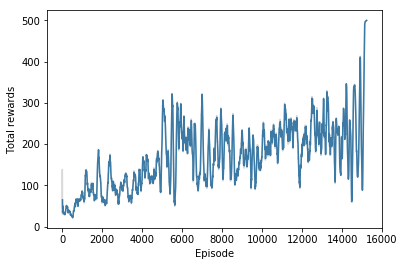

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

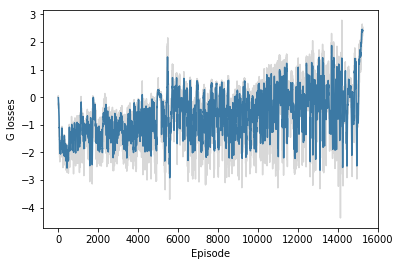

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

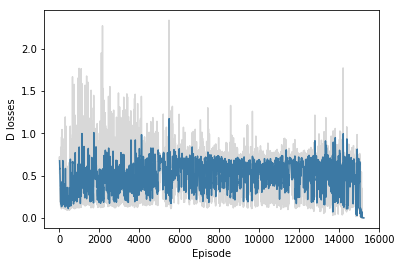

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

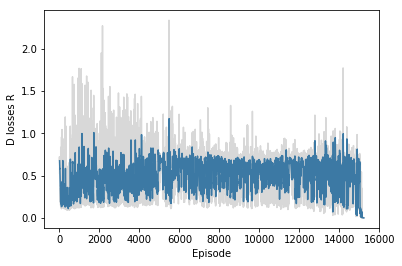

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

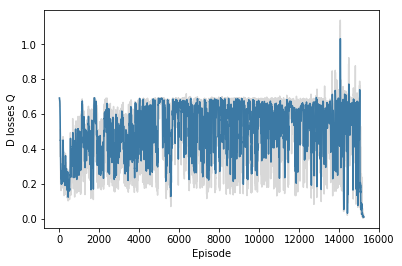

In [34]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
    # if total_reward == 500:
    #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.